In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import json
import logging
import os
import time

# Import third-party modules
import numpy as np
import pandas as pd
import ruamel.yaml
import tree_maker

# Import user-defined modules

import xmask as xm

import xobjects as xo
import xtrack as xt
import matplotlib.ticker as ticker
sns.set_theme(style="ticks")

/afs/cern.ch/work/a/aradosla/private/example_DA_study_mine/miniforge/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_quad_300_12e-6/**/*norm.parquet')
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/part*.parquet')
files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/**/*norm.parquet')
files_new = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_no_noise/**/*norm.parquet')

In [3]:
df_all = pd.DataFrame()
for file in files:
    df = pd.read_parquet(file)
    df_all = pd.concat([df_all, df], ignore_index=True)

df_noise = pd.DataFrame()
for file in files_new:
    df = pd.read_parquet(file)
    df_noise = pd.concat([df_noise, df], ignore_index=True)

1000
101000
201000
301000
401000
501000


/afs/cern.ch/work/a/aradosla/private/example_DA_study_mine/miniforge/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/afs/cern.ch/work/a/aradosla/private/example_DA_study_mine/miniforge/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


601000
701000
801000
901000


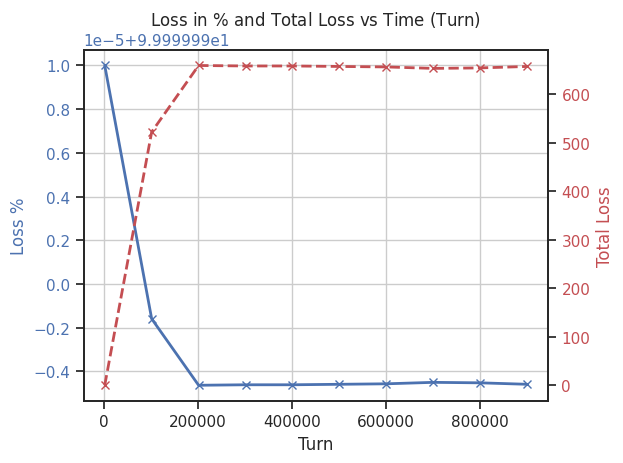

In [4]:
# ================================ Loss =================================
aperture = np.arange(6, 0, -0.01)

# Initialize lists for storing results
average_loss_per_turn = []
total_loss_per_turn = []
turns = np.unique(df_all.at_turn)[::100]

# Initialize a DataFrame to track surviving particles
#df_all_updated = df_all.copy()
df_all_updated = df_noise.copy()

lost_particles_mask_all = []
ratio = 1 #np.sqrt(7000/450)
  # Adjust as needed, e.g., np.sqrt(7000/450)

cumulative_loss = 0
total_initial_particles = len(df_all)

# Loop over each turn
for current_turn in turns:
    print(current_turn)
    # Filter dataframe for the current turn
    current_df = df_all_updated[df_all_updated["at_turn"] == current_turn]
    if len(current_df) == 0:
        average_loss_per_turn.append(np.nan)  # No data for this turn
        total_loss_per_turn.append(cumulative_loss)
        continue

    initial_number_of_particles = len(current_df)
    survived = []
    expected_survival = []

    # Calculate survived particles for each aperture
    
    # Calculate average loss for this turn
    loss = np.array(expected_survival) - np.array(survived)
    average_loss = np.mean(loss)
    average_loss_per_turn.append(average_loss)

    # Mark lost particles (i.e., particles that did not survive)
    lost_particles_mask = ((current_df.x_norm*ratio)**2 + (current_df.px_norm*ratio)**2) >= (6.)**2
    lost_particle_indices = current_df[lost_particles_mask].index
    
    # Calculate the number of newly lost particles
    newly_lost_particles = len(lost_particle_indices)
    #cumulative_loss += newly_lost_particles
    cumulative_loss = newly_lost_particles
    total_loss_per_turn.append(cumulative_loss)
    
    # Update DataFrame with lost particles
    lost_particles_mask_all.extend(lost_particle_indices)
       # Expected survival percentage based on a model or function
expected_survival= np.exp(-aperture**2 / 2.0) * 100.
# Apply the lost particles marks to the DataFrame in a single pass
df_all_updated.loc[lost_particles_mask_all, ['x_norm', 'px_norm', 'y_norm', 'py_norm']] = 0
df_all_updated.loc[lost_particles_mask_all, 'lost'] = True

# Ensure that future turns will not consider these lost particles
for future_turn in turns:
    future_turn_indices = df_all_updated[(df_all_updated["at_turn"] == future_turn) & df_all_updated.index.isin(lost_particles_mask_all)].index
    df_all_updated.loc[future_turn_indices, ['x_norm', 'px_norm', 'y_norm', 'py_norm']] = 0
    df_all_updated.loc[future_turn_indices, 'lost'] = True

# Plot average loss (intensity) against time (turns)
fig, ax1 = plt.subplots()
ax1.set_xlabel('Turn')
ax1.plot(turns, 100 - np.array(total_loss_per_turn)/len(df_all), lw=2, color='b', marker='x')
ax1.set_ylabel('Loss %', color='b')
ax1.set_title('Loss in $\%$ and Total Loss vs Time (Turn)')
ax1.tick_params(axis='y', labelcolor='b')
plt.grid(True)

# Plot total loss on the same graph but with a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(turns, total_loss_per_turn, lw=2, color='r', marker='x', linestyle='--')
ax2.set_ylabel('Total Loss', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.show()

1000
11000
21000
31000
41000
51000
61000
71000


/afs/cern.ch/work/a/aradosla/private/example_DA_study_mine/miniforge/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/afs/cern.ch/work/a/aradosla/private/example_DA_study_mine/miniforge/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


81000
91000
101000
111000
121000
131000
141000
151000
161000
171000
181000
191000
201000
211000
221000
231000
241000
251000
261000
271000
281000
291000
301000
311000
321000
331000
341000
351000
361000
371000
381000
391000
401000
411000
421000
431000
441000
451000
461000
471000
481000
491000
501000
511000
521000
531000
541000
551000
561000
571000
581000
591000
601000
611000
621000
631000
641000
651000
661000
671000
681000
691000
701000
711000
721000
731000
741000
751000
761000
771000
781000
791000
801000
811000
821000
831000
841000
851000
861000
871000
881000
891000
901000
911000
921000
931000
941000
951000
961000
971000
981000
991000


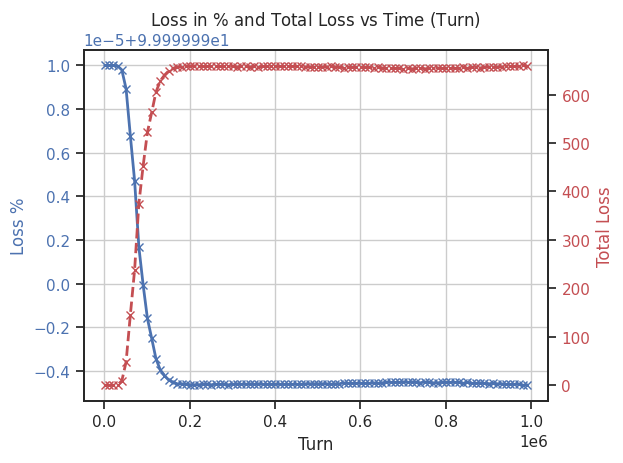

In [7]:
# ================================ Loss =================================
aperture = np.arange(6, 0, -0.01)

# Initialize lists for storing results
average_loss_per_turn = []
total_loss_per_turn = []
turns = np.unique(df_all.at_turn)[::10]

# Initialize a DataFrame to track surviving particles
#df_all_updated = df_all.copy()
df_all_updated = df_noise.copy()

lost_particles_mask_all = []
ratio = 1 #np.sqrt(7000/450)
  # Adjust as needed, e.g., np.sqrt(7000/450)

cumulative_loss = 0
total_initial_particles = len(df_all)

# Loop over each turn
for current_turn in turns:
    print(current_turn)
    # Filter dataframe for the current turn
    current_df = df_all_updated[df_all_updated["at_turn"] == current_turn]
    if len(current_df) == 0:
        average_loss_per_turn.append(np.nan)  # No data for this turn
        total_loss_per_turn.append(cumulative_loss)
        continue

    initial_number_of_particles = len(current_df)
    survived = []
    expected_survival = []

    # Calculate survived particles for each aperture
    
    # Calculate average loss for this turn
    loss = np.array(expected_survival) - np.array(survived)
    average_loss = np.mean(loss)
    average_loss_per_turn.append(average_loss)

    # Mark lost particles (i.e., particles that did not survive)
    lost_particles_mask = ((current_df.x_norm*ratio)**2 + (current_df.px_norm*ratio)**2) >= (6.)**2
    lost_particle_indices = current_df[lost_particles_mask].index
    
    # Calculate the number of newly lost particles
    newly_lost_particles = len(lost_particle_indices)
    #cumulative_loss += newly_lost_particles
    cumulative_loss = newly_lost_particles
    total_loss_per_turn.append(cumulative_loss)
    
    # Update DataFrame with lost particles
    lost_particles_mask_all.extend(lost_particle_indices)
       # Expected survival percentage based on a model or function
expected_survival= np.exp(-aperture**2 / 2.0) * 100.
# Apply the lost particles marks to the DataFrame in a single pass
df_all_updated.loc[lost_particles_mask_all, ['x_norm', 'px_norm', 'y_norm', 'py_norm']] = 0
df_all_updated.loc[lost_particles_mask_all, 'lost'] = True

# Ensure that future turns will not consider these lost particles
for future_turn in turns:
    future_turn_indices = df_all_updated[(df_all_updated["at_turn"] == future_turn) & df_all_updated.index.isin(lost_particles_mask_all)].index
    df_all_updated.loc[future_turn_indices, ['x_norm', 'px_norm', 'y_norm', 'py_norm']] = 0
    df_all_updated.loc[future_turn_indices, 'lost'] = True

# Plot average loss (intensity) against time (turns)
fig, ax1 = plt.subplots()
ax1.set_xlabel('Turn')
ax1.plot(turns, 100 - np.array(total_loss_per_turn)/len(df_all), lw=2, color='b', marker='x')
ax1.set_ylabel('Loss %', color='b')
ax1.set_title('Loss in $\%$ and Total Loss vs Time (Turn)')
ax1.tick_params(axis='y', labelcolor='b')
plt.grid(True)

# Plot total loss on the same graph but with a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(turns, total_loss_per_turn, lw=2, color='r', marker='x', linestyle='--')
ax2.set_ylabel('Total Loss', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


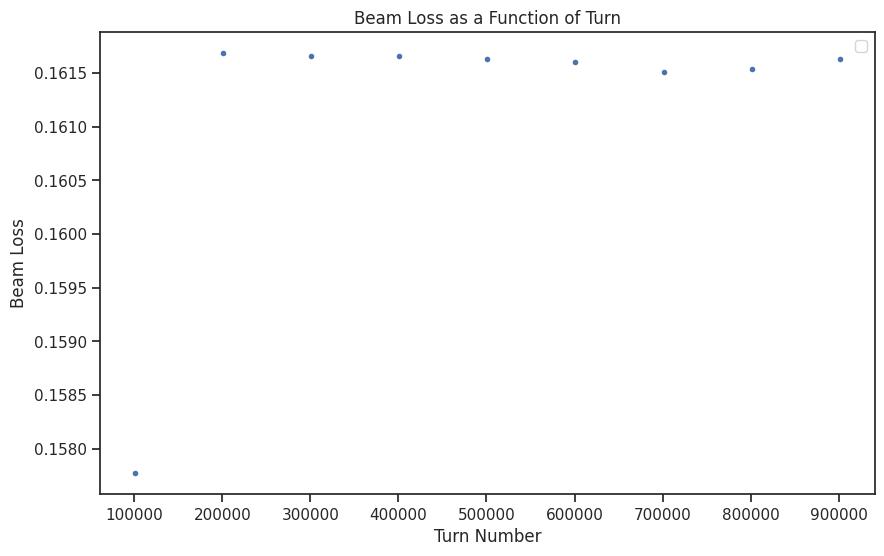

Number of survived particles for all turns (all particles): [45000, 45000, 45000, 45000, 45000, 45000, 45000, 45000, 45000, 45000]
Number of survived particles for all turns (noise particles): [35000, 29478, 29341, 29342, 29342, 29343, 29344, 29347, 29346, 29343]
Initial number of particles (all): 45000
Initial number of particles (noise): 35000


In [18]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_all and df_noise are your dataframes and are already loaded
# Also assuming turns is a list of turn numbers you want to process
turns = np.unique(df_all.at_turn)[::100]
 # Example turns, replace with your actual turns list
scaling_factor = np.sqrt(7000 / 450)
current_aperture = 6  # Replace with the actual value of current_aperture if different
ratio = scaling_factor  # Assuming this is the correct ratio to use

# Initialize lists to store the number of survived particles
num_survived_all = []
num_survived_noise = []
num_initial_particles_all = len(df_all[df_all.at_turn == turns[0]])
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])

# Initialize lists to store beam loss
beam_loss_all = []
beam_loss_noise = []

# Iterate through each turn
for turn in turns:
    # Filter the dataframes for the current turn
    df_all_turn = df_all[df_all.at_turn == turn]
    df_noise_turn = df_noise[df_noise.at_turn == turn]

    # Filter survived particles based on the given condition
    survived_particles_all = df_all_turn[((df_all_turn.x_norm* ratio)**2 + (df_all_turn.px_norm*ratio)**2) < (current_aperture)**2]
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm )**2) < (current_aperture)**2]

    # Store the number of survived particles
    num_survived_all.append(len(survived_particles_all))
    num_survived_noise.append(len(survived_particles_noise))

    # Calculate and store beam loss
    beam_loss_all.append(num_initial_particles_all - len(survived_particles_all))
    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

# Plot the beam loss as a function of turn
plt.figure(figsize=(10, 6))
#plt.plot(turns, beam_loss_all, label='Beam Loss All Particles')
plt.plot(turns[1:], np.array(beam_loss_noise)[1:]/num_initial_particles_noise, '.')

# Adding labels and legend
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')

# Show the plot
plt.show()

# Print or inspect the lengths of the survived particles dataframes for reference
print('Number of survived particles for all turns (all particles):', num_survived_all)
print('Number of survived particles for all turns (noise particles):', num_survived_noise)

# Print the initial number of particles for reference
print('Initial number of particles (all):', num_initial_particles_all)
print('Initial number of particles (noise):', num_initial_particles_noise)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


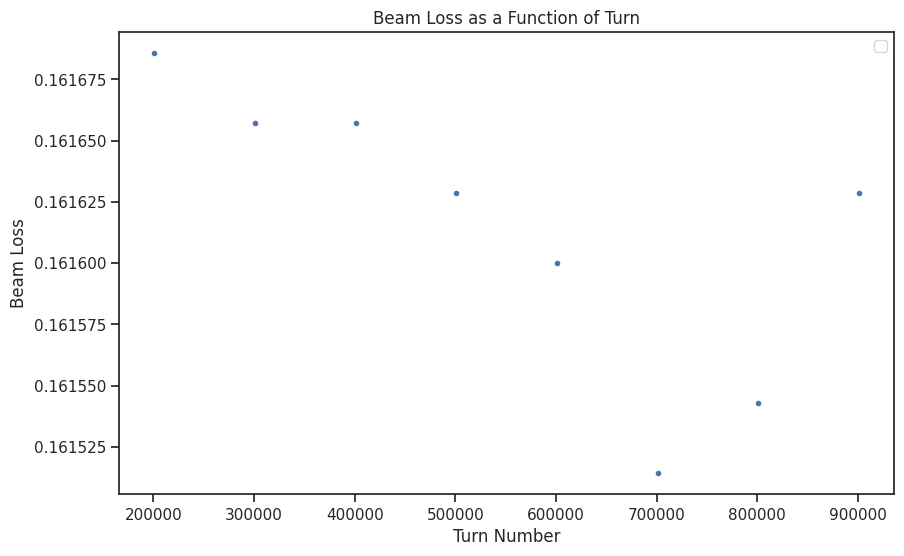

Number of survived particles for all turns (all particles): [45000, 45000, 45000, 45000, 45000, 45000, 45000, 45000, 45000, 45000]
Number of survived particles for all turns (noise particles): [35000, 29478, 29341, 29342, 29342, 29343, 29344, 29347, 29346, 29343]
Initial number of particles (all): 45000
Initial number of particles (noise): 35000


In [19]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_all.at_turn)[::100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])

beam_loss_noise = []

# Iterate through each turn
for turn in turns:
    df_noise_turn = df_noise[df_noise.at_turn == turn]
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm )**2) < (current_aperture)**2]
    num_survived_noise.append(len(survived_particles_noise))
    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))

plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')

# Adding labels and legend
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')

# Show the plot
plt.show()

# Print or inspect the lengths of the survived particles dataframes for reference
print('Number of survived particles for all turns (all particles):', num_survived_all)
print('Number of survived particles for all turns (noise particles):', num_survived_noise)

# Print the initial number of particles for reference
print('Initial number of particles (all):', num_initial_particles_all)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [23]:
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_quad_300_12e-6/**/*norm.parquet')
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/part*.parquet')
files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/**/*norm.parquet')
files_new = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_no_noise/**/*norm.parquet')

In [24]:
df_all = pd.DataFrame()
for file in files:
    df = pd.read_parquet(file)
    df_all = pd.concat([df_all, df], ignore_index=True)

df_noise = pd.DataFrame()
for file in files_new:
    df = pd.read_parquet(file)
    df_noise = pd.concat([df_noise, df], ignore_index=True)

In [28]:
survived_particles_noise.index

Index([], dtype='int64')

35000
0
0
0
0
0
0
0
0
0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


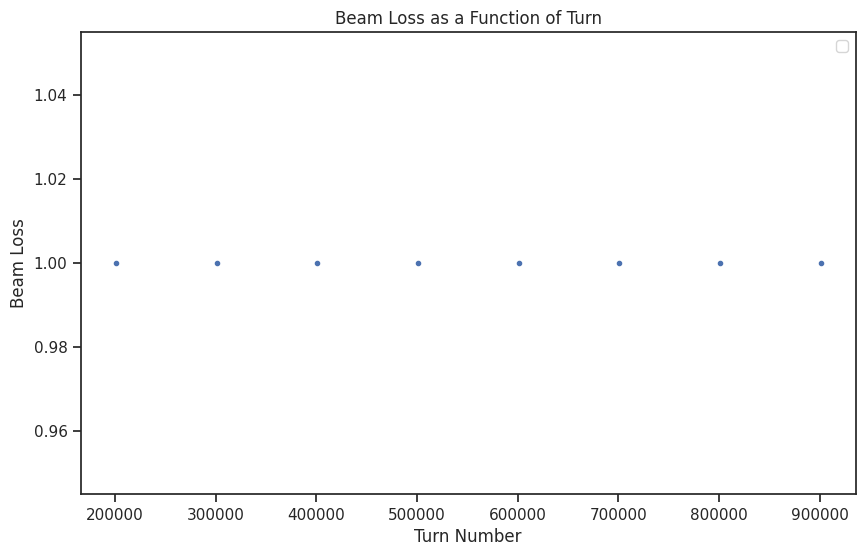

Number of survived particles for all turns (noise particles): [35000, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Initial number of particles (noise): 35000


In [29]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_all.at_turn)[::100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])
df_copy = df_noise.copy()
beam_loss_noise = []

cumulative_survived_particles_mask = np.ones(len(df_noise), dtype=bool)
df_noise['notlost'] = -np.ones(len(df_noise))
for turn in turns:
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & cumulative_survived_particles_mask]
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    print(len(survived_particles_noise))
    df_copy.loc[survived_particles_noise.index, 'notlost'] = 1
    survived_particles_indices = survived_particles_noise.index 
    new_mask = df_noise.index.isin(survived_particles_indices)
    cumulative_survived_particles_mask &= new_mask
    num_survived_noise.append(len(survived_particles_noise))
    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

Restarted miniforge (Python 3.10.13)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import json
import logging
import os
import time

# Import third-party modules
import numpy as np
import pandas as pd
import ruamel.yaml
import tree_maker

# Import user-defined modules

import xmask as xm

import xobjects as xo
import xtrack as xt
import matplotlib.ticker as ticker
sns.set_theme(style="ticks")

/afs/cern.ch/work/a/aradosla/private/example_DA_study_mine/miniforge/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_quad_300_12e-6/**/*norm.parquet')
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/part*.parquet')
files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/**/*norm.parquet')
files_new = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_no_noise/**/*norm.parquet')

In [4]:
df_all = pd.DataFrame()
for file in files:
    df = pd.read_parquet(file)
    df_all = pd.concat([df_all, df], ignore_index=True)

df_noise = pd.DataFrame()
for file in files_new:
    df = pd.read_parquet(file)
    df_noise = pd.concat([df_noise, df], ignore_index=True)

35000
29478
29341
29342
29342
29343
29344
29347
29346
29343


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


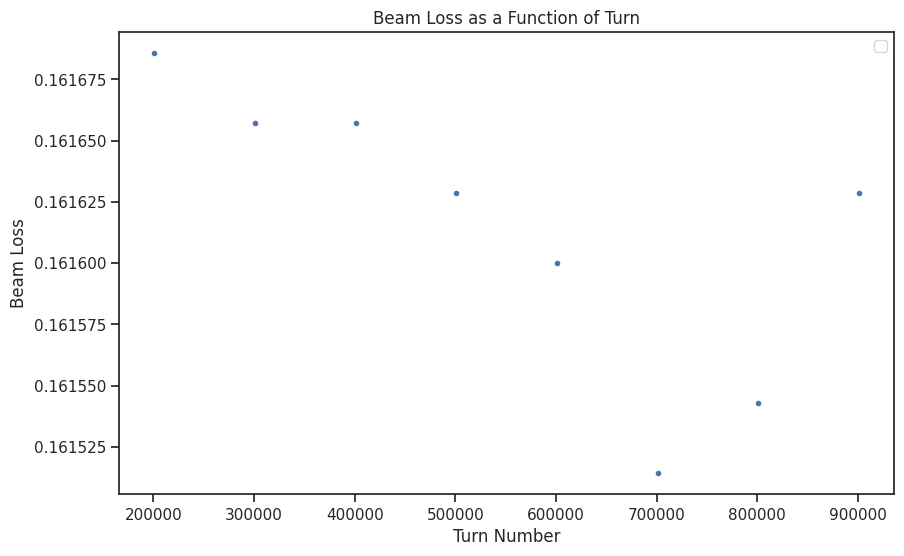

Number of survived particles for all turns (noise particles): [35000, 29478, 29341, 29342, 29342, 29343, 29344, 29347, 29346, 29343]
Initial number of particles (noise): 35000


In [5]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_all.at_turn)[::100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])
df_copy = df_noise.copy()
beam_loss_noise = []

df_noise['notlost'] = -np.ones(len(df_noise))
for turn in turns:
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn)]
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    print(len(survived_particles_noise))
    df_copy.loc[survived_particles_noise.index, 'notlost'] = 1
    survived_particles_indices = survived_particles_noise.index 
    new_mask = df_noise.index.isin(survived_particles_indices)

    num_survived_noise.append(len(survived_particles_noise))
    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [6]:
df_copy['notlost']

0           1.0
1           1.0
2           1.0
3           1.0
4           1.0
           ... 
30049995    NaN
30049996    NaN
30049997    NaN
30049998    NaN
30049999    NaN
Name: notlost, Length: 30050000, dtype: float64

In [7]:
df_copy[df_copy.at_turn ==1000]['notlost']

0           1.0
1           1.0
2           1.0
3           1.0
4           1.0
           ... 
25054995    1.0
25054996    1.0
25054997    1.0
25054998    1.0
25054999    1.0
Name: notlost, Length: 35000, dtype: float64

In [8]:
print(len(df_copy[df_copy.at_turn ==1000]['notlost'] != 1))

35000


In [9]:
print(len(df_copy[df_copy.at_turn ==1000]['notlost'] != -1))

35000


In [10]:
filtered_df = df_copy[(df_copy.at_turn == 1000) & (df_copy.notlost != -1)]

In [11]:
filtered_df['notlost']

0           1.0
1           1.0
2           1.0
3           1.0
4           1.0
           ... 
25054995    1.0
25054996    1.0
25054997    1.0
25054998    1.0
25054999    1.0
Name: notlost, Length: 35000, dtype: float64

In [12]:
filtered_df = df_copy[(df_copy.at_turn == 1000) & (df_copy.notlost != 1)]

In [13]:
filtered_df['notlost']

Series([], Name: notlost, dtype: float64)

In [14]:
filtered_df = df_copy[(df_copy.at_turn == 10000) & (df_copy.notlost != 1)]

In [15]:
filtered_df['notlost']

45000      NaN
45001      NaN
45002      NaN
45003      NaN
45004      NaN
            ..
25099995   NaN
25099996   NaN
25099997   NaN
25099998   NaN
25099999   NaN
Name: notlost, Length: 35000, dtype: float64

In [17]:
filtered_df = df_copy[(df_copy.at_turn == 100000) & (df_copy.notlost != 1)]

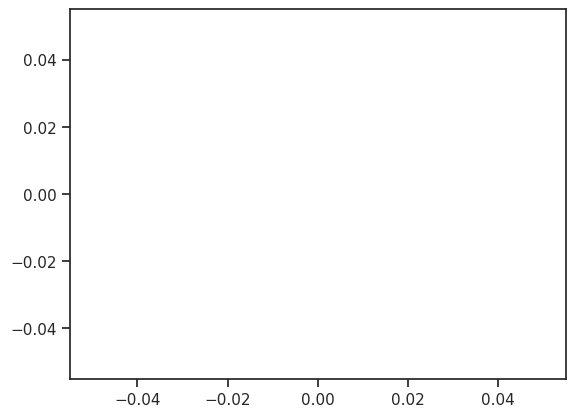

In [18]:
plt.plot(filtered_df['notlost'])

35000
0
29478
522
29341
659
29342
658
29342
658
29343
657
29344
656
29347
653
29346
654
29343


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


657


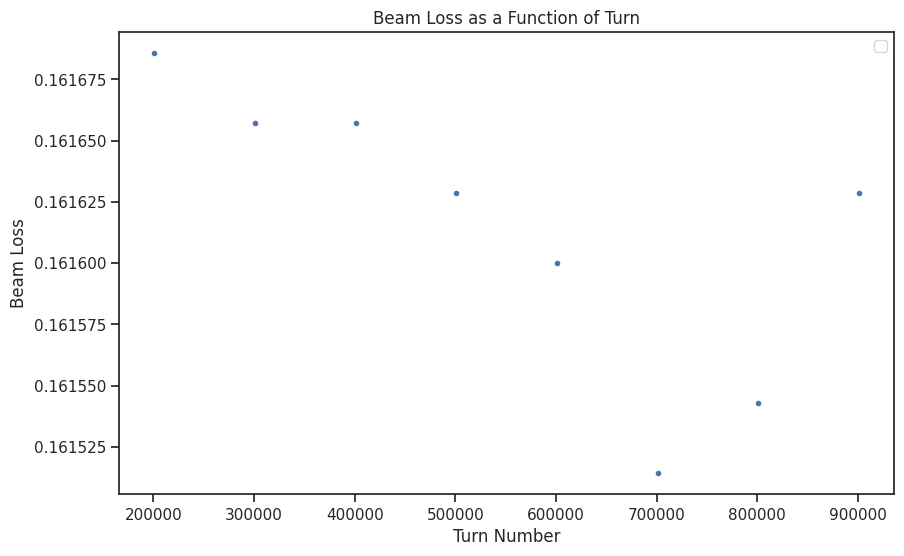

Number of survived particles for all turns (noise particles): [35000, 29478, 29341, 29342, 29342, 29343, 29344, 29347, 29346, 29343]
Initial number of particles (noise): 35000


In [21]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[::100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])
df_copy = df_noise.copy()
beam_loss_noise = []
notlost = []

df_noise['notlost'] = -np.ones(len(df_noise))
for turn in turns:
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn)]
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    print(len(survived_particles_noise))
    df_copy.loc[survived_particles_noise.index, 'notlost'] = 1
    survived_particles_indices = survived_particles_noise.index 
    new_mask = df_noise.index.isin(survived_particles_indices)

    num_survived_noise.append(len(survived_particles_noise))
    filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.notlost != 1)]
    notlost.append(len(filtered_df))
    print(len(filtered_df))
    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [22]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[::100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])
df_copy = df_noise.copy()
beam_loss_noise = []
notlost = []

df_noise['notlost'] = -np.ones(len(df_noise))
for turn in turns:
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn)]
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    print(len(survived_particles_noise))
    for turn in turns:
        df_copy.loc[survived_particles_noise.index*turn, 'notlost'] = 1
    survived_particles_indices = survived_particles_noise.index 
    new_mask = df_noise.index.isin(survived_particles_indices)

    num_survived_noise.append(len(survived_particles_noise))
    filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.notlost != 1)]
    notlost.append(len(filtered_df))
    print(len(filtered_df))
    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

35000


KeyError: '[50000000, 50001000, 50002000, 50003000, 50004000, 50005000, 50006000, 50007000, 50008000, 50009000, 50010000, 50011000, 50012000, 50013000, 50014000, 50015000, 50016000, 50017000, 50018000, 50019000, 50020000, 50021000, 50022000, 50023000, 50024000, 50025000, 50026000, 50027000, 50028000, 50029000, 50030000, 50031000, 50032000, 50033000, 50034000, 50035000, 50036000, 50037000, 50038000, 50039000, 50040000, 50041000, 50042000, 50043000, 50044000, 50045000, 50046000, 50047000, 50048000, 50049000, 50050000, 50051000, 50052000, 50053000, 50054000, 50055000, 50056000, 50057000, 50058000, 50059000, 50060000, 50061000, 50062000, 50063000, 50064000, 50065000, 50066000, 50067000, 50068000, 50069000, 50070000, 50071000, 50072000, 50073000, 50074000, 50075000, 50076000, 50077000, 50078000, 50079000, 50080000, 50081000, 50082000, 50083000, 50084000, 50085000, 50086000, 50087000, 50088000, 50089000, 50090000, 50091000, 50092000, 50093000, 50094000, 50095000, 50096000, 50097000, 50098000, 50099000, 50100000, 50101000, 50102000, 50103000, 50104000, 50105000, 50106000, 50107000, 50108000, 50109000, 50110000, 50111000, 50112000, 50113000, 50114000, 50115000, 50116000, 50117000, 50118000, 50119000, 50120000, 50121000, 50122000, 50123000, 50124000, 50125000, 50126000, 50127000, 50128000, 50129000, 50130000, 50131000, 50132000, 50133000, 50134000, 50135000, 50136000, 50137000, 50138000, 50139000, 50140000, 50141000, 50142000, 50143000, 50144000, 50145000, 50146000, 50147000, 50148000, 50149000, 50150000, 50151000, 50152000, 50153000, 50154000, 50155000, 50156000, 50157000, 50158000, 50159000, 50160000, 50161000, 50162000, 50163000, 50164000, 50165000, 50166000, 50167000, 50168000, 50169000, 50170000, 50171000, 50172000, 50173000, 50174000, 50175000, 50176000, 50177000, 50178000, 50179000, 50180000, 50181000, 50182000, 50183000, 50184000, 50185000, 50186000, 50187000, 50188000, 50189000, 50190000, 50191000, 50192000, 50193000, 50194000, 50195000, 50196000, 50197000, 50198000, 50199000, 50200000, 50201000, 50202000, 50203000, 50204000, 50205000, 50206000, 50207000, 50208000, 50209000, 50210000, 50211000, 50212000, 50213000, 50214000, 50215000, 50216000, 50217000, 50218000, 50219000, 50220000, 50221000, 50222000, 50223000, 50224000, 50225000, 50226000, 50227000, 50228000, 50229000, 50230000, 50231000, 50232000, 50233000, 50234000, 50235000, 50236000, 50237000, 50238000, 50239000, 50240000, 50241000, 50242000, 50243000, 50244000, 50245000, 50246000, 50247000, 50248000, 50249000, 50250000, 50251000, 50252000, 50253000, 50254000, 50255000, 50256000, 50257000, 50258000, 50259000, 50260000, 50261000, 50262000, 50263000, 50264000, 50265000, 50266000, 50267000, 50268000, 50269000, 50270000, 50271000, 50272000, 50273000, 50274000, 50275000, 50276000, 50277000, 50278000, 50279000, 50280000, 50281000, 50282000, 50283000, 50284000, 50285000, 50286000, 50287000, 50288000, 50289000, 50290000, 50291000, 50292000, 50293000, 50294000, 50295000, 50296000, 50297000, 50298000, 50299000, 50300000, 50301000, 50302000, 50303000, 50304000, 50305000, 50306000, 50307000, 50308000, 50309000, 50310000, 50311000, 50312000, 50313000, 50314000, 50315000, 50316000, 50317000, 50318000, 50319000, 50320000, 50321000, 50322000, 50323000, 50324000, 50325000, 50326000, 50327000, 50328000, 50329000, 50330000, 50331000, 50332000, 50333000, 50334000, 50335000, 50336000, 50337000, 50338000, 50339000, 50340000, 50341000, 50342000, 50343000, 50344000, 50345000, 50346000, 50347000, 50348000, 50349000, 50350000, 50351000, 50352000, 50353000, 50354000, 50355000, 50356000, 50357000, 50358000, 50359000, 50360000, 50361000, 50362000, 50363000, 50364000, 50365000, 50366000, 50367000, 50368000, 50369000, 50370000, 50371000, 50372000, 50373000, 50374000, 50375000, 50376000, 50377000, 50378000, 50379000, 50380000, 50381000, 50382000, 50383000, 50384000, 50385000, 50386000, 50387000, 50388000, 50389000, 50390000, 50391000, 50392000, 50393000, 50394000, 50395000, 50396000, 50397000, 50398000, 50399000, 50400000, 50401000, 50402000, 50403000, 50404000, 50405000, 50406000, 50407000, 50408000, 50409000, 50410000, 50411000, 50412000, 50413000, 50414000, 50415000, 50416000, 50417000, 50418000, 50419000, 50420000, 50421000, 50422000, 50423000, 50424000, 50425000, 50426000, 50427000, 50428000, 50429000, 50430000, 50431000, 50432000, 50433000, 50434000, 50435000, 50436000, 50437000, 50438000, 50439000, 50440000, 50441000, 50442000, 50443000, 50444000, 50445000, 50446000, 50447000, 50448000, 50449000, 50450000, 50451000, 50452000, 50453000, 50454000, 50455000, 50456000, 50457000, 50458000, 50459000, 50460000, 50461000, 50462000, 50463000, 50464000, 50465000, 50466000, 50467000, 50468000, 50469000, 50470000, 50471000, 50472000, 50473000, 50474000, 50475000, 50476000, 50477000, 50478000, 50479000, 50480000, 50481000, 50482000, 50483000, 50484000, 50485000, 50486000, 50487000, 50488000, 50489000, 50490000, 50491000, 50492000, 50493000, 50494000, 50495000, 50496000, 50497000, 50498000, 50499000, 50500000, 50501000, 50502000, 50503000, 50504000, 50505000, 50506000, 50507000, 50508000, 50509000, 50510000, 50511000, 50512000, 50513000, 50514000, 50515000, 50516000, 50517000, 50518000, 50519000, 50520000, 50521000, 50522000, 50523000, 50524000, 50525000, 50526000, 50527000, 50528000, 50529000, 50530000, 50531000, 50532000, 50533000, 50534000, 50535000, 50536000, 50537000, 50538000, 50539000, 50540000, 50541000, 50542000, 50543000, 50544000, 50545000, 50546000, 50547000, 50548000, 50549000, 50550000, 50551000, 50552000, 50553000, 50554000, 50555000, 50556000, 50557000, 50558000, 50559000, 50560000, 50561000, 50562000, 50563000, 50564000, 50565000, 50566000, 50567000, 50568000, 50569000, 50570000, 50571000, 50572000, 50573000, 50574000, 50575000, 50576000, 50577000, 50578000, 50579000, 50580000, 50581000, 50582000, 50583000, 50584000, 50585000, 50586000, 50587000, 50588000, 50589000, 50590000, 50591000, 50592000, 50593000, 50594000, 50595000, 50596000, 50597000, 50598000, 50599000, 50600000, 50601000, 50602000, 50603000, 50604000, 50605000, 50606000, 50607000, 50608000, 50609000, 50610000, 50611000, 50612000, 50613000, 50614000, 50615000, 50616000, 50617000, 50618000, 50619000, 50620000, 50621000, 50622000, 50623000, 50624000, 50625000, 50626000, 50627000, 50628000, 50629000, 50630000, 50631000, 50632000, 50633000, 50634000, 50635000, 50636000, 50637000, 50638000, 50639000, 50640000, 50641000, 50642000, 50643000, 50644000, 50645000, 50646000, 50647000, 50648000, 50649000, 50650000, 50651000, 50652000, 50653000, 50654000, 50655000, 50656000, 50657000, 50658000, 50659000, 50660000, 50661000, 50662000, 50663000, 50664000, 50665000, 50666000, 50667000, 50668000, 50669000, 50670000, 50671000, 50672000, 50673000, 50674000, 50675000, 50676000, 50677000, 50678000, 50679000, 50680000, 50681000, 50682000, 50683000, 50684000, 50685000, 50686000, 50687000, 50688000, 50689000, 50690000, 50691000, 50692000, 50693000, 50694000, 50695000, 50696000, 50697000, 50698000, 50699000, 50700000, 50701000, 50702000, 50703000, 50704000, 50705000, 50706000, 50707000, 50708000, 50709000, 50710000, 50711000, 50712000, 50713000, 50714000, 50715000, 50716000, 50717000, 50718000, 50719000, 50720000, 50721000, 50722000, 50723000, 50724000, 50725000, 50726000, 50727000, 50728000, 50729000, 50730000, 50731000, 50732000, 50733000, 50734000, 50735000, 50736000, 50737000, 50738000, 50739000, 50740000, 50741000, 50742000, 50743000, 50744000, 50745000, 50746000, 50747000, 50748000, 50749000, 50750000, 50751000, 50752000, 50753000, 50754000, 50755000, 50756000, 50757000, 50758000, 50759000, 50760000, 50761000, 50762000, 50763000, 50764000, 50765000, 50766000, 50767000, 50768000, 50769000, 50770000, 50771000, 50772000, 50773000, 50774000, 50775000, 50776000, 50777000, 50778000, 50779000, 50780000, 50781000, 50782000, 50783000, 50784000, 50785000, 50786000, 50787000, 50788000, 50789000, 50790000, 50791000, 50792000, 50793000, 50794000, 50795000, 50796000, 50797000, 50798000, 50799000, 50800000, 50801000, 50802000, 50803000, 50804000, 50805000, 50806000, 50807000, 50808000, 50809000, 50810000, 50811000, 50812000, 50813000, 50814000, 50815000, 50816000, 50817000, 50818000, 50819000, 50820000, 50821000, 50822000, 50823000, 50824000, 50825000, 50826000, 50827000, 50828000, 50829000, 50830000, 50831000, 50832000, 50833000, 50834000, 50835000, 50836000, 50837000, 50838000, 50839000, 50840000, 50841000, 50842000, 50843000, 50844000, 50845000, 50846000, 50847000, 50848000, 50849000, 50850000, 50851000, 50852000, 50853000, 50854000, 50855000, 50856000, 50857000, 50858000, 50859000, 50860000, 50861000, 50862000, 50863000, 50864000, 50865000, 50866000, 50867000, 50868000, 50869000, 50870000, 50871000, 50872000, 50873000, 50874000, 50875000, 50876000, 50877000, 50878000, 50879000, 50880000, 50881000, 50882000, 50883000, 50884000, 50885000, 50886000, 50887000, 50888000, 50889000, 50890000, 50891000, 50892000, 50893000, 50894000, 50895000, 50896000, 50897000, 50898000, 50899000, 50900000, 50901000, 50902000, 50903000, 50904000, 50905000, 50906000, 50907000, 50908000, 50909000, 50910000, 50911000, 50912000, 50913000, 50914000, 50915000, 50916000, 50917000, 50918000, 50919000, 50920000, 50921000, 50922000, 50923000, 50924000, 50925000, 50926000, 50927000, 50928000, 50929000, 50930000, 50931000, 50932000, 50933000, 50934000, 50935000, 50936000, 50937000, 50938000, 50939000, 50940000, 50941000, 50942000, 50943000, 50944000, 50945000, 50946000, 50947000, 50948000, 50949000, 50950000, 50951000, 50952000, 50953000, 50954000, 50955000, 50956000, 50957000, 50958000, 50959000, 50960000, 50961000, 50962000, 50963000, 50964000, 50965000, 50966000, 50967000, 50968000, 50969000, 50970000, 50971000, 50972000, 50973000, 50974000, 50975000, 50976000, 50977000, 50978000, 50979000, 50980000, 50981000, 50982000, 50983000, 50984000, 50985000, 50986000, 50987000, 50988000, 50989000, 50990000, 50991000, 50992000, 50993000, 50994000, 50995000, 50996000, 50997000, 50998000, 50999000, 51000000, 51001000, 51002000, 51003000, 51004000, 51005000, 51006000, 51007000, 51008000, 51009000, 51010000, 51011000, 51012000, 51013000, 51014000, 51015000, 51016000, 51017000, 51018000, 51019000, 51020000, 51021000, 51022000, 51023000, 51024000, 51025000, 51026000, 51027000, 51028000, 51029000, 51030000, 51031000, 51032000, 51033000, 51034000, 51035000, 51036000, 51037000, 51038000, 51039000, 51040000, 51041000, 51042000, 51043000, 51044000, 51045000, 51046000, 51047000, 51048000, 51049000, 51050000, 51051000, 51052000, 51053000, 51054000, 51055000, 51056000, 51057000, 51058000, 51059000, 51060000, 51061000, 51062000, 51063000, 51064000, 51065000, 51066000, 51067000, 51068000, 51069000, 51070000, 51071000, 51072000, 51073000, 51074000, 51075000, 51076000, 51077000, 51078000, 51079000, 51080000, 51081000, 51082000, 51083000, 51084000, 51085000, 51086000, 51087000, 51088000, 51089000, 51090000, 51091000, 51092000, 51093000, 51094000, 51095000, 51096000, 51097000, 51098000, 51099000, 51100000, 51101000, 51102000, 51103000, 51104000, 51105000, 51106000, 51107000, 51108000, 51109000, 51110000, 51111000, 51112000, 51113000, 51114000, 51115000, 51116000, 51117000, 51118000, 51119000, 51120000, 51121000, 51122000, 51123000, 51124000, 51125000, 51126000, 51127000, 51128000, 51129000, 51130000, 51131000, 51132000, 51133000, 51134000, 51135000, 51136000, 51137000, 51138000, 51139000, 51140000, 51141000, 51142000, 51143000, 51144000, 51145000, 51146000, 51147000, 51148000, 51149000, 51150000, 51151000, 51152000, 51153000, 51154000, 51155000, 51156000, 51157000, 51158000, 51159000, 51160000, 51161000, 51162000, 51163000, 51164000, 51165000, 51166000, 51167000, 51168000, 51169000, 51170000, 51171000, 51172000, 51173000, 51174000, 51175000, 51176000, 51177000, 51178000, 51179000, 51180000, 51181000, 51182000, 51183000, 51184000, 51185000, 51186000, 51187000, 51188000, 51189000, 51190000, 51191000, 51192000, 51193000, 51194000, 51195000, 51196000, 51197000, 51198000, 51199000, 51200000, 51201000, 51202000, 51203000, 51204000, 51205000, 51206000, 51207000, 51208000, 51209000, 51210000, 51211000, 51212000, 51213000, 51214000, 51215000, 51216000, 51217000, 51218000, 51219000, 51220000, 51221000, 51222000, 51223000, 51224000, 51225000, 51226000, 51227000, 51228000, 51229000, 51230000, 51231000, 51232000, 51233000, 51234000, 51235000, 51236000, 51237000, 51238000, 51239000, 51240000, 51241000, 51242000, 51243000, 51244000, 51245000, 51246000, 51247000, 51248000, 51249000, 51250000, 51251000, 51252000, 51253000, 51254000, 51255000, 51256000, 51257000, 51258000, 51259000, 51260000, 51261000, 51262000, 51263000, 51264000, 51265000, 51266000, 51267000, 51268000, 51269000, 51270000, 51271000, 51272000, 51273000, 51274000, 51275000, 51276000, 51277000, 51278000, 51279000, 51280000, 51281000, 51282000, 51283000, 51284000, 51285000, 51286000, 51287000, 51288000, 51289000, 51290000, 51291000, 51292000, 51293000, 51294000, 51295000, 51296000, 51297000, 51298000, 51299000, 51300000, 51301000, 51302000, 51303000, 51304000, 51305000, 51306000, 51307000, 51308000, 51309000, 51310000, 51311000, 51312000, 51313000, 51314000, 51315000, 51316000, 51317000, 51318000, 51319000, 51320000, 51321000, 51322000, 51323000, 51324000, 51325000, 51326000, 51327000, 51328000, 51329000, 51330000, 51331000, 51332000, 51333000, 51334000, 51335000, 51336000, 51337000, 51338000, 51339000, 51340000, 51341000, 51342000, 51343000, 51344000, 51345000, 51346000, 51347000, 51348000, 51349000, 51350000, 51351000, 51352000, 51353000, 51354000, 51355000, 51356000, 51357000, 51358000, 51359000, 51360000, 51361000, 51362000, 51363000, 51364000, 51365000, 51366000, 51367000, 51368000, 51369000, 51370000, 51371000, 51372000, 51373000, 51374000, 51375000, 51376000, 51377000, 51378000, 51379000, 51380000, 51381000, 51382000, 51383000, 51384000, 51385000, 51386000, 51387000, 51388000, 51389000, 51390000, 51391000, 51392000, 51393000, 51394000, 51395000, 51396000, 51397000, 51398000, 51399000, 51400000, 51401000, 51402000, 51403000, 51404000, 51405000, 51406000, 51407000, 51408000, 51409000, 51410000, 51411000, 51412000, 51413000, 51414000, 51415000, 51416000, 51417000, 51418000, 51419000, 51420000, 51421000, 51422000, 51423000, 51424000, 51425000, 51426000, 51427000, 51428000, 51429000, 51430000, 51431000, 51432000, 51433000, 51434000, 51435000, 51436000, 51437000, 51438000, 51439000, 51440000, 51441000, 51442000, 51443000, 51444000, 51445000, 51446000, 51447000, 51448000, 51449000, 51450000, 51451000, 51452000, 51453000, 51454000, 51455000, 51456000, 51457000, 51458000, 51459000, 51460000, 51461000, 51462000, 51463000, 51464000, 51465000, 51466000, 51467000, 51468000, 51469000, 51470000, 51471000, 51472000, 51473000, 51474000, 51475000, 51476000, 51477000, 51478000, 51479000, 51480000, 51481000, 51482000, 51483000, 51484000, 51485000, 51486000, 51487000, 51488000, 51489000, 51490000, 51491000, 51492000, 51493000, 51494000, 51495000, 51496000, 51497000, 51498000, 51499000, 51500000, 51501000, 51502000, 51503000, 51504000, 51505000, 51506000, 51507000, 51508000, 51509000, 51510000, 51511000, 51512000, 51513000, 51514000, 51515000, 51516000, 51517000, 51518000, 51519000, 51520000, 51521000, 51522000, 51523000, 51524000, 51525000, 51526000, 51527000, 51528000, 51529000, 51530000, 51531000, 51532000, 51533000, 51534000, 51535000, 51536000, 51537000, 51538000, 51539000, 51540000, 51541000, 51542000, 51543000, 51544000, 51545000, 51546000, 51547000, 51548000, 51549000, 51550000, 51551000, 51552000, 51553000, 51554000, 51555000, 51556000, 51557000, 51558000, 51559000, 51560000, 51561000, 51562000, 51563000, 51564000, 51565000, 51566000, 51567000, 51568000, 51569000, 51570000, 51571000, 51572000, 51573000, 51574000, 51575000, 51576000, 51577000, 51578000, 51579000, 51580000, 51581000, 51582000, 51583000, 51584000, 51585000, 51586000, 51587000, 51588000, 51589000, 51590000, 51591000, 51592000, 51593000, 51594000, 51595000, 51596000, 51597000, 51598000, 51599000, 51600000, 51601000, 51602000, 51603000, 51604000, 51605000, 51606000, 51607000, 51608000, 51609000, 51610000, 51611000, 51612000, 51613000, 51614000, 51615000, 51616000, 51617000, 51618000, 51619000, 51620000, 51621000, 51622000, 51623000, 51624000, 51625000, 51626000, 51627000, 51628000, 51629000, 51630000, 51631000, 51632000, 51633000, 51634000, 51635000, 51636000, 51637000, 51638000, 51639000, 51640000, 51641000, 51642000, 51643000, 51644000, 51645000, 51646000, 51647000, 51648000, 51649000, 51650000, 51651000, 51652000, 51653000, 51654000, 51655000, 51656000, 51657000, 51658000, 51659000, 51660000, 51661000, 51662000, 51663000, 51664000, 51665000, 51666000, 51667000, 51668000, 51669000, 51670000, 51671000, 51672000, 51673000, 51674000, 51675000, 51676000, 51677000, 51678000, 51679000, 51680000, 51681000, 51682000, 51683000, 51684000, 51685000, 51686000, 51687000, 51688000, 51689000, 51690000, 51691000, 51692000, 51693000, 51694000, 51695000, 51696000, 51697000, 51698000, 51699000, 51700000, 51701000, 51702000, 51703000, 51704000, 51705000, 51706000, 51707000, 51708000, 51709000, 51710000, 51711000, 51712000, 51713000, 51714000, 51715000, 51716000, 51717000, 51718000, 51719000, 51720000, 51721000, 51722000, 51723000, 51724000, 51725000, 51726000, 51727000, 51728000, 51729000, 51730000, 51731000, 51732000, 51733000, 51734000, 51735000, 51736000, 51737000, 51738000, 51739000, 51740000, 51741000, 51742000, 51743000, 51744000, 51745000, 51746000, 51747000, 51748000, 51749000, 51750000, 51751000, 51752000, 51753000, 51754000, 51755000, 51756000, 51757000, 51758000, 51759000, 51760000, 51761000, 51762000, 51763000, 51764000, 51765000, 51766000, 51767000, 51768000, 51769000, 51770000, 51771000, 51772000, 51773000, 51774000, 51775000, 51776000, 51777000, 51778000, 51779000, 51780000, 51781000, 51782000, 51783000, 51784000, 51785000, 51786000, 51787000, 51788000, 51789000, 51790000, 51791000, 51792000, 51793000, 51794000, 51795000, 51796000, 51797000, 51798000, 51799000, 51800000, 51801000, 51802000, 51803000, 51804000, 51805000, 51806000, 51807000, 51808000, 51809000, 51810000, 51811000, 51812000, 51813000, 51814000, 51815000, 51816000, 51817000, 51818000, 51819000, 51820000, 51821000, 51822000, 51823000, 51824000, 51825000, 51826000, 51827000, 51828000, 51829000, 51830000, 51831000, 51832000, 51833000, 51834000, 51835000, 51836000, 51837000, 51838000, 51839000, 51840000, 51841000, 51842000, 51843000, 51844000, 51845000, 51846000, 51847000, 51848000, 51849000, 51850000, 51851000, 51852000, 51853000, 51854000, 51855000, 51856000, 51857000, 51858000, 51859000, 51860000, 51861000, 51862000, 51863000, 51864000, 51865000, 51866000, 51867000, 51868000, 51869000, 51870000, 51871000, 51872000, 51873000, 51874000, 51875000, 51876000, 51877000, 51878000, 51879000, 51880000, 51881000, 51882000, 51883000, 51884000, 51885000, 51886000, 51887000, 51888000, 51889000, 51890000, 51891000, 51892000, 51893000, 51894000, 51895000, 51896000, 51897000, 51898000, 51899000, 51900000, 51901000, 51902000, 51903000, 51904000, 51905000, 51906000, 51907000, 51908000, 51909000, 51910000, 51911000, 51912000, 51913000, 51914000, 51915000, 51916000, 51917000, 51918000, 51919000, 51920000, 51921000, 51922000, 51923000, 51924000, 51925000, 51926000, 51927000, 51928000, 51929000, 51930000, 51931000, 51932000, 51933000, 51934000, 51935000, 51936000, 51937000, 51938000, 51939000, 51940000, 51941000, 51942000, 51943000, 51944000, 51945000, 51946000, 51947000, 51948000, 51949000, 51950000, 51951000, 51952000, 51953000, 51954000, 51955000, 51956000, 51957000, 51958000, 51959000, 51960000, 51961000, 51962000, 51963000, 51964000, 51965000, 51966000, 51967000, 51968000, 51969000, 51970000, 51971000, 51972000, 51973000, 51974000, 51975000, 51976000, 51977000, 51978000, 51979000, 51980000, 51981000, 51982000, 51983000, 51984000, 51985000, 51986000, 51987000, 51988000, 51989000, 51990000, 51991000, 51992000, 51993000, 51994000, 51995000, 51996000, 51997000, 51998000, 51999000, 52000000, 52001000, 52002000, 52003000, 52004000, 52005000, 52006000, 52007000, 52008000, 52009000, 52010000, 52011000, 52012000, 52013000, 52014000, 52015000, 52016000, 52017000, 52018000, 52019000, 52020000, 52021000, 52022000, 52023000, 52024000, 52025000, 52026000, 52027000, 52028000, 52029000, 52030000, 52031000, 52032000, 52033000, 52034000, 52035000, 52036000, 52037000, 52038000, 52039000, 52040000, 52041000, 52042000, 52043000, 52044000, 52045000, 52046000, 52047000, 52048000, 52049000, 52050000, 52051000, 52052000, 52053000, 52054000, 52055000, 52056000, 52057000, 52058000, 52059000, 52060000, 52061000, 52062000, 52063000, 52064000, 52065000, 52066000, 52067000, 52068000, 52069000, 52070000, 52071000, 52072000, 52073000, 52074000, 52075000, 52076000, 52077000, 52078000, 52079000, 52080000, 52081000, 52082000, 52083000, 52084000, 52085000, 52086000, 52087000, 52088000, 52089000, 52090000, 52091000, 52092000, 52093000, 52094000, 52095000, 52096000, 52097000, 52098000, 52099000, 52100000, 52101000, 52102000, 52103000, 52104000, 52105000, 52106000, 52107000, 52108000, 52109000, 52110000, 52111000, 52112000, 52113000, 52114000, 52115000, 52116000, 52117000, 52118000, 52119000, 52120000, 52121000, 52122000, 52123000, 52124000, 52125000, 52126000, 52127000, 52128000, 52129000, 52130000, 52131000, 52132000, 52133000, 52134000, 52135000, 52136000, 52137000, 52138000, 52139000, 52140000, 52141000, 52142000, 52143000, 52144000, 52145000, 52146000, 52147000, 52148000, 52149000, 52150000, 52151000, 52152000, 52153000, 52154000, 52155000, 52156000, 52157000, 52158000, 52159000, 52160000, 52161000, 52162000, 52163000, 52164000, 52165000, 52166000, 52167000, 52168000, 52169000, 52170000, 52171000, 52172000, 52173000, 52174000, 52175000, 52176000, 52177000, 52178000, 52179000, 52180000, 52181000, 52182000, 52183000, 52184000, 52185000, 52186000, 52187000, 52188000, 52189000, 52190000, 52191000, 52192000, 52193000, 52194000, 52195000, 52196000, 52197000, 52198000, 52199000, 52200000, 52201000, 52202000, 52203000, 52204000, 52205000, 52206000, 52207000, 52208000, 52209000, 52210000, 52211000, 52212000, 52213000, 52214000, 52215000, 52216000, 52217000, 52218000, 52219000, 52220000, 52221000, 52222000, 52223000, 52224000, 52225000, 52226000, 52227000, 52228000, 52229000, 52230000, 52231000, 52232000, 52233000, 52234000, 52235000, 52236000, 52237000, 52238000, 52239000, 52240000, 52241000, 52242000, 52243000, 52244000, 52245000, 52246000, 52247000, 52248000, 52249000, 52250000, 52251000, 52252000, 52253000, 52254000, 52255000, 52256000, 52257000, 52258000, 52259000, 52260000, 52261000, 52262000, 52263000, 52264000, 52265000, 52266000, 52267000, 52268000, 52269000, 52270000, 52271000, 52272000, 52273000, 52274000, 52275000, 52276000, 52277000, 52278000, 52279000, 52280000, 52281000, 52282000, 52283000, 52284000, 52285000, 52286000, 52287000, 52288000, 52289000, 52290000, 52291000, 52292000, 52293000, 52294000, 52295000, 52296000, 52297000, 52298000, 52299000, 52300000, 52301000, 52302000, 52303000, 52304000, 52305000, 52306000, 52307000, 52308000, 52309000, 52310000, 52311000, 52312000, 52313000, 52314000, 52315000, 52316000, 52317000, 52318000, 52319000, 52320000, 52321000, 52322000, 52323000, 52324000, 52325000, 52326000, 52327000, 52328000, 52329000, 52330000, 52331000, 52332000, 52333000, 52334000, 52335000, 52336000, 52337000, 52338000, 52339000, 52340000, 52341000, 52342000, 52343000, 52344000, 52345000, 52346000, 52347000, 52348000, 52349000, 52350000, 52351000, 52352000, 52353000, 52354000, 52355000, 52356000, 52357000, 52358000, 52359000, 52360000, 52361000, 52362000, 52363000, 52364000, 52365000, 52366000, 52367000, 52368000, 52369000, 52370000, 52371000, 52372000, 52373000, 52374000, 52375000, 52376000, 52377000, 52378000, 52379000, 52380000, 52381000, 52382000, 52383000, 52384000, 52385000, 52386000, 52387000, 52388000, 52389000, 52390000, 52391000, 52392000, 52393000, 52394000, 52395000, 52396000, 52397000, 52398000, 52399000, 52400000, 52401000, 52402000, 52403000, 52404000, 52405000, 52406000, 52407000, 52408000, 52409000, 52410000, 52411000, 52412000, 52413000, 52414000, 52415000, 52416000, 52417000, 52418000, 52419000, 52420000, 52421000, 52422000, 52423000, 52424000, 52425000, 52426000, 52427000, 52428000, 52429000, 52430000, 52431000, 52432000, 52433000, 52434000, 52435000, 52436000, 52437000, 52438000, 52439000, 52440000, 52441000, 52442000, 52443000, 52444000, 52445000, 52446000, 52447000, 52448000, 52449000, 52450000, 52451000, 52452000, 52453000, 52454000, 52455000, 52456000, 52457000, 52458000, 52459000, 52460000, 52461000, 52462000, 52463000, 52464000, 52465000, 52466000, 52467000, 52468000, 52469000, 52470000, 52471000, 52472000, 52473000, 52474000, 52475000, 52476000, 52477000, 52478000, 52479000, 52480000, 52481000, 52482000, 52483000, 52484000, 52485000, 52486000, 52487000, 52488000, 52489000, 52490000, 52491000, 52492000, 52493000, 52494000, 52495000, 52496000, 52497000, 52498000, 52499000, 52500000, 52501000, 52502000, 52503000, 52504000, 52505000, 52506000, 52507000, 52508000, 52509000, 52510000, 52511000, 52512000, 52513000, 52514000, 52515000, 52516000, 52517000, 52518000, 52519000, 52520000, 52521000, 52522000, 52523000, 52524000, 52525000, 52526000, 52527000, 52528000, 52529000, 52530000, 52531000, 52532000, 52533000, 52534000, 52535000, 52536000, 52537000, 52538000, 52539000, 52540000, 52541000, 52542000, 52543000, 52544000, 52545000, 52546000, 52547000, 52548000, 52549000, 52550000, 52551000, 52552000, 52553000, 52554000, 52555000, 52556000, 52557000, 52558000, 52559000, 52560000, 52561000, 52562000, 52563000, 52564000, 52565000, 52566000, 52567000, 52568000, 52569000, 52570000, 52571000, 52572000, 52573000, 52574000, 52575000, 52576000, 52577000, 52578000, 52579000, 52580000, 52581000, 52582000, 52583000, 52584000, 52585000, 52586000, 52587000, 52588000, 52589000, 52590000, 52591000, 52592000, 52593000, 52594000, 52595000, 52596000, 52597000, 52598000, 52599000, 52600000, 52601000, 52602000, 52603000, 52604000, 52605000, 52606000, 52607000, 52608000, 52609000, 52610000, 52611000, 52612000, 52613000, 52614000, 52615000, 52616000, 52617000, 52618000, 52619000, 52620000, 52621000, 52622000, 52623000, 52624000, 52625000, 52626000, 52627000, 52628000, 52629000, 52630000, 52631000, 52632000, 52633000, 52634000, 52635000, 52636000, 52637000, 52638000, 52639000, 52640000, 52641000, 52642000, 52643000, 52644000, 52645000, 52646000, 52647000, 52648000, 52649000, 52650000, 52651000, 52652000, 52653000, 52654000, 52655000, 52656000, 52657000, 52658000, 52659000, 52660000, 52661000, 52662000, 52663000, 52664000, 52665000, 52666000, 52667000, 52668000, 52669000, 52670000, 52671000, 52672000, 52673000, 52674000, 52675000, 52676000, 52677000, 52678000, 52679000, 52680000, 52681000, 52682000, 52683000, 52684000, 52685000, 52686000, 52687000, 52688000, 52689000, 52690000, 52691000, 52692000, 52693000, 52694000, 52695000, 52696000, 52697000, 52698000, 52699000, 52700000, 52701000, 52702000, 52703000, 52704000, 52705000, 52706000, 52707000, 52708000, 52709000, 52710000, 52711000, 52712000, 52713000, 52714000, 52715000, 52716000, 52717000, 52718000, 52719000, 52720000, 52721000, 52722000, 52723000, 52724000, 52725000, 52726000, 52727000, 52728000, 52729000, 52730000, 52731000, 52732000, 52733000, 52734000, 52735000, 52736000, 52737000, 52738000, 52739000, 52740000, 52741000, 52742000, 52743000, 52744000, 52745000, 52746000, 52747000, 52748000, 52749000, 52750000, 52751000, 52752000, 52753000, 52754000, 52755000, 52756000, 52757000, 52758000, 52759000, 52760000, 52761000, 52762000, 52763000, 52764000, 52765000, 52766000, 52767000, 52768000, 52769000, 52770000, 52771000, 52772000, 52773000, 52774000, 52775000, 52776000, 52777000, 52778000, 52779000, 52780000, 52781000, 52782000, 52783000, 52784000, 52785000, 52786000, 52787000, 52788000, 52789000, 52790000, 52791000, 52792000, 52793000, 52794000, 52795000, 52796000, 52797000, 52798000, 52799000, 52800000, 52801000, 52802000, 52803000, 52804000, 52805000, 52806000, 52807000, 52808000, 52809000, 52810000, 52811000, 52812000, 52813000, 52814000, 52815000, 52816000, 52817000, 52818000, 52819000, 52820000, 52821000, 52822000, 52823000, 52824000, 52825000, 52826000, 52827000, 52828000, 52829000, 52830000, 52831000, 52832000, 52833000, 52834000, 52835000, 52836000, 52837000, 52838000, 52839000, 52840000, 52841000, 52842000, 52843000, 52844000, 52845000, 52846000, 52847000, 52848000, 52849000, 52850000, 52851000, 52852000, 52853000, 52854000, 52855000, 52856000, 52857000, 52858000, 52859000, 52860000, 52861000, 52862000, 52863000, 52864000, 52865000, 52866000, 52867000, 52868000, 52869000, 52870000, 52871000, 52872000, 52873000, 52874000, 52875000, 52876000, 52877000, 52878000, 52879000, 52880000, 52881000, 52882000, 52883000, 52884000, 52885000, 52886000, 52887000, 52888000, 52889000, 52890000, 52891000, 52892000, 52893000, 52894000, 52895000, 52896000, 52897000, 52898000, 52899000, 52900000, 52901000, 52902000, 52903000, 52904000, 52905000, 52906000, 52907000, 52908000, 52909000, 52910000, 52911000, 52912000, 52913000, 52914000, 52915000, 52916000, 52917000, 52918000, 52919000, 52920000, 52921000, 52922000, 52923000, 52924000, 52925000, 52926000, 52927000, 52928000, 52929000, 52930000, 52931000, 52932000, 52933000, 52934000, 52935000, 52936000, 52937000, 52938000, 52939000, 52940000, 52941000, 52942000, 52943000, 52944000, 52945000, 52946000, 52947000, 52948000, 52949000, 52950000, 52951000, 52952000, 52953000, 52954000, 52955000, 52956000, 52957000, 52958000, 52959000, 52960000, 52961000, 52962000, 52963000, 52964000, 52965000, 52966000, 52967000, 52968000, 52969000, 52970000, 52971000, 52972000, 52973000, 52974000, 52975000, 52976000, 52977000, 52978000, 52979000, 52980000, 52981000, 52982000, 52983000, 52984000, 52985000, 52986000, 52987000, 52988000, 52989000, 52990000, 52991000, 52992000, 52993000, 52994000, 52995000, 52996000, 52997000, 52998000, 52999000, 53000000, 53001000, 53002000, 53003000, 53004000, 53005000, 53006000, 53007000, 53008000, 53009000, 53010000, 53011000, 53012000, 53013000, 53014000, 53015000, 53016000, 53017000, 53018000, 53019000, 53020000, 53021000, 53022000, 53023000, 53024000, 53025000, 53026000, 53027000, 53028000, 53029000, 53030000, 53031000, 53032000, 53033000, 53034000, 53035000, 53036000, 53037000, 53038000, 53039000, 53040000, 53041000, 53042000, 53043000, 53044000, 53045000, 53046000, 53047000, 53048000, 53049000, 53050000, 53051000, 53052000, 53053000, 53054000, 53055000, 53056000, 53057000, 53058000, 53059000, 53060000, 53061000, 53062000, 53063000, 53064000, 53065000, 53066000, 53067000, 53068000, 53069000, 53070000, 53071000, 53072000, 53073000, 53074000, 53075000, 53076000, 53077000, 53078000, 53079000, 53080000, 53081000, 53082000, 53083000, 53084000, 53085000, 53086000, 53087000, 53088000, 53089000, 53090000, 53091000, 53092000, 53093000, 53094000, 53095000, 53096000, 53097000, 53098000, 53099000, 53100000, 53101000, 53102000, 53103000, 53104000, 53105000, 53106000, 53107000, 53108000, 53109000, 53110000, 53111000, 53112000, 53113000, 53114000, 53115000, 53116000, 53117000, 53118000, 53119000, 53120000, 53121000, 53122000, 53123000, 53124000, 53125000, 53126000, 53127000, 53128000, 53129000, 53130000, 53131000, 53132000, 53133000, 53134000, 53135000, 53136000, 53137000, 53138000, 53139000, 53140000, 53141000, 53142000, 53143000, 53144000, 53145000, 53146000, 53147000, 53148000, 53149000, 53150000, 53151000, 53152000, 53153000, 53154000, 53155000, 53156000, 53157000, 53158000, 53159000, 53160000, 53161000, 53162000, 53163000, 53164000, 53165000, 53166000, 53167000, 53168000, 53169000, 53170000, 53171000, 53172000, 53173000, 53174000, 53175000, 53176000, 53177000, 53178000, 53179000, 53180000, 53181000, 53182000, 53183000, 53184000, 53185000, 53186000, 53187000, 53188000, 53189000, 53190000, 53191000, 53192000, 53193000, 53194000, 53195000, 53196000, 53197000, 53198000, 53199000, 53200000, 53201000, 53202000, 53203000, 53204000, 53205000, 53206000, 53207000, 53208000, 53209000, 53210000, 53211000, 53212000, 53213000, 53214000, 53215000, 53216000, 53217000, 53218000, 53219000, 53220000, 53221000, 53222000, 53223000, 53224000, 53225000, 53226000, 53227000, 53228000, 53229000, 53230000, 53231000, 53232000, 53233000, 53234000, 53235000, 53236000, 53237000, 53238000, 53239000, 53240000, 53241000, 53242000, 53243000, 53244000, 53245000, 53246000, 53247000, 53248000, 53249000, 53250000, 53251000, 53252000, 53253000, 53254000, 53255000, 53256000, 53257000, 53258000, 53259000, 53260000, 53261000, 53262000, 53263000, 53264000, 53265000, 53266000, 53267000, 53268000, 53269000, 53270000, 53271000, 53272000, 53273000, 53274000, 53275000, 53276000, 53277000, 53278000, 53279000, 53280000, 53281000, 53282000, 53283000, 53284000, 53285000, 53286000, 53287000, 53288000, 53289000, 53290000, 53291000, 53292000, 53293000, 53294000, 53295000, 53296000, 53297000, 53298000, 53299000, 53300000, 53301000, 53302000, 53303000, 53304000, 53305000, 53306000, 53307000, 53308000, 53309000, 53310000, 53311000, 53312000, 53313000, 53314000, 53315000, 53316000, 53317000, 53318000, 53319000, 53320000, 53321000, 53322000, 53323000, 53324000, 53325000, 53326000, 53327000, 53328000, 53329000, 53330000, 53331000, 53332000, 53333000, 53334000, 53335000, 53336000, 53337000, 53338000, 53339000, 53340000, 53341000, 53342000, 53343000, 53344000, 53345000, 53346000, 53347000, 53348000, 53349000, 53350000, 53351000, 53352000, 53353000, 53354000, 53355000, 53356000, 53357000, 53358000, 53359000, 53360000, 53361000, 53362000, 53363000, 53364000, 53365000, 53366000, 53367000, 53368000, 53369000, 53370000, 53371000, 53372000, 53373000, 53374000, 53375000, 53376000, 53377000, 53378000, 53379000, 53380000, 53381000, 53382000, 53383000, 53384000, 53385000, 53386000, 53387000, 53388000, 53389000, 53390000, 53391000, 53392000, 53393000, 53394000, 53395000, 53396000, 53397000, 53398000, 53399000, 53400000, 53401000, 53402000, 53403000, 53404000, 53405000, 53406000, 53407000, 53408000, 53409000, 53410000, 53411000, 53412000, 53413000, 53414000, 53415000, 53416000, 53417000, 53418000, 53419000, 53420000, 53421000, 53422000, 53423000, 53424000, 53425000, 53426000, 53427000, 53428000, 53429000, 53430000, 53431000, 53432000, 53433000, 53434000, 53435000, 53436000, 53437000, 53438000, 53439000, 53440000, 53441000, 53442000, 53443000, 53444000, 53445000, 53446000, 53447000, 53448000, 53449000, 53450000, 53451000, 53452000, 53453000, 53454000, 53455000, 53456000, 53457000, 53458000, 53459000, 53460000, 53461000, 53462000, 53463000, 53464000, 53465000, 53466000, 53467000, 53468000, 53469000, 53470000, 53471000, 53472000, 53473000, 53474000, 53475000, 53476000, 53477000, 53478000, 53479000, 53480000, 53481000, 53482000, 53483000, 53484000, 53485000, 53486000, 53487000, 53488000, 53489000, 53490000, 53491000, 53492000, 53493000, 53494000, 53495000, 53496000, 53497000, 53498000, 53499000, 53500000, 53501000, 53502000, 53503000, 53504000, 53505000, 53506000, 53507000, 53508000, 53509000, 53510000, 53511000, 53512000, 53513000, 53514000, 53515000, 53516000, 53517000, 53518000, 53519000, 53520000, 53521000, 53522000, 53523000, 53524000, 53525000, 53526000, 53527000, 53528000, 53529000, 53530000, 53531000, 53532000, 53533000, 53534000, 53535000, 53536000, 53537000, 53538000, 53539000, 53540000, 53541000, 53542000, 53543000, 53544000, 53545000, 53546000, 53547000, 53548000, 53549000, 53550000, 53551000, 53552000, 53553000, 53554000, 53555000, 53556000, 53557000, 53558000, 53559000, 53560000, 53561000, 53562000, 53563000, 53564000, 53565000, 53566000, 53567000, 53568000, 53569000, 53570000, 53571000, 53572000, 53573000, 53574000, 53575000, 53576000, 53577000, 53578000, 53579000, 53580000, 53581000, 53582000, 53583000, 53584000, 53585000, 53586000, 53587000, 53588000, 53589000, 53590000, 53591000, 53592000, 53593000, 53594000, 53595000, 53596000, 53597000, 53598000, 53599000, 53600000, 53601000, 53602000, 53603000, 53604000, 53605000, 53606000, 53607000, 53608000, 53609000, 53610000, 53611000, 53612000, 53613000, 53614000, 53615000, 53616000, 53617000, 53618000, 53619000, 53620000, 53621000, 53622000, 53623000, 53624000, 53625000, 53626000, 53627000, 53628000, 53629000, 53630000, 53631000, 53632000, 53633000, 53634000, 53635000, 53636000, 53637000, 53638000, 53639000, 53640000, 53641000, 53642000, 53643000, 53644000, 53645000, 53646000, 53647000, 53648000, 53649000, 53650000, 53651000, 53652000, 53653000, 53654000, 53655000, 53656000, 53657000, 53658000, 53659000, 53660000, 53661000, 53662000, 53663000, 53664000, 53665000, 53666000, 53667000, 53668000, 53669000, 53670000, 53671000, 53672000, 53673000, 53674000, 53675000, 53676000, 53677000, 53678000, 53679000, 53680000, 53681000, 53682000, 53683000, 53684000, 53685000, 53686000, 53687000, 53688000, 53689000, 53690000, 53691000, 53692000, 53693000, 53694000, 53695000, 53696000, 53697000, 53698000, 53699000, 53700000, 53701000, 53702000, 53703000, 53704000, 53705000, 53706000, 53707000, 53708000, 53709000, 53710000, 53711000, 53712000, 53713000, 53714000, 53715000, 53716000, 53717000, 53718000, 53719000, 53720000, 53721000, 53722000, 53723000, 53724000, 53725000, 53726000, 53727000, 53728000, 53729000, 53730000, 53731000, 53732000, 53733000, 53734000, 53735000, 53736000, 53737000, 53738000, 53739000, 53740000, 53741000, 53742000, 53743000, 53744000, 53745000, 53746000, 53747000, 53748000, 53749000, 53750000, 53751000, 53752000, 53753000, 53754000, 53755000, 53756000, 53757000, 53758000, 53759000, 53760000, 53761000, 53762000, 53763000, 53764000, 53765000, 53766000, 53767000, 53768000, 53769000, 53770000, 53771000, 53772000, 53773000, 53774000, 53775000, 53776000, 53777000, 53778000, 53779000, 53780000, 53781000, 53782000, 53783000, 53784000, 53785000, 53786000, 53787000, 53788000, 53789000, 53790000, 53791000, 53792000, 53793000, 53794000, 53795000, 53796000, 53797000, 53798000, 53799000, 53800000, 53801000, 53802000, 53803000, 53804000, 53805000, 53806000, 53807000, 53808000, 53809000, 53810000, 53811000, 53812000, 53813000, 53814000, 53815000, 53816000, 53817000, 53818000, 53819000, 53820000, 53821000, 53822000, 53823000, 53824000, 53825000, 53826000, 53827000, 53828000, 53829000, 53830000, 53831000, 53832000, 53833000, 53834000, 53835000, 53836000, 53837000, 53838000, 53839000, 53840000, 53841000, 53842000, 53843000, 53844000, 53845000, 53846000, 53847000, 53848000, 53849000, 53850000, 53851000, 53852000, 53853000, 53854000, 53855000, 53856000, 53857000, 53858000, 53859000, 53860000, 53861000, 53862000, 53863000, 53864000, 53865000, 53866000, 53867000, 53868000, 53869000, 53870000, 53871000, 53872000, 53873000, 53874000, 53875000, 53876000, 53877000, 53878000, 53879000, 53880000, 53881000, 53882000, 53883000, 53884000, 53885000, 53886000, 53887000, 53888000, 53889000, 53890000, 53891000, 53892000, 53893000, 53894000, 53895000, 53896000, 53897000, 53898000, 53899000, 53900000, 53901000, 53902000, 53903000, 53904000, 53905000, 53906000, 53907000, 53908000, 53909000, 53910000, 53911000, 53912000, 53913000, 53914000, 53915000, 53916000, 53917000, 53918000, 53919000, 53920000, 53921000, 53922000, 53923000, 53924000, 53925000, 53926000, 53927000, 53928000, 53929000, 53930000, 53931000, 53932000, 53933000, 53934000, 53935000, 53936000, 53937000, 53938000, 53939000, 53940000, 53941000, 53942000, 53943000, 53944000, 53945000, 53946000, 53947000, 53948000, 53949000, 53950000, 53951000, 53952000, 53953000, 53954000, 53955000, 53956000, 53957000, 53958000, 53959000, 53960000, 53961000, 53962000, 53963000, 53964000, 53965000, 53966000, 53967000, 53968000, 53969000, 53970000, 53971000, 53972000, 53973000, 53974000, 53975000, 53976000, 53977000, 53978000, 53979000, 53980000, 53981000, 53982000, 53983000, 53984000, 53985000, 53986000, 53987000, 53988000, 53989000, 53990000, 53991000, 53992000, 53993000, 53994000, 53995000, 53996000, 53997000, 53998000, 53999000, 54000000, 54001000, 54002000, 54003000, 54004000, 54005000, 54006000, 54007000, 54008000, 54009000, 54010000, 54011000, 54012000, 54013000, 54014000, 54015000, 54016000, 54017000, 54018000, 54019000, 54020000, 54021000, 54022000, 54023000, 54024000, 54025000, 54026000, 54027000, 54028000, 54029000, 54030000, 54031000, 54032000, 54033000, 54034000, 54035000, 54036000, 54037000, 54038000, 54039000, 54040000, 54041000, 54042000, 54043000, 54044000, 54045000, 54046000, 54047000, 54048000, 54049000, 54050000, 54051000, 54052000, 54053000, 54054000, 54055000, 54056000, 54057000, 54058000, 54059000, 54060000, 54061000, 54062000, 54063000, 54064000, 54065000, 54066000, 54067000, 54068000, 54069000, 54070000, 54071000, 54072000, 54073000, 54074000, 54075000, 54076000, 54077000, 54078000, 54079000, 54080000, 54081000, 54082000, 54083000, 54084000, 54085000, 54086000, 54087000, 54088000, 54089000, 54090000, 54091000, 54092000, 54093000, 54094000, 54095000, 54096000, 54097000, 54098000, 54099000, 54100000, 54101000, 54102000, 54103000, 54104000, 54105000, 54106000, 54107000, 54108000, 54109000, 54110000, 54111000, 54112000, 54113000, 54114000, 54115000, 54116000, 54117000, 54118000, 54119000, 54120000, 54121000, 54122000, 54123000, 54124000, 54125000, 54126000, 54127000, 54128000, 54129000, 54130000, 54131000, 54132000, 54133000, 54134000, 54135000, 54136000, 54137000, 54138000, 54139000, 54140000, 54141000, 54142000, 54143000, 54144000, 54145000, 54146000, 54147000, 54148000, 54149000, 54150000, 54151000, 54152000, 54153000, 54154000, 54155000, 54156000, 54157000, 54158000, 54159000, 54160000, 54161000, 54162000, 54163000, 54164000, 54165000, 54166000, 54167000, 54168000, 54169000, 54170000, 54171000, 54172000, 54173000, 54174000, 54175000, 54176000, 54177000, 54178000, 54179000, 54180000, 54181000, 54182000, 54183000, 54184000, 54185000, 54186000, 54187000, 54188000, 54189000, 54190000, 54191000, 54192000, 54193000, 54194000, 54195000, 54196000, 54197000, 54198000, 54199000, 54200000, 54201000, 54202000, 54203000, 54204000, 54205000, 54206000, 54207000, 54208000, 54209000, 54210000, 54211000, 54212000, 54213000, 54214000, 54215000, 54216000, 54217000, 54218000, 54219000, 54220000, 54221000, 54222000, 54223000, 54224000, 54225000, 54226000, 54227000, 54228000, 54229000, 54230000, 54231000, 54232000, 54233000, 54234000, 54235000, 54236000, 54237000, 54238000, 54239000, 54240000, 54241000, 54242000, 54243000, 54244000, 54245000, 54246000, 54247000, 54248000, 54249000, 54250000, 54251000, 54252000, 54253000, 54254000, 54255000, 54256000, 54257000, 54258000, 54259000, 54260000, 54261000, 54262000, 54263000, 54264000, 54265000, 54266000, 54267000, 54268000, 54269000, 54270000, 54271000, 54272000, 54273000, 54274000, 54275000, 54276000, 54277000, 54278000, 54279000, 54280000, 54281000, 54282000, 54283000, 54284000, 54285000, 54286000, 54287000, 54288000, 54289000, 54290000, 54291000, 54292000, 54293000, 54294000, 54295000, 54296000, 54297000, 54298000, 54299000, 54300000, 54301000, 54302000, 54303000, 54304000, 54305000, 54306000, 54307000, 54308000, 54309000, 54310000, 54311000, 54312000, 54313000, 54314000, 54315000, 54316000, 54317000, 54318000, 54319000, 54320000, 54321000, 54322000, 54323000, 54324000, 54325000, 54326000, 54327000, 54328000, 54329000, 54330000, 54331000, 54332000, 54333000, 54334000, 54335000, 54336000, 54337000, 54338000, 54339000, 54340000, 54341000, 54342000, 54343000, 54344000, 54345000, 54346000, 54347000, 54348000, 54349000, 54350000, 54351000, 54352000, 54353000, 54354000, 54355000, 54356000, 54357000, 54358000, 54359000, 54360000, 54361000, 54362000, 54363000, 54364000, 54365000, 54366000, 54367000, 54368000, 54369000, 54370000, 54371000, 54372000, 54373000, 54374000, 54375000, 54376000, 54377000, 54378000, 54379000, 54380000, 54381000, 54382000, 54383000, 54384000, 54385000, 54386000, 54387000, 54388000, 54389000, 54390000, 54391000, 54392000, 54393000, 54394000, 54395000, 54396000, 54397000, 54398000, 54399000, 54400000, 54401000, 54402000, 54403000, 54404000, 54405000, 54406000, 54407000, 54408000, 54409000, 54410000, 54411000, 54412000, 54413000, 54414000, 54415000, 54416000, 54417000, 54418000, 54419000, 54420000, 54421000, 54422000, 54423000, 54424000, 54425000, 54426000, 54427000, 54428000, 54429000, 54430000, 54431000, 54432000, 54433000, 54434000, 54435000, 54436000, 54437000, 54438000, 54439000, 54440000, 54441000, 54442000, 54443000, 54444000, 54445000, 54446000, 54447000, 54448000, 54449000, 54450000, 54451000, 54452000, 54453000, 54454000, 54455000, 54456000, 54457000, 54458000, 54459000, 54460000, 54461000, 54462000, 54463000, 54464000, 54465000, 54466000, 54467000, 54468000, 54469000, 54470000, 54471000, 54472000, 54473000, 54474000, 54475000, 54476000, 54477000, 54478000, 54479000, 54480000, 54481000, 54482000, 54483000, 54484000, 54485000, 54486000, 54487000, 54488000, 54489000, 54490000, 54491000, 54492000, 54493000, 54494000, 54495000, 54496000, 54497000, 54498000, 54499000, 54500000, 54501000, 54502000, 54503000, 54504000, 54505000, 54506000, 54507000, 54508000, 54509000, 54510000, 54511000, 54512000, 54513000, 54514000, 54515000, 54516000, 54517000, 54518000, 54519000, 54520000, 54521000, 54522000, 54523000, 54524000, 54525000, 54526000, 54527000, 54528000, 54529000, 54530000, 54531000, 54532000, 54533000, 54534000, 54535000, 54536000, 54537000, 54538000, 54539000, 54540000, 54541000, 54542000, 54543000, 54544000, 54545000, 54546000, 54547000, 54548000, 54549000, 54550000, 54551000, 54552000, 54553000, 54554000, 54555000, 54556000, 54557000, 54558000, 54559000, 54560000, 54561000, 54562000, 54563000, 54564000, 54565000, 54566000, 54567000, 54568000, 54569000, 54570000, 54571000, 54572000, 54573000, 54574000, 54575000, 54576000, 54577000, 54578000, 54579000, 54580000, 54581000, 54582000, 54583000, 54584000, 54585000, 54586000, 54587000, 54588000, 54589000, 54590000, 54591000, 54592000, 54593000, 54594000, 54595000, 54596000, 54597000, 54598000, 54599000, 54600000, 54601000, 54602000, 54603000, 54604000, 54605000, 54606000, 54607000, 54608000, 54609000, 54610000, 54611000, 54612000, 54613000, 54614000, 54615000, 54616000, 54617000, 54618000, 54619000, 54620000, 54621000, 54622000, 54623000, 54624000, 54625000, 54626000, 54627000, 54628000, 54629000, 54630000, 54631000, 54632000, 54633000, 54634000, 54635000, 54636000, 54637000, 54638000, 54639000, 54640000, 54641000, 54642000, 54643000, 54644000, 54645000, 54646000, 54647000, 54648000, 54649000, 54650000, 54651000, 54652000, 54653000, 54654000, 54655000, 54656000, 54657000, 54658000, 54659000, 54660000, 54661000, 54662000, 54663000, 54664000, 54665000, 54666000, 54667000, 54668000, 54669000, 54670000, 54671000, 54672000, 54673000, 54674000, 54675000, 54676000, 54677000, 54678000, 54679000, 54680000, 54681000, 54682000, 54683000, 54684000, 54685000, 54686000, 54687000, 54688000, 54689000, 54690000, 54691000, 54692000, 54693000, 54694000, 54695000, 54696000, 54697000, 54698000, 54699000, 54700000, 54701000, 54702000, 54703000, 54704000, 54705000, 54706000, 54707000, 54708000, 54709000, 54710000, 54711000, 54712000, 54713000, 54714000, 54715000, 54716000, 54717000, 54718000, 54719000, 54720000, 54721000, 54722000, 54723000, 54724000, 54725000, 54726000, 54727000, 54728000, 54729000, 54730000, 54731000, 54732000, 54733000, 54734000, 54735000, 54736000, 54737000, 54738000, 54739000, 54740000, 54741000, 54742000, 54743000, 54744000, 54745000, 54746000, 54747000, 54748000, 54749000, 54750000, 54751000, 54752000, 54753000, 54754000, 54755000, 54756000, 54757000, 54758000, 54759000, 54760000, 54761000, 54762000, 54763000, 54764000, 54765000, 54766000, 54767000, 54768000, 54769000, 54770000, 54771000, 54772000, 54773000, 54774000, 54775000, 54776000, 54777000, 54778000, 54779000, 54780000, 54781000, 54782000, 54783000, 54784000, 54785000, 54786000, 54787000, 54788000, 54789000, 54790000, 54791000, 54792000, 54793000, 54794000, 54795000, 54796000, 54797000, 54798000, 54799000, 54800000, 54801000, 54802000, 54803000, 54804000, 54805000, 54806000, 54807000, 54808000, 54809000, 54810000, 54811000, 54812000, 54813000, 54814000, 54815000, 54816000, 54817000, 54818000, 54819000, 54820000, 54821000, 54822000, 54823000, 54824000, 54825000, 54826000, 54827000, 54828000, 54829000, 54830000, 54831000, 54832000, 54833000, 54834000, 54835000, 54836000, 54837000, 54838000, 54839000, 54840000, 54841000, 54842000, 54843000, 54844000, 54845000, 54846000, 54847000, 54848000, 54849000, 54850000, 54851000, 54852000, 54853000, 54854000, 54855000, 54856000, 54857000, 54858000, 54859000, 54860000, 54861000, 54862000, 54863000, 54864000, 54865000, 54866000, 54867000, 54868000, 54869000, 54870000, 54871000, 54872000, 54873000, 54874000, 54875000, 54876000, 54877000, 54878000, 54879000, 54880000, 54881000, 54882000, 54883000, 54884000, 54885000, 54886000, 54887000, 54888000, 54889000, 54890000, 54891000, 54892000, 54893000, 54894000, 54895000, 54896000, 54897000, 54898000, 54899000, 54900000, 54901000, 54902000, 54903000, 54904000, 54905000, 54906000, 54907000, 54908000, 54909000, 54910000, 54911000, 54912000, 54913000, 54914000, 54915000, 54916000, 54917000, 54918000, 54919000, 54920000, 54921000, 54922000, 54923000, 54924000, 54925000, 54926000, 54927000, 54928000, 54929000, 54930000, 54931000, 54932000, 54933000, 54934000, 54935000, 54936000, 54937000, 54938000, 54939000, 54940000, 54941000, 54942000, 54943000, 54944000, 54945000, 54946000, 54947000, 54948000, 54949000, 54950000, 54951000, 54952000, 54953000, 54954000, 54955000, 54956000, 54957000, 54958000, 54959000, 54960000, 54961000, 54962000, 54963000, 54964000, 54965000, 54966000, 54967000, 54968000, 54969000, 54970000, 54971000, 54972000, 54973000, 54974000, 54975000, 54976000, 54977000, 54978000, 54979000, 54980000, 54981000, 54982000, 54983000, 54984000, 54985000, 54986000, 54987000, 54988000, 54989000, 54990000, 54991000, 54992000, 54993000, 54994000, 54995000, 54996000, 54997000, 54998000, 54999000, 5050000000, 5050001000, 5050002000, 5050003000, 5050004000, 5050005000, 5050006000, 5050007000, 5050008000, 5050009000, 5050010000, 5050011000, 5050012000, 5050013000, 5050014000, 5050015000, 5050016000, 5050017000, 5050018000, 5050019000, 5050020000, 5050021000, 5050022000, 5050023000, 5050024000, 5050025000, 5050026000, 5050027000, 5050028000, 5050029000, 5050030000, 5050031000, 5050032000, 5050033000, 5050034000, 5050035000, 5050036000, 5050037000, 5050038000, 5050039000, 5050040000, 5050041000, 5050042000, 5050043000, 5050044000, 5050045000, 5050046000, 5050047000, 5050048000, 5050049000, 5050050000, 5050051000, 5050052000, 5050053000, 5050054000, 5050055000, 5050056000, 5050057000, 5050058000, 5050059000, 5050060000, 5050061000, 5050062000, 5050063000, 5050064000, 5050065000, 5050066000, 5050067000, 5050068000, 5050069000, 5050070000, 5050071000, 5050072000, 5050073000, 5050074000, 5050075000, 5050076000, 5050077000, 5050078000, 5050079000, 5050080000, 5050081000, 5050082000, 5050083000, 5050084000, 5050085000, 5050086000, 5050087000, 5050088000, 5050089000, 5050090000, 5050091000, 5050092000, 5050093000, 5050094000, 5050095000, 5050096000, 5050097000, 5050098000, 5050099000, 5050100000, 5050101000, 5050102000, 5050103000, 5050104000, 5050105000, 5050106000, 5050107000, 5050108000, 5050109000, 5050110000, 5050111000, 5050112000, 5050113000, 5050114000, 5050115000, 5050116000, 5050117000, 5050118000, 5050119000, 5050120000, 5050121000, 5050122000, 5050123000, 5050124000, 5050125000, 5050126000, 5050127000, 5050128000, 5050129000, 5050130000, 5050131000, 5050132000, 5050133000, 5050134000, 5050135000, 5050136000, 5050137000, 5050138000, 5050139000, 5050140000, 5050141000, 5050142000, 5050143000, 5050144000, 5050145000, 5050146000, 5050147000, 5050148000, 5050149000, 5050150000, 5050151000, 5050152000, 5050153000, 5050154000, 5050155000, 5050156000, 5050157000, 5050158000, 5050159000, 5050160000, 5050161000, 5050162000, 5050163000, 5050164000, 5050165000, 5050166000, 5050167000, 5050168000, 5050169000, 5050170000, 5050171000, 5050172000, 5050173000, 5050174000, 5050175000, 5050176000, 5050177000, 5050178000, 5050179000, 5050180000, 5050181000, 5050182000, 5050183000, 5050184000, 5050185000, 5050186000, 5050187000, 5050188000, 5050189000, 5050190000, 5050191000, 5050192000, 5050193000, 5050194000, 5050195000, 5050196000, 5050197000, 5050198000, 5050199000, 5050200000, 5050201000, 5050202000, 5050203000, 5050204000, 5050205000, 5050206000, 5050207000, 5050208000, 5050209000, 5050210000, 5050211000, 5050212000, 5050213000, 5050214000, 5050215000, 5050216000, 5050217000, 5050218000, 5050219000, 5050220000, 5050221000, 5050222000, 5050223000, 5050224000, 5050225000, 5050226000, 5050227000, 5050228000, 5050229000, 5050230000, 5050231000, 5050232000, 5050233000, 5050234000, 5050235000, 5050236000, 5050237000, 5050238000, 5050239000, 5050240000, 5050241000, 5050242000, 5050243000, 5050244000, 5050245000, 5050246000, 5050247000, 5050248000, 5050249000, 5050250000, 5050251000, 5050252000, 5050253000, 5050254000, 5050255000, 5050256000, 5050257000, 5050258000, 5050259000, 5050260000, 5050261000, 5050262000, 5050263000, 5050264000, 5050265000, 5050266000, 5050267000, 5050268000, 5050269000, 5050270000, 5050271000, 5050272000, 5050273000, 5050274000, 5050275000, 5050276000, 5050277000, 5050278000, 5050279000, 5050280000, 5050281000, 5050282000, 5050283000, 5050284000, 5050285000, 5050286000, 5050287000, 5050288000, 5050289000, 5050290000, 5050291000, 5050292000, 5050293000, 5050294000, 5050295000, 5050296000, 5050297000, 5050298000, 5050299000, 5050300000, 5050301000, 5050302000, 5050303000, 5050304000, 5050305000, 5050306000, 5050307000, 5050308000, 5050309000, 5050310000, 5050311000, 5050312000, 5050313000, 5050314000, 5050315000, 5050316000, 5050317000, 5050318000, 5050319000, 5050320000, 5050321000, 5050322000, 5050323000, 5050324000, 5050325000, 5050326000, 5050327000, 5050328000, 5050329000, 5050330000, 5050331000, 5050332000, 5050333000, 5050334000, 5050335000, 5050336000, 5050337000, 5050338000, 5050339000, 5050340000, 5050341000, 5050342000, 5050343000, 5050344000, 5050345000, 5050346000, 5050347000, 5050348000, 5050349000, 5050350000, 5050351000, 5050352000, 5050353000, 5050354000, 5050355000, 5050356000, 5050357000, 5050358000, 5050359000, 5050360000, 5050361000, 5050362000, 5050363000, 5050364000, 5050365000, 5050366000, 5050367000, 5050368000, 5050369000, 5050370000, 5050371000, 5050372000, 5050373000, 5050374000, 5050375000, 5050376000, 5050377000, 5050378000, 5050379000, 5050380000, 5050381000, 5050382000, 5050383000, 5050384000, 5050385000, 5050386000, 5050387000, 5050388000, 5050389000, 5050390000, 5050391000, 5050392000, 5050393000, 5050394000, 5050395000, 5050396000, 5050397000, 5050398000, 5050399000, 5050400000, 5050401000, 5050402000, 5050403000, 5050404000, 5050405000, 5050406000, 5050407000, 5050408000, 5050409000, 5050410000, 5050411000, 5050412000, 5050413000, 5050414000, 5050415000, 5050416000, 5050417000, 5050418000, 5050419000, 5050420000, 5050421000, 5050422000, 5050423000, 5050424000, 5050425000, 5050426000, 5050427000, 5050428000, 5050429000, 5050430000, 5050431000, 5050432000, 5050433000, 5050434000, 5050435000, 5050436000, 5050437000, 5050438000, 5050439000, 5050440000, 5050441000, 5050442000, 5050443000, 5050444000, 5050445000, 5050446000, 5050447000, 5050448000, 5050449000, 5050450000, 5050451000, 5050452000, 5050453000, 5050454000, 5050455000, 5050456000, 5050457000, 5050458000, 5050459000, 5050460000, 5050461000, 5050462000, 5050463000, 5050464000, 5050465000, 5050466000, 5050467000, 5050468000, 5050469000, 5050470000, 5050471000, 5050472000, 5050473000, 5050474000, 5050475000, 5050476000, 5050477000, 5050478000, 5050479000, 5050480000, 5050481000, 5050482000, 5050483000, 5050484000, 5050485000, 5050486000, 5050487000, 5050488000, 5050489000, 5050490000, 5050491000, 5050492000, 5050493000, 5050494000, 5050495000, 5050496000, 5050497000, 5050498000, 5050499000, 5050500000, 5050501000, 5050502000, 5050503000, 5050504000, 5050505000, 5050506000, 5050507000, 5050508000, 5050509000, 5050510000, 5050511000, 5050512000, 5050513000, 5050514000, 5050515000, 5050516000, 5050517000, 5050518000, 5050519000, 5050520000, 5050521000, 5050522000, 5050523000, 5050524000, 5050525000, 5050526000, 5050527000, 5050528000, 5050529000, 5050530000, 5050531000, 5050532000, 5050533000, 5050534000, 5050535000, 5050536000, 5050537000, 5050538000, 5050539000, 5050540000, 5050541000, 5050542000, 5050543000, 5050544000, 5050545000, 5050546000, 5050547000, 5050548000, 5050549000, 5050550000, 5050551000, 5050552000, 5050553000, 5050554000, 5050555000, 5050556000, 5050557000, 5050558000, 5050559000, 5050560000, 5050561000, 5050562000, 5050563000, 5050564000, 5050565000, 5050566000, 5050567000, 5050568000, 5050569000, 5050570000, 5050571000, 5050572000, 5050573000, 5050574000, 5050575000, 5050576000, 5050577000, 5050578000, 5050579000, 5050580000, 5050581000, 5050582000, 5050583000, 5050584000, 5050585000, 5050586000, 5050587000, 5050588000, 5050589000, 5050590000, 5050591000, 5050592000, 5050593000, 5050594000, 5050595000, 5050596000, 5050597000, 5050598000, 5050599000, 5050600000, 5050601000, 5050602000, 5050603000, 5050604000, 5050605000, 5050606000, 5050607000, 5050608000, 5050609000, 5050610000, 5050611000, 5050612000, 5050613000, 5050614000, 5050615000, 5050616000, 5050617000, 5050618000, 5050619000, 5050620000, 5050621000, 5050622000, 5050623000, 5050624000, 5050625000, 5050626000, 5050627000, 5050628000, 5050629000, 5050630000, 5050631000, 5050632000, 5050633000, 5050634000, 5050635000, 5050636000, 5050637000, 5050638000, 5050639000, 5050640000, 5050641000, 5050642000, 5050643000, 5050644000, 5050645000, 5050646000, 5050647000, 5050648000, 5050649000, 5050650000, 5050651000, 5050652000, 5050653000, 5050654000, 5050655000, 5050656000, 5050657000, 5050658000, 5050659000, 5050660000, 5050661000, 5050662000, 5050663000, 5050664000, 5050665000, 5050666000, 5050667000, 5050668000, 5050669000, 5050670000, 5050671000, 5050672000, 5050673000, 5050674000, 5050675000, 5050676000, 5050677000, 5050678000, 5050679000, 5050680000, 5050681000, 5050682000, 5050683000, 5050684000, 5050685000, 5050686000, 5050687000, 5050688000, 5050689000, 5050690000, 5050691000, 5050692000, 5050693000, 5050694000, 5050695000, 5050696000, 5050697000, 5050698000, 5050699000, 5050700000, 5050701000, 5050702000, 5050703000, 5050704000, 5050705000, 5050706000, 5050707000, 5050708000, 5050709000, 5050710000, 5050711000, 5050712000, 5050713000, 5050714000, 5050715000, 5050716000, 5050717000, 5050718000, 5050719000, 5050720000, 5050721000, 5050722000, 5050723000, 5050724000, 5050725000, 5050726000, 5050727000, 5050728000, 5050729000, 5050730000, 5050731000, 5050732000, 5050733000, 5050734000, 5050735000, 5050736000, 5050737000, 5050738000, 5050739000, 5050740000, 5050741000, 5050742000, 5050743000, 5050744000, 5050745000, 5050746000, 5050747000, 5050748000, 5050749000, 5050750000, 5050751000, 5050752000, 5050753000, 5050754000, 5050755000, 5050756000, 5050757000, 5050758000, 5050759000, 5050760000, 5050761000, 5050762000, 5050763000, 5050764000, 5050765000, 5050766000, 5050767000, 5050768000, 5050769000, 5050770000, 5050771000, 5050772000, 5050773000, 5050774000, 5050775000, 5050776000, 5050777000, 5050778000, 5050779000, 5050780000, 5050781000, 5050782000, 5050783000, 5050784000, 5050785000, 5050786000, 5050787000, 5050788000, 5050789000, 5050790000, 5050791000, 5050792000, 5050793000, 5050794000, 5050795000, 5050796000, 5050797000, 5050798000, 5050799000, 5050800000, 5050801000, 5050802000, 5050803000, 5050804000, 5050805000, 5050806000, 5050807000, 5050808000, 5050809000, 5050810000, 5050811000, 5050812000, 5050813000, 5050814000, 5050815000, 5050816000, 5050817000, 5050818000, 5050819000, 5050820000, 5050821000, 5050822000, 5050823000, 5050824000, 5050825000, 5050826000, 5050827000, 5050828000, 5050829000, 5050830000, 5050831000, 5050832000, 5050833000, 5050834000, 5050835000, 5050836000, 5050837000, 5050838000, 5050839000, 5050840000, 5050841000, 5050842000, 5050843000, 5050844000, 5050845000, 5050846000, 5050847000, 5050848000, 5050849000, 5050850000, 5050851000, 5050852000, 5050853000, 5050854000, 5050855000, 5050856000, 5050857000, 5050858000, 5050859000, 5050860000, 5050861000, 5050862000, 5050863000, 5050864000, 5050865000, 5050866000, 5050867000, 5050868000, 5050869000, 5050870000, 5050871000, 5050872000, 5050873000, 5050874000, 5050875000, 5050876000, 5050877000, 5050878000, 5050879000, 5050880000, 5050881000, 5050882000, 5050883000, 5050884000, 5050885000, 5050886000, 5050887000, 5050888000, 5050889000, 5050890000, 5050891000, 5050892000, 5050893000, 5050894000, 5050895000, 5050896000, 5050897000, 5050898000, 5050899000, 5050900000, 5050901000, 5050902000, 5050903000, 5050904000, 5050905000, 5050906000, 5050907000, 5050908000, 5050909000, 5050910000, 5050911000, 5050912000, 5050913000, 5050914000, 5050915000, 5050916000, 5050917000, 5050918000, 5050919000, 5050920000, 5050921000, 5050922000, 5050923000, 5050924000, 5050925000, 5050926000, 5050927000, 5050928000, 5050929000, 5050930000, 5050931000, 5050932000, 5050933000, 5050934000, 5050935000, 5050936000, 5050937000, 5050938000, 5050939000, 5050940000, 5050941000, 5050942000, 5050943000, 5050944000, 5050945000, 5050946000, 5050947000, 5050948000, 5050949000, 5050950000, 5050951000, 5050952000, 5050953000, 5050954000, 5050955000, 5050956000, 5050957000, 5050958000, 5050959000, 5050960000, 5050961000, 5050962000, 5050963000, 5050964000, 5050965000, 5050966000, 5050967000, 5050968000, 5050969000, 5050970000, 5050971000, 5050972000, 5050973000, 5050974000, 5050975000, 5050976000, 5050977000, 5050978000, 5050979000, 5050980000, 5050981000, 5050982000, 5050983000, 5050984000, 5050985000, 5050986000, 5050987000, 5050988000, 5050989000, 5050990000, 5050991000, 5050992000, 5050993000, 5050994000, 5050995000, 5050996000, 5050997000, 5050998000, 5050999000, 5051000000, 5051001000, 5051002000, 5051003000, 5051004000, 5051005000, 5051006000, 5051007000, 5051008000, 5051009000, 5051010000, 5051011000, 5051012000, 5051013000, 5051014000, 5051015000, 5051016000, 5051017000, 5051018000, 5051019000, 5051020000, 5051021000, 5051022000, 5051023000, 5051024000, 5051025000, 5051026000, 5051027000, 5051028000, 5051029000, 5051030000, 5051031000, 5051032000, 5051033000, 5051034000, 5051035000, 5051036000, 5051037000, 5051038000, 5051039000, 5051040000, 5051041000, 5051042000, 5051043000, 5051044000, 5051045000, 5051046000, 5051047000, 5051048000, 5051049000, 5051050000, 5051051000, 5051052000, 5051053000, 5051054000, 5051055000, 5051056000, 5051057000, 5051058000, 5051059000, 5051060000, 5051061000, 5051062000, 5051063000, 5051064000, 5051065000, 5051066000, 5051067000, 5051068000, 5051069000, 5051070000, 5051071000, 5051072000, 5051073000, 5051074000, 5051075000, 5051076000, 5051077000, 5051078000, 5051079000, 5051080000, 5051081000, 5051082000, 5051083000, 5051084000, 5051085000, 5051086000, 5051087000, 5051088000, 5051089000, 5051090000, 5051091000, 5051092000, 5051093000, 5051094000, 5051095000, 5051096000, 5051097000, 5051098000, 5051099000, 5051100000, 5051101000, 5051102000, 5051103000, 5051104000, 5051105000, 5051106000, 5051107000, 5051108000, 5051109000, 5051110000, 5051111000, 5051112000, 5051113000, 5051114000, 5051115000, 5051116000, 5051117000, 5051118000, 5051119000, 5051120000, 5051121000, 5051122000, 5051123000, 5051124000, 5051125000, 5051126000, 5051127000, 5051128000, 5051129000, 5051130000, 5051131000, 5051132000, 5051133000, 5051134000, 5051135000, 5051136000, 5051137000, 5051138000, 5051139000, 5051140000, 5051141000, 5051142000, 5051143000, 5051144000, 5051145000, 5051146000, 5051147000, 5051148000, 5051149000, 5051150000, 5051151000, 5051152000, 5051153000, 5051154000, 5051155000, 5051156000, 5051157000, 5051158000, 5051159000, 5051160000, 5051161000, 5051162000, 5051163000, 5051164000, 5051165000, 5051166000, 5051167000, 5051168000, 5051169000, 5051170000, 5051171000, 5051172000, 5051173000, 5051174000, 5051175000, 5051176000, 5051177000, 5051178000, 5051179000, 5051180000, 5051181000, 5051182000, 5051183000, 5051184000, 5051185000, 5051186000, 5051187000, 5051188000, 5051189000, 5051190000, 5051191000, 5051192000, 5051193000, 5051194000, 5051195000, 5051196000, 5051197000, 5051198000, 5051199000, 5051200000, 5051201000, 5051202000, 5051203000, 5051204000, 5051205000, 5051206000, 5051207000, 5051208000, 5051209000, 5051210000, 5051211000, 5051212000, 5051213000, 5051214000, 5051215000, 5051216000, 5051217000, 5051218000, 5051219000, 5051220000, 5051221000, 5051222000, 5051223000, 5051224000, 5051225000, 5051226000, 5051227000, 5051228000, 5051229000, 5051230000, 5051231000, 5051232000, 5051233000, 5051234000, 5051235000, 5051236000, 5051237000, 5051238000, 5051239000, 5051240000, 5051241000, 5051242000, 5051243000, 5051244000, 5051245000, 5051246000, 5051247000, 5051248000, 5051249000, 5051250000, 5051251000, 5051252000, 5051253000, 5051254000, 5051255000, 5051256000, 5051257000, 5051258000, 5051259000, 5051260000, 5051261000, 5051262000, 5051263000, 5051264000, 5051265000, 5051266000, 5051267000, 5051268000, 5051269000, 5051270000, 5051271000, 5051272000, 5051273000, 5051274000, 5051275000, 5051276000, 5051277000, 5051278000, 5051279000, 5051280000, 5051281000, 5051282000, 5051283000, 5051284000, 5051285000, 5051286000, 5051287000, 5051288000, 5051289000, 5051290000, 5051291000, 5051292000, 5051293000, 5051294000, 5051295000, 5051296000, 5051297000, 5051298000, 5051299000, 5051300000, 5051301000, 5051302000, 5051303000, 5051304000, 5051305000, 5051306000, 5051307000, 5051308000, 5051309000, 5051310000, 5051311000, 5051312000, 5051313000, 5051314000, 5051315000, 5051316000, 5051317000, 5051318000, 5051319000, 5051320000, 5051321000, 5051322000, 5051323000, 5051324000, 5051325000, 5051326000, 5051327000, 5051328000, 5051329000, 5051330000, 5051331000, 5051332000, 5051333000, 5051334000, 5051335000, 5051336000, 5051337000, 5051338000, 5051339000, 5051340000, 5051341000, 5051342000, 5051343000, 5051344000, 5051345000, 5051346000, 5051347000, 5051348000, 5051349000, 5051350000, 5051351000, 5051352000, 5051353000, 5051354000, 5051355000, 5051356000, 5051357000, 5051358000, 5051359000, 5051360000, 5051361000, 5051362000, 5051363000, 5051364000, 5051365000, 5051366000, 5051367000, 5051368000, 5051369000, 5051370000, 5051371000, 5051372000, 5051373000, 5051374000, 5051375000, 5051376000, 5051377000, 5051378000, 5051379000, 5051380000, 5051381000, 5051382000, 5051383000, 5051384000, 5051385000, 5051386000, 5051387000, 5051388000, 5051389000, 5051390000, 5051391000, 5051392000, 5051393000, 5051394000, 5051395000, 5051396000, 5051397000, 5051398000, 5051399000, 5051400000, 5051401000, 5051402000, 5051403000, 5051404000, 5051405000, 5051406000, 5051407000, 5051408000, 5051409000, 5051410000, 5051411000, 5051412000, 5051413000, 5051414000, 5051415000, 5051416000, 5051417000, 5051418000, 5051419000, 5051420000, 5051421000, 5051422000, 5051423000, 5051424000, 5051425000, 5051426000, 5051427000, 5051428000, 5051429000, 5051430000, 5051431000, 5051432000, 5051433000, 5051434000, 5051435000, 5051436000, 5051437000, 5051438000, 5051439000, 5051440000, 5051441000, 5051442000, 5051443000, 5051444000, 5051445000, 5051446000, 5051447000, 5051448000, 5051449000, 5051450000, 5051451000, 5051452000, 5051453000, 5051454000, 5051455000, 5051456000, 5051457000, 5051458000, 5051459000, 5051460000, 5051461000, 5051462000, 5051463000, 5051464000, 5051465000, 5051466000, 5051467000, 5051468000, 5051469000, 5051470000, 5051471000, 5051472000, 5051473000, 5051474000, 5051475000, 5051476000, 5051477000, 5051478000, 5051479000, 5051480000, 5051481000, 5051482000, 5051483000, 5051484000, 5051485000, 5051486000, 5051487000, 5051488000, 5051489000, 5051490000, 5051491000, 5051492000, 5051493000, 5051494000, 5051495000, 5051496000, 5051497000, 5051498000, 5051499000, 5051500000, 5051501000, 5051502000, 5051503000, 5051504000, 5051505000, 5051506000, 5051507000, 5051508000, 5051509000, 5051510000, 5051511000, 5051512000, 5051513000, 5051514000, 5051515000, 5051516000, 5051517000, 5051518000, 5051519000, 5051520000, 5051521000, 5051522000, 5051523000, 5051524000, 5051525000, 5051526000, 5051527000, 5051528000, 5051529000, 5051530000, 5051531000, 5051532000, 5051533000, 5051534000, 5051535000, 5051536000, 5051537000, 5051538000, 5051539000, 5051540000, 5051541000, 5051542000, 5051543000, 5051544000, 5051545000, 5051546000, 5051547000, 5051548000, 5051549000, 5051550000, 5051551000, 5051552000, 5051553000, 5051554000, 5051555000, 5051556000, 5051557000, 5051558000, 5051559000, 5051560000, 5051561000, 5051562000, 5051563000, 5051564000, 5051565000, 5051566000, 5051567000, 5051568000, 5051569000, 5051570000, 5051571000, 5051572000, 5051573000, 5051574000, 5051575000, 5051576000, 5051577000, 5051578000, 5051579000, 5051580000, 5051581000, 5051582000, 5051583000, 5051584000, 5051585000, 5051586000, 5051587000, 5051588000, 5051589000, 5051590000, 5051591000, 5051592000, 5051593000, 5051594000, 5051595000, 5051596000, 5051597000, 5051598000, 5051599000, 5051600000, 5051601000, 5051602000, 5051603000, 5051604000, 5051605000, 5051606000, 5051607000, 5051608000, 5051609000, 5051610000, 5051611000, 5051612000, 5051613000, 5051614000, 5051615000, 5051616000, 5051617000, 5051618000, 5051619000, 5051620000, 5051621000, 5051622000, 5051623000, 5051624000, 5051625000, 5051626000, 5051627000, 5051628000, 5051629000, 5051630000, 5051631000, 5051632000, 5051633000, 5051634000, 5051635000, 5051636000, 5051637000, 5051638000, 5051639000, 5051640000, 5051641000, 5051642000, 5051643000, 5051644000, 5051645000, 5051646000, 5051647000, 5051648000, 5051649000, 5051650000, 5051651000, 5051652000, 5051653000, 5051654000, 5051655000, 5051656000, 5051657000, 5051658000, 5051659000, 5051660000, 5051661000, 5051662000, 5051663000, 5051664000, 5051665000, 5051666000, 5051667000, 5051668000, 5051669000, 5051670000, 5051671000, 5051672000, 5051673000, 5051674000, 5051675000, 5051676000, 5051677000, 5051678000, 5051679000, 5051680000, 5051681000, 5051682000, 5051683000, 5051684000, 5051685000, 5051686000, 5051687000, 5051688000, 5051689000, 5051690000, 5051691000, 5051692000, 5051693000, 5051694000, 5051695000, 5051696000, 5051697000, 5051698000, 5051699000, 5051700000, 5051701000, 5051702000, 5051703000, 5051704000, 5051705000, 5051706000, 5051707000, 5051708000, 5051709000, 5051710000, 5051711000, 5051712000, 5051713000, 5051714000, 5051715000, 5051716000, 5051717000, 5051718000, 5051719000, 5051720000, 5051721000, 5051722000, 5051723000, 5051724000, 5051725000, 5051726000, 5051727000, 5051728000, 5051729000, 5051730000, 5051731000, 5051732000, 5051733000, 5051734000, 5051735000, 5051736000, 5051737000, 5051738000, 5051739000, 5051740000, 5051741000, 5051742000, 5051743000, 5051744000, 5051745000, 5051746000, 5051747000, 5051748000, 5051749000, 5051750000, 5051751000, 5051752000, 5051753000, 5051754000, 5051755000, 5051756000, 5051757000, 5051758000, 5051759000, 5051760000, 5051761000, 5051762000, 5051763000, 5051764000, 5051765000, 5051766000, 5051767000, 5051768000, 5051769000, 5051770000, 5051771000, 5051772000, 5051773000, 5051774000, 5051775000, 5051776000, 5051777000, 5051778000, 5051779000, 5051780000, 5051781000, 5051782000, 5051783000, 5051784000, 5051785000, 5051786000, 5051787000, 5051788000, 5051789000, 5051790000, 5051791000, 5051792000, 5051793000, 5051794000, 5051795000, 5051796000, 5051797000, 5051798000, 5051799000, 5051800000, 5051801000, 5051802000, 5051803000, 5051804000, 5051805000, 5051806000, 5051807000, 5051808000, 5051809000, 5051810000, 5051811000, 5051812000, 5051813000, 5051814000, 5051815000, 5051816000, 5051817000, 5051818000, 5051819000, 5051820000, 5051821000, 5051822000, 5051823000, 5051824000, 5051825000, 5051826000, 5051827000, 5051828000, 5051829000, 5051830000, 5051831000, 5051832000, 5051833000, 5051834000, 5051835000, 5051836000, 5051837000, 5051838000, 5051839000, 5051840000, 5051841000, 5051842000, 5051843000, 5051844000, 5051845000, 5051846000, 5051847000, 5051848000, 5051849000, 5051850000, 5051851000, 5051852000, 5051853000, 5051854000, 5051855000, 5051856000, 5051857000, 5051858000, 5051859000, 5051860000, 5051861000, 5051862000, 5051863000, 5051864000, 5051865000, 5051866000, 5051867000, 5051868000, 5051869000, 5051870000, 5051871000, 5051872000, 5051873000, 5051874000, 5051875000, 5051876000, 5051877000, 5051878000, 5051879000, 5051880000, 5051881000, 5051882000, 5051883000, 5051884000, 5051885000, 5051886000, 5051887000, 5051888000, 5051889000, 5051890000, 5051891000, 5051892000, 5051893000, 5051894000, 5051895000, 5051896000, 5051897000, 5051898000, 5051899000, 5051900000, 5051901000, 5051902000, 5051903000, 5051904000, 5051905000, 5051906000, 5051907000, 5051908000, 5051909000, 5051910000, 5051911000, 5051912000, 5051913000, 5051914000, 5051915000, 5051916000, 5051917000, 5051918000, 5051919000, 5051920000, 5051921000, 5051922000, 5051923000, 5051924000, 5051925000, 5051926000, 5051927000, 5051928000, 5051929000, 5051930000, 5051931000, 5051932000, 5051933000, 5051934000, 5051935000, 5051936000, 5051937000, 5051938000, 5051939000, 5051940000, 5051941000, 5051942000, 5051943000, 5051944000, 5051945000, 5051946000, 5051947000, 5051948000, 5051949000, 5051950000, 5051951000, 5051952000, 5051953000, 5051954000, 5051955000, 5051956000, 5051957000, 5051958000, 5051959000, 5051960000, 5051961000, 5051962000, 5051963000, 5051964000, 5051965000, 5051966000, 5051967000, 5051968000, 5051969000, 5051970000, 5051971000, 5051972000, 5051973000, 5051974000, 5051975000, 5051976000, 5051977000, 5051978000, 5051979000, 5051980000, 5051981000, 5051982000, 5051983000, 5051984000, 5051985000, 5051986000, 5051987000, 5051988000, 5051989000, 5051990000, 5051991000, 5051992000, 5051993000, 5051994000, 5051995000, 5051996000, 5051997000, 5051998000, 5051999000, 5052000000, 5052001000, 5052002000, 5052003000, 5052004000, 5052005000, 5052006000, 5052007000, 5052008000, 5052009000, 5052010000, 5052011000, 5052012000, 5052013000, 5052014000, 5052015000, 5052016000, 5052017000, 5052018000, 5052019000, 5052020000, 5052021000, 5052022000, 5052023000, 5052024000, 5052025000, 5052026000, 5052027000, 5052028000, 5052029000, 5052030000, 5052031000, 5052032000, 5052033000, 5052034000, 5052035000, 5052036000, 5052037000, 5052038000, 5052039000, 5052040000, 5052041000, 5052042000, 5052043000, 5052044000, 5052045000, 5052046000, 5052047000, 5052048000, 5052049000, 5052050000, 5052051000, 5052052000, 5052053000, 5052054000, 5052055000, 5052056000, 5052057000, 5052058000, 5052059000, 5052060000, 5052061000, 5052062000, 5052063000, 5052064000, 5052065000, 5052066000, 5052067000, 5052068000, 5052069000, 5052070000, 5052071000, 5052072000, 5052073000, 5052074000, 5052075000, 5052076000, 5052077000, 5052078000, 5052079000, 5052080000, 5052081000, 5052082000, 5052083000, 5052084000, 5052085000, 5052086000, 5052087000, 5052088000, 5052089000, 5052090000, 5052091000, 5052092000, 5052093000, 5052094000, 5052095000, 5052096000, 5052097000, 5052098000, 5052099000, 5052100000, 5052101000, 5052102000, 5052103000, 5052104000, 5052105000, 5052106000, 5052107000, 5052108000, 5052109000, 5052110000, 5052111000, 5052112000, 5052113000, 5052114000, 5052115000, 5052116000, 5052117000, 5052118000, 5052119000, 5052120000, 5052121000, 5052122000, 5052123000, 5052124000, 5052125000, 5052126000, 5052127000, 5052128000, 5052129000, 5052130000, 5052131000, 5052132000, 5052133000, 5052134000, 5052135000, 5052136000, 5052137000, 5052138000, 5052139000, 5052140000, 5052141000, 5052142000, 5052143000, 5052144000, 5052145000, 5052146000, 5052147000, 5052148000, 5052149000, 5052150000, 5052151000, 5052152000, 5052153000, 5052154000, 5052155000, 5052156000, 5052157000, 5052158000, 5052159000, 5052160000, 5052161000, 5052162000, 5052163000, 5052164000, 5052165000, 5052166000, 5052167000, 5052168000, 5052169000, 5052170000, 5052171000, 5052172000, 5052173000, 5052174000, 5052175000, 5052176000, 5052177000, 5052178000, 5052179000, 5052180000, 5052181000, 5052182000, 5052183000, 5052184000, 5052185000, 5052186000, 5052187000, 5052188000, 5052189000, 5052190000, 5052191000, 5052192000, 5052193000, 5052194000, 5052195000, 5052196000, 5052197000, 5052198000, 5052199000, 5052200000, 5052201000, 5052202000, 5052203000, 5052204000, 5052205000, 5052206000, 5052207000, 5052208000, 5052209000, 5052210000, 5052211000, 5052212000, 5052213000, 5052214000, 5052215000, 5052216000, 5052217000, 5052218000, 5052219000, 5052220000, 5052221000, 5052222000, 5052223000, 5052224000, 5052225000, 5052226000, 5052227000, 5052228000, 5052229000, 5052230000, 5052231000, 5052232000, 5052233000, 5052234000, 5052235000, 5052236000, 5052237000, 5052238000, 5052239000, 5052240000, 5052241000, 5052242000, 5052243000, 5052244000, 5052245000, 5052246000, 5052247000, 5052248000, 5052249000, 5052250000, 5052251000, 5052252000, 5052253000, 5052254000, 5052255000, 5052256000, 5052257000, 5052258000, 5052259000, 5052260000, 5052261000, 5052262000, 5052263000, 5052264000, 5052265000, 5052266000, 5052267000, 5052268000, 5052269000, 5052270000, 5052271000, 5052272000, 5052273000, 5052274000, 5052275000, 5052276000, 5052277000, 5052278000, 5052279000, 5052280000, 5052281000, 5052282000, 5052283000, 5052284000, 5052285000, 5052286000, 5052287000, 5052288000, 5052289000, 5052290000, 5052291000, 5052292000, 5052293000, 5052294000, 5052295000, 5052296000, 5052297000, 5052298000, 5052299000, 5052300000, 5052301000, 5052302000, 5052303000, 5052304000, 5052305000, 5052306000, 5052307000, 5052308000, 5052309000, 5052310000, 5052311000, 5052312000, 5052313000, 5052314000, 5052315000, 5052316000, 5052317000, 5052318000, 5052319000, 5052320000, 5052321000, 5052322000, 5052323000, 5052324000, 5052325000, 5052326000, 5052327000, 5052328000, 5052329000, 5052330000, 5052331000, 5052332000, 5052333000, 5052334000, 5052335000, 5052336000, 5052337000, 5052338000, 5052339000, 5052340000, 5052341000, 5052342000, 5052343000, 5052344000, 5052345000, 5052346000, 5052347000, 5052348000, 5052349000, 5052350000, 5052351000, 5052352000, 5052353000, 5052354000, 5052355000, 5052356000, 5052357000, 5052358000, 5052359000, 5052360000, 5052361000, 5052362000, 5052363000, 5052364000, 5052365000, 5052366000, 5052367000, 5052368000, 5052369000, 5052370000, 5052371000, 5052372000, 5052373000, 5052374000, 5052375000, 5052376000, 5052377000, 5052378000, 5052379000, 5052380000, 5052381000, 5052382000, 5052383000, 5052384000, 5052385000, 5052386000, 5052387000, 5052388000, 5052389000, 5052390000, 5052391000, 5052392000, 5052393000, 5052394000, 5052395000, 5052396000, 5052397000, 5052398000, 5052399000, 5052400000, 5052401000, 5052402000, 5052403000, 5052404000, 5052405000, 5052406000, 5052407000, 5052408000, 5052409000, 5052410000, 5052411000, 5052412000, 5052413000, 5052414000, 5052415000, 5052416000, 5052417000, 5052418000, 5052419000, 5052420000, 5052421000, 5052422000, 5052423000, 5052424000, 5052425000, 5052426000, 5052427000, 5052428000, 5052429000, 5052430000, 5052431000, 5052432000, 5052433000, 5052434000, 5052435000, 5052436000, 5052437000, 5052438000, 5052439000, 5052440000, 5052441000, 5052442000, 5052443000, 5052444000, 5052445000, 5052446000, 5052447000, 5052448000, 5052449000, 5052450000, 5052451000, 5052452000, 5052453000, 5052454000, 5052455000, 5052456000, 5052457000, 5052458000, 5052459000, 5052460000, 5052461000, 5052462000, 5052463000, 5052464000, 5052465000, 5052466000, 5052467000, 5052468000, 5052469000, 5052470000, 5052471000, 5052472000, 5052473000, 5052474000, 5052475000, 5052476000, 5052477000, 5052478000, 5052479000, 5052480000, 5052481000, 5052482000, 5052483000, 5052484000, 5052485000, 5052486000, 5052487000, 5052488000, 5052489000, 5052490000, 5052491000, 5052492000, 5052493000, 5052494000, 5052495000, 5052496000, 5052497000, 5052498000, 5052499000, 5052500000, 5052501000, 5052502000, 5052503000, 5052504000, 5052505000, 5052506000, 5052507000, 5052508000, 5052509000, 5052510000, 5052511000, 5052512000, 5052513000, 5052514000, 5052515000, 5052516000, 5052517000, 5052518000, 5052519000, 5052520000, 5052521000, 5052522000, 5052523000, 5052524000, 5052525000, 5052526000, 5052527000, 5052528000, 5052529000, 5052530000, 5052531000, 5052532000, 5052533000, 5052534000, 5052535000, 5052536000, 5052537000, 5052538000, 5052539000, 5052540000, 5052541000, 5052542000, 5052543000, 5052544000, 5052545000, 5052546000, 5052547000, 5052548000, 5052549000, 5052550000, 5052551000, 5052552000, 5052553000, 5052554000, 5052555000, 5052556000, 5052557000, 5052558000, 5052559000, 5052560000, 5052561000, 5052562000, 5052563000, 5052564000, 5052565000, 5052566000, 5052567000, 5052568000, 5052569000, 5052570000, 5052571000, 5052572000, 5052573000, 5052574000, 5052575000, 5052576000, 5052577000, 5052578000, 5052579000, 5052580000, 5052581000, 5052582000, 5052583000, 5052584000, 5052585000, 5052586000, 5052587000, 5052588000, 5052589000, 5052590000, 5052591000, 5052592000, 5052593000, 5052594000, 5052595000, 5052596000, 5052597000, 5052598000, 5052599000, 5052600000, 5052601000, 5052602000, 5052603000, 5052604000, 5052605000, 5052606000, 5052607000, 5052608000, 5052609000, 5052610000, 5052611000, 5052612000, 5052613000, 5052614000, 5052615000, 5052616000, 5052617000, 5052618000, 5052619000, 5052620000, 5052621000, 5052622000, 5052623000, 5052624000, 5052625000, 5052626000, 5052627000, 5052628000, 5052629000, 5052630000, 5052631000, 5052632000, 5052633000, 5052634000, 5052635000, 5052636000, 5052637000, 5052638000, 5052639000, 5052640000, 5052641000, 5052642000, 5052643000, 5052644000, 5052645000, 5052646000, 5052647000, 5052648000, 5052649000, 5052650000, 5052651000, 5052652000, 5052653000, 5052654000, 5052655000, 5052656000, 5052657000, 5052658000, 5052659000, 5052660000, 5052661000, 5052662000, 5052663000, 5052664000, 5052665000, 5052666000, 5052667000, 5052668000, 5052669000, 5052670000, 5052671000, 5052672000, 5052673000, 5052674000, 5052675000, 5052676000, 5052677000, 5052678000, 5052679000, 5052680000, 5052681000, 5052682000, 5052683000, 5052684000, 5052685000, 5052686000, 5052687000, 5052688000, 5052689000, 5052690000, 5052691000, 5052692000, 5052693000, 5052694000, 5052695000, 5052696000, 5052697000, 5052698000, 5052699000, 5052700000, 5052701000, 5052702000, 5052703000, 5052704000, 5052705000, 5052706000, 5052707000, 5052708000, 5052709000, 5052710000, 5052711000, 5052712000, 5052713000, 5052714000, 5052715000, 5052716000, 5052717000, 5052718000, 5052719000, 5052720000, 5052721000, 5052722000, 5052723000, 5052724000, 5052725000, 5052726000, 5052727000, 5052728000, 5052729000, 5052730000, 5052731000, 5052732000, 5052733000, 5052734000, 5052735000, 5052736000, 5052737000, 5052738000, 5052739000, 5052740000, 5052741000, 5052742000, 5052743000, 5052744000, 5052745000, 5052746000, 5052747000, 5052748000, 5052749000, 5052750000, 5052751000, 5052752000, 5052753000, 5052754000, 5052755000, 5052756000, 5052757000, 5052758000, 5052759000, 5052760000, 5052761000, 5052762000, 5052763000, 5052764000, 5052765000, 5052766000, 5052767000, 5052768000, 5052769000, 5052770000, 5052771000, 5052772000, 5052773000, 5052774000, 5052775000, 5052776000, 5052777000, 5052778000, 5052779000, 5052780000, 5052781000, 5052782000, 5052783000, 5052784000, 5052785000, 5052786000, 5052787000, 5052788000, 5052789000, 5052790000, 5052791000, 5052792000, 5052793000, 5052794000, 5052795000, 5052796000, 5052797000, 5052798000, 5052799000, 5052800000, 5052801000, 5052802000, 5052803000, 5052804000, 5052805000, 5052806000, 5052807000, 5052808000, 5052809000, 5052810000, 5052811000, 5052812000, 5052813000, 5052814000, 5052815000, 5052816000, 5052817000, 5052818000, 5052819000, 5052820000, 5052821000, 5052822000, 5052823000, 5052824000, 5052825000, 5052826000, 5052827000, 5052828000, 5052829000, 5052830000, 5052831000, 5052832000, 5052833000, 5052834000, 5052835000, 5052836000, 5052837000, 5052838000, 5052839000, 5052840000, 5052841000, 5052842000, 5052843000, 5052844000, 5052845000, 5052846000, 5052847000, 5052848000, 5052849000, 5052850000, 5052851000, 5052852000, 5052853000, 5052854000, 5052855000, 5052856000, 5052857000, 5052858000, 5052859000, 5052860000, 5052861000, 5052862000, 5052863000, 5052864000, 5052865000, 5052866000, 5052867000, 5052868000, 5052869000, 5052870000, 5052871000, 5052872000, 5052873000, 5052874000, 5052875000, 5052876000, 5052877000, 5052878000, 5052879000, 5052880000, 5052881000, 5052882000, 5052883000, 5052884000, 5052885000, 5052886000, 5052887000, 5052888000, 5052889000, 5052890000, 5052891000, 5052892000, 5052893000, 5052894000, 5052895000, 5052896000, 5052897000, 5052898000, 5052899000, 5052900000, 5052901000, 5052902000, 5052903000, 5052904000, 5052905000, 5052906000, 5052907000, 5052908000, 5052909000, 5052910000, 5052911000, 5052912000, 5052913000, 5052914000, 5052915000, 5052916000, 5052917000, 5052918000, 5052919000, 5052920000, 5052921000, 5052922000, 5052923000, 5052924000, 5052925000, 5052926000, 5052927000, 5052928000, 5052929000, 5052930000, 5052931000, 5052932000, 5052933000, 5052934000, 5052935000, 5052936000, 5052937000, 5052938000, 5052939000, 5052940000, 5052941000, 5052942000, 5052943000, 5052944000, 5052945000, 5052946000, 5052947000, 5052948000, 5052949000, 5052950000, 5052951000, 5052952000, 5052953000, 5052954000, 5052955000, 5052956000, 5052957000, 5052958000, 5052959000, 5052960000, 5052961000, 5052962000, 5052963000, 5052964000, 5052965000, 5052966000, 5052967000, 5052968000, 5052969000, 5052970000, 5052971000, 5052972000, 5052973000, 5052974000, 5052975000, 5052976000, 5052977000, 5052978000, 5052979000, 5052980000, 5052981000, 5052982000, 5052983000, 5052984000, 5052985000, 5052986000, 5052987000, 5052988000, 5052989000, 5052990000, 5052991000, 5052992000, 5052993000, 5052994000, 5052995000, 5052996000, 5052997000, 5052998000, 5052999000, 5053000000, 5053001000, 5053002000, 5053003000, 5053004000, 5053005000, 5053006000, 5053007000, 5053008000, 5053009000, 5053010000, 5053011000, 5053012000, 5053013000, 5053014000, 5053015000, 5053016000, 5053017000, 5053018000, 5053019000, 5053020000, 5053021000, 5053022000, 5053023000, 5053024000, 5053025000, 5053026000, 5053027000, 5053028000, 5053029000, 5053030000, 5053031000, 5053032000, 5053033000, 5053034000, 5053035000, 5053036000, 5053037000, 5053038000, 5053039000, 5053040000, 5053041000, 5053042000, 5053043000, 5053044000, 5053045000, 5053046000, 5053047000, 5053048000, 5053049000, 5053050000, 5053051000, 5053052000, 5053053000, 5053054000, 5053055000, 5053056000, 5053057000, 5053058000, 5053059000, 5053060000, 5053061000, 5053062000, 5053063000, 5053064000, 5053065000, 5053066000, 5053067000, 5053068000, 5053069000, 5053070000, 5053071000, 5053072000, 5053073000, 5053074000, 5053075000, 5053076000, 5053077000, 5053078000, 5053079000, 5053080000, 5053081000, 5053082000, 5053083000, 5053084000, 5053085000, 5053086000, 5053087000, 5053088000, 5053089000, 5053090000, 5053091000, 5053092000, 5053093000, 5053094000, 5053095000, 5053096000, 5053097000, 5053098000, 5053099000, 5053100000, 5053101000, 5053102000, 5053103000, 5053104000, 5053105000, 5053106000, 5053107000, 5053108000, 5053109000, 5053110000, 5053111000, 5053112000, 5053113000, 5053114000, 5053115000, 5053116000, 5053117000, 5053118000, 5053119000, 5053120000, 5053121000, 5053122000, 5053123000, 5053124000, 5053125000, 5053126000, 5053127000, 5053128000, 5053129000, 5053130000, 5053131000, 5053132000, 5053133000, 5053134000, 5053135000, 5053136000, 5053137000, 5053138000, 5053139000, 5053140000, 5053141000, 5053142000, 5053143000, 5053144000, 5053145000, 5053146000, 5053147000, 5053148000, 5053149000, 5053150000, 5053151000, 5053152000, 5053153000, 5053154000, 5053155000, 5053156000, 5053157000, 5053158000, 5053159000, 5053160000, 5053161000, 5053162000, 5053163000, 5053164000, 5053165000, 5053166000, 5053167000, 5053168000, 5053169000, 5053170000, 5053171000, 5053172000, 5053173000, 5053174000, 5053175000, 5053176000, 5053177000, 5053178000, 5053179000, 5053180000, 5053181000, 5053182000, 5053183000, 5053184000, 5053185000, 5053186000, 5053187000, 5053188000, 5053189000, 5053190000, 5053191000, 5053192000, 5053193000, 5053194000, 5053195000, 5053196000, 5053197000, 5053198000, 5053199000, 5053200000, 5053201000, 5053202000, 5053203000, 5053204000, 5053205000, 5053206000, 5053207000, 5053208000, 5053209000, 5053210000, 5053211000, 5053212000, 5053213000, 5053214000, 5053215000, 5053216000, 5053217000, 5053218000, 5053219000, 5053220000, 5053221000, 5053222000, 5053223000, 5053224000, 5053225000, 5053226000, 5053227000, 5053228000, 5053229000, 5053230000, 5053231000, 5053232000, 5053233000, 5053234000, 5053235000, 5053236000, 5053237000, 5053238000, 5053239000, 5053240000, 5053241000, 5053242000, 5053243000, 5053244000, 5053245000, 5053246000, 5053247000, 5053248000, 5053249000, 5053250000, 5053251000, 5053252000, 5053253000, 5053254000, 5053255000, 5053256000, 5053257000, 5053258000, 5053259000, 5053260000, 5053261000, 5053262000, 5053263000, 5053264000, 5053265000, 5053266000, 5053267000, 5053268000, 5053269000, 5053270000, 5053271000, 5053272000, 5053273000, 5053274000, 5053275000, 5053276000, 5053277000, 5053278000, 5053279000, 5053280000, 5053281000, 5053282000, 5053283000, 5053284000, 5053285000, 5053286000, 5053287000, 5053288000, 5053289000, 5053290000, 5053291000, 5053292000, 5053293000, 5053294000, 5053295000, 5053296000, 5053297000, 5053298000, 5053299000, 5053300000, 5053301000, 5053302000, 5053303000, 5053304000, 5053305000, 5053306000, 5053307000, 5053308000, 5053309000, 5053310000, 5053311000, 5053312000, 5053313000, 5053314000, 5053315000, 5053316000, 5053317000, 5053318000, 5053319000, 5053320000, 5053321000, 5053322000, 5053323000, 5053324000, 5053325000, 5053326000, 5053327000, 5053328000, 5053329000, 5053330000, 5053331000, 5053332000, 5053333000, 5053334000, 5053335000, 5053336000, 5053337000, 5053338000, 5053339000, 5053340000, 5053341000, 5053342000, 5053343000, 5053344000, 5053345000, 5053346000, 5053347000, 5053348000, 5053349000, 5053350000, 5053351000, 5053352000, 5053353000, 5053354000, 5053355000, 5053356000, 5053357000, 5053358000, 5053359000, 5053360000, 5053361000, 5053362000, 5053363000, 5053364000, 5053365000, 5053366000, 5053367000, 5053368000, 5053369000, 5053370000, 5053371000, 5053372000, 5053373000, 5053374000, 5053375000, 5053376000, 5053377000, 5053378000, 5053379000, 5053380000, 5053381000, 5053382000, 5053383000, 5053384000, 5053385000, 5053386000, 5053387000, 5053388000, 5053389000, 5053390000, 5053391000, 5053392000, 5053393000, 5053394000, 5053395000, 5053396000, 5053397000, 5053398000, 5053399000, 5053400000, 5053401000, 5053402000, 5053403000, 5053404000, 5053405000, 5053406000, 5053407000, 5053408000, 5053409000, 5053410000, 5053411000, 5053412000, 5053413000, 5053414000, 5053415000, 5053416000, 5053417000, 5053418000, 5053419000, 5053420000, 5053421000, 5053422000, 5053423000, 5053424000, 5053425000, 5053426000, 5053427000, 5053428000, 5053429000, 5053430000, 5053431000, 5053432000, 5053433000, 5053434000, 5053435000, 5053436000, 5053437000, 5053438000, 5053439000, 5053440000, 5053441000, 5053442000, 5053443000, 5053444000, 5053445000, 5053446000, 5053447000, 5053448000, 5053449000, 5053450000, 5053451000, 5053452000, 5053453000, 5053454000, 5053455000, 5053456000, 5053457000, 5053458000, 5053459000, 5053460000, 5053461000, 5053462000, 5053463000, 5053464000, 5053465000, 5053466000, 5053467000, 5053468000, 5053469000, 5053470000, 5053471000, 5053472000, 5053473000, 5053474000, 5053475000, 5053476000, 5053477000, 5053478000, 5053479000, 5053480000, 5053481000, 5053482000, 5053483000, 5053484000, 5053485000, 5053486000, 5053487000, 5053488000, 5053489000, 5053490000, 5053491000, 5053492000, 5053493000, 5053494000, 5053495000, 5053496000, 5053497000, 5053498000, 5053499000, 5053500000, 5053501000, 5053502000, 5053503000, 5053504000, 5053505000, 5053506000, 5053507000, 5053508000, 5053509000, 5053510000, 5053511000, 5053512000, 5053513000, 5053514000, 5053515000, 5053516000, 5053517000, 5053518000, 5053519000, 5053520000, 5053521000, 5053522000, 5053523000, 5053524000, 5053525000, 5053526000, 5053527000, 5053528000, 5053529000, 5053530000, 5053531000, 5053532000, 5053533000, 5053534000, 5053535000, 5053536000, 5053537000, 5053538000, 5053539000, 5053540000, 5053541000, 5053542000, 5053543000, 5053544000, 5053545000, 5053546000, 5053547000, 5053548000, 5053549000, 5053550000, 5053551000, 5053552000, 5053553000, 5053554000, 5053555000, 5053556000, 5053557000, 5053558000, 5053559000, 5053560000, 5053561000, 5053562000, 5053563000, 5053564000, 5053565000, 5053566000, 5053567000, 5053568000, 5053569000, 5053570000, 5053571000, 5053572000, 5053573000, 5053574000, 5053575000, 5053576000, 5053577000, 5053578000, 5053579000, 5053580000, 5053581000, 5053582000, 5053583000, 5053584000, 5053585000, 5053586000, 5053587000, 5053588000, 5053589000, 5053590000, 5053591000, 5053592000, 5053593000, 5053594000, 5053595000, 5053596000, 5053597000, 5053598000, 5053599000, 5053600000, 5053601000, 5053602000, 5053603000, 5053604000, 5053605000, 5053606000, 5053607000, 5053608000, 5053609000, 5053610000, 5053611000, 5053612000, 5053613000, 5053614000, 5053615000, 5053616000, 5053617000, 5053618000, 5053619000, 5053620000, 5053621000, 5053622000, 5053623000, 5053624000, 5053625000, 5053626000, 5053627000, 5053628000, 5053629000, 5053630000, 5053631000, 5053632000, 5053633000, 5053634000, 5053635000, 5053636000, 5053637000, 5053638000, 5053639000, 5053640000, 5053641000, 5053642000, 5053643000, 5053644000, 5053645000, 5053646000, 5053647000, 5053648000, 5053649000, 5053650000, 5053651000, 5053652000, 5053653000, 5053654000, 5053655000, 5053656000, 5053657000, 5053658000, 5053659000, 5053660000, 5053661000, 5053662000, 5053663000, 5053664000, 5053665000, 5053666000, 5053667000, 5053668000, 5053669000, 5053670000, 5053671000, 5053672000, 5053673000, 5053674000, 5053675000, 5053676000, 5053677000, 5053678000, 5053679000, 5053680000, 5053681000, 5053682000, 5053683000, 5053684000, 5053685000, 5053686000, 5053687000, 5053688000, 5053689000, 5053690000, 5053691000, 5053692000, 5053693000, 5053694000, 5053695000, 5053696000, 5053697000, 5053698000, 5053699000, 5053700000, 5053701000, 5053702000, 5053703000, 5053704000, 5053705000, 5053706000, 5053707000, 5053708000, 5053709000, 5053710000, 5053711000, 5053712000, 5053713000, 5053714000, 5053715000, 5053716000, 5053717000, 5053718000, 5053719000, 5053720000, 5053721000, 5053722000, 5053723000, 5053724000, 5053725000, 5053726000, 5053727000, 5053728000, 5053729000, 5053730000, 5053731000, 5053732000, 5053733000, 5053734000, 5053735000, 5053736000, 5053737000, 5053738000, 5053739000, 5053740000, 5053741000, 5053742000, 5053743000, 5053744000, 5053745000, 5053746000, 5053747000, 5053748000, 5053749000, 5053750000, 5053751000, 5053752000, 5053753000, 5053754000, 5053755000, 5053756000, 5053757000, 5053758000, 5053759000, 5053760000, 5053761000, 5053762000, 5053763000, 5053764000, 5053765000, 5053766000, 5053767000, 5053768000, 5053769000, 5053770000, 5053771000, 5053772000, 5053773000, 5053774000, 5053775000, 5053776000, 5053777000, 5053778000, 5053779000, 5053780000, 5053781000, 5053782000, 5053783000, 5053784000, 5053785000, 5053786000, 5053787000, 5053788000, 5053789000, 5053790000, 5053791000, 5053792000, 5053793000, 5053794000, 5053795000, 5053796000, 5053797000, 5053798000, 5053799000, 5053800000, 5053801000, 5053802000, 5053803000, 5053804000, 5053805000, 5053806000, 5053807000, 5053808000, 5053809000, 5053810000, 5053811000, 5053812000, 5053813000, 5053814000, 5053815000, 5053816000, 5053817000, 5053818000, 5053819000, 5053820000, 5053821000, 5053822000, 5053823000, 5053824000, 5053825000, 5053826000, 5053827000, 5053828000, 5053829000, 5053830000, 5053831000, 5053832000, 5053833000, 5053834000, 5053835000, 5053836000, 5053837000, 5053838000, 5053839000, 5053840000, 5053841000, 5053842000, 5053843000, 5053844000, 5053845000, 5053846000, 5053847000, 5053848000, 5053849000, 5053850000, 5053851000, 5053852000, 5053853000, 5053854000, 5053855000, 5053856000, 5053857000, 5053858000, 5053859000, 5053860000, 5053861000, 5053862000, 5053863000, 5053864000, 5053865000, 5053866000, 5053867000, 5053868000, 5053869000, 5053870000, 5053871000, 5053872000, 5053873000, 5053874000, 5053875000, 5053876000, 5053877000, 5053878000, 5053879000, 5053880000, 5053881000, 5053882000, 5053883000, 5053884000, 5053885000, 5053886000, 5053887000, 5053888000, 5053889000, 5053890000, 5053891000, 5053892000, 5053893000, 5053894000, 5053895000, 5053896000, 5053897000, 5053898000, 5053899000, 5053900000, 5053901000, 5053902000, 5053903000, 5053904000, 5053905000, 5053906000, 5053907000, 5053908000, 5053909000, 5053910000, 5053911000, 5053912000, 5053913000, 5053914000, 5053915000, 5053916000, 5053917000, 5053918000, 5053919000, 5053920000, 5053921000, 5053922000, 5053923000, 5053924000, 5053925000, 5053926000, 5053927000, 5053928000, 5053929000, 5053930000, 5053931000, 5053932000, 5053933000, 5053934000, 5053935000, 5053936000, 5053937000, 5053938000, 5053939000, 5053940000, 5053941000, 5053942000, 5053943000, 5053944000, 5053945000, 5053946000, 5053947000, 5053948000, 5053949000, 5053950000, 5053951000, 5053952000, 5053953000, 5053954000, 5053955000, 5053956000, 5053957000, 5053958000, 5053959000, 5053960000, 5053961000, 5053962000, 5053963000, 5053964000, 5053965000, 5053966000, 5053967000, 5053968000, 5053969000, 5053970000, 5053971000, 5053972000, 5053973000, 5053974000, 5053975000, 5053976000, 5053977000, 5053978000, 5053979000, 5053980000, 5053981000, 5053982000, 5053983000, 5053984000, 5053985000, 5053986000, 5053987000, 5053988000, 5053989000, 5053990000, 5053991000, 5053992000, 5053993000, 5053994000, 5053995000, 5053996000, 5053997000, 5053998000, 5053999000, 5054000000, 5054001000, 5054002000, 5054003000, 5054004000, 5054005000, 5054006000, 5054007000, 5054008000, 5054009000, 5054010000, 5054011000, 5054012000, 5054013000, 5054014000, 5054015000, 5054016000, 5054017000, 5054018000, 5054019000, 5054020000, 5054021000, 5054022000, 5054023000, 5054024000, 5054025000, 5054026000, 5054027000, 5054028000, 5054029000, 5054030000, 5054031000, 5054032000, 5054033000, 5054034000, 5054035000, 5054036000, 5054037000, 5054038000, 5054039000, 5054040000, 5054041000, 5054042000, 5054043000, 5054044000, 5054045000, 5054046000, 5054047000, 5054048000, 5054049000, 5054050000, 5054051000, 5054052000, 5054053000, 5054054000, 5054055000, 5054056000, 5054057000, 5054058000, 5054059000, 5054060000, 5054061000, 5054062000, 5054063000, 5054064000, 5054065000, 5054066000, 5054067000, 5054068000, 5054069000, 5054070000, 5054071000, 5054072000, 5054073000, 5054074000, 5054075000, 5054076000, 5054077000, 5054078000, 5054079000, 5054080000, 5054081000, 5054082000, 5054083000, 5054084000, 5054085000, 5054086000, 5054087000, 5054088000, 5054089000, 5054090000, 5054091000, 5054092000, 5054093000, 5054094000, 5054095000, 5054096000, 5054097000, 5054098000, 5054099000, 5054100000, 5054101000, 5054102000, 5054103000, 5054104000, 5054105000, 5054106000, 5054107000, 5054108000, 5054109000, 5054110000, 5054111000, 5054112000, 5054113000, 5054114000, 5054115000, 5054116000, 5054117000, 5054118000, 5054119000, 5054120000, 5054121000, 5054122000, 5054123000, 5054124000, 5054125000, 5054126000, 5054127000, 5054128000, 5054129000, 5054130000, 5054131000, 5054132000, 5054133000, 5054134000, 5054135000, 5054136000, 5054137000, 5054138000, 5054139000, 5054140000, 5054141000, 5054142000, 5054143000, 5054144000, 5054145000, 5054146000, 5054147000, 5054148000, 5054149000, 5054150000, 5054151000, 5054152000, 5054153000, 5054154000, 5054155000, 5054156000, 5054157000, 5054158000, 5054159000, 5054160000, 5054161000, 5054162000, 5054163000, 5054164000, 5054165000, 5054166000, 5054167000, 5054168000, 5054169000, 5054170000, 5054171000, 5054172000, 5054173000, 5054174000, 5054175000, 5054176000, 5054177000, 5054178000, 5054179000, 5054180000, 5054181000, 5054182000, 5054183000, 5054184000, 5054185000, 5054186000, 5054187000, 5054188000, 5054189000, 5054190000, 5054191000, 5054192000, 5054193000, 5054194000, 5054195000, 5054196000, 5054197000, 5054198000, 5054199000, 5054200000, 5054201000, 5054202000, 5054203000, 5054204000, 5054205000, 5054206000, 5054207000, 5054208000, 5054209000, 5054210000, 5054211000, 5054212000, 5054213000, 5054214000, 5054215000, 5054216000, 5054217000, 5054218000, 5054219000, 5054220000, 5054221000, 5054222000, 5054223000, 5054224000, 5054225000, 5054226000, 5054227000, 5054228000, 5054229000, 5054230000, 5054231000, 5054232000, 5054233000, 5054234000, 5054235000, 5054236000, 5054237000, 5054238000, 5054239000, 5054240000, 5054241000, 5054242000, 5054243000, 5054244000, 5054245000, 5054246000, 5054247000, 5054248000, 5054249000, 5054250000, 5054251000, 5054252000, 5054253000, 5054254000, 5054255000, 5054256000, 5054257000, 5054258000, 5054259000, 5054260000, 5054261000, 5054262000, 5054263000, 5054264000, 5054265000, 5054266000, 5054267000, 5054268000, 5054269000, 5054270000, 5054271000, 5054272000, 5054273000, 5054274000, 5054275000, 5054276000, 5054277000, 5054278000, 5054279000, 5054280000, 5054281000, 5054282000, 5054283000, 5054284000, 5054285000, 5054286000, 5054287000, 5054288000, 5054289000, 5054290000, 5054291000, 5054292000, 5054293000, 5054294000, 5054295000, 5054296000, 5054297000, 5054298000, 5054299000, 5054300000, 5054301000, 5054302000, 5054303000, 5054304000, 5054305000, 5054306000, 5054307000, 5054308000, 5054309000, 5054310000, 5054311000, 5054312000, 5054313000, 5054314000, 5054315000, 5054316000, 5054317000, 5054318000, 5054319000, 5054320000, 5054321000, 5054322000, 5054323000, 5054324000, 5054325000, 5054326000, 5054327000, 5054328000, 5054329000, 5054330000, 5054331000, 5054332000, 5054333000, 5054334000, 5054335000, 5054336000, 5054337000, 5054338000, 5054339000, 5054340000, 5054341000, 5054342000, 5054343000, 5054344000, 5054345000, 5054346000, 5054347000, 5054348000, 5054349000, 5054350000, 5054351000, 5054352000, 5054353000, 5054354000, 5054355000, 5054356000, 5054357000, 5054358000, 5054359000, 5054360000, 5054361000, 5054362000, 5054363000, 5054364000, 5054365000, 5054366000, 5054367000, 5054368000, 5054369000, 5054370000, 5054371000, 5054372000, 5054373000, 5054374000, 5054375000, 5054376000, 5054377000, 5054378000, 5054379000, 5054380000, 5054381000, 5054382000, 5054383000, 5054384000, 5054385000, 5054386000, 5054387000, 5054388000, 5054389000, 5054390000, 5054391000, 5054392000, 5054393000, 5054394000, 5054395000, 5054396000, 5054397000, 5054398000, 5054399000, 5054400000, 5054401000, 5054402000, 5054403000, 5054404000, 5054405000, 5054406000, 5054407000, 5054408000, 5054409000, 5054410000, 5054411000, 5054412000, 5054413000, 5054414000, 5054415000, 5054416000, 5054417000, 5054418000, 5054419000, 5054420000, 5054421000, 5054422000, 5054423000, 5054424000, 5054425000, 5054426000, 5054427000, 5054428000, 5054429000, 5054430000, 5054431000, 5054432000, 5054433000, 5054434000, 5054435000, 5054436000, 5054437000, 5054438000, 5054439000, 5054440000, 5054441000, 5054442000, 5054443000, 5054444000, 5054445000, 5054446000, 5054447000, 5054448000, 5054449000, 5054450000, 5054451000, 5054452000, 5054453000, 5054454000, 5054455000, 5054456000, 5054457000, 5054458000, 5054459000, 5054460000, 5054461000, 5054462000, 5054463000, 5054464000, 5054465000, 5054466000, 5054467000, 5054468000, 5054469000, 5054470000, 5054471000, 5054472000, 5054473000, 5054474000, 5054475000, 5054476000, 5054477000, 5054478000, 5054479000, 5054480000, 5054481000, 5054482000, 5054483000, 5054484000, 5054485000, 5054486000, 5054487000, 5054488000, 5054489000, 5054490000, 5054491000, 5054492000, 5054493000, 5054494000, 5054495000, 5054496000, 5054497000, 5054498000, 5054499000, 5054500000, 5054501000, 5054502000, 5054503000, 5054504000, 5054505000, 5054506000, 5054507000, 5054508000, 5054509000, 5054510000, 5054511000, 5054512000, 5054513000, 5054514000, 5054515000, 5054516000, 5054517000, 5054518000, 5054519000, 5054520000, 5054521000, 5054522000, 5054523000, 5054524000, 5054525000, 5054526000, 5054527000, 5054528000, 5054529000, 5054530000, 5054531000, 5054532000, 5054533000, 5054534000, 5054535000, 5054536000, 5054537000, 5054538000, 5054539000, 5054540000, 5054541000, 5054542000, 5054543000, 5054544000, 5054545000, 5054546000, 5054547000, 5054548000, 5054549000, 5054550000, 5054551000, 5054552000, 5054553000, 5054554000, 5054555000, 5054556000, 5054557000, 5054558000, 5054559000, 5054560000, 5054561000, 5054562000, 5054563000, 5054564000, 5054565000, 5054566000, 5054567000, 5054568000, 5054569000, 5054570000, 5054571000, 5054572000, 5054573000, 5054574000, 5054575000, 5054576000, 5054577000, 5054578000, 5054579000, 5054580000, 5054581000, 5054582000, 5054583000, 5054584000, 5054585000, 5054586000, 5054587000, 5054588000, 5054589000, 5054590000, 5054591000, 5054592000, 5054593000, 5054594000, 5054595000, 5054596000, 5054597000, 5054598000, 5054599000, 5054600000, 5054601000, 5054602000, 5054603000, 5054604000, 5054605000, 5054606000, 5054607000, 5054608000, 5054609000, 5054610000, 5054611000, 5054612000, 5054613000, 5054614000, 5054615000, 5054616000, 5054617000, 5054618000, 5054619000, 5054620000, 5054621000, 5054622000, 5054623000, 5054624000, 5054625000, 5054626000, 5054627000, 5054628000, 5054629000, 5054630000, 5054631000, 5054632000, 5054633000, 5054634000, 5054635000, 5054636000, 5054637000, 5054638000, 5054639000, 5054640000, 5054641000, 5054642000, 5054643000, 5054644000, 5054645000, 5054646000, 5054647000, 5054648000, 5054649000, 5054650000, 5054651000, 5054652000, 5054653000, 5054654000, 5054655000, 5054656000, 5054657000, 5054658000, 5054659000, 5054660000, 5054661000, 5054662000, 5054663000, 5054664000, 5054665000, 5054666000, 5054667000, 5054668000, 5054669000, 5054670000, 5054671000, 5054672000, 5054673000, 5054674000, 5054675000, 5054676000, 5054677000, 5054678000, 5054679000, 5054680000, 5054681000, 5054682000, 5054683000, 5054684000, 5054685000, 5054686000, 5054687000, 5054688000, 5054689000, 5054690000, 5054691000, 5054692000, 5054693000, 5054694000, 5054695000, 5054696000, 5054697000, 5054698000, 5054699000, 5054700000, 5054701000, 5054702000, 5054703000, 5054704000, 5054705000, 5054706000, 5054707000, 5054708000, 5054709000, 5054710000, 5054711000, 5054712000, 5054713000, 5054714000, 5054715000, 5054716000, 5054717000, 5054718000, 5054719000, 5054720000, 5054721000, 5054722000, 5054723000, 5054724000, 5054725000, 5054726000, 5054727000, 5054728000, 5054729000, 5054730000, 5054731000, 5054732000, 5054733000, 5054734000, 5054735000, 5054736000, 5054737000, 5054738000, 5054739000, 5054740000, 5054741000, 5054742000, 5054743000, 5054744000, 5054745000, 5054746000, 5054747000, 5054748000, 5054749000, 5054750000, 5054751000, 5054752000, 5054753000, 5054754000, 5054755000, 5054756000, 5054757000, 5054758000, 5054759000, 5054760000, 5054761000, 5054762000, 5054763000, 5054764000, 5054765000, 5054766000, 5054767000, 5054768000, 5054769000, 5054770000, 5054771000, 5054772000, 5054773000, 5054774000, 5054775000, 5054776000, 5054777000, 5054778000, 5054779000, 5054780000, 5054781000, 5054782000, 5054783000, 5054784000, 5054785000, 5054786000, 5054787000, 5054788000, 5054789000, 5054790000, 5054791000, 5054792000, 5054793000, 5054794000, 5054795000, 5054796000, 5054797000, 5054798000, 5054799000, 5054800000, 5054801000, 5054802000, 5054803000, 5054804000, 5054805000, 5054806000, 5054807000, 5054808000, 5054809000, 5054810000, 5054811000, 5054812000, 5054813000, 5054814000, 5054815000, 5054816000, 5054817000, 5054818000, 5054819000, 5054820000, 5054821000, 5054822000, 5054823000, 5054824000, 5054825000, 5054826000, 5054827000, 5054828000, 5054829000, 5054830000, 5054831000, 5054832000, 5054833000, 5054834000, 5054835000, 5054836000, 5054837000, 5054838000, 5054839000, 5054840000, 5054841000, 5054842000, 5054843000, 5054844000, 5054845000, 5054846000, 5054847000, 5054848000, 5054849000, 5054850000, 5054851000, 5054852000, 5054853000, 5054854000, 5054855000, 5054856000, 5054857000, 5054858000, 5054859000, 5054860000, 5054861000, 5054862000, 5054863000, 5054864000, 5054865000, 5054866000, 5054867000, 5054868000, 5054869000, 5054870000, 5054871000, 5054872000, 5054873000, 5054874000, 5054875000, 5054876000, 5054877000, 5054878000, 5054879000, 5054880000, 5054881000, 5054882000, 5054883000, 5054884000, 5054885000, 5054886000, 5054887000, 5054888000, 5054889000, 5054890000, 5054891000, 5054892000, 5054893000, 5054894000, 5054895000, 5054896000, 5054897000, 5054898000, 5054899000, 5054900000, 5054901000, 5054902000, 5054903000, 5054904000, 5054905000, 5054906000, 5054907000, 5054908000, 5054909000, 5054910000, 5054911000, 5054912000, 5054913000, 5054914000, 5054915000, 5054916000, 5054917000, 5054918000, 5054919000, 5054920000, 5054921000, 5054922000, 5054923000, 5054924000, 5054925000, 5054926000, 5054927000, 5054928000, 5054929000, 5054930000, 5054931000, 5054932000, 5054933000, 5054934000, 5054935000, 5054936000, 5054937000, 5054938000, 5054939000, 5054940000, 5054941000, 5054942000, 5054943000, 5054944000, 5054945000, 5054946000, 5054947000, 5054948000, 5054949000, 5054950000, 5054951000, 5054952000, 5054953000, 5054954000, 5054955000, 5054956000, 5054957000, 5054958000, 5054959000, 5054960000, 5054961000, 5054962000, 5054963000, 5054964000, 5054965000, 5054966000, 5054967000, 5054968000, 5054969000, 5054970000, 5054971000, 5054972000, 5054973000, 5054974000, 5054975000, 5054976000, 5054977000, 5054978000, 5054979000, 5054980000, 5054981000, 5054982000, 5054983000, 5054984000, 5054985000, 5054986000, 5054987000, 5054988000, 5054989000, 5054990000, 5054991000, 5054992000, 5054993000, 5054994000, 5054995000, 5054996000, 5054997000, 5054998000, 5054999000, 10050000000, 10050001000, 10050002000, 10050003000, 10050004000, 10050005000, 10050006000, 10050007000, 10050008000, 10050009000, 10050010000, 10050011000, 10050012000, 10050013000, 10050014000, 10050015000, 10050016000, 10050017000, 10050018000, 10050019000, 10050020000, 10050021000, 10050022000, 10050023000, 10050024000, 10050025000, 10050026000, 10050027000, 10050028000, 10050029000, 10050030000, 10050031000, 10050032000, 10050033000, 10050034000, 10050035000, 10050036000, 10050037000, 10050038000, 10050039000, 10050040000, 10050041000, 10050042000, 10050043000, 10050044000, 10050045000, 10050046000, 10050047000, 10050048000, 10050049000, 10050050000, 10050051000, 10050052000, 10050053000, 10050054000, 10050055000, 10050056000, 10050057000, 10050058000, 10050059000, 10050060000, 10050061000, 10050062000, 10050063000, 10050064000, 10050065000, 10050066000, 10050067000, 10050068000, 10050069000, 10050070000, 10050071000, 10050072000, 10050073000, 10050074000, 10050075000, 10050076000, 10050077000, 10050078000, 10050079000, 10050080000, 10050081000, 10050082000, 10050083000, 10050084000, 10050085000, 10050086000, 10050087000, 10050088000, 10050089000, 10050090000, 10050091000, 10050092000, 10050093000, 10050094000, 10050095000, 10050096000, 10050097000, 10050098000, 10050099000, 10050100000, 10050101000, 10050102000, 10050103000, 10050104000, 10050105000, 10050106000, 10050107000, 10050108000, 10050109000, 10050110000, 10050111000, 10050112000, 10050113000, 10050114000, 10050115000, 10050116000, 10050117000, 10050118000, 10050119000, 10050120000, 10050121000, 10050122000, 10050123000, 10050124000, 10050125000, 10050126000, 10050127000, 10050128000, 10050129000, 10050130000, 10050131000, 10050132000, 10050133000, 10050134000, 10050135000, 10050136000, 10050137000, 10050138000, 10050139000, 10050140000, 10050141000, 10050142000, 10050143000, 10050144000, 10050145000, 10050146000, 10050147000, 10050148000, 10050149000, 10050150000, 10050151000, 10050152000, 10050153000, 10050154000, 10050155000, 10050156000, 10050157000, 10050158000, 10050159000, 10050160000, 10050161000, 10050162000, 10050163000, 10050164000, 10050165000, 10050166000, 10050167000, 10050168000, 10050169000, 10050170000, 10050171000, 10050172000, 10050173000, 10050174000, 10050175000, 10050176000, 10050177000, 10050178000, 10050179000, 10050180000, 10050181000, 10050182000, 10050183000, 10050184000, 10050185000, 10050186000, 10050187000, 10050188000, 10050189000, 10050190000, 10050191000, 10050192000, 10050193000, 10050194000, 10050195000, 10050196000, 10050197000, 10050198000, 10050199000, 10050200000, 10050201000, 10050202000, 10050203000, 10050204000, 10050205000, 10050206000, 10050207000, 10050208000, 10050209000, 10050210000, 10050211000, 10050212000, 10050213000, 10050214000, 10050215000, 10050216000, 10050217000, 10050218000, 10050219000, 10050220000, 10050221000, 10050222000, 10050223000, 10050224000, 10050225000, 10050226000, 10050227000, 10050228000, 10050229000, 10050230000, 10050231000, 10050232000, 10050233000, 10050234000, 10050235000, 10050236000, 10050237000, 10050238000, 10050239000, 10050240000, 10050241000, 10050242000, 10050243000, 10050244000, 10050245000, 10050246000, 10050247000, 10050248000, 10050249000, 10050250000, 10050251000, 10050252000, 10050253000, 10050254000, 10050255000, 10050256000, 10050257000, 10050258000, 10050259000, 10050260000, 10050261000, 10050262000, 10050263000, 10050264000, 10050265000, 10050266000, 10050267000, 10050268000, 10050269000, 10050270000, 10050271000, 10050272000, 10050273000, 10050274000, 10050275000, 10050276000, 10050277000, 10050278000, 10050279000, 10050280000, 10050281000, 10050282000, 10050283000, 10050284000, 10050285000, 10050286000, 10050287000, 10050288000, 10050289000, 10050290000, 10050291000, 10050292000, 10050293000, 10050294000, 10050295000, 10050296000, 10050297000, 10050298000, 10050299000, 10050300000, 10050301000, 10050302000, 10050303000, 10050304000, 10050305000, 10050306000, 10050307000, 10050308000, 10050309000, 10050310000, 10050311000, 10050312000, 10050313000, 10050314000, 10050315000, 10050316000, 10050317000, 10050318000, 10050319000, 10050320000, 10050321000, 10050322000, 10050323000, 10050324000, 10050325000, 10050326000, 10050327000, 10050328000, 10050329000, 10050330000, 10050331000, 10050332000, 10050333000, 10050334000, 10050335000, 10050336000, 10050337000, 10050338000, 10050339000, 10050340000, 10050341000, 10050342000, 10050343000, 10050344000, 10050345000, 10050346000, 10050347000, 10050348000, 10050349000, 10050350000, 10050351000, 10050352000, 10050353000, 10050354000, 10050355000, 10050356000, 10050357000, 10050358000, 10050359000, 10050360000, 10050361000, 10050362000, 10050363000, 10050364000, 10050365000, 10050366000, 10050367000, 10050368000, 10050369000, 10050370000, 10050371000, 10050372000, 10050373000, 10050374000, 10050375000, 10050376000, 10050377000, 10050378000, 10050379000, 10050380000, 10050381000, 10050382000, 10050383000, 10050384000, 10050385000, 10050386000, 10050387000, 10050388000, 10050389000, 10050390000, 10050391000, 10050392000, 10050393000, 10050394000, 10050395000, 10050396000, 10050397000, 10050398000, 10050399000, 10050400000, 10050401000, 10050402000, 10050403000, 10050404000, 10050405000, 10050406000, 10050407000, 10050408000, 10050409000, 10050410000, 10050411000, 10050412000, 10050413000, 10050414000, 10050415000, 10050416000, 10050417000, 10050418000, 10050419000, 10050420000, 10050421000, 10050422000, 10050423000, 10050424000, 10050425000, 10050426000, 10050427000, 10050428000, 10050429000, 10050430000, 10050431000, 10050432000, 10050433000, 10050434000, 10050435000, 10050436000, 10050437000, 10050438000, 10050439000, 10050440000, 10050441000, 10050442000, 10050443000, 10050444000, 10050445000, 10050446000, 10050447000, 10050448000, 10050449000, 10050450000, 10050451000, 10050452000, 10050453000, 10050454000, 10050455000, 10050456000, 10050457000, 10050458000, 10050459000, 10050460000, 10050461000, 10050462000, 10050463000, 10050464000, 10050465000, 10050466000, 10050467000, 10050468000, 10050469000, 10050470000, 10050471000, 10050472000, 10050473000, 10050474000, 10050475000, 10050476000, 10050477000, 10050478000, 10050479000, 10050480000, 10050481000, 10050482000, 10050483000, 10050484000, 10050485000, 10050486000, 10050487000, 10050488000, 10050489000, 10050490000, 10050491000, 10050492000, 10050493000, 10050494000, 10050495000, 10050496000, 10050497000, 10050498000, 10050499000, 10050500000, 10050501000, 10050502000, 10050503000, 10050504000, 10050505000, 10050506000, 10050507000, 10050508000, 10050509000, 10050510000, 10050511000, 10050512000, 10050513000, 10050514000, 10050515000, 10050516000, 10050517000, 10050518000, 10050519000, 10050520000, 10050521000, 10050522000, 10050523000, 10050524000, 10050525000, 10050526000, 10050527000, 10050528000, 10050529000, 10050530000, 10050531000, 10050532000, 10050533000, 10050534000, 10050535000, 10050536000, 10050537000, 10050538000, 10050539000, 10050540000, 10050541000, 10050542000, 10050543000, 10050544000, 10050545000, 10050546000, 10050547000, 10050548000, 10050549000, 10050550000, 10050551000, 10050552000, 10050553000, 10050554000, 10050555000, 10050556000, 10050557000, 10050558000, 10050559000, 10050560000, 10050561000, 10050562000, 10050563000, 10050564000, 10050565000, 10050566000, 10050567000, 10050568000, 10050569000, 10050570000, 10050571000, 10050572000, 10050573000, 10050574000, 10050575000, 10050576000, 10050577000, 10050578000, 10050579000, 10050580000, 10050581000, 10050582000, 10050583000, 10050584000, 10050585000, 10050586000, 10050587000, 10050588000, 10050589000, 10050590000, 10050591000, 10050592000, 10050593000, 10050594000, 10050595000, 10050596000, 10050597000, 10050598000, 10050599000, 10050600000, 10050601000, 10050602000, 10050603000, 10050604000, 10050605000, 10050606000, 10050607000, 10050608000, 10050609000, 10050610000, 10050611000, 10050612000, 10050613000, 10050614000, 10050615000, 10050616000, 10050617000, 10050618000, 10050619000, 10050620000, 10050621000, 10050622000, 10050623000, 10050624000, 10050625000, 10050626000, 10050627000, 10050628000, 10050629000, 10050630000, 10050631000, 10050632000, 10050633000, 10050634000, 10050635000, 10050636000, 10050637000, 10050638000, 10050639000, 10050640000, 10050641000, 10050642000, 10050643000, 10050644000, 10050645000, 10050646000, 10050647000, 10050648000, 10050649000, 10050650000, 10050651000, 10050652000, 10050653000, 10050654000, 10050655000, 10050656000, 10050657000, 10050658000, 10050659000, 10050660000, 10050661000, 10050662000, 10050663000, 10050664000, 10050665000, 10050666000, 10050667000, 10050668000, 10050669000, 10050670000, 10050671000, 10050672000, 10050673000, 10050674000, 10050675000, 10050676000, 10050677000, 10050678000, 10050679000, 10050680000, 10050681000, 10050682000, 10050683000, 10050684000, 10050685000, 10050686000, 10050687000, 10050688000, 10050689000, 10050690000, 10050691000, 10050692000, 10050693000, 10050694000, 10050695000, 10050696000, 10050697000, 10050698000, 10050699000, 10050700000, 10050701000, 10050702000, 10050703000, 10050704000, 10050705000, 10050706000, 10050707000, 10050708000, 10050709000, 10050710000, 10050711000, 10050712000, 10050713000, 10050714000, 10050715000, 10050716000, 10050717000, 10050718000, 10050719000, 10050720000, 10050721000, 10050722000, 10050723000, 10050724000, 10050725000, 10050726000, 10050727000, 10050728000, 10050729000, 10050730000, 10050731000, 10050732000, 10050733000, 10050734000, 10050735000, 10050736000, 10050737000, 10050738000, 10050739000, 10050740000, 10050741000, 10050742000, 10050743000, 10050744000, 10050745000, 10050746000, 10050747000, 10050748000, 10050749000, 10050750000, 10050751000, 10050752000, 10050753000, 10050754000, 10050755000, 10050756000, 10050757000, 10050758000, 10050759000, 10050760000, 10050761000, 10050762000, 10050763000, 10050764000, 10050765000, 10050766000, 10050767000, 10050768000, 10050769000, 10050770000, 10050771000, 10050772000, 10050773000, 10050774000, 10050775000, 10050776000, 10050777000, 10050778000, 10050779000, 10050780000, 10050781000, 10050782000, 10050783000, 10050784000, 10050785000, 10050786000, 10050787000, 10050788000, 10050789000, 10050790000, 10050791000, 10050792000, 10050793000, 10050794000, 10050795000, 10050796000, 10050797000, 10050798000, 10050799000, 10050800000, 10050801000, 10050802000, 10050803000, 10050804000, 10050805000, 10050806000, 10050807000, 10050808000, 10050809000, 10050810000, 10050811000, 10050812000, 10050813000, 10050814000, 10050815000, 10050816000, 10050817000, 10050818000, 10050819000, 10050820000, 10050821000, 10050822000, 10050823000, 10050824000, 10050825000, 10050826000, 10050827000, 10050828000, 10050829000, 10050830000, 10050831000, 10050832000, 10050833000, 10050834000, 10050835000, 10050836000, 10050837000, 10050838000, 10050839000, 10050840000, 10050841000, 10050842000, 10050843000, 10050844000, 10050845000, 10050846000, 10050847000, 10050848000, 10050849000, 10050850000, 10050851000, 10050852000, 10050853000, 10050854000, 10050855000, 10050856000, 10050857000, 10050858000, 10050859000, 10050860000, 10050861000, 10050862000, 10050863000, 10050864000, 10050865000, 10050866000, 10050867000, 10050868000, 10050869000, 10050870000, 10050871000, 10050872000, 10050873000, 10050874000, 10050875000, 10050876000, 10050877000, 10050878000, 10050879000, 10050880000, 10050881000, 10050882000, 10050883000, 10050884000, 10050885000, 10050886000, 10050887000, 10050888000, 10050889000, 10050890000, 10050891000, 10050892000, 10050893000, 10050894000, 10050895000, 10050896000, 10050897000, 10050898000, 10050899000, 10050900000, 10050901000, 10050902000, 10050903000, 10050904000, 10050905000, 10050906000, 10050907000, 10050908000, 10050909000, 10050910000, 10050911000, 10050912000, 10050913000, 10050914000, 10050915000, 10050916000, 10050917000, 10050918000, 10050919000, 10050920000, 10050921000, 10050922000, 10050923000, 10050924000, 10050925000, 10050926000, 10050927000, 10050928000, 10050929000, 10050930000, 10050931000, 10050932000, 10050933000, 10050934000, 10050935000, 10050936000, 10050937000, 10050938000, 10050939000, 10050940000, 10050941000, 10050942000, 10050943000, 10050944000, 10050945000, 10050946000, 10050947000, 10050948000, 10050949000, 10050950000, 10050951000, 10050952000, 10050953000, 10050954000, 10050955000, 10050956000, 10050957000, 10050958000, 10050959000, 10050960000, 10050961000, 10050962000, 10050963000, 10050964000, 10050965000, 10050966000, 10050967000, 10050968000, 10050969000, 10050970000, 10050971000, 10050972000, 10050973000, 10050974000, 10050975000, 10050976000, 10050977000, 10050978000, 10050979000, 10050980000, 10050981000, 10050982000, 10050983000, 10050984000, 10050985000, 10050986000, 10050987000, 10050988000, 10050989000, 10050990000, 10050991000, 10050992000, 10050993000, 10050994000, 10050995000, 10050996000, 10050997000, 10050998000, 10050999000, 10051000000, 10051001000, 10051002000, 10051003000, 10051004000, 10051005000, 10051006000, 10051007000, 10051008000, 10051009000, 10051010000, 10051011000, 10051012000, 10051013000, 10051014000, 10051015000, 10051016000, 10051017000, 10051018000, 10051019000, 10051020000, 10051021000, 10051022000, 10051023000, 10051024000, 10051025000, 10051026000, 10051027000, 10051028000, 10051029000, 10051030000, 10051031000, 10051032000, 10051033000, 10051034000, 10051035000, 10051036000, 10051037000, 10051038000, 10051039000, 10051040000, 10051041000, 10051042000, 10051043000, 10051044000, 10051045000, 10051046000, 10051047000, 10051048000, 10051049000, 10051050000, 10051051000, 10051052000, 10051053000, 10051054000, 10051055000, 10051056000, 10051057000, 10051058000, 10051059000, 10051060000, 10051061000, 10051062000, 10051063000, 10051064000, 10051065000, 10051066000, 10051067000, 10051068000, 10051069000, 10051070000, 10051071000, 10051072000, 10051073000, 10051074000, 10051075000, 10051076000, 10051077000, 10051078000, 10051079000, 10051080000, 10051081000, 10051082000, 10051083000, 10051084000, 10051085000, 10051086000, 10051087000, 10051088000, 10051089000, 10051090000, 10051091000, 10051092000, 10051093000, 10051094000, 10051095000, 10051096000, 10051097000, 10051098000, 10051099000, 10051100000, 10051101000, 10051102000, 10051103000, 10051104000, 10051105000, 10051106000, 10051107000, 10051108000, 10051109000, 10051110000, 10051111000, 10051112000, 10051113000, 10051114000, 10051115000, 10051116000, 10051117000, 10051118000, 10051119000, 10051120000, 10051121000, 10051122000, 10051123000, 10051124000, 10051125000, 10051126000, 10051127000, 10051128000, 10051129000, 10051130000, 10051131000, 10051132000, 10051133000, 10051134000, 10051135000, 10051136000, 10051137000, 10051138000, 10051139000, 10051140000, 10051141000, 10051142000, 10051143000, 10051144000, 10051145000, 10051146000, 10051147000, 10051148000, 10051149000, 10051150000, 10051151000, 10051152000, 10051153000, 10051154000, 10051155000, 10051156000, 10051157000, 10051158000, 10051159000, 10051160000, 10051161000, 10051162000, 10051163000, 10051164000, 10051165000, 10051166000, 10051167000, 10051168000, 10051169000, 10051170000, 10051171000, 10051172000, 10051173000, 10051174000, 10051175000, 10051176000, 10051177000, 10051178000, 10051179000, 10051180000, 10051181000, 10051182000, 10051183000, 10051184000, 10051185000, 10051186000, 10051187000, 10051188000, 10051189000, 10051190000, 10051191000, 10051192000, 10051193000, 10051194000, 10051195000, 10051196000, 10051197000, 10051198000, 10051199000, 10051200000, 10051201000, 10051202000, 10051203000, 10051204000, 10051205000, 10051206000, 10051207000, 10051208000, 10051209000, 10051210000, 10051211000, 10051212000, 10051213000, 10051214000, 10051215000, 10051216000, 10051217000, 10051218000, 10051219000, 10051220000, 10051221000, 10051222000, 10051223000, 10051224000, 10051225000, 10051226000, 10051227000, 10051228000, 10051229000, 10051230000, 10051231000, 10051232000, 10051233000, 10051234000, 10051235000, 10051236000, 10051237000, 10051238000, 10051239000, 10051240000, 10051241000, 10051242000, 10051243000, 10051244000, 10051245000, 10051246000, 10051247000, 10051248000, 10051249000, 10051250000, 10051251000, 10051252000, 10051253000, 10051254000, 10051255000, 10051256000, 10051257000, 10051258000, 10051259000, 10051260000, 10051261000, 10051262000, 10051263000, 10051264000, 10051265000, 10051266000, 10051267000, 10051268000, 10051269000, 10051270000, 10051271000, 10051272000, 10051273000, 10051274000, 10051275000, 10051276000, 10051277000, 10051278000, 10051279000, 10051280000, 10051281000, 10051282000, 10051283000, 10051284000, 10051285000, 10051286000, 10051287000, 10051288000, 10051289000, 10051290000, 10051291000, 10051292000, 10051293000, 10051294000, 10051295000, 10051296000, 10051297000, 10051298000, 10051299000, 10051300000, 10051301000, 10051302000, 10051303000, 10051304000, 10051305000, 10051306000, 10051307000, 10051308000, 10051309000, 10051310000, 10051311000, 10051312000, 10051313000, 10051314000, 10051315000, 10051316000, 10051317000, 10051318000, 10051319000, 10051320000, 10051321000, 10051322000, 10051323000, 10051324000, 10051325000, 10051326000, 10051327000, 10051328000, 10051329000, 10051330000, 10051331000, 10051332000, 10051333000, 10051334000, 10051335000, 10051336000, 10051337000, 10051338000, 10051339000, 10051340000, 10051341000, 10051342000, 10051343000, 10051344000, 10051345000, 10051346000, 10051347000, 10051348000, 10051349000, 10051350000, 10051351000, 10051352000, 10051353000, 10051354000, 10051355000, 10051356000, 10051357000, 10051358000, 10051359000, 10051360000, 10051361000, 10051362000, 10051363000, 10051364000, 10051365000, 10051366000, 10051367000, 10051368000, 10051369000, 10051370000, 10051371000, 10051372000, 10051373000, 10051374000, 10051375000, 10051376000, 10051377000, 10051378000, 10051379000, 10051380000, 10051381000, 10051382000, 10051383000, 10051384000, 10051385000, 10051386000, 10051387000, 10051388000, 10051389000, 10051390000, 10051391000, 10051392000, 10051393000, 10051394000, 10051395000, 10051396000, 10051397000, 10051398000, 10051399000, 10051400000, 10051401000, 10051402000, 10051403000, 10051404000, 10051405000, 10051406000, 10051407000, 10051408000, 10051409000, 10051410000, 10051411000, 10051412000, 10051413000, 10051414000, 10051415000, 10051416000, 10051417000, 10051418000, 10051419000, 10051420000, 10051421000, 10051422000, 10051423000, 10051424000, 10051425000, 10051426000, 10051427000, 10051428000, 10051429000, 10051430000, 10051431000, 10051432000, 10051433000, 10051434000, 10051435000, 10051436000, 10051437000, 10051438000, 10051439000, 10051440000, 10051441000, 10051442000, 10051443000, 10051444000, 10051445000, 10051446000, 10051447000, 10051448000, 10051449000, 10051450000, 10051451000, 10051452000, 10051453000, 10051454000, 10051455000, 10051456000, 10051457000, 10051458000, 10051459000, 10051460000, 10051461000, 10051462000, 10051463000, 10051464000, 10051465000, 10051466000, 10051467000, 10051468000, 10051469000, 10051470000, 10051471000, 10051472000, 10051473000, 10051474000, 10051475000, 10051476000, 10051477000, 10051478000, 10051479000, 10051480000, 10051481000, 10051482000, 10051483000, 10051484000, 10051485000, 10051486000, 10051487000, 10051488000, 10051489000, 10051490000, 10051491000, 10051492000, 10051493000, 10051494000, 10051495000, 10051496000, 10051497000, 10051498000, 10051499000, 10051500000, 10051501000, 10051502000, 10051503000, 10051504000, 10051505000, 10051506000, 10051507000, 10051508000, 10051509000, 10051510000, 10051511000, 10051512000, 10051513000, 10051514000, 10051515000, 10051516000, 10051517000, 10051518000, 10051519000, 10051520000, 10051521000, 10051522000, 10051523000, 10051524000, 10051525000, 10051526000, 10051527000, 10051528000, 10051529000, 10051530000, 10051531000, 10051532000, 10051533000, 10051534000, 10051535000, 10051536000, 10051537000, 10051538000, 10051539000, 10051540000, 10051541000, 10051542000, 10051543000, 10051544000, 10051545000, 10051546000, 10051547000, 10051548000, 10051549000, 10051550000, 10051551000, 10051552000, 10051553000, 10051554000, 10051555000, 10051556000, 10051557000, 10051558000, 10051559000, 10051560000, 10051561000, 10051562000, 10051563000, 10051564000, 10051565000, 10051566000, 10051567000, 10051568000, 10051569000, 10051570000, 10051571000, 10051572000, 10051573000, 10051574000, 10051575000, 10051576000, 10051577000, 10051578000, 10051579000, 10051580000, 10051581000, 10051582000, 10051583000, 10051584000, 10051585000, 10051586000, 10051587000, 10051588000, 10051589000, 10051590000, 10051591000, 10051592000, 10051593000, 10051594000, 10051595000, 10051596000, 10051597000, 10051598000, 10051599000, 10051600000, 10051601000, 10051602000, 10051603000, 10051604000, 10051605000, 10051606000, 10051607000, 10051608000, 10051609000, 10051610000, 10051611000, 10051612000, 10051613000, 10051614000, 10051615000, 10051616000, 10051617000, 10051618000, 10051619000, 10051620000, 10051621000, 10051622000, 10051623000, 10051624000, 10051625000, 10051626000, 10051627000, 10051628000, 10051629000, 10051630000, 10051631000, 10051632000, 10051633000, 10051634000, 10051635000, 10051636000, 10051637000, 10051638000, 10051639000, 10051640000, 10051641000, 10051642000, 10051643000, 10051644000, 10051645000, 10051646000, 10051647000, 10051648000, 10051649000, 10051650000, 10051651000, 10051652000, 10051653000, 10051654000, 10051655000, 10051656000, 10051657000, 10051658000, 10051659000, 10051660000, 10051661000, 10051662000, 10051663000, 10051664000, 10051665000, 10051666000, 10051667000, 10051668000, 10051669000, 10051670000, 10051671000, 10051672000, 10051673000, 10051674000, 10051675000, 10051676000, 10051677000, 10051678000, 10051679000, 10051680000, 10051681000, 10051682000, 10051683000, 10051684000, 10051685000, 10051686000, 10051687000, 10051688000, 10051689000, 10051690000, 10051691000, 10051692000, 10051693000, 10051694000, 10051695000, 10051696000, 10051697000, 10051698000, 10051699000, 10051700000, 10051701000, 10051702000, 10051703000, 10051704000, 10051705000, 10051706000, 10051707000, 10051708000, 10051709000, 10051710000, 10051711000, 10051712000, 10051713000, 10051714000, 10051715000, 10051716000, 10051717000, 10051718000, 10051719000, 10051720000, 10051721000, 10051722000, 10051723000, 10051724000, 10051725000, 10051726000, 10051727000, 10051728000, 10051729000, 10051730000, 10051731000, 10051732000, 10051733000, 10051734000, 10051735000, 10051736000, 10051737000, 10051738000, 10051739000, 10051740000, 10051741000, 10051742000, 10051743000, 10051744000, 10051745000, 10051746000, 10051747000, 10051748000, 10051749000, 10051750000, 10051751000, 10051752000, 10051753000, 10051754000, 10051755000, 10051756000, 10051757000, 10051758000, 10051759000, 10051760000, 10051761000, 10051762000, 10051763000, 10051764000, 10051765000, 10051766000, 10051767000, 10051768000, 10051769000, 10051770000, 10051771000, 10051772000, 10051773000, 10051774000, 10051775000, 10051776000, 10051777000, 10051778000, 10051779000, 10051780000, 10051781000, 10051782000, 10051783000, 10051784000, 10051785000, 10051786000, 10051787000, 10051788000, 10051789000, 10051790000, 10051791000, 10051792000, 10051793000, 10051794000, 10051795000, 10051796000, 10051797000, 10051798000, 10051799000, 10051800000, 10051801000, 10051802000, 10051803000, 10051804000, 10051805000, 10051806000, 10051807000, 10051808000, 10051809000, 10051810000, 10051811000, 10051812000, 10051813000, 10051814000, 10051815000, 10051816000, 10051817000, 10051818000, 10051819000, 10051820000, 10051821000, 10051822000, 10051823000, 10051824000, 10051825000, 10051826000, 10051827000, 10051828000, 10051829000, 10051830000, 10051831000, 10051832000, 10051833000, 10051834000, 10051835000, 10051836000, 10051837000, 10051838000, 10051839000, 10051840000, 10051841000, 10051842000, 10051843000, 10051844000, 10051845000, 10051846000, 10051847000, 10051848000, 10051849000, 10051850000, 10051851000, 10051852000, 10051853000, 10051854000, 10051855000, 10051856000, 10051857000, 10051858000, 10051859000, 10051860000, 10051861000, 10051862000, 10051863000, 10051864000, 10051865000, 10051866000, 10051867000, 10051868000, 10051869000, 10051870000, 10051871000, 10051872000, 10051873000, 10051874000, 10051875000, 10051876000, 10051877000, 10051878000, 10051879000, 10051880000, 10051881000, 10051882000, 10051883000, 10051884000, 10051885000, 10051886000, 10051887000, 10051888000, 10051889000, 10051890000, 10051891000, 10051892000, 10051893000, 10051894000, 10051895000, 10051896000, 10051897000, 10051898000, 10051899000, 10051900000, 10051901000, 10051902000, 10051903000, 10051904000, 10051905000, 10051906000, 10051907000, 10051908000, 10051909000, 10051910000, 10051911000, 10051912000, 10051913000, 10051914000, 10051915000, 10051916000, 10051917000, 10051918000, 10051919000, 10051920000, 10051921000, 10051922000, 10051923000, 10051924000, 10051925000, 10051926000, 10051927000, 10051928000, 10051929000, 10051930000, 10051931000, 10051932000, 10051933000, 10051934000, 10051935000, 10051936000, 10051937000, 10051938000, 10051939000, 10051940000, 10051941000, 10051942000, 10051943000, 10051944000, 10051945000, 10051946000, 10051947000, 10051948000, 10051949000, 10051950000, 10051951000, 10051952000, 10051953000, 10051954000, 10051955000, 10051956000, 10051957000, 10051958000, 10051959000, 10051960000, 10051961000, 10051962000, 10051963000, 10051964000, 10051965000, 10051966000, 10051967000, 10051968000, 10051969000, 10051970000, 10051971000, 10051972000, 10051973000, 10051974000, 10051975000, 10051976000, 10051977000, 10051978000, 10051979000, 10051980000, 10051981000, 10051982000, 10051983000, 10051984000, 10051985000, 10051986000, 10051987000, 10051988000, 10051989000, 10051990000, 10051991000, 10051992000, 10051993000, 10051994000, 10051995000, 10051996000, 10051997000, 10051998000, 10051999000, 10052000000, 10052001000, 10052002000, 10052003000, 10052004000, 10052005000, 10052006000, 10052007000, 10052008000, 10052009000, 10052010000, 10052011000, 10052012000, 10052013000, 10052014000, 10052015000, 10052016000, 10052017000, 10052018000, 10052019000, 10052020000, 10052021000, 10052022000, 10052023000, 10052024000, 10052025000, 10052026000, 10052027000, 10052028000, 10052029000, 10052030000, 10052031000, 10052032000, 10052033000, 10052034000, 10052035000, 10052036000, 10052037000, 10052038000, 10052039000, 10052040000, 10052041000, 10052042000, 10052043000, 10052044000, 10052045000, 10052046000, 10052047000, 10052048000, 10052049000, 10052050000, 10052051000, 10052052000, 10052053000, 10052054000, 10052055000, 10052056000, 10052057000, 10052058000, 10052059000, 10052060000, 10052061000, 10052062000, 10052063000, 10052064000, 10052065000, 10052066000, 10052067000, 10052068000, 10052069000, 10052070000, 10052071000, 10052072000, 10052073000, 10052074000, 10052075000, 10052076000, 10052077000, 10052078000, 10052079000, 10052080000, 10052081000, 10052082000, 10052083000, 10052084000, 10052085000, 10052086000, 10052087000, 10052088000, 10052089000, 10052090000, 10052091000, 10052092000, 10052093000, 10052094000, 10052095000, 10052096000, 10052097000, 10052098000, 10052099000, 10052100000, 10052101000, 10052102000, 10052103000, 10052104000, 10052105000, 10052106000, 10052107000, 10052108000, 10052109000, 10052110000, 10052111000, 10052112000, 10052113000, 10052114000, 10052115000, 10052116000, 10052117000, 10052118000, 10052119000, 10052120000, 10052121000, 10052122000, 10052123000, 10052124000, 10052125000, 10052126000, 10052127000, 10052128000, 10052129000, 10052130000, 10052131000, 10052132000, 10052133000, 10052134000, 10052135000, 10052136000, 10052137000, 10052138000, 10052139000, 10052140000, 10052141000, 10052142000, 10052143000, 10052144000, 10052145000, 10052146000, 10052147000, 10052148000, 10052149000, 10052150000, 10052151000, 10052152000, 10052153000, 10052154000, 10052155000, 10052156000, 10052157000, 10052158000, 10052159000, 10052160000, 10052161000, 10052162000, 10052163000, 10052164000, 10052165000, 10052166000, 10052167000, 10052168000, 10052169000, 10052170000, 10052171000, 10052172000, 10052173000, 10052174000, 10052175000, 10052176000, 10052177000, 10052178000, 10052179000, 10052180000, 10052181000, 10052182000, 10052183000, 10052184000, 10052185000, 10052186000, 10052187000, 10052188000, 10052189000, 10052190000, 10052191000, 10052192000, 10052193000, 10052194000, 10052195000, 10052196000, 10052197000, 10052198000, 10052199000, 10052200000, 10052201000, 10052202000, 10052203000, 10052204000, 10052205000, 10052206000, 10052207000, 10052208000, 10052209000, 10052210000, 10052211000, 10052212000, 10052213000, 10052214000, 10052215000, 10052216000, 10052217000, 10052218000, 10052219000, 10052220000, 10052221000, 10052222000, 10052223000, 10052224000, 10052225000, 10052226000, 10052227000, 10052228000, 10052229000, 10052230000, 10052231000, 10052232000, 10052233000, 10052234000, 10052235000, 10052236000, 10052237000, 10052238000, 10052239000, 10052240000, 10052241000, 10052242000, 10052243000, 10052244000, 10052245000, 10052246000, 10052247000, 10052248000, 10052249000, 10052250000, 10052251000, 10052252000, 10052253000, 10052254000, 10052255000, 10052256000, 10052257000, 10052258000, 10052259000, 10052260000, 10052261000, 10052262000, 10052263000, 10052264000, 10052265000, 10052266000, 10052267000, 10052268000, 10052269000, 10052270000, 10052271000, 10052272000, 10052273000, 10052274000, 10052275000, 10052276000, 10052277000, 10052278000, 10052279000, 10052280000, 10052281000, 10052282000, 10052283000, 10052284000, 10052285000, 10052286000, 10052287000, 10052288000, 10052289000, 10052290000, 10052291000, 10052292000, 10052293000, 10052294000, 10052295000, 10052296000, 10052297000, 10052298000, 10052299000, 10052300000, 10052301000, 10052302000, 10052303000, 10052304000, 10052305000, 10052306000, 10052307000, 10052308000, 10052309000, 10052310000, 10052311000, 10052312000, 10052313000, 10052314000, 10052315000, 10052316000, 10052317000, 10052318000, 10052319000, 10052320000, 10052321000, 10052322000, 10052323000, 10052324000, 10052325000, 10052326000, 10052327000, 10052328000, 10052329000, 10052330000, 10052331000, 10052332000, 10052333000, 10052334000, 10052335000, 10052336000, 10052337000, 10052338000, 10052339000, 10052340000, 10052341000, 10052342000, 10052343000, 10052344000, 10052345000, 10052346000, 10052347000, 10052348000, 10052349000, 10052350000, 10052351000, 10052352000, 10052353000, 10052354000, 10052355000, 10052356000, 10052357000, 10052358000, 10052359000, 10052360000, 10052361000, 10052362000, 10052363000, 10052364000, 10052365000, 10052366000, 10052367000, 10052368000, 10052369000, 10052370000, 10052371000, 10052372000, 10052373000, 10052374000, 10052375000, 10052376000, 10052377000, 10052378000, 10052379000, 10052380000, 10052381000, 10052382000, 10052383000, 10052384000, 10052385000, 10052386000, 10052387000, 10052388000, 10052389000, 10052390000, 10052391000, 10052392000, 10052393000, 10052394000, 10052395000, 10052396000, 10052397000, 10052398000, 10052399000, 10052400000, 10052401000, 10052402000, 10052403000, 10052404000, 10052405000, 10052406000, 10052407000, 10052408000, 10052409000, 10052410000, 10052411000, 10052412000, 10052413000, 10052414000, 10052415000, 10052416000, 10052417000, 10052418000, 10052419000, 10052420000, 10052421000, 10052422000, 10052423000, 10052424000, 10052425000, 10052426000, 10052427000, 10052428000, 10052429000, 10052430000, 10052431000, 10052432000, 10052433000, 10052434000, 10052435000, 10052436000, 10052437000, 10052438000, 10052439000, 10052440000, 10052441000, 10052442000, 10052443000, 10052444000, 10052445000, 10052446000, 10052447000, 10052448000, 10052449000, 10052450000, 10052451000, 10052452000, 10052453000, 10052454000, 10052455000, 10052456000, 10052457000, 10052458000, 10052459000, 10052460000, 10052461000, 10052462000, 10052463000, 10052464000, 10052465000, 10052466000, 10052467000, 10052468000, 10052469000, 10052470000, 10052471000, 10052472000, 10052473000, 10052474000, 10052475000, 10052476000, 10052477000, 10052478000, 10052479000, 10052480000, 10052481000, 10052482000, 10052483000, 10052484000, 10052485000, 10052486000, 10052487000, 10052488000, 10052489000, 10052490000, 10052491000, 10052492000, 10052493000, 10052494000, 10052495000, 10052496000, 10052497000, 10052498000, 10052499000, 10052500000, 10052501000, 10052502000, 10052503000, 10052504000, 10052505000, 10052506000, 10052507000, 10052508000, 10052509000, 10052510000, 10052511000, 10052512000, 10052513000, 10052514000, 10052515000, 10052516000, 10052517000, 10052518000, 10052519000, 10052520000, 10052521000, 10052522000, 10052523000, 10052524000, 10052525000, 10052526000, 10052527000, 10052528000, 10052529000, 10052530000, 10052531000, 10052532000, 10052533000, 10052534000, 10052535000, 10052536000, 10052537000, 10052538000, 10052539000, 10052540000, 10052541000, 10052542000, 10052543000, 10052544000, 10052545000, 10052546000, 10052547000, 10052548000, 10052549000, 10052550000, 10052551000, 10052552000, 10052553000, 10052554000, 10052555000, 10052556000, 10052557000, 10052558000, 10052559000, 10052560000, 10052561000, 10052562000, 10052563000, 10052564000, 10052565000, 10052566000, 10052567000, 10052568000, 10052569000, 10052570000, 10052571000, 10052572000, 10052573000, 10052574000, 10052575000, 10052576000, 10052577000, 10052578000, 10052579000, 10052580000, 10052581000, 10052582000, 10052583000, 10052584000, 10052585000, 10052586000, 10052587000, 10052588000, 10052589000, 10052590000, 10052591000, 10052592000, 10052593000, 10052594000, 10052595000, 10052596000, 10052597000, 10052598000, 10052599000, 10052600000, 10052601000, 10052602000, 10052603000, 10052604000, 10052605000, 10052606000, 10052607000, 10052608000, 10052609000, 10052610000, 10052611000, 10052612000, 10052613000, 10052614000, 10052615000, 10052616000, 10052617000, 10052618000, 10052619000, 10052620000, 10052621000, 10052622000, 10052623000, 10052624000, 10052625000, 10052626000, 10052627000, 10052628000, 10052629000, 10052630000, 10052631000, 10052632000, 10052633000, 10052634000, 10052635000, 10052636000, 10052637000, 10052638000, 10052639000, 10052640000, 10052641000, 10052642000, 10052643000, 10052644000, 10052645000, 10052646000, 10052647000, 10052648000, 10052649000, 10052650000, 10052651000, 10052652000, 10052653000, 10052654000, 10052655000, 10052656000, 10052657000, 10052658000, 10052659000, 10052660000, 10052661000, 10052662000, 10052663000, 10052664000, 10052665000, 10052666000, 10052667000, 10052668000, 10052669000, 10052670000, 10052671000, 10052672000, 10052673000, 10052674000, 10052675000, 10052676000, 10052677000, 10052678000, 10052679000, 10052680000, 10052681000, 10052682000, 10052683000, 10052684000, 10052685000, 10052686000, 10052687000, 10052688000, 10052689000, 10052690000, 10052691000, 10052692000, 10052693000, 10052694000, 10052695000, 10052696000, 10052697000, 10052698000, 10052699000, 10052700000, 10052701000, 10052702000, 10052703000, 10052704000, 10052705000, 10052706000, 10052707000, 10052708000, 10052709000, 10052710000, 10052711000, 10052712000, 10052713000, 10052714000, 10052715000, 10052716000, 10052717000, 10052718000, 10052719000, 10052720000, 10052721000, 10052722000, 10052723000, 10052724000, 10052725000, 10052726000, 10052727000, 10052728000, 10052729000, 10052730000, 10052731000, 10052732000, 10052733000, 10052734000, 10052735000, 10052736000, 10052737000, 10052738000, 10052739000, 10052740000, 10052741000, 10052742000, 10052743000, 10052744000, 10052745000, 10052746000, 10052747000, 10052748000, 10052749000, 10052750000, 10052751000, 10052752000, 10052753000, 10052754000, 10052755000, 10052756000, 10052757000, 10052758000, 10052759000, 10052760000, 10052761000, 10052762000, 10052763000, 10052764000, 10052765000, 10052766000, 10052767000, 10052768000, 10052769000, 10052770000, 10052771000, 10052772000, 10052773000, 10052774000, 10052775000, 10052776000, 10052777000, 10052778000, 10052779000, 10052780000, 10052781000, 10052782000, 10052783000, 10052784000, 10052785000, 10052786000, 10052787000, 10052788000, 10052789000, 10052790000, 10052791000, 10052792000, 10052793000, 10052794000, 10052795000, 10052796000, 10052797000, 10052798000, 10052799000, 10052800000, 10052801000, 10052802000, 10052803000, 10052804000, 10052805000, 10052806000, 10052807000, 10052808000, 10052809000, 10052810000, 10052811000, 10052812000, 10052813000, 10052814000, 10052815000, 10052816000, 10052817000, 10052818000, 10052819000, 10052820000, 10052821000, 10052822000, 10052823000, 10052824000, 10052825000, 10052826000, 10052827000, 10052828000, 10052829000, 10052830000, 10052831000, 10052832000, 10052833000, 10052834000, 10052835000, 10052836000, 10052837000, 10052838000, 10052839000, 10052840000, 10052841000, 10052842000, 10052843000, 10052844000, 10052845000, 10052846000, 10052847000, 10052848000, 10052849000, 10052850000, 10052851000, 10052852000, 10052853000, 10052854000, 10052855000, 10052856000, 10052857000, 10052858000, 10052859000, 10052860000, 10052861000, 10052862000, 10052863000, 10052864000, 10052865000, 10052866000, 10052867000, 10052868000, 10052869000, 10052870000, 10052871000, 10052872000, 10052873000, 10052874000, 10052875000, 10052876000, 10052877000, 10052878000, 10052879000, 10052880000, 10052881000, 10052882000, 10052883000, 10052884000, 10052885000, 10052886000, 10052887000, 10052888000, 10052889000, 10052890000, 10052891000, 10052892000, 10052893000, 10052894000, 10052895000, 10052896000, 10052897000, 10052898000, 10052899000, 10052900000, 10052901000, 10052902000, 10052903000, 10052904000, 10052905000, 10052906000, 10052907000, 10052908000, 10052909000, 10052910000, 10052911000, 10052912000, 10052913000, 10052914000, 10052915000, 10052916000, 10052917000, 10052918000, 10052919000, 10052920000, 10052921000, 10052922000, 10052923000, 10052924000, 10052925000, 10052926000, 10052927000, 10052928000, 10052929000, 10052930000, 10052931000, 10052932000, 10052933000, 10052934000, 10052935000, 10052936000, 10052937000, 10052938000, 10052939000, 10052940000, 10052941000, 10052942000, 10052943000, 10052944000, 10052945000, 10052946000, 10052947000, 10052948000, 10052949000, 10052950000, 10052951000, 10052952000, 10052953000, 10052954000, 10052955000, 10052956000, 10052957000, 10052958000, 10052959000, 10052960000, 10052961000, 10052962000, 10052963000, 10052964000, 10052965000, 10052966000, 10052967000, 10052968000, 10052969000, 10052970000, 10052971000, 10052972000, 10052973000, 10052974000, 10052975000, 10052976000, 10052977000, 10052978000, 10052979000, 10052980000, 10052981000, 10052982000, 10052983000, 10052984000, 10052985000, 10052986000, 10052987000, 10052988000, 10052989000, 10052990000, 10052991000, 10052992000, 10052993000, 10052994000, 10052995000, 10052996000, 10052997000, 10052998000, 10052999000, 10053000000, 10053001000, 10053002000, 10053003000, 10053004000, 10053005000, 10053006000, 10053007000, 10053008000, 10053009000, 10053010000, 10053011000, 10053012000, 10053013000, 10053014000, 10053015000, 10053016000, 10053017000, 10053018000, 10053019000, 10053020000, 10053021000, 10053022000, 10053023000, 10053024000, 10053025000, 10053026000, 10053027000, 10053028000, 10053029000, 10053030000, 10053031000, 10053032000, 10053033000, 10053034000, 10053035000, 10053036000, 10053037000, 10053038000, 10053039000, 10053040000, 10053041000, 10053042000, 10053043000, 10053044000, 10053045000, 10053046000, 10053047000, 10053048000, 10053049000, 10053050000, 10053051000, 10053052000, 10053053000, 10053054000, 10053055000, 10053056000, 10053057000, 10053058000, 10053059000, 10053060000, 10053061000, 10053062000, 10053063000, 10053064000, 10053065000, 10053066000, 10053067000, 10053068000, 10053069000, 10053070000, 10053071000, 10053072000, 10053073000, 10053074000, 10053075000, 10053076000, 10053077000, 10053078000, 10053079000, 10053080000, 10053081000, 10053082000, 10053083000, 10053084000, 10053085000, 10053086000, 10053087000, 10053088000, 10053089000, 10053090000, 10053091000, 10053092000, 10053093000, 10053094000, 10053095000, 10053096000, 10053097000, 10053098000, 10053099000, 10053100000, 10053101000, 10053102000, 10053103000, 10053104000, 10053105000, 10053106000, 10053107000, 10053108000, 10053109000, 10053110000, 10053111000, 10053112000, 10053113000, 10053114000, 10053115000, 10053116000, 10053117000, 10053118000, 10053119000, 10053120000, 10053121000, 10053122000, 10053123000, 10053124000, 10053125000, 10053126000, 10053127000, 10053128000, 10053129000, 10053130000, 10053131000, 10053132000, 10053133000, 10053134000, 10053135000, 10053136000, 10053137000, 10053138000, 10053139000, 10053140000, 10053141000, 10053142000, 10053143000, 10053144000, 10053145000, 10053146000, 10053147000, 10053148000, 10053149000, 10053150000, 10053151000, 10053152000, 10053153000, 10053154000, 10053155000, 10053156000, 10053157000, 10053158000, 10053159000, 10053160000, 10053161000, 10053162000, 10053163000, 10053164000, 10053165000, 10053166000, 10053167000, 10053168000, 10053169000, 10053170000, 10053171000, 10053172000, 10053173000, 10053174000, 10053175000, 10053176000, 10053177000, 10053178000, 10053179000, 10053180000, 10053181000, 10053182000, 10053183000, 10053184000, 10053185000, 10053186000, 10053187000, 10053188000, 10053189000, 10053190000, 10053191000, 10053192000, 10053193000, 10053194000, 10053195000, 10053196000, 10053197000, 10053198000, 10053199000, 10053200000, 10053201000, 10053202000, 10053203000, 10053204000, 10053205000, 10053206000, 10053207000, 10053208000, 10053209000, 10053210000, 10053211000, 10053212000, 10053213000, 10053214000, 10053215000, 10053216000, 10053217000, 10053218000, 10053219000, 10053220000, 10053221000, 10053222000, 10053223000, 10053224000, 10053225000, 10053226000, 10053227000, 10053228000, 10053229000, 10053230000, 10053231000, 10053232000, 10053233000, 10053234000, 10053235000, 10053236000, 10053237000, 10053238000, 10053239000, 10053240000, 10053241000, 10053242000, 10053243000, 10053244000, 10053245000, 10053246000, 10053247000, 10053248000, 10053249000, 10053250000, 10053251000, 10053252000, 10053253000, 10053254000, 10053255000, 10053256000, 10053257000, 10053258000, 10053259000, 10053260000, 10053261000, 10053262000, 10053263000, 10053264000, 10053265000, 10053266000, 10053267000, 10053268000, 10053269000, 10053270000, 10053271000, 10053272000, 10053273000, 10053274000, 10053275000, 10053276000, 10053277000, 10053278000, 10053279000, 10053280000, 10053281000, 10053282000, 10053283000, 10053284000, 10053285000, 10053286000, 10053287000, 10053288000, 10053289000, 10053290000, 10053291000, 10053292000, 10053293000, 10053294000, 10053295000, 10053296000, 10053297000, 10053298000, 10053299000, 10053300000, 10053301000, 10053302000, 10053303000, 10053304000, 10053305000, 10053306000, 10053307000, 10053308000, 10053309000, 10053310000, 10053311000, 10053312000, 10053313000, 10053314000, 10053315000, 10053316000, 10053317000, 10053318000, 10053319000, 10053320000, 10053321000, 10053322000, 10053323000, 10053324000, 10053325000, 10053326000, 10053327000, 10053328000, 10053329000, 10053330000, 10053331000, 10053332000, 10053333000, 10053334000, 10053335000, 10053336000, 10053337000, 10053338000, 10053339000, 10053340000, 10053341000, 10053342000, 10053343000, 10053344000, 10053345000, 10053346000, 10053347000, 10053348000, 10053349000, 10053350000, 10053351000, 10053352000, 10053353000, 10053354000, 10053355000, 10053356000, 10053357000, 10053358000, 10053359000, 10053360000, 10053361000, 10053362000, 10053363000, 10053364000, 10053365000, 10053366000, 10053367000, 10053368000, 10053369000, 10053370000, 10053371000, 10053372000, 10053373000, 10053374000, 10053375000, 10053376000, 10053377000, 10053378000, 10053379000, 10053380000, 10053381000, 10053382000, 10053383000, 10053384000, 10053385000, 10053386000, 10053387000, 10053388000, 10053389000, 10053390000, 10053391000, 10053392000, 10053393000, 10053394000, 10053395000, 10053396000, 10053397000, 10053398000, 10053399000, 10053400000, 10053401000, 10053402000, 10053403000, 10053404000, 10053405000, 10053406000, 10053407000, 10053408000, 10053409000, 10053410000, 10053411000, 10053412000, 10053413000, 10053414000, 10053415000, 10053416000, 10053417000, 10053418000, 10053419000, 10053420000, 10053421000, 10053422000, 10053423000, 10053424000, 10053425000, 10053426000, 10053427000, 10053428000, 10053429000, 10053430000, 10053431000, 10053432000, 10053433000, 10053434000, 10053435000, 10053436000, 10053437000, 10053438000, 10053439000, 10053440000, 10053441000, 10053442000, 10053443000, 10053444000, 10053445000, 10053446000, 10053447000, 10053448000, 10053449000, 10053450000, 10053451000, 10053452000, 10053453000, 10053454000, 10053455000, 10053456000, 10053457000, 10053458000, 10053459000, 10053460000, 10053461000, 10053462000, 10053463000, 10053464000, 10053465000, 10053466000, 10053467000, 10053468000, 10053469000, 10053470000, 10053471000, 10053472000, 10053473000, 10053474000, 10053475000, 10053476000, 10053477000, 10053478000, 10053479000, 10053480000, 10053481000, 10053482000, 10053483000, 10053484000, 10053485000, 10053486000, 10053487000, 10053488000, 10053489000, 10053490000, 10053491000, 10053492000, 10053493000, 10053494000, 10053495000, 10053496000, 10053497000, 10053498000, 10053499000, 10053500000, 10053501000, 10053502000, 10053503000, 10053504000, 10053505000, 10053506000, 10053507000, 10053508000, 10053509000, 10053510000, 10053511000, 10053512000, 10053513000, 10053514000, 10053515000, 10053516000, 10053517000, 10053518000, 10053519000, 10053520000, 10053521000, 10053522000, 10053523000, 10053524000, 10053525000, 10053526000, 10053527000, 10053528000, 10053529000, 10053530000, 10053531000, 10053532000, 10053533000, 10053534000, 10053535000, 10053536000, 10053537000, 10053538000, 10053539000, 10053540000, 10053541000, 10053542000, 10053543000, 10053544000, 10053545000, 10053546000, 10053547000, 10053548000, 10053549000, 10053550000, 10053551000, 10053552000, 10053553000, 10053554000, 10053555000, 10053556000, 10053557000, 10053558000, 10053559000, 10053560000, 10053561000, 10053562000, 10053563000, 10053564000, 10053565000, 10053566000, 10053567000, 10053568000, 10053569000, 10053570000, 10053571000, 10053572000, 10053573000, 10053574000, 10053575000, 10053576000, 10053577000, 10053578000, 10053579000, 10053580000, 10053581000, 10053582000, 10053583000, 10053584000, 10053585000, 10053586000, 10053587000, 10053588000, 10053589000, 10053590000, 10053591000, 10053592000, 10053593000, 10053594000, 10053595000, 10053596000, 10053597000, 10053598000, 10053599000, 10053600000, 10053601000, 10053602000, 10053603000, 10053604000, 10053605000, 10053606000, 10053607000, 10053608000, 10053609000, 10053610000, 10053611000, 10053612000, 10053613000, 10053614000, 10053615000, 10053616000, 10053617000, 10053618000, 10053619000, 10053620000, 10053621000, 10053622000, 10053623000, 10053624000, 10053625000, 10053626000, 10053627000, 10053628000, 10053629000, 10053630000, 10053631000, 10053632000, 10053633000, 10053634000, 10053635000, 10053636000, 10053637000, 10053638000, 10053639000, 10053640000, 10053641000, 10053642000, 10053643000, 10053644000, 10053645000, 10053646000, 10053647000, 10053648000, 10053649000, 10053650000, 10053651000, 10053652000, 10053653000, 10053654000, 10053655000, 10053656000, 10053657000, 10053658000, 10053659000, 10053660000, 10053661000, 10053662000, 10053663000, 10053664000, 10053665000, 10053666000, 10053667000, 10053668000, 10053669000, 10053670000, 10053671000, 10053672000, 10053673000, 10053674000, 10053675000, 10053676000, 10053677000, 10053678000, 10053679000, 10053680000, 10053681000, 10053682000, 10053683000, 10053684000, 10053685000, 10053686000, 10053687000, 10053688000, 10053689000, 10053690000, 10053691000, 10053692000, 10053693000, 10053694000, 10053695000, 10053696000, 10053697000, 10053698000, 10053699000, 10053700000, 10053701000, 10053702000, 10053703000, 10053704000, 10053705000, 10053706000, 10053707000, 10053708000, 10053709000, 10053710000, 10053711000, 10053712000, 10053713000, 10053714000, 10053715000, 10053716000, 10053717000, 10053718000, 10053719000, 10053720000, 10053721000, 10053722000, 10053723000, 10053724000, 10053725000, 10053726000, 10053727000, 10053728000, 10053729000, 10053730000, 10053731000, 10053732000, 10053733000, 10053734000, 10053735000, 10053736000, 10053737000, 10053738000, 10053739000, 10053740000, 10053741000, 10053742000, 10053743000, 10053744000, 10053745000, 10053746000, 10053747000, 10053748000, 10053749000, 10053750000, 10053751000, 10053752000, 10053753000, 10053754000, 10053755000, 10053756000, 10053757000, 10053758000, 10053759000, 10053760000, 10053761000, 10053762000, 10053763000, 10053764000, 10053765000, 10053766000, 10053767000, 10053768000, 10053769000, 10053770000, 10053771000, 10053772000, 10053773000, 10053774000, 10053775000, 10053776000, 10053777000, 10053778000, 10053779000, 10053780000, 10053781000, 10053782000, 10053783000, 10053784000, 10053785000, 10053786000, 10053787000, 10053788000, 10053789000, 10053790000, 10053791000, 10053792000, 10053793000, 10053794000, 10053795000, 10053796000, 10053797000, 10053798000, 10053799000, 10053800000, 10053801000, 10053802000, 10053803000, 10053804000, 10053805000, 10053806000, 10053807000, 10053808000, 10053809000, 10053810000, 10053811000, 10053812000, 10053813000, 10053814000, 10053815000, 10053816000, 10053817000, 10053818000, 10053819000, 10053820000, 10053821000, 10053822000, 10053823000, 10053824000, 10053825000, 10053826000, 10053827000, 10053828000, 10053829000, 10053830000, 10053831000, 10053832000, 10053833000, 10053834000, 10053835000, 10053836000, 10053837000, 10053838000, 10053839000, 10053840000, 10053841000, 10053842000, 10053843000, 10053844000, 10053845000, 10053846000, 10053847000, 10053848000, 10053849000, 10053850000, 10053851000, 10053852000, 10053853000, 10053854000, 10053855000, 10053856000, 10053857000, 10053858000, 10053859000, 10053860000, 10053861000, 10053862000, 10053863000, 10053864000, 10053865000, 10053866000, 10053867000, 10053868000, 10053869000, 10053870000, 10053871000, 10053872000, 10053873000, 10053874000, 10053875000, 10053876000, 10053877000, 10053878000, 10053879000, 10053880000, 10053881000, 10053882000, 10053883000, 10053884000, 10053885000, 10053886000, 10053887000, 10053888000, 10053889000, 10053890000, 10053891000, 10053892000, 10053893000, 10053894000, 10053895000, 10053896000, 10053897000, 10053898000, 10053899000, 10053900000, 10053901000, 10053902000, 10053903000, 10053904000, 10053905000, 10053906000, 10053907000, 10053908000, 10053909000, 10053910000, 10053911000, 10053912000, 10053913000, 10053914000, 10053915000, 10053916000, 10053917000, 10053918000, 10053919000, 10053920000, 10053921000, 10053922000, 10053923000, 10053924000, 10053925000, 10053926000, 10053927000, 10053928000, 10053929000, 10053930000, 10053931000, 10053932000, 10053933000, 10053934000, 10053935000, 10053936000, 10053937000, 10053938000, 10053939000, 10053940000, 10053941000, 10053942000, 10053943000, 10053944000, 10053945000, 10053946000, 10053947000, 10053948000, 10053949000, 10053950000, 10053951000, 10053952000, 10053953000, 10053954000, 10053955000, 10053956000, 10053957000, 10053958000, 10053959000, 10053960000, 10053961000, 10053962000, 10053963000, 10053964000, 10053965000, 10053966000, 10053967000, 10053968000, 10053969000, 10053970000, 10053971000, 10053972000, 10053973000, 10053974000, 10053975000, 10053976000, 10053977000, 10053978000, 10053979000, 10053980000, 10053981000, 10053982000, 10053983000, 10053984000, 10053985000, 10053986000, 10053987000, 10053988000, 10053989000, 10053990000, 10053991000, 10053992000, 10053993000, 10053994000, 10053995000, 10053996000, 10053997000, 10053998000, 10053999000, 10054000000, 10054001000, 10054002000, 10054003000, 10054004000, 10054005000, 10054006000, 10054007000, 10054008000, 10054009000, 10054010000, 10054011000, 10054012000, 10054013000, 10054014000, 10054015000, 10054016000, 10054017000, 10054018000, 10054019000, 10054020000, 10054021000, 10054022000, 10054023000, 10054024000, 10054025000, 10054026000, 10054027000, 10054028000, 10054029000, 10054030000, 10054031000, 10054032000, 10054033000, 10054034000, 10054035000, 10054036000, 10054037000, 10054038000, 10054039000, 10054040000, 10054041000, 10054042000, 10054043000, 10054044000, 10054045000, 10054046000, 10054047000, 10054048000, 10054049000, 10054050000, 10054051000, 10054052000, 10054053000, 10054054000, 10054055000, 10054056000, 10054057000, 10054058000, 10054059000, 10054060000, 10054061000, 10054062000, 10054063000, 10054064000, 10054065000, 10054066000, 10054067000, 10054068000, 10054069000, 10054070000, 10054071000, 10054072000, 10054073000, 10054074000, 10054075000, 10054076000, 10054077000, 10054078000, 10054079000, 10054080000, 10054081000, 10054082000, 10054083000, 10054084000, 10054085000, 10054086000, 10054087000, 10054088000, 10054089000, 10054090000, 10054091000, 10054092000, 10054093000, 10054094000, 10054095000, 10054096000, 10054097000, 10054098000, 10054099000, 10054100000, 10054101000, 10054102000, 10054103000, 10054104000, 10054105000, 10054106000, 10054107000, 10054108000, 10054109000, 10054110000, 10054111000, 10054112000, 10054113000, 10054114000, 10054115000, 10054116000, 10054117000, 10054118000, 10054119000, 10054120000, 10054121000, 10054122000, 10054123000, 10054124000, 10054125000, 10054126000, 10054127000, 10054128000, 10054129000, 10054130000, 10054131000, 10054132000, 10054133000, 10054134000, 10054135000, 10054136000, 10054137000, 10054138000, 10054139000, 10054140000, 10054141000, 10054142000, 10054143000, 10054144000, 10054145000, 10054146000, 10054147000, 10054148000, 10054149000, 10054150000, 10054151000, 10054152000, 10054153000, 10054154000, 10054155000, 10054156000, 10054157000, 10054158000, 10054159000, 10054160000, 10054161000, 10054162000, 10054163000, 10054164000, 10054165000, 10054166000, 10054167000, 10054168000, 10054169000, 10054170000, 10054171000, 10054172000, 10054173000, 10054174000, 10054175000, 10054176000, 10054177000, 10054178000, 10054179000, 10054180000, 10054181000, 10054182000, 10054183000, 10054184000, 10054185000, 10054186000, 10054187000, 10054188000, 10054189000, 10054190000, 10054191000, 10054192000, 10054193000, 10054194000, 10054195000, 10054196000, 10054197000, 10054198000, 10054199000, 10054200000, 10054201000, 10054202000, 10054203000, 10054204000, 10054205000, 10054206000, 10054207000, 10054208000, 10054209000, 10054210000, 10054211000, 10054212000, 10054213000, 10054214000, 10054215000, 10054216000, 10054217000, 10054218000, 10054219000, 10054220000, 10054221000, 10054222000, 10054223000, 10054224000, 10054225000, 10054226000, 10054227000, 10054228000, 10054229000, 10054230000, 10054231000, 10054232000, 10054233000, 10054234000, 10054235000, 10054236000, 10054237000, 10054238000, 10054239000, 10054240000, 10054241000, 10054242000, 10054243000, 10054244000, 10054245000, 10054246000, 10054247000, 10054248000, 10054249000, 10054250000, 10054251000, 10054252000, 10054253000, 10054254000, 10054255000, 10054256000, 10054257000, 10054258000, 10054259000, 10054260000, 10054261000, 10054262000, 10054263000, 10054264000, 10054265000, 10054266000, 10054267000, 10054268000, 10054269000, 10054270000, 10054271000, 10054272000, 10054273000, 10054274000, 10054275000, 10054276000, 10054277000, 10054278000, 10054279000, 10054280000, 10054281000, 10054282000, 10054283000, 10054284000, 10054285000, 10054286000, 10054287000, 10054288000, 10054289000, 10054290000, 10054291000, 10054292000, 10054293000, 10054294000, 10054295000, 10054296000, 10054297000, 10054298000, 10054299000, 10054300000, 10054301000, 10054302000, 10054303000, 10054304000, 10054305000, 10054306000, 10054307000, 10054308000, 10054309000, 10054310000, 10054311000, 10054312000, 10054313000, 10054314000, 10054315000, 10054316000, 10054317000, 10054318000, 10054319000, 10054320000, 10054321000, 10054322000, 10054323000, 10054324000, 10054325000, 10054326000, 10054327000, 10054328000, 10054329000, 10054330000, 10054331000, 10054332000, 10054333000, 10054334000, 10054335000, 10054336000, 10054337000, 10054338000, 10054339000, 10054340000, 10054341000, 10054342000, 10054343000, 10054344000, 10054345000, 10054346000, 10054347000, 10054348000, 10054349000, 10054350000, 10054351000, 10054352000, 10054353000, 10054354000, 10054355000, 10054356000, 10054357000, 10054358000, 10054359000, 10054360000, 10054361000, 10054362000, 10054363000, 10054364000, 10054365000, 10054366000, 10054367000, 10054368000, 10054369000, 10054370000, 10054371000, 10054372000, 10054373000, 10054374000, 10054375000, 10054376000, 10054377000, 10054378000, 10054379000, 10054380000, 10054381000, 10054382000, 10054383000, 10054384000, 10054385000, 10054386000, 10054387000, 10054388000, 10054389000, 10054390000, 10054391000, 10054392000, 10054393000, 10054394000, 10054395000, 10054396000, 10054397000, 10054398000, 10054399000, 10054400000, 10054401000, 10054402000, 10054403000, 10054404000, 10054405000, 10054406000, 10054407000, 10054408000, 10054409000, 10054410000, 10054411000, 10054412000, 10054413000, 10054414000, 10054415000, 10054416000, 10054417000, 10054418000, 10054419000, 10054420000, 10054421000, 10054422000, 10054423000, 10054424000, 10054425000, 10054426000, 10054427000, 10054428000, 10054429000, 10054430000, 10054431000, 10054432000, 10054433000, 10054434000, 10054435000, 10054436000, 10054437000, 10054438000, 10054439000, 10054440000, 10054441000, 10054442000, 10054443000, 10054444000, 10054445000, 10054446000, 10054447000, 10054448000, 10054449000, 10054450000, 10054451000, 10054452000, 10054453000, 10054454000, 10054455000, 10054456000, 10054457000, 10054458000, 10054459000, 10054460000, 10054461000, 10054462000, 10054463000, 10054464000, 10054465000, 10054466000, 10054467000, 10054468000, 10054469000, 10054470000, 10054471000, 10054472000, 10054473000, 10054474000, 10054475000, 10054476000, 10054477000, 10054478000, 10054479000, 10054480000, 10054481000, 10054482000, 10054483000, 10054484000, 10054485000, 10054486000, 10054487000, 10054488000, 10054489000, 10054490000, 10054491000, 10054492000, 10054493000, 10054494000, 10054495000, 10054496000, 10054497000, 10054498000, 10054499000, 10054500000, 10054501000, 10054502000, 10054503000, 10054504000, 10054505000, 10054506000, 10054507000, 10054508000, 10054509000, 10054510000, 10054511000, 10054512000, 10054513000, 10054514000, 10054515000, 10054516000, 10054517000, 10054518000, 10054519000, 10054520000, 10054521000, 10054522000, 10054523000, 10054524000, 10054525000, 10054526000, 10054527000, 10054528000, 10054529000, 10054530000, 10054531000, 10054532000, 10054533000, 10054534000, 10054535000, 10054536000, 10054537000, 10054538000, 10054539000, 10054540000, 10054541000, 10054542000, 10054543000, 10054544000, 10054545000, 10054546000, 10054547000, 10054548000, 10054549000, 10054550000, 10054551000, 10054552000, 10054553000, 10054554000, 10054555000, 10054556000, 10054557000, 10054558000, 10054559000, 10054560000, 10054561000, 10054562000, 10054563000, 10054564000, 10054565000, 10054566000, 10054567000, 10054568000, 10054569000, 10054570000, 10054571000, 10054572000, 10054573000, 10054574000, 10054575000, 10054576000, 10054577000, 10054578000, 10054579000, 10054580000, 10054581000, 10054582000, 10054583000, 10054584000, 10054585000, 10054586000, 10054587000, 10054588000, 10054589000, 10054590000, 10054591000, 10054592000, 10054593000, 10054594000, 10054595000, 10054596000, 10054597000, 10054598000, 10054599000, 10054600000, 10054601000, 10054602000, 10054603000, 10054604000, 10054605000, 10054606000, 10054607000, 10054608000, 10054609000, 10054610000, 10054611000, 10054612000, 10054613000, 10054614000, 10054615000, 10054616000, 10054617000, 10054618000, 10054619000, 10054620000, 10054621000, 10054622000, 10054623000, 10054624000, 10054625000, 10054626000, 10054627000, 10054628000, 10054629000, 10054630000, 10054631000, 10054632000, 10054633000, 10054634000, 10054635000, 10054636000, 10054637000, 10054638000, 10054639000, 10054640000, 10054641000, 10054642000, 10054643000, 10054644000, 10054645000, 10054646000, 10054647000, 10054648000, 10054649000, 10054650000, 10054651000, 10054652000, 10054653000, 10054654000, 10054655000, 10054656000, 10054657000, 10054658000, 10054659000, 10054660000, 10054661000, 10054662000, 10054663000, 10054664000, 10054665000, 10054666000, 10054667000, 10054668000, 10054669000, 10054670000, 10054671000, 10054672000, 10054673000, 10054674000, 10054675000, 10054676000, 10054677000, 10054678000, 10054679000, 10054680000, 10054681000, 10054682000, 10054683000, 10054684000, 10054685000, 10054686000, 10054687000, 10054688000, 10054689000, 10054690000, 10054691000, 10054692000, 10054693000, 10054694000, 10054695000, 10054696000, 10054697000, 10054698000, 10054699000, 10054700000, 10054701000, 10054702000, 10054703000, 10054704000, 10054705000, 10054706000, 10054707000, 10054708000, 10054709000, 10054710000, 10054711000, 10054712000, 10054713000, 10054714000, 10054715000, 10054716000, 10054717000, 10054718000, 10054719000, 10054720000, 10054721000, 10054722000, 10054723000, 10054724000, 10054725000, 10054726000, 10054727000, 10054728000, 10054729000, 10054730000, 10054731000, 10054732000, 10054733000, 10054734000, 10054735000, 10054736000, 10054737000, 10054738000, 10054739000, 10054740000, 10054741000, 10054742000, 10054743000, 10054744000, 10054745000, 10054746000, 10054747000, 10054748000, 10054749000, 10054750000, 10054751000, 10054752000, 10054753000, 10054754000, 10054755000, 10054756000, 10054757000, 10054758000, 10054759000, 10054760000, 10054761000, 10054762000, 10054763000, 10054764000, 10054765000, 10054766000, 10054767000, 10054768000, 10054769000, 10054770000, 10054771000, 10054772000, 10054773000, 10054774000, 10054775000, 10054776000, 10054777000, 10054778000, 10054779000, 10054780000, 10054781000, 10054782000, 10054783000, 10054784000, 10054785000, 10054786000, 10054787000, 10054788000, 10054789000, 10054790000, 10054791000, 10054792000, 10054793000, 10054794000, 10054795000, 10054796000, 10054797000, 10054798000, 10054799000, 10054800000, 10054801000, 10054802000, 10054803000, 10054804000, 10054805000, 10054806000, 10054807000, 10054808000, 10054809000, 10054810000, 10054811000, 10054812000, 10054813000, 10054814000, 10054815000, 10054816000, 10054817000, 10054818000, 10054819000, 10054820000, 10054821000, 10054822000, 10054823000, 10054824000, 10054825000, 10054826000, 10054827000, 10054828000, 10054829000, 10054830000, 10054831000, 10054832000, 10054833000, 10054834000, 10054835000, 10054836000, 10054837000, 10054838000, 10054839000, 10054840000, 10054841000, 10054842000, 10054843000, 10054844000, 10054845000, 10054846000, 10054847000, 10054848000, 10054849000, 10054850000, 10054851000, 10054852000, 10054853000, 10054854000, 10054855000, 10054856000, 10054857000, 10054858000, 10054859000, 10054860000, 10054861000, 10054862000, 10054863000, 10054864000, 10054865000, 10054866000, 10054867000, 10054868000, 10054869000, 10054870000, 10054871000, 10054872000, 10054873000, 10054874000, 10054875000, 10054876000, 10054877000, 10054878000, 10054879000, 10054880000, 10054881000, 10054882000, 10054883000, 10054884000, 10054885000, 10054886000, 10054887000, 10054888000, 10054889000, 10054890000, 10054891000, 10054892000, 10054893000, 10054894000, 10054895000, 10054896000, 10054897000, 10054898000, 10054899000, 10054900000, 10054901000, 10054902000, 10054903000, 10054904000, 10054905000, 10054906000, 10054907000, 10054908000, 10054909000, 10054910000, 10054911000, 10054912000, 10054913000, 10054914000, 10054915000, 10054916000, 10054917000, 10054918000, 10054919000, 10054920000, 10054921000, 10054922000, 10054923000, 10054924000, 10054925000, 10054926000, 10054927000, 10054928000, 10054929000, 10054930000, 10054931000, 10054932000, 10054933000, 10054934000, 10054935000, 10054936000, 10054937000, 10054938000, 10054939000, 10054940000, 10054941000, 10054942000, 10054943000, 10054944000, 10054945000, 10054946000, 10054947000, 10054948000, 10054949000, 10054950000, 10054951000, 10054952000, 10054953000, 10054954000, 10054955000, 10054956000, 10054957000, 10054958000, 10054959000, 10054960000, 10054961000, 10054962000, 10054963000, 10054964000, 10054965000, 10054966000, 10054967000, 10054968000, 10054969000, 10054970000, 10054971000, 10054972000, 10054973000, 10054974000, 10054975000, 10054976000, 10054977000, 10054978000, 10054979000, 10054980000, 10054981000, 10054982000, 10054983000, 10054984000, 10054985000, 10054986000, 10054987000, 10054988000, 10054989000, 10054990000, 10054991000, 10054992000, 10054993000, 10054994000, 10054995000, 10054996000, 10054997000, 10054998000, 10054999000, 15050000000, 15050001000, 15050002000, 15050003000, 15050004000, 15050005000, 15050006000, 15050007000, 15050008000, 15050009000, 15050010000, 15050011000, 15050012000, 15050013000, 15050014000, 15050015000, 15050016000, 15050017000, 15050018000, 15050019000, 15050020000, 15050021000, 15050022000, 15050023000, 15050024000, 15050025000, 15050026000, 15050027000, 15050028000, 15050029000, 15050030000, 15050031000, 15050032000, 15050033000, 15050034000, 15050035000, 15050036000, 15050037000, 15050038000, 15050039000, 15050040000, 15050041000, 15050042000, 15050043000, 15050044000, 15050045000, 15050046000, 15050047000, 15050048000, 15050049000, 15050050000, 15050051000, 15050052000, 15050053000, 15050054000, 15050055000, 15050056000, 15050057000, 15050058000, 15050059000, 15050060000, 15050061000, 15050062000, 15050063000, 15050064000, 15050065000, 15050066000, 15050067000, 15050068000, 15050069000, 15050070000, 15050071000, 15050072000, 15050073000, 15050074000, 15050075000, 15050076000, 15050077000, 15050078000, 15050079000, 15050080000, 15050081000, 15050082000, 15050083000, 15050084000, 15050085000, 15050086000, 15050087000, 15050088000, 15050089000, 15050090000, 15050091000, 15050092000, 15050093000, 15050094000, 15050095000, 15050096000, 15050097000, 15050098000, 15050099000, 15050100000, 15050101000, 15050102000, 15050103000, 15050104000, 15050105000, 15050106000, 15050107000, 15050108000, 15050109000, 15050110000, 15050111000, 15050112000, 15050113000, 15050114000, 15050115000, 15050116000, 15050117000, 15050118000, 15050119000, 15050120000, 15050121000, 15050122000, 15050123000, 15050124000, 15050125000, 15050126000, 15050127000, 15050128000, 15050129000, 15050130000, 15050131000, 15050132000, 15050133000, 15050134000, 15050135000, 15050136000, 15050137000, 15050138000, 15050139000, 15050140000, 15050141000, 15050142000, 15050143000, 15050144000, 15050145000, 15050146000, 15050147000, 15050148000, 15050149000, 15050150000, 15050151000, 15050152000, 15050153000, 15050154000, 15050155000, 15050156000, 15050157000, 15050158000, 15050159000, 15050160000, 15050161000, 15050162000, 15050163000, 15050164000, 15050165000, 15050166000, 15050167000, 15050168000, 15050169000, 15050170000, 15050171000, 15050172000, 15050173000, 15050174000, 15050175000, 15050176000, 15050177000, 15050178000, 15050179000, 15050180000, 15050181000, 15050182000, 15050183000, 15050184000, 15050185000, 15050186000, 15050187000, 15050188000, 15050189000, 15050190000, 15050191000, 15050192000, 15050193000, 15050194000, 15050195000, 15050196000, 15050197000, 15050198000, 15050199000, 15050200000, 15050201000, 15050202000, 15050203000, 15050204000, 15050205000, 15050206000, 15050207000, 15050208000, 15050209000, 15050210000, 15050211000, 15050212000, 15050213000, 15050214000, 15050215000, 15050216000, 15050217000, 15050218000, 15050219000, 15050220000, 15050221000, 15050222000, 15050223000, 15050224000, 15050225000, 15050226000, 15050227000, 15050228000, 15050229000, 15050230000, 15050231000, 15050232000, 15050233000, 15050234000, 15050235000, 15050236000, 15050237000, 15050238000, 15050239000, 15050240000, 15050241000, 15050242000, 15050243000, 15050244000, 15050245000, 15050246000, 15050247000, 15050248000, 15050249000, 15050250000, 15050251000, 15050252000, 15050253000, 15050254000, 15050255000, 15050256000, 15050257000, 15050258000, 15050259000, 15050260000, 15050261000, 15050262000, 15050263000, 15050264000, 15050265000, 15050266000, 15050267000, 15050268000, 15050269000, 15050270000, 15050271000, 15050272000, 15050273000, 15050274000, 15050275000, 15050276000, 15050277000, 15050278000, 15050279000, 15050280000, 15050281000, 15050282000, 15050283000, 15050284000, 15050285000, 15050286000, 15050287000, 15050288000, 15050289000, 15050290000, 15050291000, 15050292000, 15050293000, 15050294000, 15050295000, 15050296000, 15050297000, 15050298000, 15050299000, 15050300000, 15050301000, 15050302000, 15050303000, 15050304000, 15050305000, 15050306000, 15050307000, 15050308000, 15050309000, 15050310000, 15050311000, 15050312000, 15050313000, 15050314000, 15050315000, 15050316000, 15050317000, 15050318000, 15050319000, 15050320000, 15050321000, 15050322000, 15050323000, 15050324000, 15050325000, 15050326000, 15050327000, 15050328000, 15050329000, 15050330000, 15050331000, 15050332000, 15050333000, 15050334000, 15050335000, 15050336000, 15050337000, 15050338000, 15050339000, 15050340000, 15050341000, 15050342000, 15050343000, 15050344000, 15050345000, 15050346000, 15050347000, 15050348000, 15050349000, 15050350000, 15050351000, 15050352000, 15050353000, 15050354000, 15050355000, 15050356000, 15050357000, 15050358000, 15050359000, 15050360000, 15050361000, 15050362000, 15050363000, 15050364000, 15050365000, 15050366000, 15050367000, 15050368000, 15050369000, 15050370000, 15050371000, 15050372000, 15050373000, 15050374000, 15050375000, 15050376000, 15050377000, 15050378000, 15050379000, 15050380000, 15050381000, 15050382000, 15050383000, 15050384000, 15050385000, 15050386000, 15050387000, 15050388000, 15050389000, 15050390000, 15050391000, 15050392000, 15050393000, 15050394000, 15050395000, 15050396000, 15050397000, 15050398000, 15050399000, 15050400000, 15050401000, 15050402000, 15050403000, 15050404000, 15050405000, 15050406000, 15050407000, 15050408000, 15050409000, 15050410000, 15050411000, 15050412000, 15050413000, 15050414000, 15050415000, 15050416000, 15050417000, 15050418000, 15050419000, 15050420000, 15050421000, 15050422000, 15050423000, 15050424000, 15050425000, 15050426000, 15050427000, 15050428000, 15050429000, 15050430000, 15050431000, 15050432000, 15050433000, 15050434000, 15050435000, 15050436000, 15050437000, 15050438000, 15050439000, 15050440000, 15050441000, 15050442000, 15050443000, 15050444000, 15050445000, 15050446000, 15050447000, 15050448000, 15050449000, 15050450000, 15050451000, 15050452000, 15050453000, 15050454000, 15050455000, 15050456000, 15050457000, 15050458000, 15050459000, 15050460000, 15050461000, 15050462000, 15050463000, 15050464000, 15050465000, 15050466000, 15050467000, 15050468000, 15050469000, 15050470000, 15050471000, 15050472000, 15050473000, 15050474000, 15050475000, 15050476000, 15050477000, 15050478000, 15050479000, 15050480000, 15050481000, 15050482000, 15050483000, 15050484000, 15050485000, 15050486000, 15050487000, 15050488000, 15050489000, 15050490000, 15050491000, 15050492000, 15050493000, 15050494000, 15050495000, 15050496000, 15050497000, 15050498000, 15050499000, 15050500000, 15050501000, 15050502000, 15050503000, 15050504000, 15050505000, 15050506000, 15050507000, 15050508000, 15050509000, 15050510000, 15050511000, 15050512000, 15050513000, 15050514000, 15050515000, 15050516000, 15050517000, 15050518000, 15050519000, 15050520000, 15050521000, 15050522000, 15050523000, 15050524000, 15050525000, 15050526000, 15050527000, 15050528000, 15050529000, 15050530000, 15050531000, 15050532000, 15050533000, 15050534000, 15050535000, 15050536000, 15050537000, 15050538000, 15050539000, 15050540000, 15050541000, 15050542000, 15050543000, 15050544000, 15050545000, 15050546000, 15050547000, 15050548000, 15050549000, 15050550000, 15050551000, 15050552000, 15050553000, 15050554000, 15050555000, 15050556000, 15050557000, 15050558000, 15050559000, 15050560000, 15050561000, 15050562000, 15050563000, 15050564000, 15050565000, 15050566000, 15050567000, 15050568000, 15050569000, 15050570000, 15050571000, 15050572000, 15050573000, 15050574000, 15050575000, 15050576000, 15050577000, 15050578000, 15050579000, 15050580000, 15050581000, 15050582000, 15050583000, 15050584000, 15050585000, 15050586000, 15050587000, 15050588000, 15050589000, 15050590000, 15050591000, 15050592000, 15050593000, 15050594000, 15050595000, 15050596000, 15050597000, 15050598000, 15050599000, 15050600000, 15050601000, 15050602000, 15050603000, 15050604000, 15050605000, 15050606000, 15050607000, 15050608000, 15050609000, 15050610000, 15050611000, 15050612000, 15050613000, 15050614000, 15050615000, 15050616000, 15050617000, 15050618000, 15050619000, 15050620000, 15050621000, 15050622000, 15050623000, 15050624000, 15050625000, 15050626000, 15050627000, 15050628000, 15050629000, 15050630000, 15050631000, 15050632000, 15050633000, 15050634000, 15050635000, 15050636000, 15050637000, 15050638000, 15050639000, 15050640000, 15050641000, 15050642000, 15050643000, 15050644000, 15050645000, 15050646000, 15050647000, 15050648000, 15050649000, 15050650000, 15050651000, 15050652000, 15050653000, 15050654000, 15050655000, 15050656000, 15050657000, 15050658000, 15050659000, 15050660000, 15050661000, 15050662000, 15050663000, 15050664000, 15050665000, 15050666000, 15050667000, 15050668000, 15050669000, 15050670000, 15050671000, 15050672000, 15050673000, 15050674000, 15050675000, 15050676000, 15050677000, 15050678000, 15050679000, 15050680000, 15050681000, 15050682000, 15050683000, 15050684000, 15050685000, 15050686000, 15050687000, 15050688000, 15050689000, 15050690000, 15050691000, 15050692000, 15050693000, 15050694000, 15050695000, 15050696000, 15050697000, 15050698000, 15050699000, 15050700000, 15050701000, 15050702000, 15050703000, 15050704000, 15050705000, 15050706000, 15050707000, 15050708000, 15050709000, 15050710000, 15050711000, 15050712000, 15050713000, 15050714000, 15050715000, 15050716000, 15050717000, 15050718000, 15050719000, 15050720000, 15050721000, 15050722000, 15050723000, 15050724000, 15050725000, 15050726000, 15050727000, 15050728000, 15050729000, 15050730000, 15050731000, 15050732000, 15050733000, 15050734000, 15050735000, 15050736000, 15050737000, 15050738000, 15050739000, 15050740000, 15050741000, 15050742000, 15050743000, 15050744000, 15050745000, 15050746000, 15050747000, 15050748000, 15050749000, 15050750000, 15050751000, 15050752000, 15050753000, 15050754000, 15050755000, 15050756000, 15050757000, 15050758000, 15050759000, 15050760000, 15050761000, 15050762000, 15050763000, 15050764000, 15050765000, 15050766000, 15050767000, 15050768000, 15050769000, 15050770000, 15050771000, 15050772000, 15050773000, 15050774000, 15050775000, 15050776000, 15050777000, 15050778000, 15050779000, 15050780000, 15050781000, 15050782000, 15050783000, 15050784000, 15050785000, 15050786000, 15050787000, 15050788000, 15050789000, 15050790000, 15050791000, 15050792000, 15050793000, 15050794000, 15050795000, 15050796000, 15050797000, 15050798000, 15050799000, 15050800000, 15050801000, 15050802000, 15050803000, 15050804000, 15050805000, 15050806000, 15050807000, 15050808000, 15050809000, 15050810000, 15050811000, 15050812000, 15050813000, 15050814000, 15050815000, 15050816000, 15050817000, 15050818000, 15050819000, 15050820000, 15050821000, 15050822000, 15050823000, 15050824000, 15050825000, 15050826000, 15050827000, 15050828000, 15050829000, 15050830000, 15050831000, 15050832000, 15050833000, 15050834000, 15050835000, 15050836000, 15050837000, 15050838000, 15050839000, 15050840000, 15050841000, 15050842000, 15050843000, 15050844000, 15050845000, 15050846000, 15050847000, 15050848000, 15050849000, 15050850000, 15050851000, 15050852000, 15050853000, 15050854000, 15050855000, 15050856000, 15050857000, 15050858000, 15050859000, 15050860000, 15050861000, 15050862000, 15050863000, 15050864000, 15050865000, 15050866000, 15050867000, 15050868000, 15050869000, 15050870000, 15050871000, 15050872000, 15050873000, 15050874000, 15050875000, 15050876000, 15050877000, 15050878000, 15050879000, 15050880000, 15050881000, 15050882000, 15050883000, 15050884000, 15050885000, 15050886000, 15050887000, 15050888000, 15050889000, 15050890000, 15050891000, 15050892000, 15050893000, 15050894000, 15050895000, 15050896000, 15050897000, 15050898000, 15050899000, 15050900000, 15050901000, 15050902000, 15050903000, 15050904000, 15050905000, 15050906000, 15050907000, 15050908000, 15050909000, 15050910000, 15050911000, 15050912000, 15050913000, 15050914000, 15050915000, 15050916000, 15050917000, 15050918000, 15050919000, 15050920000, 15050921000, 15050922000, 15050923000, 15050924000, 15050925000, 15050926000, 15050927000, 15050928000, 15050929000, 15050930000, 15050931000, 15050932000, 15050933000, 15050934000, 15050935000, 15050936000, 15050937000, 15050938000, 15050939000, 15050940000, 15050941000, 15050942000, 15050943000, 15050944000, 15050945000, 15050946000, 15050947000, 15050948000, 15050949000, 15050950000, 15050951000, 15050952000, 15050953000, 15050954000, 15050955000, 15050956000, 15050957000, 15050958000, 15050959000, 15050960000, 15050961000, 15050962000, 15050963000, 15050964000, 15050965000, 15050966000, 15050967000, 15050968000, 15050969000, 15050970000, 15050971000, 15050972000, 15050973000, 15050974000, 15050975000, 15050976000, 15050977000, 15050978000, 15050979000, 15050980000, 15050981000, 15050982000, 15050983000, 15050984000, 15050985000, 15050986000, 15050987000, 15050988000, 15050989000, 15050990000, 15050991000, 15050992000, 15050993000, 15050994000, 15050995000, 15050996000, 15050997000, 15050998000, 15050999000, 15051000000, 15051001000, 15051002000, 15051003000, 15051004000, 15051005000, 15051006000, 15051007000, 15051008000, 15051009000, 15051010000, 15051011000, 15051012000, 15051013000, 15051014000, 15051015000, 15051016000, 15051017000, 15051018000, 15051019000, 15051020000, 15051021000, 15051022000, 15051023000, 15051024000, 15051025000, 15051026000, 15051027000, 15051028000, 15051029000, 15051030000, 15051031000, 15051032000, 15051033000, 15051034000, 15051035000, 15051036000, 15051037000, 15051038000, 15051039000, 15051040000, 15051041000, 15051042000, 15051043000, 15051044000, 15051045000, 15051046000, 15051047000, 15051048000, 15051049000, 15051050000, 15051051000, 15051052000, 15051053000, 15051054000, 15051055000, 15051056000, 15051057000, 15051058000, 15051059000, 15051060000, 15051061000, 15051062000, 15051063000, 15051064000, 15051065000, 15051066000, 15051067000, 15051068000, 15051069000, 15051070000, 15051071000, 15051072000, 15051073000, 15051074000, 15051075000, 15051076000, 15051077000, 15051078000, 15051079000, 15051080000, 15051081000, 15051082000, 15051083000, 15051084000, 15051085000, 15051086000, 15051087000, 15051088000, 15051089000, 15051090000, 15051091000, 15051092000, 15051093000, 15051094000, 15051095000, 15051096000, 15051097000, 15051098000, 15051099000, 15051100000, 15051101000, 15051102000, 15051103000, 15051104000, 15051105000, 15051106000, 15051107000, 15051108000, 15051109000, 15051110000, 15051111000, 15051112000, 15051113000, 15051114000, 15051115000, 15051116000, 15051117000, 15051118000, 15051119000, 15051120000, 15051121000, 15051122000, 15051123000, 15051124000, 15051125000, 15051126000, 15051127000, 15051128000, 15051129000, 15051130000, 15051131000, 15051132000, 15051133000, 15051134000, 15051135000, 15051136000, 15051137000, 15051138000, 15051139000, 15051140000, 15051141000, 15051142000, 15051143000, 15051144000, 15051145000, 15051146000, 15051147000, 15051148000, 15051149000, 15051150000, 15051151000, 15051152000, 15051153000, 15051154000, 15051155000, 15051156000, 15051157000, 15051158000, 15051159000, 15051160000, 15051161000, 15051162000, 15051163000, 15051164000, 15051165000, 15051166000, 15051167000, 15051168000, 15051169000, 15051170000, 15051171000, 15051172000, 15051173000, 15051174000, 15051175000, 15051176000, 15051177000, 15051178000, 15051179000, 15051180000, 15051181000, 15051182000, 15051183000, 15051184000, 15051185000, 15051186000, 15051187000, 15051188000, 15051189000, 15051190000, 15051191000, 15051192000, 15051193000, 15051194000, 15051195000, 15051196000, 15051197000, 15051198000, 15051199000, 15051200000, 15051201000, 15051202000, 15051203000, 15051204000, 15051205000, 15051206000, 15051207000, 15051208000, 15051209000, 15051210000, 15051211000, 15051212000, 15051213000, 15051214000, 15051215000, 15051216000, 15051217000, 15051218000, 15051219000, 15051220000, 15051221000, 15051222000, 15051223000, 15051224000, 15051225000, 15051226000, 15051227000, 15051228000, 15051229000, 15051230000, 15051231000, 15051232000, 15051233000, 15051234000, 15051235000, 15051236000, 15051237000, 15051238000, 15051239000, 15051240000, 15051241000, 15051242000, 15051243000, 15051244000, 15051245000, 15051246000, 15051247000, 15051248000, 15051249000, 15051250000, 15051251000, 15051252000, 15051253000, 15051254000, 15051255000, 15051256000, 15051257000, 15051258000, 15051259000, 15051260000, 15051261000, 15051262000, 15051263000, 15051264000, 15051265000, 15051266000, 15051267000, 15051268000, 15051269000, 15051270000, 15051271000, 15051272000, 15051273000, 15051274000, 15051275000, 15051276000, 15051277000, 15051278000, 15051279000, 15051280000, 15051281000, 15051282000, 15051283000, 15051284000, 15051285000, 15051286000, 15051287000, 15051288000, 15051289000, 15051290000, 15051291000, 15051292000, 15051293000, 15051294000, 15051295000, 15051296000, 15051297000, 15051298000, 15051299000, 15051300000, 15051301000, 15051302000, 15051303000, 15051304000, 15051305000, 15051306000, 15051307000, 15051308000, 15051309000, 15051310000, 15051311000, 15051312000, 15051313000, 15051314000, 15051315000, 15051316000, 15051317000, 15051318000, 15051319000, 15051320000, 15051321000, 15051322000, 15051323000, 15051324000, 15051325000, 15051326000, 15051327000, 15051328000, 15051329000, 15051330000, 15051331000, 15051332000, 15051333000, 15051334000, 15051335000, 15051336000, 15051337000, 15051338000, 15051339000, 15051340000, 15051341000, 15051342000, 15051343000, 15051344000, 15051345000, 15051346000, 15051347000, 15051348000, 15051349000, 15051350000, 15051351000, 15051352000, 15051353000, 15051354000, 15051355000, 15051356000, 15051357000, 15051358000, 15051359000, 15051360000, 15051361000, 15051362000, 15051363000, 15051364000, 15051365000, 15051366000, 15051367000, 15051368000, 15051369000, 15051370000, 15051371000, 15051372000, 15051373000, 15051374000, 15051375000, 15051376000, 15051377000, 15051378000, 15051379000, 15051380000, 15051381000, 15051382000, 15051383000, 15051384000, 15051385000, 15051386000, 15051387000, 15051388000, 15051389000, 15051390000, 15051391000, 15051392000, 15051393000, 15051394000, 15051395000, 15051396000, 15051397000, 15051398000, 15051399000, 15051400000, 15051401000, 15051402000, 15051403000, 15051404000, 15051405000, 15051406000, 15051407000, 15051408000, 15051409000, 15051410000, 15051411000, 15051412000, 15051413000, 15051414000, 15051415000, 15051416000, 15051417000, 15051418000, 15051419000, 15051420000, 15051421000, 15051422000, 15051423000, 15051424000, 15051425000, 15051426000, 15051427000, 15051428000, 15051429000, 15051430000, 15051431000, 15051432000, 15051433000, 15051434000, 15051435000, 15051436000, 15051437000, 15051438000, 15051439000, 15051440000, 15051441000, 15051442000, 15051443000, 15051444000, 15051445000, 15051446000, 15051447000, 15051448000, 15051449000, 15051450000, 15051451000, 15051452000, 15051453000, 15051454000, 15051455000, 15051456000, 15051457000, 15051458000, 15051459000, 15051460000, 15051461000, 15051462000, 15051463000, 15051464000, 15051465000, 15051466000, 15051467000, 15051468000, 15051469000, 15051470000, 15051471000, 15051472000, 15051473000, 15051474000, 15051475000, 15051476000, 15051477000, 15051478000, 15051479000, 15051480000, 15051481000, 15051482000, 15051483000, 15051484000, 15051485000, 15051486000, 15051487000, 15051488000, 15051489000, 15051490000, 15051491000, 15051492000, 15051493000, 15051494000, 15051495000, 15051496000, 15051497000, 15051498000, 15051499000, 15051500000, 15051501000, 15051502000, 15051503000, 15051504000, 15051505000, 15051506000, 15051507000, 15051508000, 15051509000, 15051510000, 15051511000, 15051512000, 15051513000, 15051514000, 15051515000, 15051516000, 15051517000, 15051518000, 15051519000, 15051520000, 15051521000, 15051522000, 15051523000, 15051524000, 15051525000, 15051526000, 15051527000, 15051528000, 15051529000, 15051530000, 15051531000, 15051532000, 15051533000, 15051534000, 15051535000, 15051536000, 15051537000, 15051538000, 15051539000, 15051540000, 15051541000, 15051542000, 15051543000, 15051544000, 15051545000, 15051546000, 15051547000, 15051548000, 15051549000, 15051550000, 15051551000, 15051552000, 15051553000, 15051554000, 15051555000, 15051556000, 15051557000, 15051558000, 15051559000, 15051560000, 15051561000, 15051562000, 15051563000, 15051564000, 15051565000, 15051566000, 15051567000, 15051568000, 15051569000, 15051570000, 15051571000, 15051572000, 15051573000, 15051574000, 15051575000, 15051576000, 15051577000, 15051578000, 15051579000, 15051580000, 15051581000, 15051582000, 15051583000, 15051584000, 15051585000, 15051586000, 15051587000, 15051588000, 15051589000, 15051590000, 15051591000, 15051592000, 15051593000, 15051594000, 15051595000, 15051596000, 15051597000, 15051598000, 15051599000, 15051600000, 15051601000, 15051602000, 15051603000, 15051604000, 15051605000, 15051606000, 15051607000, 15051608000, 15051609000, 15051610000, 15051611000, 15051612000, 15051613000, 15051614000, 15051615000, 15051616000, 15051617000, 15051618000, 15051619000, 15051620000, 15051621000, 15051622000, 15051623000, 15051624000, 15051625000, 15051626000, 15051627000, 15051628000, 15051629000, 15051630000, 15051631000, 15051632000, 15051633000, 15051634000, 15051635000, 15051636000, 15051637000, 15051638000, 15051639000, 15051640000, 15051641000, 15051642000, 15051643000, 15051644000, 15051645000, 15051646000, 15051647000, 15051648000, 15051649000, 15051650000, 15051651000, 15051652000, 15051653000, 15051654000, 15051655000, 15051656000, 15051657000, 15051658000, 15051659000, 15051660000, 15051661000, 15051662000, 15051663000, 15051664000, 15051665000, 15051666000, 15051667000, 15051668000, 15051669000, 15051670000, 15051671000, 15051672000, 15051673000, 15051674000, 15051675000, 15051676000, 15051677000, 15051678000, 15051679000, 15051680000, 15051681000, 15051682000, 15051683000, 15051684000, 15051685000, 15051686000, 15051687000, 15051688000, 15051689000, 15051690000, 15051691000, 15051692000, 15051693000, 15051694000, 15051695000, 15051696000, 15051697000, 15051698000, 15051699000, 15051700000, 15051701000, 15051702000, 15051703000, 15051704000, 15051705000, 15051706000, 15051707000, 15051708000, 15051709000, 15051710000, 15051711000, 15051712000, 15051713000, 15051714000, 15051715000, 15051716000, 15051717000, 15051718000, 15051719000, 15051720000, 15051721000, 15051722000, 15051723000, 15051724000, 15051725000, 15051726000, 15051727000, 15051728000, 15051729000, 15051730000, 15051731000, 15051732000, 15051733000, 15051734000, 15051735000, 15051736000, 15051737000, 15051738000, 15051739000, 15051740000, 15051741000, 15051742000, 15051743000, 15051744000, 15051745000, 15051746000, 15051747000, 15051748000, 15051749000, 15051750000, 15051751000, 15051752000, 15051753000, 15051754000, 15051755000, 15051756000, 15051757000, 15051758000, 15051759000, 15051760000, 15051761000, 15051762000, 15051763000, 15051764000, 15051765000, 15051766000, 15051767000, 15051768000, 15051769000, 15051770000, 15051771000, 15051772000, 15051773000, 15051774000, 15051775000, 15051776000, 15051777000, 15051778000, 15051779000, 15051780000, 15051781000, 15051782000, 15051783000, 15051784000, 15051785000, 15051786000, 15051787000, 15051788000, 15051789000, 15051790000, 15051791000, 15051792000, 15051793000, 15051794000, 15051795000, 15051796000, 15051797000, 15051798000, 15051799000, 15051800000, 15051801000, 15051802000, 15051803000, 15051804000, 15051805000, 15051806000, 15051807000, 15051808000, 15051809000, 15051810000, 15051811000, 15051812000, 15051813000, 15051814000, 15051815000, 15051816000, 15051817000, 15051818000, 15051819000, 15051820000, 15051821000, 15051822000, 15051823000, 15051824000, 15051825000, 15051826000, 15051827000, 15051828000, 15051829000, 15051830000, 15051831000, 15051832000, 15051833000, 15051834000, 15051835000, 15051836000, 15051837000, 15051838000, 15051839000, 15051840000, 15051841000, 15051842000, 15051843000, 15051844000, 15051845000, 15051846000, 15051847000, 15051848000, 15051849000, 15051850000, 15051851000, 15051852000, 15051853000, 15051854000, 15051855000, 15051856000, 15051857000, 15051858000, 15051859000, 15051860000, 15051861000, 15051862000, 15051863000, 15051864000, 15051865000, 15051866000, 15051867000, 15051868000, 15051869000, 15051870000, 15051871000, 15051872000, 15051873000, 15051874000, 15051875000, 15051876000, 15051877000, 15051878000, 15051879000, 15051880000, 15051881000, 15051882000, 15051883000, 15051884000, 15051885000, 15051886000, 15051887000, 15051888000, 15051889000, 15051890000, 15051891000, 15051892000, 15051893000, 15051894000, 15051895000, 15051896000, 15051897000, 15051898000, 15051899000, 15051900000, 15051901000, 15051902000, 15051903000, 15051904000, 15051905000, 15051906000, 15051907000, 15051908000, 15051909000, 15051910000, 15051911000, 15051912000, 15051913000, 15051914000, 15051915000, 15051916000, 15051917000, 15051918000, 15051919000, 15051920000, 15051921000, 15051922000, 15051923000, 15051924000, 15051925000, 15051926000, 15051927000, 15051928000, 15051929000, 15051930000, 15051931000, 15051932000, 15051933000, 15051934000, 15051935000, 15051936000, 15051937000, 15051938000, 15051939000, 15051940000, 15051941000, 15051942000, 15051943000, 15051944000, 15051945000, 15051946000, 15051947000, 15051948000, 15051949000, 15051950000, 15051951000, 15051952000, 15051953000, 15051954000, 15051955000, 15051956000, 15051957000, 15051958000, 15051959000, 15051960000, 15051961000, 15051962000, 15051963000, 15051964000, 15051965000, 15051966000, 15051967000, 15051968000, 15051969000, 15051970000, 15051971000, 15051972000, 15051973000, 15051974000, 15051975000, 15051976000, 15051977000, 15051978000, 15051979000, 15051980000, 15051981000, 15051982000, 15051983000, 15051984000, 15051985000, 15051986000, 15051987000, 15051988000, 15051989000, 15051990000, 15051991000, 15051992000, 15051993000, 15051994000, 15051995000, 15051996000, 15051997000, 15051998000, 15051999000, 15052000000, 15052001000, 15052002000, 15052003000, 15052004000, 15052005000, 15052006000, 15052007000, 15052008000, 15052009000, 15052010000, 15052011000, 15052012000, 15052013000, 15052014000, 15052015000, 15052016000, 15052017000, 15052018000, 15052019000, 15052020000, 15052021000, 15052022000, 15052023000, 15052024000, 15052025000, 15052026000, 15052027000, 15052028000, 15052029000, 15052030000, 15052031000, 15052032000, 15052033000, 15052034000, 15052035000, 15052036000, 15052037000, 15052038000, 15052039000, 15052040000, 15052041000, 15052042000, 15052043000, 15052044000, 15052045000, 15052046000, 15052047000, 15052048000, 15052049000, 15052050000, 15052051000, 15052052000, 15052053000, 15052054000, 15052055000, 15052056000, 15052057000, 15052058000, 15052059000, 15052060000, 15052061000, 15052062000, 15052063000, 15052064000, 15052065000, 15052066000, 15052067000, 15052068000, 15052069000, 15052070000, 15052071000, 15052072000, 15052073000, 15052074000, 15052075000, 15052076000, 15052077000, 15052078000, 15052079000, 15052080000, 15052081000, 15052082000, 15052083000, 15052084000, 15052085000, 15052086000, 15052087000, 15052088000, 15052089000, 15052090000, 15052091000, 15052092000, 15052093000, 15052094000, 15052095000, 15052096000, 15052097000, 15052098000, 15052099000, 15052100000, 15052101000, 15052102000, 15052103000, 15052104000, 15052105000, 15052106000, 15052107000, 15052108000, 15052109000, 15052110000, 15052111000, 15052112000, 15052113000, 15052114000, 15052115000, 15052116000, 15052117000, 15052118000, 15052119000, 15052120000, 15052121000, 15052122000, 15052123000, 15052124000, 15052125000, 15052126000, 15052127000, 15052128000, 15052129000, 15052130000, 15052131000, 15052132000, 15052133000, 15052134000, 15052135000, 15052136000, 15052137000, 15052138000, 15052139000, 15052140000, 15052141000, 15052142000, 15052143000, 15052144000, 15052145000, 15052146000, 15052147000, 15052148000, 15052149000, 15052150000, 15052151000, 15052152000, 15052153000, 15052154000, 15052155000, 15052156000, 15052157000, 15052158000, 15052159000, 15052160000, 15052161000, 15052162000, 15052163000, 15052164000, 15052165000, 15052166000, 15052167000, 15052168000, 15052169000, 15052170000, 15052171000, 15052172000, 15052173000, 15052174000, 15052175000, 15052176000, 15052177000, 15052178000, 15052179000, 15052180000, 15052181000, 15052182000, 15052183000, 15052184000, 15052185000, 15052186000, 15052187000, 15052188000, 15052189000, 15052190000, 15052191000, 15052192000, 15052193000, 15052194000, 15052195000, 15052196000, 15052197000, 15052198000, 15052199000, 15052200000, 15052201000, 15052202000, 15052203000, 15052204000, 15052205000, 15052206000, 15052207000, 15052208000, 15052209000, 15052210000, 15052211000, 15052212000, 15052213000, 15052214000, 15052215000, 15052216000, 15052217000, 15052218000, 15052219000, 15052220000, 15052221000, 15052222000, 15052223000, 15052224000, 15052225000, 15052226000, 15052227000, 15052228000, 15052229000, 15052230000, 15052231000, 15052232000, 15052233000, 15052234000, 15052235000, 15052236000, 15052237000, 15052238000, 15052239000, 15052240000, 15052241000, 15052242000, 15052243000, 15052244000, 15052245000, 15052246000, 15052247000, 15052248000, 15052249000, 15052250000, 15052251000, 15052252000, 15052253000, 15052254000, 15052255000, 15052256000, 15052257000, 15052258000, 15052259000, 15052260000, 15052261000, 15052262000, 15052263000, 15052264000, 15052265000, 15052266000, 15052267000, 15052268000, 15052269000, 15052270000, 15052271000, 15052272000, 15052273000, 15052274000, 15052275000, 15052276000, 15052277000, 15052278000, 15052279000, 15052280000, 15052281000, 15052282000, 15052283000, 15052284000, 15052285000, 15052286000, 15052287000, 15052288000, 15052289000, 15052290000, 15052291000, 15052292000, 15052293000, 15052294000, 15052295000, 15052296000, 15052297000, 15052298000, 15052299000, 15052300000, 15052301000, 15052302000, 15052303000, 15052304000, 15052305000, 15052306000, 15052307000, 15052308000, 15052309000, 15052310000, 15052311000, 15052312000, 15052313000, 15052314000, 15052315000, 15052316000, 15052317000, 15052318000, 15052319000, 15052320000, 15052321000, 15052322000, 15052323000, 15052324000, 15052325000, 15052326000, 15052327000, 15052328000, 15052329000, 15052330000, 15052331000, 15052332000, 15052333000, 15052334000, 15052335000, 15052336000, 15052337000, 15052338000, 15052339000, 15052340000, 15052341000, 15052342000, 15052343000, 15052344000, 15052345000, 15052346000, 15052347000, 15052348000, 15052349000, 15052350000, 15052351000, 15052352000, 15052353000, 15052354000, 15052355000, 15052356000, 15052357000, 15052358000, 15052359000, 15052360000, 15052361000, 15052362000, 15052363000, 15052364000, 15052365000, 15052366000, 15052367000, 15052368000, 15052369000, 15052370000, 15052371000, 15052372000, 15052373000, 15052374000, 15052375000, 15052376000, 15052377000, 15052378000, 15052379000, 15052380000, 15052381000, 15052382000, 15052383000, 15052384000, 15052385000, 15052386000, 15052387000, 15052388000, 15052389000, 15052390000, 15052391000, 15052392000, 15052393000, 15052394000, 15052395000, 15052396000, 15052397000, 15052398000, 15052399000, 15052400000, 15052401000, 15052402000, 15052403000, 15052404000, 15052405000, 15052406000, 15052407000, 15052408000, 15052409000, 15052410000, 15052411000, 15052412000, 15052413000, 15052414000, 15052415000, 15052416000, 15052417000, 15052418000, 15052419000, 15052420000, 15052421000, 15052422000, 15052423000, 15052424000, 15052425000, 15052426000, 15052427000, 15052428000, 15052429000, 15052430000, 15052431000, 15052432000, 15052433000, 15052434000, 15052435000, 15052436000, 15052437000, 15052438000, 15052439000, 15052440000, 15052441000, 15052442000, 15052443000, 15052444000, 15052445000, 15052446000, 15052447000, 15052448000, 15052449000, 15052450000, 15052451000, 15052452000, 15052453000, 15052454000, 15052455000, 15052456000, 15052457000, 15052458000, 15052459000, 15052460000, 15052461000, 15052462000, 15052463000, 15052464000, 15052465000, 15052466000, 15052467000, 15052468000, 15052469000, 15052470000, 15052471000, 15052472000, 15052473000, 15052474000, 15052475000, 15052476000, 15052477000, 15052478000, 15052479000, 15052480000, 15052481000, 15052482000, 15052483000, 15052484000, 15052485000, 15052486000, 15052487000, 15052488000, 15052489000, 15052490000, 15052491000, 15052492000, 15052493000, 15052494000, 15052495000, 15052496000, 15052497000, 15052498000, 15052499000, 15052500000, 15052501000, 15052502000, 15052503000, 15052504000, 15052505000, 15052506000, 15052507000, 15052508000, 15052509000, 15052510000, 15052511000, 15052512000, 15052513000, 15052514000, 15052515000, 15052516000, 15052517000, 15052518000, 15052519000, 15052520000, 15052521000, 15052522000, 15052523000, 15052524000, 15052525000, 15052526000, 15052527000, 15052528000, 15052529000, 15052530000, 15052531000, 15052532000, 15052533000, 15052534000, 15052535000, 15052536000, 15052537000, 15052538000, 15052539000, 15052540000, 15052541000, 15052542000, 15052543000, 15052544000, 15052545000, 15052546000, 15052547000, 15052548000, 15052549000, 15052550000, 15052551000, 15052552000, 15052553000, 15052554000, 15052555000, 15052556000, 15052557000, 15052558000, 15052559000, 15052560000, 15052561000, 15052562000, 15052563000, 15052564000, 15052565000, 15052566000, 15052567000, 15052568000, 15052569000, 15052570000, 15052571000, 15052572000, 15052573000, 15052574000, 15052575000, 15052576000, 15052577000, 15052578000, 15052579000, 15052580000, 15052581000, 15052582000, 15052583000, 15052584000, 15052585000, 15052586000, 15052587000, 15052588000, 15052589000, 15052590000, 15052591000, 15052592000, 15052593000, 15052594000, 15052595000, 15052596000, 15052597000, 15052598000, 15052599000, 15052600000, 15052601000, 15052602000, 15052603000, 15052604000, 15052605000, 15052606000, 15052607000, 15052608000, 15052609000, 15052610000, 15052611000, 15052612000, 15052613000, 15052614000, 15052615000, 15052616000, 15052617000, 15052618000, 15052619000, 15052620000, 15052621000, 15052622000, 15052623000, 15052624000, 15052625000, 15052626000, 15052627000, 15052628000, 15052629000, 15052630000, 15052631000, 15052632000, 15052633000, 15052634000, 15052635000, 15052636000, 15052637000, 15052638000, 15052639000, 15052640000, 15052641000, 15052642000, 15052643000, 15052644000, 15052645000, 15052646000, 15052647000, 15052648000, 15052649000, 15052650000, 15052651000, 15052652000, 15052653000, 15052654000, 15052655000, 15052656000, 15052657000, 15052658000, 15052659000, 15052660000, 15052661000, 15052662000, 15052663000, 15052664000, 15052665000, 15052666000, 15052667000, 15052668000, 15052669000, 15052670000, 15052671000, 15052672000, 15052673000, 15052674000, 15052675000, 15052676000, 15052677000, 15052678000, 15052679000, 15052680000, 15052681000, 15052682000, 15052683000, 15052684000, 15052685000, 15052686000, 15052687000, 15052688000, 15052689000, 15052690000, 15052691000, 15052692000, 15052693000, 15052694000, 15052695000, 15052696000, 15052697000, 15052698000, 15052699000, 15052700000, 15052701000, 15052702000, 15052703000, 15052704000, 15052705000, 15052706000, 15052707000, 15052708000, 15052709000, 15052710000, 15052711000, 15052712000, 15052713000, 15052714000, 15052715000, 15052716000, 15052717000, 15052718000, 15052719000, 15052720000, 15052721000, 15052722000, 15052723000, 15052724000, 15052725000, 15052726000, 15052727000, 15052728000, 15052729000, 15052730000, 15052731000, 15052732000, 15052733000, 15052734000, 15052735000, 15052736000, 15052737000, 15052738000, 15052739000, 15052740000, 15052741000, 15052742000, 15052743000, 15052744000, 15052745000, 15052746000, 15052747000, 15052748000, 15052749000, 15052750000, 15052751000, 15052752000, 15052753000, 15052754000, 15052755000, 15052756000, 15052757000, 15052758000, 15052759000, 15052760000, 15052761000, 15052762000, 15052763000, 15052764000, 15052765000, 15052766000, 15052767000, 15052768000, 15052769000, 15052770000, 15052771000, 15052772000, 15052773000, 15052774000, 15052775000, 15052776000, 15052777000, 15052778000, 15052779000, 15052780000, 15052781000, 15052782000, 15052783000, 15052784000, 15052785000, 15052786000, 15052787000, 15052788000, 15052789000, 15052790000, 15052791000, 15052792000, 15052793000, 15052794000, 15052795000, 15052796000, 15052797000, 15052798000, 15052799000, 15052800000, 15052801000, 15052802000, 15052803000, 15052804000, 15052805000, 15052806000, 15052807000, 15052808000, 15052809000, 15052810000, 15052811000, 15052812000, 15052813000, 15052814000, 15052815000, 15052816000, 15052817000, 15052818000, 15052819000, 15052820000, 15052821000, 15052822000, 15052823000, 15052824000, 15052825000, 15052826000, 15052827000, 15052828000, 15052829000, 15052830000, 15052831000, 15052832000, 15052833000, 15052834000, 15052835000, 15052836000, 15052837000, 15052838000, 15052839000, 15052840000, 15052841000, 15052842000, 15052843000, 15052844000, 15052845000, 15052846000, 15052847000, 15052848000, 15052849000, 15052850000, 15052851000, 15052852000, 15052853000, 15052854000, 15052855000, 15052856000, 15052857000, 15052858000, 15052859000, 15052860000, 15052861000, 15052862000, 15052863000, 15052864000, 15052865000, 15052866000, 15052867000, 15052868000, 15052869000, 15052870000, 15052871000, 15052872000, 15052873000, 15052874000, 15052875000, 15052876000, 15052877000, 15052878000, 15052879000, 15052880000, 15052881000, 15052882000, 15052883000, 15052884000, 15052885000, 15052886000, 15052887000, 15052888000, 15052889000, 15052890000, 15052891000, 15052892000, 15052893000, 15052894000, 15052895000, 15052896000, 15052897000, 15052898000, 15052899000, 15052900000, 15052901000, 15052902000, 15052903000, 15052904000, 15052905000, 15052906000, 15052907000, 15052908000, 15052909000, 15052910000, 15052911000, 15052912000, 15052913000, 15052914000, 15052915000, 15052916000, 15052917000, 15052918000, 15052919000, 15052920000, 15052921000, 15052922000, 15052923000, 15052924000, 15052925000, 15052926000, 15052927000, 15052928000, 15052929000, 15052930000, 15052931000, 15052932000, 15052933000, 15052934000, 15052935000, 15052936000, 15052937000, 15052938000, 15052939000, 15052940000, 15052941000, 15052942000, 15052943000, 15052944000, 15052945000, 15052946000, 15052947000, 15052948000, 15052949000, 15052950000, 15052951000, 15052952000, 15052953000, 15052954000, 15052955000, 15052956000, 15052957000, 15052958000, 15052959000, 15052960000, 15052961000, 15052962000, 15052963000, 15052964000, 15052965000, 15052966000, 15052967000, 15052968000, 15052969000, 15052970000, 15052971000, 15052972000, 15052973000, 15052974000, 15052975000, 15052976000, 15052977000, 15052978000, 15052979000, 15052980000, 15052981000, 15052982000, 15052983000, 15052984000, 15052985000, 15052986000, 15052987000, 15052988000, 15052989000, 15052990000, 15052991000, 15052992000, 15052993000, 15052994000, 15052995000, 15052996000, 15052997000, 15052998000, 15052999000, 15053000000, 15053001000, 15053002000, 15053003000, 15053004000, 15053005000, 15053006000, 15053007000, 15053008000, 15053009000, 15053010000, 15053011000, 15053012000, 15053013000, 15053014000, 15053015000, 15053016000, 15053017000, 15053018000, 15053019000, 15053020000, 15053021000, 15053022000, 15053023000, 15053024000, 15053025000, 15053026000, 15053027000, 15053028000, 15053029000, 15053030000, 15053031000, 15053032000, 15053033000, 15053034000, 15053035000, 15053036000, 15053037000, 15053038000, 15053039000, 15053040000, 15053041000, 15053042000, 15053043000, 15053044000, 15053045000, 15053046000, 15053047000, 15053048000, 15053049000, 15053050000, 15053051000, 15053052000, 15053053000, 15053054000, 15053055000, 15053056000, 15053057000, 15053058000, 15053059000, 15053060000, 15053061000, 15053062000, 15053063000, 15053064000, 15053065000, 15053066000, 15053067000, 15053068000, 15053069000, 15053070000, 15053071000, 15053072000, 15053073000, 15053074000, 15053075000, 15053076000, 15053077000, 15053078000, 15053079000, 15053080000, 15053081000, 15053082000, 15053083000, 15053084000, 15053085000, 15053086000, 15053087000, 15053088000, 15053089000, 15053090000, 15053091000, 15053092000, 15053093000, 15053094000, 15053095000, 15053096000, 15053097000, 15053098000, 15053099000, 15053100000, 15053101000, 15053102000, 15053103000, 15053104000, 15053105000, 15053106000, 15053107000, 15053108000, 15053109000, 15053110000, 15053111000, 15053112000, 15053113000, 15053114000, 15053115000, 15053116000, 15053117000, 15053118000, 15053119000, 15053120000, 15053121000, 15053122000, 15053123000, 15053124000, 15053125000, 15053126000, 15053127000, 15053128000, 15053129000, 15053130000, 15053131000, 15053132000, 15053133000, 15053134000, 15053135000, 15053136000, 15053137000, 15053138000, 15053139000, 15053140000, 15053141000, 15053142000, 15053143000, 15053144000, 15053145000, 15053146000, 15053147000, 15053148000, 15053149000, 15053150000, 15053151000, 15053152000, 15053153000, 15053154000, 15053155000, 15053156000, 15053157000, 15053158000, 15053159000, 15053160000, 15053161000, 15053162000, 15053163000, 15053164000, 15053165000, 15053166000, 15053167000, 15053168000, 15053169000, 15053170000, 15053171000, 15053172000, 15053173000, 15053174000, 15053175000, 15053176000, 15053177000, 15053178000, 15053179000, 15053180000, 15053181000, 15053182000, 15053183000, 15053184000, 15053185000, 15053186000, 15053187000, 15053188000, 15053189000, 15053190000, 15053191000, 15053192000, 15053193000, 15053194000, 15053195000, 15053196000, 15053197000, 15053198000, 15053199000, 15053200000, 15053201000, 15053202000, 15053203000, 15053204000, 15053205000, 15053206000, 15053207000, 15053208000, 15053209000, 15053210000, 15053211000, 15053212000, 15053213000, 15053214000, 15053215000, 15053216000, 15053217000, 15053218000, 15053219000, 15053220000, 15053221000, 15053222000, 15053223000, 15053224000, 15053225000, 15053226000, 15053227000, 15053228000, 15053229000, 15053230000, 15053231000, 15053232000, 15053233000, 15053234000, 15053235000, 15053236000, 15053237000, 15053238000, 15053239000, 15053240000, 15053241000, 15053242000, 15053243000, 15053244000, 15053245000, 15053246000, 15053247000, 15053248000, 15053249000, 15053250000, 15053251000, 15053252000, 15053253000, 15053254000, 15053255000, 15053256000, 15053257000, 15053258000, 15053259000, 15053260000, 15053261000, 15053262000, 15053263000, 15053264000, 15053265000, 15053266000, 15053267000, 15053268000, 15053269000, 15053270000, 15053271000, 15053272000, 15053273000, 15053274000, 15053275000, 15053276000, 15053277000, 15053278000, 15053279000, 15053280000, 15053281000, 15053282000, 15053283000, 15053284000, 15053285000, 15053286000, 15053287000, 15053288000, 15053289000, 15053290000, 15053291000, 15053292000, 15053293000, 15053294000, 15053295000, 15053296000, 15053297000, 15053298000, 15053299000, 15053300000, 15053301000, 15053302000, 15053303000, 15053304000, 15053305000, 15053306000, 15053307000, 15053308000, 15053309000, 15053310000, 15053311000, 15053312000, 15053313000, 15053314000, 15053315000, 15053316000, 15053317000, 15053318000, 15053319000, 15053320000, 15053321000, 15053322000, 15053323000, 15053324000, 15053325000, 15053326000, 15053327000, 15053328000, 15053329000, 15053330000, 15053331000, 15053332000, 15053333000, 15053334000, 15053335000, 15053336000, 15053337000, 15053338000, 15053339000, 15053340000, 15053341000, 15053342000, 15053343000, 15053344000, 15053345000, 15053346000, 15053347000, 15053348000, 15053349000, 15053350000, 15053351000, 15053352000, 15053353000, 15053354000, 15053355000, 15053356000, 15053357000, 15053358000, 15053359000, 15053360000, 15053361000, 15053362000, 15053363000, 15053364000, 15053365000, 15053366000, 15053367000, 15053368000, 15053369000, 15053370000, 15053371000, 15053372000, 15053373000, 15053374000, 15053375000, 15053376000, 15053377000, 15053378000, 15053379000, 15053380000, 15053381000, 15053382000, 15053383000, 15053384000, 15053385000, 15053386000, 15053387000, 15053388000, 15053389000, 15053390000, 15053391000, 15053392000, 15053393000, 15053394000, 15053395000, 15053396000, 15053397000, 15053398000, 15053399000, 15053400000, 15053401000, 15053402000, 15053403000, 15053404000, 15053405000, 15053406000, 15053407000, 15053408000, 15053409000, 15053410000, 15053411000, 15053412000, 15053413000, 15053414000, 15053415000, 15053416000, 15053417000, 15053418000, 15053419000, 15053420000, 15053421000, 15053422000, 15053423000, 15053424000, 15053425000, 15053426000, 15053427000, 15053428000, 15053429000, 15053430000, 15053431000, 15053432000, 15053433000, 15053434000, 15053435000, 15053436000, 15053437000, 15053438000, 15053439000, 15053440000, 15053441000, 15053442000, 15053443000, 15053444000, 15053445000, 15053446000, 15053447000, 15053448000, 15053449000, 15053450000, 15053451000, 15053452000, 15053453000, 15053454000, 15053455000, 15053456000, 15053457000, 15053458000, 15053459000, 15053460000, 15053461000, 15053462000, 15053463000, 15053464000, 15053465000, 15053466000, 15053467000, 15053468000, 15053469000, 15053470000, 15053471000, 15053472000, 15053473000, 15053474000, 15053475000, 15053476000, 15053477000, 15053478000, 15053479000, 15053480000, 15053481000, 15053482000, 15053483000, 15053484000, 15053485000, 15053486000, 15053487000, 15053488000, 15053489000, 15053490000, 15053491000, 15053492000, 15053493000, 15053494000, 15053495000, 15053496000, 15053497000, 15053498000, 15053499000, 15053500000, 15053501000, 15053502000, 15053503000, 15053504000, 15053505000, 15053506000, 15053507000, 15053508000, 15053509000, 15053510000, 15053511000, 15053512000, 15053513000, 15053514000, 15053515000, 15053516000, 15053517000, 15053518000, 15053519000, 15053520000, 15053521000, 15053522000, 15053523000, 15053524000, 15053525000, 15053526000, 15053527000, 15053528000, 15053529000, 15053530000, 15053531000, 15053532000, 15053533000, 15053534000, 15053535000, 15053536000, 15053537000, 15053538000, 15053539000, 15053540000, 15053541000, 15053542000, 15053543000, 15053544000, 15053545000, 15053546000, 15053547000, 15053548000, 15053549000, 15053550000, 15053551000, 15053552000, 15053553000, 15053554000, 15053555000, 15053556000, 15053557000, 15053558000, 15053559000, 15053560000, 15053561000, 15053562000, 15053563000, 15053564000, 15053565000, 15053566000, 15053567000, 15053568000, 15053569000, 15053570000, 15053571000, 15053572000, 15053573000, 15053574000, 15053575000, 15053576000, 15053577000, 15053578000, 15053579000, 15053580000, 15053581000, 15053582000, 15053583000, 15053584000, 15053585000, 15053586000, 15053587000, 15053588000, 15053589000, 15053590000, 15053591000, 15053592000, 15053593000, 15053594000, 15053595000, 15053596000, 15053597000, 15053598000, 15053599000, 15053600000, 15053601000, 15053602000, 15053603000, 15053604000, 15053605000, 15053606000, 15053607000, 15053608000, 15053609000, 15053610000, 15053611000, 15053612000, 15053613000, 15053614000, 15053615000, 15053616000, 15053617000, 15053618000, 15053619000, 15053620000, 15053621000, 15053622000, 15053623000, 15053624000, 15053625000, 15053626000, 15053627000, 15053628000, 15053629000, 15053630000, 15053631000, 15053632000, 15053633000, 15053634000, 15053635000, 15053636000, 15053637000, 15053638000, 15053639000, 15053640000, 15053641000, 15053642000, 15053643000, 15053644000, 15053645000, 15053646000, 15053647000, 15053648000, 15053649000, 15053650000, 15053651000, 15053652000, 15053653000, 15053654000, 15053655000, 15053656000, 15053657000, 15053658000, 15053659000, 15053660000, 15053661000, 15053662000, 15053663000, 15053664000, 15053665000, 15053666000, 15053667000, 15053668000, 15053669000, 15053670000, 15053671000, 15053672000, 15053673000, 15053674000, 15053675000, 15053676000, 15053677000, 15053678000, 15053679000, 15053680000, 15053681000, 15053682000, 15053683000, 15053684000, 15053685000, 15053686000, 15053687000, 15053688000, 15053689000, 15053690000, 15053691000, 15053692000, 15053693000, 15053694000, 15053695000, 15053696000, 15053697000, 15053698000, 15053699000, 15053700000, 15053701000, 15053702000, 15053703000, 15053704000, 15053705000, 15053706000, 15053707000, 15053708000, 15053709000, 15053710000, 15053711000, 15053712000, 15053713000, 15053714000, 15053715000, 15053716000, 15053717000, 15053718000, 15053719000, 15053720000, 15053721000, 15053722000, 15053723000, 15053724000, 15053725000, 15053726000, 15053727000, 15053728000, 15053729000, 15053730000, 15053731000, 15053732000, 15053733000, 15053734000, 15053735000, 15053736000, 15053737000, 15053738000, 15053739000, 15053740000, 15053741000, 15053742000, 15053743000, 15053744000, 15053745000, 15053746000, 15053747000, 15053748000, 15053749000, 15053750000, 15053751000, 15053752000, 15053753000, 15053754000, 15053755000, 15053756000, 15053757000, 15053758000, 15053759000, 15053760000, 15053761000, 15053762000, 15053763000, 15053764000, 15053765000, 15053766000, 15053767000, 15053768000, 15053769000, 15053770000, 15053771000, 15053772000, 15053773000, 15053774000, 15053775000, 15053776000, 15053777000, 15053778000, 15053779000, 15053780000, 15053781000, 15053782000, 15053783000, 15053784000, 15053785000, 15053786000, 15053787000, 15053788000, 15053789000, 15053790000, 15053791000, 15053792000, 15053793000, 15053794000, 15053795000, 15053796000, 15053797000, 15053798000, 15053799000, 15053800000, 15053801000, 15053802000, 15053803000, 15053804000, 15053805000, 15053806000, 15053807000, 15053808000, 15053809000, 15053810000, 15053811000, 15053812000, 15053813000, 15053814000, 15053815000, 15053816000, 15053817000, 15053818000, 15053819000, 15053820000, 15053821000, 15053822000, 15053823000, 15053824000, 15053825000, 15053826000, 15053827000, 15053828000, 15053829000, 15053830000, 15053831000, 15053832000, 15053833000, 15053834000, 15053835000, 15053836000, 15053837000, 15053838000, 15053839000, 15053840000, 15053841000, 15053842000, 15053843000, 15053844000, 15053845000, 15053846000, 15053847000, 15053848000, 15053849000, 15053850000, 15053851000, 15053852000, 15053853000, 15053854000, 15053855000, 15053856000, 15053857000, 15053858000, 15053859000, 15053860000, 15053861000, 15053862000, 15053863000, 15053864000, 15053865000, 15053866000, 15053867000, 15053868000, 15053869000, 15053870000, 15053871000, 15053872000, 15053873000, 15053874000, 15053875000, 15053876000, 15053877000, 15053878000, 15053879000, 15053880000, 15053881000, 15053882000, 15053883000, 15053884000, 15053885000, 15053886000, 15053887000, 15053888000, 15053889000, 15053890000, 15053891000, 15053892000, 15053893000, 15053894000, 15053895000, 15053896000, 15053897000, 15053898000, 15053899000, 15053900000, 15053901000, 15053902000, 15053903000, 15053904000, 15053905000, 15053906000, 15053907000, 15053908000, 15053909000, 15053910000, 15053911000, 15053912000, 15053913000, 15053914000, 15053915000, 15053916000, 15053917000, 15053918000, 15053919000, 15053920000, 15053921000, 15053922000, 15053923000, 15053924000, 15053925000, 15053926000, 15053927000, 15053928000, 15053929000, 15053930000, 15053931000, 15053932000, 15053933000, 15053934000, 15053935000, 15053936000, 15053937000, 15053938000, 15053939000, 15053940000, 15053941000, 15053942000, 15053943000, 15053944000, 15053945000, 15053946000, 15053947000, 15053948000, 15053949000, 15053950000, 15053951000, 15053952000, 15053953000, 15053954000, 15053955000, 15053956000, 15053957000, 15053958000, 15053959000, 15053960000, 15053961000, 15053962000, 15053963000, 15053964000, 15053965000, 15053966000, 15053967000, 15053968000, 15053969000, 15053970000, 15053971000, 15053972000, 15053973000, 15053974000, 15053975000, 15053976000, 15053977000, 15053978000, 15053979000, 15053980000, 15053981000, 15053982000, 15053983000, 15053984000, 15053985000, 15053986000, 15053987000, 15053988000, 15053989000, 15053990000, 15053991000, 15053992000, 15053993000, 15053994000, 15053995000, 15053996000, 15053997000, 15053998000, 15053999000, 15054000000, 15054001000, 15054002000, 15054003000, 15054004000, 15054005000, 15054006000, 15054007000, 15054008000, 15054009000, 15054010000, 15054011000, 15054012000, 15054013000, 15054014000, 15054015000, 15054016000, 15054017000, 15054018000, 15054019000, 15054020000, 15054021000, 15054022000, 15054023000, 15054024000, 15054025000, 15054026000, 15054027000, 15054028000, 15054029000, 15054030000, 15054031000, 15054032000, 15054033000, 15054034000, 15054035000, 15054036000, 15054037000, 15054038000, 15054039000, 15054040000, 15054041000, 15054042000, 15054043000, 15054044000, 15054045000, 15054046000, 15054047000, 15054048000, 15054049000, 15054050000, 15054051000, 15054052000, 15054053000, 15054054000, 15054055000, 15054056000, 15054057000, 15054058000, 15054059000, 15054060000, 15054061000, 15054062000, 15054063000, 15054064000, 15054065000, 15054066000, 15054067000, 15054068000, 15054069000, 15054070000, 15054071000, 15054072000, 15054073000, 15054074000, 15054075000, 15054076000, 15054077000, 15054078000, 15054079000, 15054080000, 15054081000, 15054082000, 15054083000, 15054084000, 15054085000, 15054086000, 15054087000, 15054088000, 15054089000, 15054090000, 15054091000, 15054092000, 15054093000, 15054094000, 15054095000, 15054096000, 15054097000, 15054098000, 15054099000, 15054100000, 15054101000, 15054102000, 15054103000, 15054104000, 15054105000, 15054106000, 15054107000, 15054108000, 15054109000, 15054110000, 15054111000, 15054112000, 15054113000, 15054114000, 15054115000, 15054116000, 15054117000, 15054118000, 15054119000, 15054120000, 15054121000, 15054122000, 15054123000, 15054124000, 15054125000, 15054126000, 15054127000, 15054128000, 15054129000, 15054130000, 15054131000, 15054132000, 15054133000, 15054134000, 15054135000, 15054136000, 15054137000, 15054138000, 15054139000, 15054140000, 15054141000, 15054142000, 15054143000, 15054144000, 15054145000, 15054146000, 15054147000, 15054148000, 15054149000, 15054150000, 15054151000, 15054152000, 15054153000, 15054154000, 15054155000, 15054156000, 15054157000, 15054158000, 15054159000, 15054160000, 15054161000, 15054162000, 15054163000, 15054164000, 15054165000, 15054166000, 15054167000, 15054168000, 15054169000, 15054170000, 15054171000, 15054172000, 15054173000, 15054174000, 15054175000, 15054176000, 15054177000, 15054178000, 15054179000, 15054180000, 15054181000, 15054182000, 15054183000, 15054184000, 15054185000, 15054186000, 15054187000, 15054188000, 15054189000, 15054190000, 15054191000, 15054192000, 15054193000, 15054194000, 15054195000, 15054196000, 15054197000, 15054198000, 15054199000, 15054200000, 15054201000, 15054202000, 15054203000, 15054204000, 15054205000, 15054206000, 15054207000, 15054208000, 15054209000, 15054210000, 15054211000, 15054212000, 15054213000, 15054214000, 15054215000, 15054216000, 15054217000, 15054218000, 15054219000, 15054220000, 15054221000, 15054222000, 15054223000, 15054224000, 15054225000, 15054226000, 15054227000, 15054228000, 15054229000, 15054230000, 15054231000, 15054232000, 15054233000, 15054234000, 15054235000, 15054236000, 15054237000, 15054238000, 15054239000, 15054240000, 15054241000, 15054242000, 15054243000, 15054244000, 15054245000, 15054246000, 15054247000, 15054248000, 15054249000, 15054250000, 15054251000, 15054252000, 15054253000, 15054254000, 15054255000, 15054256000, 15054257000, 15054258000, 15054259000, 15054260000, 15054261000, 15054262000, 15054263000, 15054264000, 15054265000, 15054266000, 15054267000, 15054268000, 15054269000, 15054270000, 15054271000, 15054272000, 15054273000, 15054274000, 15054275000, 15054276000, 15054277000, 15054278000, 15054279000, 15054280000, 15054281000, 15054282000, 15054283000, 15054284000, 15054285000, 15054286000, 15054287000, 15054288000, 15054289000, 15054290000, 15054291000, 15054292000, 15054293000, 15054294000, 15054295000, 15054296000, 15054297000, 15054298000, 15054299000, 15054300000, 15054301000, 15054302000, 15054303000, 15054304000, 15054305000, 15054306000, 15054307000, 15054308000, 15054309000, 15054310000, 15054311000, 15054312000, 15054313000, 15054314000, 15054315000, 15054316000, 15054317000, 15054318000, 15054319000, 15054320000, 15054321000, 15054322000, 15054323000, 15054324000, 15054325000, 15054326000, 15054327000, 15054328000, 15054329000, 15054330000, 15054331000, 15054332000, 15054333000, 15054334000, 15054335000, 15054336000, 15054337000, 15054338000, 15054339000, 15054340000, 15054341000, 15054342000, 15054343000, 15054344000, 15054345000, 15054346000, 15054347000, 15054348000, 15054349000, 15054350000, 15054351000, 15054352000, 15054353000, 15054354000, 15054355000, 15054356000, 15054357000, 15054358000, 15054359000, 15054360000, 15054361000, 15054362000, 15054363000, 15054364000, 15054365000, 15054366000, 15054367000, 15054368000, 15054369000, 15054370000, 15054371000, 15054372000, 15054373000, 15054374000, 15054375000, 15054376000, 15054377000, 15054378000, 15054379000, 15054380000, 15054381000, 15054382000, 15054383000, 15054384000, 15054385000, 15054386000, 15054387000, 15054388000, 15054389000, 15054390000, 15054391000, 15054392000, 15054393000, 15054394000, 15054395000, 15054396000, 15054397000, 15054398000, 15054399000, 15054400000, 15054401000, 15054402000, 15054403000, 15054404000, 15054405000, 15054406000, 15054407000, 15054408000, 15054409000, 15054410000, 15054411000, 15054412000, 15054413000, 15054414000, 15054415000, 15054416000, 15054417000, 15054418000, 15054419000, 15054420000, 15054421000, 15054422000, 15054423000, 15054424000, 15054425000, 15054426000, 15054427000, 15054428000, 15054429000, 15054430000, 15054431000, 15054432000, 15054433000, 15054434000, 15054435000, 15054436000, 15054437000, 15054438000, 15054439000, 15054440000, 15054441000, 15054442000, 15054443000, 15054444000, 15054445000, 15054446000, 15054447000, 15054448000, 15054449000, 15054450000, 15054451000, 15054452000, 15054453000, 15054454000, 15054455000, 15054456000, 15054457000, 15054458000, 15054459000, 15054460000, 15054461000, 15054462000, 15054463000, 15054464000, 15054465000, 15054466000, 15054467000, 15054468000, 15054469000, 15054470000, 15054471000, 15054472000, 15054473000, 15054474000, 15054475000, 15054476000, 15054477000, 15054478000, 15054479000, 15054480000, 15054481000, 15054482000, 15054483000, 15054484000, 15054485000, 15054486000, 15054487000, 15054488000, 15054489000, 15054490000, 15054491000, 15054492000, 15054493000, 15054494000, 15054495000, 15054496000, 15054497000, 15054498000, 15054499000, 15054500000, 15054501000, 15054502000, 15054503000, 15054504000, 15054505000, 15054506000, 15054507000, 15054508000, 15054509000, 15054510000, 15054511000, 15054512000, 15054513000, 15054514000, 15054515000, 15054516000, 15054517000, 15054518000, 15054519000, 15054520000, 15054521000, 15054522000, 15054523000, 15054524000, 15054525000, 15054526000, 15054527000, 15054528000, 15054529000, 15054530000, 15054531000, 15054532000, 15054533000, 15054534000, 15054535000, 15054536000, 15054537000, 15054538000, 15054539000, 15054540000, 15054541000, 15054542000, 15054543000, 15054544000, 15054545000, 15054546000, 15054547000, 15054548000, 15054549000, 15054550000, 15054551000, 15054552000, 15054553000, 15054554000, 15054555000, 15054556000, 15054557000, 15054558000, 15054559000, 15054560000, 15054561000, 15054562000, 15054563000, 15054564000, 15054565000, 15054566000, 15054567000, 15054568000, 15054569000, 15054570000, 15054571000, 15054572000, 15054573000, 15054574000, 15054575000, 15054576000, 15054577000, 15054578000, 15054579000, 15054580000, 15054581000, 15054582000, 15054583000, 15054584000, 15054585000, 15054586000, 15054587000, 15054588000, 15054589000, 15054590000, 15054591000, 15054592000, 15054593000, 15054594000, 15054595000, 15054596000, 15054597000, 15054598000, 15054599000, 15054600000, 15054601000, 15054602000, 15054603000, 15054604000, 15054605000, 15054606000, 15054607000, 15054608000, 15054609000, 15054610000, 15054611000, 15054612000, 15054613000, 15054614000, 15054615000, 15054616000, 15054617000, 15054618000, 15054619000, 15054620000, 15054621000, 15054622000, 15054623000, 15054624000, 15054625000, 15054626000, 15054627000, 15054628000, 15054629000, 15054630000, 15054631000, 15054632000, 15054633000, 15054634000, 15054635000, 15054636000, 15054637000, 15054638000, 15054639000, 15054640000, 15054641000, 15054642000, 15054643000, 15054644000, 15054645000, 15054646000, 15054647000, 15054648000, 15054649000, 15054650000, 15054651000, 15054652000, 15054653000, 15054654000, 15054655000, 15054656000, 15054657000, 15054658000, 15054659000, 15054660000, 15054661000, 15054662000, 15054663000, 15054664000, 15054665000, 15054666000, 15054667000, 15054668000, 15054669000, 15054670000, 15054671000, 15054672000, 15054673000, 15054674000, 15054675000, 15054676000, 15054677000, 15054678000, 15054679000, 15054680000, 15054681000, 15054682000, 15054683000, 15054684000, 15054685000, 15054686000, 15054687000, 15054688000, 15054689000, 15054690000, 15054691000, 15054692000, 15054693000, 15054694000, 15054695000, 15054696000, 15054697000, 15054698000, 15054699000, 15054700000, 15054701000, 15054702000, 15054703000, 15054704000, 15054705000, 15054706000, 15054707000, 15054708000, 15054709000, 15054710000, 15054711000, 15054712000, 15054713000, 15054714000, 15054715000, 15054716000, 15054717000, 15054718000, 15054719000, 15054720000, 15054721000, 15054722000, 15054723000, 15054724000, 15054725000, 15054726000, 15054727000, 15054728000, 15054729000, 15054730000, 15054731000, 15054732000, 15054733000, 15054734000, 15054735000, 15054736000, 15054737000, 15054738000, 15054739000, 15054740000, 15054741000, 15054742000, 15054743000, 15054744000, 15054745000, 15054746000, 15054747000, 15054748000, 15054749000, 15054750000, 15054751000, 15054752000, 15054753000, 15054754000, 15054755000, 15054756000, 15054757000, 15054758000, 15054759000, 15054760000, 15054761000, 15054762000, 15054763000, 15054764000, 15054765000, 15054766000, 15054767000, 15054768000, 15054769000, 15054770000, 15054771000, 15054772000, 15054773000, 15054774000, 15054775000, 15054776000, 15054777000, 15054778000, 15054779000, 15054780000, 15054781000, 15054782000, 15054783000, 15054784000, 15054785000, 15054786000, 15054787000, 15054788000, 15054789000, 15054790000, 15054791000, 15054792000, 15054793000, 15054794000, 15054795000, 15054796000, 15054797000, 15054798000, 15054799000, 15054800000, 15054801000, 15054802000, 15054803000, 15054804000, 15054805000, 15054806000, 15054807000, 15054808000, 15054809000, 15054810000, 15054811000, 15054812000, 15054813000, 15054814000, 15054815000, 15054816000, 15054817000, 15054818000, 15054819000, 15054820000, 15054821000, 15054822000, 15054823000, 15054824000, 15054825000, 15054826000, 15054827000, 15054828000, 15054829000, 15054830000, 15054831000, 15054832000, 15054833000, 15054834000, 15054835000, 15054836000, 15054837000, 15054838000, 15054839000, 15054840000, 15054841000, 15054842000, 15054843000, 15054844000, 15054845000, 15054846000, 15054847000, 15054848000, 15054849000, 15054850000, 15054851000, 15054852000, 15054853000, 15054854000, 15054855000, 15054856000, 15054857000, 15054858000, 15054859000, 15054860000, 15054861000, 15054862000, 15054863000, 15054864000, 15054865000, 15054866000, 15054867000, 15054868000, 15054869000, 15054870000, 15054871000, 15054872000, 15054873000, 15054874000, 15054875000, 15054876000, 15054877000, 15054878000, 15054879000, 15054880000, 15054881000, 15054882000, 15054883000, 15054884000, 15054885000, 15054886000, 15054887000, 15054888000, 15054889000, 15054890000, 15054891000, 15054892000, 15054893000, 15054894000, 15054895000, 15054896000, 15054897000, 15054898000, 15054899000, 15054900000, 15054901000, 15054902000, 15054903000, 15054904000, 15054905000, 15054906000, 15054907000, 15054908000, 15054909000, 15054910000, 15054911000, 15054912000, 15054913000, 15054914000, 15054915000, 15054916000, 15054917000, 15054918000, 15054919000, 15054920000, 15054921000, 15054922000, 15054923000, 15054924000, 15054925000, 15054926000, 15054927000, 15054928000, 15054929000, 15054930000, 15054931000, 15054932000, 15054933000, 15054934000, 15054935000, 15054936000, 15054937000, 15054938000, 15054939000, 15054940000, 15054941000, 15054942000, 15054943000, 15054944000, 15054945000, 15054946000, 15054947000, 15054948000, 15054949000, 15054950000, 15054951000, 15054952000, 15054953000, 15054954000, 15054955000, 15054956000, 15054957000, 15054958000, 15054959000, 15054960000, 15054961000, 15054962000, 15054963000, 15054964000, 15054965000, 15054966000, 15054967000, 15054968000, 15054969000, 15054970000, 15054971000, 15054972000, 15054973000, 15054974000, 15054975000, 15054976000, 15054977000, 15054978000, 15054979000, 15054980000, 15054981000, 15054982000, 15054983000, 15054984000, 15054985000, 15054986000, 15054987000, 15054988000, 15054989000, 15054990000, 15054991000, 15054992000, 15054993000, 15054994000, 15054995000, 15054996000, 15054997000, 15054998000, 15054999000, 20050000000, 20050001000, 20050002000, 20050003000, 20050004000, 20050005000, 20050006000, 20050007000, 20050008000, 20050009000, 20050010000, 20050011000, 20050012000, 20050013000, 20050014000, 20050015000, 20050016000, 20050017000, 20050018000, 20050019000, 20050020000, 20050021000, 20050022000, 20050023000, 20050024000, 20050025000, 20050026000, 20050027000, 20050028000, 20050029000, 20050030000, 20050031000, 20050032000, 20050033000, 20050034000, 20050035000, 20050036000, 20050037000, 20050038000, 20050039000, 20050040000, 20050041000, 20050042000, 20050043000, 20050044000, 20050045000, 20050046000, 20050047000, 20050048000, 20050049000, 20050050000, 20050051000, 20050052000, 20050053000, 20050054000, 20050055000, 20050056000, 20050057000, 20050058000, 20050059000, 20050060000, 20050061000, 20050062000, 20050063000, 20050064000, 20050065000, 20050066000, 20050067000, 20050068000, 20050069000, 20050070000, 20050071000, 20050072000, 20050073000, 20050074000, 20050075000, 20050076000, 20050077000, 20050078000, 20050079000, 20050080000, 20050081000, 20050082000, 20050083000, 20050084000, 20050085000, 20050086000, 20050087000, 20050088000, 20050089000, 20050090000, 20050091000, 20050092000, 20050093000, 20050094000, 20050095000, 20050096000, 20050097000, 20050098000, 20050099000, 20050100000, 20050101000, 20050102000, 20050103000, 20050104000, 20050105000, 20050106000, 20050107000, 20050108000, 20050109000, 20050110000, 20050111000, 20050112000, 20050113000, 20050114000, 20050115000, 20050116000, 20050117000, 20050118000, 20050119000, 20050120000, 20050121000, 20050122000, 20050123000, 20050124000, 20050125000, 20050126000, 20050127000, 20050128000, 20050129000, 20050130000, 20050131000, 20050132000, 20050133000, 20050134000, 20050135000, 20050136000, 20050137000, 20050138000, 20050139000, 20050140000, 20050141000, 20050142000, 20050143000, 20050144000, 20050145000, 20050146000, 20050147000, 20050148000, 20050149000, 20050150000, 20050151000, 20050152000, 20050153000, 20050154000, 20050155000, 20050156000, 20050157000, 20050158000, 20050159000, 20050160000, 20050161000, 20050162000, 20050163000, 20050164000, 20050165000, 20050166000, 20050167000, 20050168000, 20050169000, 20050170000, 20050171000, 20050172000, 20050173000, 20050174000, 20050175000, 20050176000, 20050177000, 20050178000, 20050179000, 20050180000, 20050181000, 20050182000, 20050183000, 20050184000, 20050185000, 20050186000, 20050187000, 20050188000, 20050189000, 20050190000, 20050191000, 20050192000, 20050193000, 20050194000, 20050195000, 20050196000, 20050197000, 20050198000, 20050199000, 20050200000, 20050201000, 20050202000, 20050203000, 20050204000, 20050205000, 20050206000, 20050207000, 20050208000, 20050209000, 20050210000, 20050211000, 20050212000, 20050213000, 20050214000, 20050215000, 20050216000, 20050217000, 20050218000, 20050219000, 20050220000, 20050221000, 20050222000, 20050223000, 20050224000, 20050225000, 20050226000, 20050227000, 20050228000, 20050229000, 20050230000, 20050231000, 20050232000, 20050233000, 20050234000, 20050235000, 20050236000, 20050237000, 20050238000, 20050239000, 20050240000, 20050241000, 20050242000, 20050243000, 20050244000, 20050245000, 20050246000, 20050247000, 20050248000, 20050249000, 20050250000, 20050251000, 20050252000, 20050253000, 20050254000, 20050255000, 20050256000, 20050257000, 20050258000, 20050259000, 20050260000, 20050261000, 20050262000, 20050263000, 20050264000, 20050265000, 20050266000, 20050267000, 20050268000, 20050269000, 20050270000, 20050271000, 20050272000, 20050273000, 20050274000, 20050275000, 20050276000, 20050277000, 20050278000, 20050279000, 20050280000, 20050281000, 20050282000, 20050283000, 20050284000, 20050285000, 20050286000, 20050287000, 20050288000, 20050289000, 20050290000, 20050291000, 20050292000, 20050293000, 20050294000, 20050295000, 20050296000, 20050297000, 20050298000, 20050299000, 20050300000, 20050301000, 20050302000, 20050303000, 20050304000, 20050305000, 20050306000, 20050307000, 20050308000, 20050309000, 20050310000, 20050311000, 20050312000, 20050313000, 20050314000, 20050315000, 20050316000, 20050317000, 20050318000, 20050319000, 20050320000, 20050321000, 20050322000, 20050323000, 20050324000, 20050325000, 20050326000, 20050327000, 20050328000, 20050329000, 20050330000, 20050331000, 20050332000, 20050333000, 20050334000, 20050335000, 20050336000, 20050337000, 20050338000, 20050339000, 20050340000, 20050341000, 20050342000, 20050343000, 20050344000, 20050345000, 20050346000, 20050347000, 20050348000, 20050349000, 20050350000, 20050351000, 20050352000, 20050353000, 20050354000, 20050355000, 20050356000, 20050357000, 20050358000, 20050359000, 20050360000, 20050361000, 20050362000, 20050363000, 20050364000, 20050365000, 20050366000, 20050367000, 20050368000, 20050369000, 20050370000, 20050371000, 20050372000, 20050373000, 20050374000, 20050375000, 20050376000, 20050377000, 20050378000, 20050379000, 20050380000, 20050381000, 20050382000, 20050383000, 20050384000, 20050385000, 20050386000, 20050387000, 20050388000, 20050389000, 20050390000, 20050391000, 20050392000, 20050393000, 20050394000, 20050395000, 20050396000, 20050397000, 20050398000, 20050399000, 20050400000, 20050401000, 20050402000, 20050403000, 20050404000, 20050405000, 20050406000, 20050407000, 20050408000, 20050409000, 20050410000, 20050411000, 20050412000, 20050413000, 20050414000, 20050415000, 20050416000, 20050417000, 20050418000, 20050419000, 20050420000, 20050421000, 20050422000, 20050423000, 20050424000, 20050425000, 20050426000, 20050427000, 20050428000, 20050429000, 20050430000, 20050431000, 20050432000, 20050433000, 20050434000, 20050435000, 20050436000, 20050437000, 20050438000, 20050439000, 20050440000, 20050441000, 20050442000, 20050443000, 20050444000, 20050445000, 20050446000, 20050447000, 20050448000, 20050449000, 20050450000, 20050451000, 20050452000, 20050453000, 20050454000, 20050455000, 20050456000, 20050457000, 20050458000, 20050459000, 20050460000, 20050461000, 20050462000, 20050463000, 20050464000, 20050465000, 20050466000, 20050467000, 20050468000, 20050469000, 20050470000, 20050471000, 20050472000, 20050473000, 20050474000, 20050475000, 20050476000, 20050477000, 20050478000, 20050479000, 20050480000, 20050481000, 20050482000, 20050483000, 20050484000, 20050485000, 20050486000, 20050487000, 20050488000, 20050489000, 20050490000, 20050491000, 20050492000, 20050493000, 20050494000, 20050495000, 20050496000, 20050497000, 20050498000, 20050499000, 20050500000, 20050501000, 20050502000, 20050503000, 20050504000, 20050505000, 20050506000, 20050507000, 20050508000, 20050509000, 20050510000, 20050511000, 20050512000, 20050513000, 20050514000, 20050515000, 20050516000, 20050517000, 20050518000, 20050519000, 20050520000, 20050521000, 20050522000, 20050523000, 20050524000, 20050525000, 20050526000, 20050527000, 20050528000, 20050529000, 20050530000, 20050531000, 20050532000, 20050533000, 20050534000, 20050535000, 20050536000, 20050537000, 20050538000, 20050539000, 20050540000, 20050541000, 20050542000, 20050543000, 20050544000, 20050545000, 20050546000, 20050547000, 20050548000, 20050549000, 20050550000, 20050551000, 20050552000, 20050553000, 20050554000, 20050555000, 20050556000, 20050557000, 20050558000, 20050559000, 20050560000, 20050561000, 20050562000, 20050563000, 20050564000, 20050565000, 20050566000, 20050567000, 20050568000, 20050569000, 20050570000, 20050571000, 20050572000, 20050573000, 20050574000, 20050575000, 20050576000, 20050577000, 20050578000, 20050579000, 20050580000, 20050581000, 20050582000, 20050583000, 20050584000, 20050585000, 20050586000, 20050587000, 20050588000, 20050589000, 20050590000, 20050591000, 20050592000, 20050593000, 20050594000, 20050595000, 20050596000, 20050597000, 20050598000, 20050599000, 20050600000, 20050601000, 20050602000, 20050603000, 20050604000, 20050605000, 20050606000, 20050607000, 20050608000, 20050609000, 20050610000, 20050611000, 20050612000, 20050613000, 20050614000, 20050615000, 20050616000, 20050617000, 20050618000, 20050619000, 20050620000, 20050621000, 20050622000, 20050623000, 20050624000, 20050625000, 20050626000, 20050627000, 20050628000, 20050629000, 20050630000, 20050631000, 20050632000, 20050633000, 20050634000, 20050635000, 20050636000, 20050637000, 20050638000, 20050639000, 20050640000, 20050641000, 20050642000, 20050643000, 20050644000, 20050645000, 20050646000, 20050647000, 20050648000, 20050649000, 20050650000, 20050651000, 20050652000, 20050653000, 20050654000, 20050655000, 20050656000, 20050657000, 20050658000, 20050659000, 20050660000, 20050661000, 20050662000, 20050663000, 20050664000, 20050665000, 20050666000, 20050667000, 20050668000, 20050669000, 20050670000, 20050671000, 20050672000, 20050673000, 20050674000, 20050675000, 20050676000, 20050677000, 20050678000, 20050679000, 20050680000, 20050681000, 20050682000, 20050683000, 20050684000, 20050685000, 20050686000, 20050687000, 20050688000, 20050689000, 20050690000, 20050691000, 20050692000, 20050693000, 20050694000, 20050695000, 20050696000, 20050697000, 20050698000, 20050699000, 20050700000, 20050701000, 20050702000, 20050703000, 20050704000, 20050705000, 20050706000, 20050707000, 20050708000, 20050709000, 20050710000, 20050711000, 20050712000, 20050713000, 20050714000, 20050715000, 20050716000, 20050717000, 20050718000, 20050719000, 20050720000, 20050721000, 20050722000, 20050723000, 20050724000, 20050725000, 20050726000, 20050727000, 20050728000, 20050729000, 20050730000, 20050731000, 20050732000, 20050733000, 20050734000, 20050735000, 20050736000, 20050737000, 20050738000, 20050739000, 20050740000, 20050741000, 20050742000, 20050743000, 20050744000, 20050745000, 20050746000, 20050747000, 20050748000, 20050749000, 20050750000, 20050751000, 20050752000, 20050753000, 20050754000, 20050755000, 20050756000, 20050757000, 20050758000, 20050759000, 20050760000, 20050761000, 20050762000, 20050763000, 20050764000, 20050765000, 20050766000, 20050767000, 20050768000, 20050769000, 20050770000, 20050771000, 20050772000, 20050773000, 20050774000, 20050775000, 20050776000, 20050777000, 20050778000, 20050779000, 20050780000, 20050781000, 20050782000, 20050783000, 20050784000, 20050785000, 20050786000, 20050787000, 20050788000, 20050789000, 20050790000, 20050791000, 20050792000, 20050793000, 20050794000, 20050795000, 20050796000, 20050797000, 20050798000, 20050799000, 20050800000, 20050801000, 20050802000, 20050803000, 20050804000, 20050805000, 20050806000, 20050807000, 20050808000, 20050809000, 20050810000, 20050811000, 20050812000, 20050813000, 20050814000, 20050815000, 20050816000, 20050817000, 20050818000, 20050819000, 20050820000, 20050821000, 20050822000, 20050823000, 20050824000, 20050825000, 20050826000, 20050827000, 20050828000, 20050829000, 20050830000, 20050831000, 20050832000, 20050833000, 20050834000, 20050835000, 20050836000, 20050837000, 20050838000, 20050839000, 20050840000, 20050841000, 20050842000, 20050843000, 20050844000, 20050845000, 20050846000, 20050847000, 20050848000, 20050849000, 20050850000, 20050851000, 20050852000, 20050853000, 20050854000, 20050855000, 20050856000, 20050857000, 20050858000, 20050859000, 20050860000, 20050861000, 20050862000, 20050863000, 20050864000, 20050865000, 20050866000, 20050867000, 20050868000, 20050869000, 20050870000, 20050871000, 20050872000, 20050873000, 20050874000, 20050875000, 20050876000, 20050877000, 20050878000, 20050879000, 20050880000, 20050881000, 20050882000, 20050883000, 20050884000, 20050885000, 20050886000, 20050887000, 20050888000, 20050889000, 20050890000, 20050891000, 20050892000, 20050893000, 20050894000, 20050895000, 20050896000, 20050897000, 20050898000, 20050899000, 20050900000, 20050901000, 20050902000, 20050903000, 20050904000, 20050905000, 20050906000, 20050907000, 20050908000, 20050909000, 20050910000, 20050911000, 20050912000, 20050913000, 20050914000, 20050915000, 20050916000, 20050917000, 20050918000, 20050919000, 20050920000, 20050921000, 20050922000, 20050923000, 20050924000, 20050925000, 20050926000, 20050927000, 20050928000, 20050929000, 20050930000, 20050931000, 20050932000, 20050933000, 20050934000, 20050935000, 20050936000, 20050937000, 20050938000, 20050939000, 20050940000, 20050941000, 20050942000, 20050943000, 20050944000, 20050945000, 20050946000, 20050947000, 20050948000, 20050949000, 20050950000, 20050951000, 20050952000, 20050953000, 20050954000, 20050955000, 20050956000, 20050957000, 20050958000, 20050959000, 20050960000, 20050961000, 20050962000, 20050963000, 20050964000, 20050965000, 20050966000, 20050967000, 20050968000, 20050969000, 20050970000, 20050971000, 20050972000, 20050973000, 20050974000, 20050975000, 20050976000, 20050977000, 20050978000, 20050979000, 20050980000, 20050981000, 20050982000, 20050983000, 20050984000, 20050985000, 20050986000, 20050987000, 20050988000, 20050989000, 20050990000, 20050991000, 20050992000, 20050993000, 20050994000, 20050995000, 20050996000, 20050997000, 20050998000, 20050999000, 20051000000, 20051001000, 20051002000, 20051003000, 20051004000, 20051005000, 20051006000, 20051007000, 20051008000, 20051009000, 20051010000, 20051011000, 20051012000, 20051013000, 20051014000, 20051015000, 20051016000, 20051017000, 20051018000, 20051019000, 20051020000, 20051021000, 20051022000, 20051023000, 20051024000, 20051025000, 20051026000, 20051027000, 20051028000, 20051029000, 20051030000, 20051031000, 20051032000, 20051033000, 20051034000, 20051035000, 20051036000, 20051037000, 20051038000, 20051039000, 20051040000, 20051041000, 20051042000, 20051043000, 20051044000, 20051045000, 20051046000, 20051047000, 20051048000, 20051049000, 20051050000, 20051051000, 20051052000, 20051053000, 20051054000, 20051055000, 20051056000, 20051057000, 20051058000, 20051059000, 20051060000, 20051061000, 20051062000, 20051063000, 20051064000, 20051065000, 20051066000, 20051067000, 20051068000, 20051069000, 20051070000, 20051071000, 20051072000, 20051073000, 20051074000, 20051075000, 20051076000, 20051077000, 20051078000, 20051079000, 20051080000, 20051081000, 20051082000, 20051083000, 20051084000, 20051085000, 20051086000, 20051087000, 20051088000, 20051089000, 20051090000, 20051091000, 20051092000, 20051093000, 20051094000, 20051095000, 20051096000, 20051097000, 20051098000, 20051099000, 20051100000, 20051101000, 20051102000, 20051103000, 20051104000, 20051105000, 20051106000, 20051107000, 20051108000, 20051109000, 20051110000, 20051111000, 20051112000, 20051113000, 20051114000, 20051115000, 20051116000, 20051117000, 20051118000, 20051119000, 20051120000, 20051121000, 20051122000, 20051123000, 20051124000, 20051125000, 20051126000, 20051127000, 20051128000, 20051129000, 20051130000, 20051131000, 20051132000, 20051133000, 20051134000, 20051135000, 20051136000, 20051137000, 20051138000, 20051139000, 20051140000, 20051141000, 20051142000, 20051143000, 20051144000, 20051145000, 20051146000, 20051147000, 20051148000, 20051149000, 20051150000, 20051151000, 20051152000, 20051153000, 20051154000, 20051155000, 20051156000, 20051157000, 20051158000, 20051159000, 20051160000, 20051161000, 20051162000, 20051163000, 20051164000, 20051165000, 20051166000, 20051167000, 20051168000, 20051169000, 20051170000, 20051171000, 20051172000, 20051173000, 20051174000, 20051175000, 20051176000, 20051177000, 20051178000, 20051179000, 20051180000, 20051181000, 20051182000, 20051183000, 20051184000, 20051185000, 20051186000, 20051187000, 20051188000, 20051189000, 20051190000, 20051191000, 20051192000, 20051193000, 20051194000, 20051195000, 20051196000, 20051197000, 20051198000, 20051199000, 20051200000, 20051201000, 20051202000, 20051203000, 20051204000, 20051205000, 20051206000, 20051207000, 20051208000, 20051209000, 20051210000, 20051211000, 20051212000, 20051213000, 20051214000, 20051215000, 20051216000, 20051217000, 20051218000, 20051219000, 20051220000, 20051221000, 20051222000, 20051223000, 20051224000, 20051225000, 20051226000, 20051227000, 20051228000, 20051229000, 20051230000, 20051231000, 20051232000, 20051233000, 20051234000, 20051235000, 20051236000, 20051237000, 20051238000, 20051239000, 20051240000, 20051241000, 20051242000, 20051243000, 20051244000, 20051245000, 20051246000, 20051247000, 20051248000, 20051249000, 20051250000, 20051251000, 20051252000, 20051253000, 20051254000, 20051255000, 20051256000, 20051257000, 20051258000, 20051259000, 20051260000, 20051261000, 20051262000, 20051263000, 20051264000, 20051265000, 20051266000, 20051267000, 20051268000, 20051269000, 20051270000, 20051271000, 20051272000, 20051273000, 20051274000, 20051275000, 20051276000, 20051277000, 20051278000, 20051279000, 20051280000, 20051281000, 20051282000, 20051283000, 20051284000, 20051285000, 20051286000, 20051287000, 20051288000, 20051289000, 20051290000, 20051291000, 20051292000, 20051293000, 20051294000, 20051295000, 20051296000, 20051297000, 20051298000, 20051299000, 20051300000, 20051301000, 20051302000, 20051303000, 20051304000, 20051305000, 20051306000, 20051307000, 20051308000, 20051309000, 20051310000, 20051311000, 20051312000, 20051313000, 20051314000, 20051315000, 20051316000, 20051317000, 20051318000, 20051319000, 20051320000, 20051321000, 20051322000, 20051323000, 20051324000, 20051325000, 20051326000, 20051327000, 20051328000, 20051329000, 20051330000, 20051331000, 20051332000, 20051333000, 20051334000, 20051335000, 20051336000, 20051337000, 20051338000, 20051339000, 20051340000, 20051341000, 20051342000, 20051343000, 20051344000, 20051345000, 20051346000, 20051347000, 20051348000, 20051349000, 20051350000, 20051351000, 20051352000, 20051353000, 20051354000, 20051355000, 20051356000, 20051357000, 20051358000, 20051359000, 20051360000, 20051361000, 20051362000, 20051363000, 20051364000, 20051365000, 20051366000, 20051367000, 20051368000, 20051369000, 20051370000, 20051371000, 20051372000, 20051373000, 20051374000, 20051375000, 20051376000, 20051377000, 20051378000, 20051379000, 20051380000, 20051381000, 20051382000, 20051383000, 20051384000, 20051385000, 20051386000, 20051387000, 20051388000, 20051389000, 20051390000, 20051391000, 20051392000, 20051393000, 20051394000, 20051395000, 20051396000, 20051397000, 20051398000, 20051399000, 20051400000, 20051401000, 20051402000, 20051403000, 20051404000, 20051405000, 20051406000, 20051407000, 20051408000, 20051409000, 20051410000, 20051411000, 20051412000, 20051413000, 20051414000, 20051415000, 20051416000, 20051417000, 20051418000, 20051419000, 20051420000, 20051421000, 20051422000, 20051423000, 20051424000, 20051425000, 20051426000, 20051427000, 20051428000, 20051429000, 20051430000, 20051431000, 20051432000, 20051433000, 20051434000, 20051435000, 20051436000, 20051437000, 20051438000, 20051439000, 20051440000, 20051441000, 20051442000, 20051443000, 20051444000, 20051445000, 20051446000, 20051447000, 20051448000, 20051449000, 20051450000, 20051451000, 20051452000, 20051453000, 20051454000, 20051455000, 20051456000, 20051457000, 20051458000, 20051459000, 20051460000, 20051461000, 20051462000, 20051463000, 20051464000, 20051465000, 20051466000, 20051467000, 20051468000, 20051469000, 20051470000, 20051471000, 20051472000, 20051473000, 20051474000, 20051475000, 20051476000, 20051477000, 20051478000, 20051479000, 20051480000, 20051481000, 20051482000, 20051483000, 20051484000, 20051485000, 20051486000, 20051487000, 20051488000, 20051489000, 20051490000, 20051491000, 20051492000, 20051493000, 20051494000, 20051495000, 20051496000, 20051497000, 20051498000, 20051499000, 20051500000, 20051501000, 20051502000, 20051503000, 20051504000, 20051505000, 20051506000, 20051507000, 20051508000, 20051509000, 20051510000, 20051511000, 20051512000, 20051513000, 20051514000, 20051515000, 20051516000, 20051517000, 20051518000, 20051519000, 20051520000, 20051521000, 20051522000, 20051523000, 20051524000, 20051525000, 20051526000, 20051527000, 20051528000, 20051529000, 20051530000, 20051531000, 20051532000, 20051533000, 20051534000, 20051535000, 20051536000, 20051537000, 20051538000, 20051539000, 20051540000, 20051541000, 20051542000, 20051543000, 20051544000, 20051545000, 20051546000, 20051547000, 20051548000, 20051549000, 20051550000, 20051551000, 20051552000, 20051553000, 20051554000, 20051555000, 20051556000, 20051557000, 20051558000, 20051559000, 20051560000, 20051561000, 20051562000, 20051563000, 20051564000, 20051565000, 20051566000, 20051567000, 20051568000, 20051569000, 20051570000, 20051571000, 20051572000, 20051573000, 20051574000, 20051575000, 20051576000, 20051577000, 20051578000, 20051579000, 20051580000, 20051581000, 20051582000, 20051583000, 20051584000, 20051585000, 20051586000, 20051587000, 20051588000, 20051589000, 20051590000, 20051591000, 20051592000, 20051593000, 20051594000, 20051595000, 20051596000, 20051597000, 20051598000, 20051599000, 20051600000, 20051601000, 20051602000, 20051603000, 20051604000, 20051605000, 20051606000, 20051607000, 20051608000, 20051609000, 20051610000, 20051611000, 20051612000, 20051613000, 20051614000, 20051615000, 20051616000, 20051617000, 20051618000, 20051619000, 20051620000, 20051621000, 20051622000, 20051623000, 20051624000, 20051625000, 20051626000, 20051627000, 20051628000, 20051629000, 20051630000, 20051631000, 20051632000, 20051633000, 20051634000, 20051635000, 20051636000, 20051637000, 20051638000, 20051639000, 20051640000, 20051641000, 20051642000, 20051643000, 20051644000, 20051645000, 20051646000, 20051647000, 20051648000, 20051649000, 20051650000, 20051651000, 20051652000, 20051653000, 20051654000, 20051655000, 20051656000, 20051657000, 20051658000, 20051659000, 20051660000, 20051661000, 20051662000, 20051663000, 20051664000, 20051665000, 20051666000, 20051667000, 20051668000, 20051669000, 20051670000, 20051671000, 20051672000, 20051673000, 20051674000, 20051675000, 20051676000, 20051677000, 20051678000, 20051679000, 20051680000, 20051681000, 20051682000, 20051683000, 20051684000, 20051685000, 20051686000, 20051687000, 20051688000, 20051689000, 20051690000, 20051691000, 20051692000, 20051693000, 20051694000, 20051695000, 20051696000, 20051697000, 20051698000, 20051699000, 20051700000, 20051701000, 20051702000, 20051703000, 20051704000, 20051705000, 20051706000, 20051707000, 20051708000, 20051709000, 20051710000, 20051711000, 20051712000, 20051713000, 20051714000, 20051715000, 20051716000, 20051717000, 20051718000, 20051719000, 20051720000, 20051721000, 20051722000, 20051723000, 20051724000, 20051725000, 20051726000, 20051727000, 20051728000, 20051729000, 20051730000, 20051731000, 20051732000, 20051733000, 20051734000, 20051735000, 20051736000, 20051737000, 20051738000, 20051739000, 20051740000, 20051741000, 20051742000, 20051743000, 20051744000, 20051745000, 20051746000, 20051747000, 20051748000, 20051749000, 20051750000, 20051751000, 20051752000, 20051753000, 20051754000, 20051755000, 20051756000, 20051757000, 20051758000, 20051759000, 20051760000, 20051761000, 20051762000, 20051763000, 20051764000, 20051765000, 20051766000, 20051767000, 20051768000, 20051769000, 20051770000, 20051771000, 20051772000, 20051773000, 20051774000, 20051775000, 20051776000, 20051777000, 20051778000, 20051779000, 20051780000, 20051781000, 20051782000, 20051783000, 20051784000, 20051785000, 20051786000, 20051787000, 20051788000, 20051789000, 20051790000, 20051791000, 20051792000, 20051793000, 20051794000, 20051795000, 20051796000, 20051797000, 20051798000, 20051799000, 20051800000, 20051801000, 20051802000, 20051803000, 20051804000, 20051805000, 20051806000, 20051807000, 20051808000, 20051809000, 20051810000, 20051811000, 20051812000, 20051813000, 20051814000, 20051815000, 20051816000, 20051817000, 20051818000, 20051819000, 20051820000, 20051821000, 20051822000, 20051823000, 20051824000, 20051825000, 20051826000, 20051827000, 20051828000, 20051829000, 20051830000, 20051831000, 20051832000, 20051833000, 20051834000, 20051835000, 20051836000, 20051837000, 20051838000, 20051839000, 20051840000, 20051841000, 20051842000, 20051843000, 20051844000, 20051845000, 20051846000, 20051847000, 20051848000, 20051849000, 20051850000, 20051851000, 20051852000, 20051853000, 20051854000, 20051855000, 20051856000, 20051857000, 20051858000, 20051859000, 20051860000, 20051861000, 20051862000, 20051863000, 20051864000, 20051865000, 20051866000, 20051867000, 20051868000, 20051869000, 20051870000, 20051871000, 20051872000, 20051873000, 20051874000, 20051875000, 20051876000, 20051877000, 20051878000, 20051879000, 20051880000, 20051881000, 20051882000, 20051883000, 20051884000, 20051885000, 20051886000, 20051887000, 20051888000, 20051889000, 20051890000, 20051891000, 20051892000, 20051893000, 20051894000, 20051895000, 20051896000, 20051897000, 20051898000, 20051899000, 20051900000, 20051901000, 20051902000, 20051903000, 20051904000, 20051905000, 20051906000, 20051907000, 20051908000, 20051909000, 20051910000, 20051911000, 20051912000, 20051913000, 20051914000, 20051915000, 20051916000, 20051917000, 20051918000, 20051919000, 20051920000, 20051921000, 20051922000, 20051923000, 20051924000, 20051925000, 20051926000, 20051927000, 20051928000, 20051929000, 20051930000, 20051931000, 20051932000, 20051933000, 20051934000, 20051935000, 20051936000, 20051937000, 20051938000, 20051939000, 20051940000, 20051941000, 20051942000, 20051943000, 20051944000, 20051945000, 20051946000, 20051947000, 20051948000, 20051949000, 20051950000, 20051951000, 20051952000, 20051953000, 20051954000, 20051955000, 20051956000, 20051957000, 20051958000, 20051959000, 20051960000, 20051961000, 20051962000, 20051963000, 20051964000, 20051965000, 20051966000, 20051967000, 20051968000, 20051969000, 20051970000, 20051971000, 20051972000, 20051973000, 20051974000, 20051975000, 20051976000, 20051977000, 20051978000, 20051979000, 20051980000, 20051981000, 20051982000, 20051983000, 20051984000, 20051985000, 20051986000, 20051987000, 20051988000, 20051989000, 20051990000, 20051991000, 20051992000, 20051993000, 20051994000, 20051995000, 20051996000, 20051997000, 20051998000, 20051999000, 20052000000, 20052001000, 20052002000, 20052003000, 20052004000, 20052005000, 20052006000, 20052007000, 20052008000, 20052009000, 20052010000, 20052011000, 20052012000, 20052013000, 20052014000, 20052015000, 20052016000, 20052017000, 20052018000, 20052019000, 20052020000, 20052021000, 20052022000, 20052023000, 20052024000, 20052025000, 20052026000, 20052027000, 20052028000, 20052029000, 20052030000, 20052031000, 20052032000, 20052033000, 20052034000, 20052035000, 20052036000, 20052037000, 20052038000, 20052039000, 20052040000, 20052041000, 20052042000, 20052043000, 20052044000, 20052045000, 20052046000, 20052047000, 20052048000, 20052049000, 20052050000, 20052051000, 20052052000, 20052053000, 20052054000, 20052055000, 20052056000, 20052057000, 20052058000, 20052059000, 20052060000, 20052061000, 20052062000, 20052063000, 20052064000, 20052065000, 20052066000, 20052067000, 20052068000, 20052069000, 20052070000, 20052071000, 20052072000, 20052073000, 20052074000, 20052075000, 20052076000, 20052077000, 20052078000, 20052079000, 20052080000, 20052081000, 20052082000, 20052083000, 20052084000, 20052085000, 20052086000, 20052087000, 20052088000, 20052089000, 20052090000, 20052091000, 20052092000, 20052093000, 20052094000, 20052095000, 20052096000, 20052097000, 20052098000, 20052099000, 20052100000, 20052101000, 20052102000, 20052103000, 20052104000, 20052105000, 20052106000, 20052107000, 20052108000, 20052109000, 20052110000, 20052111000, 20052112000, 20052113000, 20052114000, 20052115000, 20052116000, 20052117000, 20052118000, 20052119000, 20052120000, 20052121000, 20052122000, 20052123000, 20052124000, 20052125000, 20052126000, 20052127000, 20052128000, 20052129000, 20052130000, 20052131000, 20052132000, 20052133000, 20052134000, 20052135000, 20052136000, 20052137000, 20052138000, 20052139000, 20052140000, 20052141000, 20052142000, 20052143000, 20052144000, 20052145000, 20052146000, 20052147000, 20052148000, 20052149000, 20052150000, 20052151000, 20052152000, 20052153000, 20052154000, 20052155000, 20052156000, 20052157000, 20052158000, 20052159000, 20052160000, 20052161000, 20052162000, 20052163000, 20052164000, 20052165000, 20052166000, 20052167000, 20052168000, 20052169000, 20052170000, 20052171000, 20052172000, 20052173000, 20052174000, 20052175000, 20052176000, 20052177000, 20052178000, 20052179000, 20052180000, 20052181000, 20052182000, 20052183000, 20052184000, 20052185000, 20052186000, 20052187000, 20052188000, 20052189000, 20052190000, 20052191000, 20052192000, 20052193000, 20052194000, 20052195000, 20052196000, 20052197000, 20052198000, 20052199000, 20052200000, 20052201000, 20052202000, 20052203000, 20052204000, 20052205000, 20052206000, 20052207000, 20052208000, 20052209000, 20052210000, 20052211000, 20052212000, 20052213000, 20052214000, 20052215000, 20052216000, 20052217000, 20052218000, 20052219000, 20052220000, 20052221000, 20052222000, 20052223000, 20052224000, 20052225000, 20052226000, 20052227000, 20052228000, 20052229000, 20052230000, 20052231000, 20052232000, 20052233000, 20052234000, 20052235000, 20052236000, 20052237000, 20052238000, 20052239000, 20052240000, 20052241000, 20052242000, 20052243000, 20052244000, 20052245000, 20052246000, 20052247000, 20052248000, 20052249000, 20052250000, 20052251000, 20052252000, 20052253000, 20052254000, 20052255000, 20052256000, 20052257000, 20052258000, 20052259000, 20052260000, 20052261000, 20052262000, 20052263000, 20052264000, 20052265000, 20052266000, 20052267000, 20052268000, 20052269000, 20052270000, 20052271000, 20052272000, 20052273000, 20052274000, 20052275000, 20052276000, 20052277000, 20052278000, 20052279000, 20052280000, 20052281000, 20052282000, 20052283000, 20052284000, 20052285000, 20052286000, 20052287000, 20052288000, 20052289000, 20052290000, 20052291000, 20052292000, 20052293000, 20052294000, 20052295000, 20052296000, 20052297000, 20052298000, 20052299000, 20052300000, 20052301000, 20052302000, 20052303000, 20052304000, 20052305000, 20052306000, 20052307000, 20052308000, 20052309000, 20052310000, 20052311000, 20052312000, 20052313000, 20052314000, 20052315000, 20052316000, 20052317000, 20052318000, 20052319000, 20052320000, 20052321000, 20052322000, 20052323000, 20052324000, 20052325000, 20052326000, 20052327000, 20052328000, 20052329000, 20052330000, 20052331000, 20052332000, 20052333000, 20052334000, 20052335000, 20052336000, 20052337000, 20052338000, 20052339000, 20052340000, 20052341000, 20052342000, 20052343000, 20052344000, 20052345000, 20052346000, 20052347000, 20052348000, 20052349000, 20052350000, 20052351000, 20052352000, 20052353000, 20052354000, 20052355000, 20052356000, 20052357000, 20052358000, 20052359000, 20052360000, 20052361000, 20052362000, 20052363000, 20052364000, 20052365000, 20052366000, 20052367000, 20052368000, 20052369000, 20052370000, 20052371000, 20052372000, 20052373000, 20052374000, 20052375000, 20052376000, 20052377000, 20052378000, 20052379000, 20052380000, 20052381000, 20052382000, 20052383000, 20052384000, 20052385000, 20052386000, 20052387000, 20052388000, 20052389000, 20052390000, 20052391000, 20052392000, 20052393000, 20052394000, 20052395000, 20052396000, 20052397000, 20052398000, 20052399000, 20052400000, 20052401000, 20052402000, 20052403000, 20052404000, 20052405000, 20052406000, 20052407000, 20052408000, 20052409000, 20052410000, 20052411000, 20052412000, 20052413000, 20052414000, 20052415000, 20052416000, 20052417000, 20052418000, 20052419000, 20052420000, 20052421000, 20052422000, 20052423000, 20052424000, 20052425000, 20052426000, 20052427000, 20052428000, 20052429000, 20052430000, 20052431000, 20052432000, 20052433000, 20052434000, 20052435000, 20052436000, 20052437000, 20052438000, 20052439000, 20052440000, 20052441000, 20052442000, 20052443000, 20052444000, 20052445000, 20052446000, 20052447000, 20052448000, 20052449000, 20052450000, 20052451000, 20052452000, 20052453000, 20052454000, 20052455000, 20052456000, 20052457000, 20052458000, 20052459000, 20052460000, 20052461000, 20052462000, 20052463000, 20052464000, 20052465000, 20052466000, 20052467000, 20052468000, 20052469000, 20052470000, 20052471000, 20052472000, 20052473000, 20052474000, 20052475000, 20052476000, 20052477000, 20052478000, 20052479000, 20052480000, 20052481000, 20052482000, 20052483000, 20052484000, 20052485000, 20052486000, 20052487000, 20052488000, 20052489000, 20052490000, 20052491000, 20052492000, 20052493000, 20052494000, 20052495000, 20052496000, 20052497000, 20052498000, 20052499000, 20052500000, 20052501000, 20052502000, 20052503000, 20052504000, 20052505000, 20052506000, 20052507000, 20052508000, 20052509000, 20052510000, 20052511000, 20052512000, 20052513000, 20052514000, 20052515000, 20052516000, 20052517000, 20052518000, 20052519000, 20052520000, 20052521000, 20052522000, 20052523000, 20052524000, 20052525000, 20052526000, 20052527000, 20052528000, 20052529000, 20052530000, 20052531000, 20052532000, 20052533000, 20052534000, 20052535000, 20052536000, 20052537000, 20052538000, 20052539000, 20052540000, 20052541000, 20052542000, 20052543000, 20052544000, 20052545000, 20052546000, 20052547000, 20052548000, 20052549000, 20052550000, 20052551000, 20052552000, 20052553000, 20052554000, 20052555000, 20052556000, 20052557000, 20052558000, 20052559000, 20052560000, 20052561000, 20052562000, 20052563000, 20052564000, 20052565000, 20052566000, 20052567000, 20052568000, 20052569000, 20052570000, 20052571000, 20052572000, 20052573000, 20052574000, 20052575000, 20052576000, 20052577000, 20052578000, 20052579000, 20052580000, 20052581000, 20052582000, 20052583000, 20052584000, 20052585000, 20052586000, 20052587000, 20052588000, 20052589000, 20052590000, 20052591000, 20052592000, 20052593000, 20052594000, 20052595000, 20052596000, 20052597000, 20052598000, 20052599000, 20052600000, 20052601000, 20052602000, 20052603000, 20052604000, 20052605000, 20052606000, 20052607000, 20052608000, 20052609000, 20052610000, 20052611000, 20052612000, 20052613000, 20052614000, 20052615000, 20052616000, 20052617000, 20052618000, 20052619000, 20052620000, 20052621000, 20052622000, 20052623000, 20052624000, 20052625000, 20052626000, 20052627000, 20052628000, 20052629000, 20052630000, 20052631000, 20052632000, 20052633000, 20052634000, 20052635000, 20052636000, 20052637000, 20052638000, 20052639000, 20052640000, 20052641000, 20052642000, 20052643000, 20052644000, 20052645000, 20052646000, 20052647000, 20052648000, 20052649000, 20052650000, 20052651000, 20052652000, 20052653000, 20052654000, 20052655000, 20052656000, 20052657000, 20052658000, 20052659000, 20052660000, 20052661000, 20052662000, 20052663000, 20052664000, 20052665000, 20052666000, 20052667000, 20052668000, 20052669000, 20052670000, 20052671000, 20052672000, 20052673000, 20052674000, 20052675000, 20052676000, 20052677000, 20052678000, 20052679000, 20052680000, 20052681000, 20052682000, 20052683000, 20052684000, 20052685000, 20052686000, 20052687000, 20052688000, 20052689000, 20052690000, 20052691000, 20052692000, 20052693000, 20052694000, 20052695000, 20052696000, 20052697000, 20052698000, 20052699000, 20052700000, 20052701000, 20052702000, 20052703000, 20052704000, 20052705000, 20052706000, 20052707000, 20052708000, 20052709000, 20052710000, 20052711000, 20052712000, 20052713000, 20052714000, 20052715000, 20052716000, 20052717000, 20052718000, 20052719000, 20052720000, 20052721000, 20052722000, 20052723000, 20052724000, 20052725000, 20052726000, 20052727000, 20052728000, 20052729000, 20052730000, 20052731000, 20052732000, 20052733000, 20052734000, 20052735000, 20052736000, 20052737000, 20052738000, 20052739000, 20052740000, 20052741000, 20052742000, 20052743000, 20052744000, 20052745000, 20052746000, 20052747000, 20052748000, 20052749000, 20052750000, 20052751000, 20052752000, 20052753000, 20052754000, 20052755000, 20052756000, 20052757000, 20052758000, 20052759000, 20052760000, 20052761000, 20052762000, 20052763000, 20052764000, 20052765000, 20052766000, 20052767000, 20052768000, 20052769000, 20052770000, 20052771000, 20052772000, 20052773000, 20052774000, 20052775000, 20052776000, 20052777000, 20052778000, 20052779000, 20052780000, 20052781000, 20052782000, 20052783000, 20052784000, 20052785000, 20052786000, 20052787000, 20052788000, 20052789000, 20052790000, 20052791000, 20052792000, 20052793000, 20052794000, 20052795000, 20052796000, 20052797000, 20052798000, 20052799000, 20052800000, 20052801000, 20052802000, 20052803000, 20052804000, 20052805000, 20052806000, 20052807000, 20052808000, 20052809000, 20052810000, 20052811000, 20052812000, 20052813000, 20052814000, 20052815000, 20052816000, 20052817000, 20052818000, 20052819000, 20052820000, 20052821000, 20052822000, 20052823000, 20052824000, 20052825000, 20052826000, 20052827000, 20052828000, 20052829000, 20052830000, 20052831000, 20052832000, 20052833000, 20052834000, 20052835000, 20052836000, 20052837000, 20052838000, 20052839000, 20052840000, 20052841000, 20052842000, 20052843000, 20052844000, 20052845000, 20052846000, 20052847000, 20052848000, 20052849000, 20052850000, 20052851000, 20052852000, 20052853000, 20052854000, 20052855000, 20052856000, 20052857000, 20052858000, 20052859000, 20052860000, 20052861000, 20052862000, 20052863000, 20052864000, 20052865000, 20052866000, 20052867000, 20052868000, 20052869000, 20052870000, 20052871000, 20052872000, 20052873000, 20052874000, 20052875000, 20052876000, 20052877000, 20052878000, 20052879000, 20052880000, 20052881000, 20052882000, 20052883000, 20052884000, 20052885000, 20052886000, 20052887000, 20052888000, 20052889000, 20052890000, 20052891000, 20052892000, 20052893000, 20052894000, 20052895000, 20052896000, 20052897000, 20052898000, 20052899000, 20052900000, 20052901000, 20052902000, 20052903000, 20052904000, 20052905000, 20052906000, 20052907000, 20052908000, 20052909000, 20052910000, 20052911000, 20052912000, 20052913000, 20052914000, 20052915000, 20052916000, 20052917000, 20052918000, 20052919000, 20052920000, 20052921000, 20052922000, 20052923000, 20052924000, 20052925000, 20052926000, 20052927000, 20052928000, 20052929000, 20052930000, 20052931000, 20052932000, 20052933000, 20052934000, 20052935000, 20052936000, 20052937000, 20052938000, 20052939000, 20052940000, 20052941000, 20052942000, 20052943000, 20052944000, 20052945000, 20052946000, 20052947000, 20052948000, 20052949000, 20052950000, 20052951000, 20052952000, 20052953000, 20052954000, 20052955000, 20052956000, 20052957000, 20052958000, 20052959000, 20052960000, 20052961000, 20052962000, 20052963000, 20052964000, 20052965000, 20052966000, 20052967000, 20052968000, 20052969000, 20052970000, 20052971000, 20052972000, 20052973000, 20052974000, 20052975000, 20052976000, 20052977000, 20052978000, 20052979000, 20052980000, 20052981000, 20052982000, 20052983000, 20052984000, 20052985000, 20052986000, 20052987000, 20052988000, 20052989000, 20052990000, 20052991000, 20052992000, 20052993000, 20052994000, 20052995000, 20052996000, 20052997000, 20052998000, 20052999000, 20053000000, 20053001000, 20053002000, 20053003000, 20053004000, 20053005000, 20053006000, 20053007000, 20053008000, 20053009000, 20053010000, 20053011000, 20053012000, 20053013000, 20053014000, 20053015000, 20053016000, 20053017000, 20053018000, 20053019000, 20053020000, 20053021000, 20053022000, 20053023000, 20053024000, 20053025000, 20053026000, 20053027000, 20053028000, 20053029000, 20053030000, 20053031000, 20053032000, 20053033000, 20053034000, 20053035000, 20053036000, 20053037000, 20053038000, 20053039000, 20053040000, 20053041000, 20053042000, 20053043000, 20053044000, 20053045000, 20053046000, 20053047000, 20053048000, 20053049000, 20053050000, 20053051000, 20053052000, 20053053000, 20053054000, 20053055000, 20053056000, 20053057000, 20053058000, 20053059000, 20053060000, 20053061000, 20053062000, 20053063000, 20053064000, 20053065000, 20053066000, 20053067000, 20053068000, 20053069000, 20053070000, 20053071000, 20053072000, 20053073000, 20053074000, 20053075000, 20053076000, 20053077000, 20053078000, 20053079000, 20053080000, 20053081000, 20053082000, 20053083000, 20053084000, 20053085000, 20053086000, 20053087000, 20053088000, 20053089000, 20053090000, 20053091000, 20053092000, 20053093000, 20053094000, 20053095000, 20053096000, 20053097000, 20053098000, 20053099000, 20053100000, 20053101000, 20053102000, 20053103000, 20053104000, 20053105000, 20053106000, 20053107000, 20053108000, 20053109000, 20053110000, 20053111000, 20053112000, 20053113000, 20053114000, 20053115000, 20053116000, 20053117000, 20053118000, 20053119000, 20053120000, 20053121000, 20053122000, 20053123000, 20053124000, 20053125000, 20053126000, 20053127000, 20053128000, 20053129000, 20053130000, 20053131000, 20053132000, 20053133000, 20053134000, 20053135000, 20053136000, 20053137000, 20053138000, 20053139000, 20053140000, 20053141000, 20053142000, 20053143000, 20053144000, 20053145000, 20053146000, 20053147000, 20053148000, 20053149000, 20053150000, 20053151000, 20053152000, 20053153000, 20053154000, 20053155000, 20053156000, 20053157000, 20053158000, 20053159000, 20053160000, 20053161000, 20053162000, 20053163000, 20053164000, 20053165000, 20053166000, 20053167000, 20053168000, 20053169000, 20053170000, 20053171000, 20053172000, 20053173000, 20053174000, 20053175000, 20053176000, 20053177000, 20053178000, 20053179000, 20053180000, 20053181000, 20053182000, 20053183000, 20053184000, 20053185000, 20053186000, 20053187000, 20053188000, 20053189000, 20053190000, 20053191000, 20053192000, 20053193000, 20053194000, 20053195000, 20053196000, 20053197000, 20053198000, 20053199000, 20053200000, 20053201000, 20053202000, 20053203000, 20053204000, 20053205000, 20053206000, 20053207000, 20053208000, 20053209000, 20053210000, 20053211000, 20053212000, 20053213000, 20053214000, 20053215000, 20053216000, 20053217000, 20053218000, 20053219000, 20053220000, 20053221000, 20053222000, 20053223000, 20053224000, 20053225000, 20053226000, 20053227000, 20053228000, 20053229000, 20053230000, 20053231000, 20053232000, 20053233000, 20053234000, 20053235000, 20053236000, 20053237000, 20053238000, 20053239000, 20053240000, 20053241000, 20053242000, 20053243000, 20053244000, 20053245000, 20053246000, 20053247000, 20053248000, 20053249000, 20053250000, 20053251000, 20053252000, 20053253000, 20053254000, 20053255000, 20053256000, 20053257000, 20053258000, 20053259000, 20053260000, 20053261000, 20053262000, 20053263000, 20053264000, 20053265000, 20053266000, 20053267000, 20053268000, 20053269000, 20053270000, 20053271000, 20053272000, 20053273000, 20053274000, 20053275000, 20053276000, 20053277000, 20053278000, 20053279000, 20053280000, 20053281000, 20053282000, 20053283000, 20053284000, 20053285000, 20053286000, 20053287000, 20053288000, 20053289000, 20053290000, 20053291000, 20053292000, 20053293000, 20053294000, 20053295000, 20053296000, 20053297000, 20053298000, 20053299000, 20053300000, 20053301000, 20053302000, 20053303000, 20053304000, 20053305000, 20053306000, 20053307000, 20053308000, 20053309000, 20053310000, 20053311000, 20053312000, 20053313000, 20053314000, 20053315000, 20053316000, 20053317000, 20053318000, 20053319000, 20053320000, 20053321000, 20053322000, 20053323000, 20053324000, 20053325000, 20053326000, 20053327000, 20053328000, 20053329000, 20053330000, 20053331000, 20053332000, 20053333000, 20053334000, 20053335000, 20053336000, 20053337000, 20053338000, 20053339000, 20053340000, 20053341000, 20053342000, 20053343000, 20053344000, 20053345000, 20053346000, 20053347000, 20053348000, 20053349000, 20053350000, 20053351000, 20053352000, 20053353000, 20053354000, 20053355000, 20053356000, 20053357000, 20053358000, 20053359000, 20053360000, 20053361000, 20053362000, 20053363000, 20053364000, 20053365000, 20053366000, 20053367000, 20053368000, 20053369000, 20053370000, 20053371000, 20053372000, 20053373000, 20053374000, 20053375000, 20053376000, 20053377000, 20053378000, 20053379000, 20053380000, 20053381000, 20053382000, 20053383000, 20053384000, 20053385000, 20053386000, 20053387000, 20053388000, 20053389000, 20053390000, 20053391000, 20053392000, 20053393000, 20053394000, 20053395000, 20053396000, 20053397000, 20053398000, 20053399000, 20053400000, 20053401000, 20053402000, 20053403000, 20053404000, 20053405000, 20053406000, 20053407000, 20053408000, 20053409000, 20053410000, 20053411000, 20053412000, 20053413000, 20053414000, 20053415000, 20053416000, 20053417000, 20053418000, 20053419000, 20053420000, 20053421000, 20053422000, 20053423000, 20053424000, 20053425000, 20053426000, 20053427000, 20053428000, 20053429000, 20053430000, 20053431000, 20053432000, 20053433000, 20053434000, 20053435000, 20053436000, 20053437000, 20053438000, 20053439000, 20053440000, 20053441000, 20053442000, 20053443000, 20053444000, 20053445000, 20053446000, 20053447000, 20053448000, 20053449000, 20053450000, 20053451000, 20053452000, 20053453000, 20053454000, 20053455000, 20053456000, 20053457000, 20053458000, 20053459000, 20053460000, 20053461000, 20053462000, 20053463000, 20053464000, 20053465000, 20053466000, 20053467000, 20053468000, 20053469000, 20053470000, 20053471000, 20053472000, 20053473000, 20053474000, 20053475000, 20053476000, 20053477000, 20053478000, 20053479000, 20053480000, 20053481000, 20053482000, 20053483000, 20053484000, 20053485000, 20053486000, 20053487000, 20053488000, 20053489000, 20053490000, 20053491000, 20053492000, 20053493000, 20053494000, 20053495000, 20053496000, 20053497000, 20053498000, 20053499000, 20053500000, 20053501000, 20053502000, 20053503000, 20053504000, 20053505000, 20053506000, 20053507000, 20053508000, 20053509000, 20053510000, 20053511000, 20053512000, 20053513000, 20053514000, 20053515000, 20053516000, 20053517000, 20053518000, 20053519000, 20053520000, 20053521000, 20053522000, 20053523000, 20053524000, 20053525000, 20053526000, 20053527000, 20053528000, 20053529000, 20053530000, 20053531000, 20053532000, 20053533000, 20053534000, 20053535000, 20053536000, 20053537000, 20053538000, 20053539000, 20053540000, 20053541000, 20053542000, 20053543000, 20053544000, 20053545000, 20053546000, 20053547000, 20053548000, 20053549000, 20053550000, 20053551000, 20053552000, 20053553000, 20053554000, 20053555000, 20053556000, 20053557000, 20053558000, 20053559000, 20053560000, 20053561000, 20053562000, 20053563000, 20053564000, 20053565000, 20053566000, 20053567000, 20053568000, 20053569000, 20053570000, 20053571000, 20053572000, 20053573000, 20053574000, 20053575000, 20053576000, 20053577000, 20053578000, 20053579000, 20053580000, 20053581000, 20053582000, 20053583000, 20053584000, 20053585000, 20053586000, 20053587000, 20053588000, 20053589000, 20053590000, 20053591000, 20053592000, 20053593000, 20053594000, 20053595000, 20053596000, 20053597000, 20053598000, 20053599000, 20053600000, 20053601000, 20053602000, 20053603000, 20053604000, 20053605000, 20053606000, 20053607000, 20053608000, 20053609000, 20053610000, 20053611000, 20053612000, 20053613000, 20053614000, 20053615000, 20053616000, 20053617000, 20053618000, 20053619000, 20053620000, 20053621000, 20053622000, 20053623000, 20053624000, 20053625000, 20053626000, 20053627000, 20053628000, 20053629000, 20053630000, 20053631000, 20053632000, 20053633000, 20053634000, 20053635000, 20053636000, 20053637000, 20053638000, 20053639000, 20053640000, 20053641000, 20053642000, 20053643000, 20053644000, 20053645000, 20053646000, 20053647000, 20053648000, 20053649000, 20053650000, 20053651000, 20053652000, 20053653000, 20053654000, 20053655000, 20053656000, 20053657000, 20053658000, 20053659000, 20053660000, 20053661000, 20053662000, 20053663000, 20053664000, 20053665000, 20053666000, 20053667000, 20053668000, 20053669000, 20053670000, 20053671000, 20053672000, 20053673000, 20053674000, 20053675000, 20053676000, 20053677000, 20053678000, 20053679000, 20053680000, 20053681000, 20053682000, 20053683000, 20053684000, 20053685000, 20053686000, 20053687000, 20053688000, 20053689000, 20053690000, 20053691000, 20053692000, 20053693000, 20053694000, 20053695000, 20053696000, 20053697000, 20053698000, 20053699000, 20053700000, 20053701000, 20053702000, 20053703000, 20053704000, 20053705000, 20053706000, 20053707000, 20053708000, 20053709000, 20053710000, 20053711000, 20053712000, 20053713000, 20053714000, 20053715000, 20053716000, 20053717000, 20053718000, 20053719000, 20053720000, 20053721000, 20053722000, 20053723000, 20053724000, 20053725000, 20053726000, 20053727000, 20053728000, 20053729000, 20053730000, 20053731000, 20053732000, 20053733000, 20053734000, 20053735000, 20053736000, 20053737000, 20053738000, 20053739000, 20053740000, 20053741000, 20053742000, 20053743000, 20053744000, 20053745000, 20053746000, 20053747000, 20053748000, 20053749000, 20053750000, 20053751000, 20053752000, 20053753000, 20053754000, 20053755000, 20053756000, 20053757000, 20053758000, 20053759000, 20053760000, 20053761000, 20053762000, 20053763000, 20053764000, 20053765000, 20053766000, 20053767000, 20053768000, 20053769000, 20053770000, 20053771000, 20053772000, 20053773000, 20053774000, 20053775000, 20053776000, 20053777000, 20053778000, 20053779000, 20053780000, 20053781000, 20053782000, 20053783000, 20053784000, 20053785000, 20053786000, 20053787000, 20053788000, 20053789000, 20053790000, 20053791000, 20053792000, 20053793000, 20053794000, 20053795000, 20053796000, 20053797000, 20053798000, 20053799000, 20053800000, 20053801000, 20053802000, 20053803000, 20053804000, 20053805000, 20053806000, 20053807000, 20053808000, 20053809000, 20053810000, 20053811000, 20053812000, 20053813000, 20053814000, 20053815000, 20053816000, 20053817000, 20053818000, 20053819000, 20053820000, 20053821000, 20053822000, 20053823000, 20053824000, 20053825000, 20053826000, 20053827000, 20053828000, 20053829000, 20053830000, 20053831000, 20053832000, 20053833000, 20053834000, 20053835000, 20053836000, 20053837000, 20053838000, 20053839000, 20053840000, 20053841000, 20053842000, 20053843000, 20053844000, 20053845000, 20053846000, 20053847000, 20053848000, 20053849000, 20053850000, 20053851000, 20053852000, 20053853000, 20053854000, 20053855000, 20053856000, 20053857000, 20053858000, 20053859000, 20053860000, 20053861000, 20053862000, 20053863000, 20053864000, 20053865000, 20053866000, 20053867000, 20053868000, 20053869000, 20053870000, 20053871000, 20053872000, 20053873000, 20053874000, 20053875000, 20053876000, 20053877000, 20053878000, 20053879000, 20053880000, 20053881000, 20053882000, 20053883000, 20053884000, 20053885000, 20053886000, 20053887000, 20053888000, 20053889000, 20053890000, 20053891000, 20053892000, 20053893000, 20053894000, 20053895000, 20053896000, 20053897000, 20053898000, 20053899000, 20053900000, 20053901000, 20053902000, 20053903000, 20053904000, 20053905000, 20053906000, 20053907000, 20053908000, 20053909000, 20053910000, 20053911000, 20053912000, 20053913000, 20053914000, 20053915000, 20053916000, 20053917000, 20053918000, 20053919000, 20053920000, 20053921000, 20053922000, 20053923000, 20053924000, 20053925000, 20053926000, 20053927000, 20053928000, 20053929000, 20053930000, 20053931000, 20053932000, 20053933000, 20053934000, 20053935000, 20053936000, 20053937000, 20053938000, 20053939000, 20053940000, 20053941000, 20053942000, 20053943000, 20053944000, 20053945000, 20053946000, 20053947000, 20053948000, 20053949000, 20053950000, 20053951000, 20053952000, 20053953000, 20053954000, 20053955000, 20053956000, 20053957000, 20053958000, 20053959000, 20053960000, 20053961000, 20053962000, 20053963000, 20053964000, 20053965000, 20053966000, 20053967000, 20053968000, 20053969000, 20053970000, 20053971000, 20053972000, 20053973000, 20053974000, 20053975000, 20053976000, 20053977000, 20053978000, 20053979000, 20053980000, 20053981000, 20053982000, 20053983000, 20053984000, 20053985000, 20053986000, 20053987000, 20053988000, 20053989000, 20053990000, 20053991000, 20053992000, 20053993000, 20053994000, 20053995000, 20053996000, 20053997000, 20053998000, 20053999000, 20054000000, 20054001000, 20054002000, 20054003000, 20054004000, 20054005000, 20054006000, 20054007000, 20054008000, 20054009000, 20054010000, 20054011000, 20054012000, 20054013000, 20054014000, 20054015000, 20054016000, 20054017000, 20054018000, 20054019000, 20054020000, 20054021000, 20054022000, 20054023000, 20054024000, 20054025000, 20054026000, 20054027000, 20054028000, 20054029000, 20054030000, 20054031000, 20054032000, 20054033000, 20054034000, 20054035000, 20054036000, 20054037000, 20054038000, 20054039000, 20054040000, 20054041000, 20054042000, 20054043000, 20054044000, 20054045000, 20054046000, 20054047000, 20054048000, 20054049000, 20054050000, 20054051000, 20054052000, 20054053000, 20054054000, 20054055000, 20054056000, 20054057000, 20054058000, 20054059000, 20054060000, 20054061000, 20054062000, 20054063000, 20054064000, 20054065000, 20054066000, 20054067000, 20054068000, 20054069000, 20054070000, 20054071000, 20054072000, 20054073000, 20054074000, 20054075000, 20054076000, 20054077000, 20054078000, 20054079000, 20054080000, 20054081000, 20054082000, 20054083000, 20054084000, 20054085000, 20054086000, 20054087000, 20054088000, 20054089000, 20054090000, 20054091000, 20054092000, 20054093000, 20054094000, 20054095000, 20054096000, 20054097000, 20054098000, 20054099000, 20054100000, 20054101000, 20054102000, 20054103000, 20054104000, 20054105000, 20054106000, 20054107000, 20054108000, 20054109000, 20054110000, 20054111000, 20054112000, 20054113000, 20054114000, 20054115000, 20054116000, 20054117000, 20054118000, 20054119000, 20054120000, 20054121000, 20054122000, 20054123000, 20054124000, 20054125000, 20054126000, 20054127000, 20054128000, 20054129000, 20054130000, 20054131000, 20054132000, 20054133000, 20054134000, 20054135000, 20054136000, 20054137000, 20054138000, 20054139000, 20054140000, 20054141000, 20054142000, 20054143000, 20054144000, 20054145000, 20054146000, 20054147000, 20054148000, 20054149000, 20054150000, 20054151000, 20054152000, 20054153000, 20054154000, 20054155000, 20054156000, 20054157000, 20054158000, 20054159000, 20054160000, 20054161000, 20054162000, 20054163000, 20054164000, 20054165000, 20054166000, 20054167000, 20054168000, 20054169000, 20054170000, 20054171000, 20054172000, 20054173000, 20054174000, 20054175000, 20054176000, 20054177000, 20054178000, 20054179000, 20054180000, 20054181000, 20054182000, 20054183000, 20054184000, 20054185000, 20054186000, 20054187000, 20054188000, 20054189000, 20054190000, 20054191000, 20054192000, 20054193000, 20054194000, 20054195000, 20054196000, 20054197000, 20054198000, 20054199000, 20054200000, 20054201000, 20054202000, 20054203000, 20054204000, 20054205000, 20054206000, 20054207000, 20054208000, 20054209000, 20054210000, 20054211000, 20054212000, 20054213000, 20054214000, 20054215000, 20054216000, 20054217000, 20054218000, 20054219000, 20054220000, 20054221000, 20054222000, 20054223000, 20054224000, 20054225000, 20054226000, 20054227000, 20054228000, 20054229000, 20054230000, 20054231000, 20054232000, 20054233000, 20054234000, 20054235000, 20054236000, 20054237000, 20054238000, 20054239000, 20054240000, 20054241000, 20054242000, 20054243000, 20054244000, 20054245000, 20054246000, 20054247000, 20054248000, 20054249000, 20054250000, 20054251000, 20054252000, 20054253000, 20054254000, 20054255000, 20054256000, 20054257000, 20054258000, 20054259000, 20054260000, 20054261000, 20054262000, 20054263000, 20054264000, 20054265000, 20054266000, 20054267000, 20054268000, 20054269000, 20054270000, 20054271000, 20054272000, 20054273000, 20054274000, 20054275000, 20054276000, 20054277000, 20054278000, 20054279000, 20054280000, 20054281000, 20054282000, 20054283000, 20054284000, 20054285000, 20054286000, 20054287000, 20054288000, 20054289000, 20054290000, 20054291000, 20054292000, 20054293000, 20054294000, 20054295000, 20054296000, 20054297000, 20054298000, 20054299000, 20054300000, 20054301000, 20054302000, 20054303000, 20054304000, 20054305000, 20054306000, 20054307000, 20054308000, 20054309000, 20054310000, 20054311000, 20054312000, 20054313000, 20054314000, 20054315000, 20054316000, 20054317000, 20054318000, 20054319000, 20054320000, 20054321000, 20054322000, 20054323000, 20054324000, 20054325000, 20054326000, 20054327000, 20054328000, 20054329000, 20054330000, 20054331000, 20054332000, 20054333000, 20054334000, 20054335000, 20054336000, 20054337000, 20054338000, 20054339000, 20054340000, 20054341000, 20054342000, 20054343000, 20054344000, 20054345000, 20054346000, 20054347000, 20054348000, 20054349000, 20054350000, 20054351000, 20054352000, 20054353000, 20054354000, 20054355000, 20054356000, 20054357000, 20054358000, 20054359000, 20054360000, 20054361000, 20054362000, 20054363000, 20054364000, 20054365000, 20054366000, 20054367000, 20054368000, 20054369000, 20054370000, 20054371000, 20054372000, 20054373000, 20054374000, 20054375000, 20054376000, 20054377000, 20054378000, 20054379000, 20054380000, 20054381000, 20054382000, 20054383000, 20054384000, 20054385000, 20054386000, 20054387000, 20054388000, 20054389000, 20054390000, 20054391000, 20054392000, 20054393000, 20054394000, 20054395000, 20054396000, 20054397000, 20054398000, 20054399000, 20054400000, 20054401000, 20054402000, 20054403000, 20054404000, 20054405000, 20054406000, 20054407000, 20054408000, 20054409000, 20054410000, 20054411000, 20054412000, 20054413000, 20054414000, 20054415000, 20054416000, 20054417000, 20054418000, 20054419000, 20054420000, 20054421000, 20054422000, 20054423000, 20054424000, 20054425000, 20054426000, 20054427000, 20054428000, 20054429000, 20054430000, 20054431000, 20054432000, 20054433000, 20054434000, 20054435000, 20054436000, 20054437000, 20054438000, 20054439000, 20054440000, 20054441000, 20054442000, 20054443000, 20054444000, 20054445000, 20054446000, 20054447000, 20054448000, 20054449000, 20054450000, 20054451000, 20054452000, 20054453000, 20054454000, 20054455000, 20054456000, 20054457000, 20054458000, 20054459000, 20054460000, 20054461000, 20054462000, 20054463000, 20054464000, 20054465000, 20054466000, 20054467000, 20054468000, 20054469000, 20054470000, 20054471000, 20054472000, 20054473000, 20054474000, 20054475000, 20054476000, 20054477000, 20054478000, 20054479000, 20054480000, 20054481000, 20054482000, 20054483000, 20054484000, 20054485000, 20054486000, 20054487000, 20054488000, 20054489000, 20054490000, 20054491000, 20054492000, 20054493000, 20054494000, 20054495000, 20054496000, 20054497000, 20054498000, 20054499000, 20054500000, 20054501000, 20054502000, 20054503000, 20054504000, 20054505000, 20054506000, 20054507000, 20054508000, 20054509000, 20054510000, 20054511000, 20054512000, 20054513000, 20054514000, 20054515000, 20054516000, 20054517000, 20054518000, 20054519000, 20054520000, 20054521000, 20054522000, 20054523000, 20054524000, 20054525000, 20054526000, 20054527000, 20054528000, 20054529000, 20054530000, 20054531000, 20054532000, 20054533000, 20054534000, 20054535000, 20054536000, 20054537000, 20054538000, 20054539000, 20054540000, 20054541000, 20054542000, 20054543000, 20054544000, 20054545000, 20054546000, 20054547000, 20054548000, 20054549000, 20054550000, 20054551000, 20054552000, 20054553000, 20054554000, 20054555000, 20054556000, 20054557000, 20054558000, 20054559000, 20054560000, 20054561000, 20054562000, 20054563000, 20054564000, 20054565000, 20054566000, 20054567000, 20054568000, 20054569000, 20054570000, 20054571000, 20054572000, 20054573000, 20054574000, 20054575000, 20054576000, 20054577000, 20054578000, 20054579000, 20054580000, 20054581000, 20054582000, 20054583000, 20054584000, 20054585000, 20054586000, 20054587000, 20054588000, 20054589000, 20054590000, 20054591000, 20054592000, 20054593000, 20054594000, 20054595000, 20054596000, 20054597000, 20054598000, 20054599000, 20054600000, 20054601000, 20054602000, 20054603000, 20054604000, 20054605000, 20054606000, 20054607000, 20054608000, 20054609000, 20054610000, 20054611000, 20054612000, 20054613000, 20054614000, 20054615000, 20054616000, 20054617000, 20054618000, 20054619000, 20054620000, 20054621000, 20054622000, 20054623000, 20054624000, 20054625000, 20054626000, 20054627000, 20054628000, 20054629000, 20054630000, 20054631000, 20054632000, 20054633000, 20054634000, 20054635000, 20054636000, 20054637000, 20054638000, 20054639000, 20054640000, 20054641000, 20054642000, 20054643000, 20054644000, 20054645000, 20054646000, 20054647000, 20054648000, 20054649000, 20054650000, 20054651000, 20054652000, 20054653000, 20054654000, 20054655000, 20054656000, 20054657000, 20054658000, 20054659000, 20054660000, 20054661000, 20054662000, 20054663000, 20054664000, 20054665000, 20054666000, 20054667000, 20054668000, 20054669000, 20054670000, 20054671000, 20054672000, 20054673000, 20054674000, 20054675000, 20054676000, 20054677000, 20054678000, 20054679000, 20054680000, 20054681000, 20054682000, 20054683000, 20054684000, 20054685000, 20054686000, 20054687000, 20054688000, 20054689000, 20054690000, 20054691000, 20054692000, 20054693000, 20054694000, 20054695000, 20054696000, 20054697000, 20054698000, 20054699000, 20054700000, 20054701000, 20054702000, 20054703000, 20054704000, 20054705000, 20054706000, 20054707000, 20054708000, 20054709000, 20054710000, 20054711000, 20054712000, 20054713000, 20054714000, 20054715000, 20054716000, 20054717000, 20054718000, 20054719000, 20054720000, 20054721000, 20054722000, 20054723000, 20054724000, 20054725000, 20054726000, 20054727000, 20054728000, 20054729000, 20054730000, 20054731000, 20054732000, 20054733000, 20054734000, 20054735000, 20054736000, 20054737000, 20054738000, 20054739000, 20054740000, 20054741000, 20054742000, 20054743000, 20054744000, 20054745000, 20054746000, 20054747000, 20054748000, 20054749000, 20054750000, 20054751000, 20054752000, 20054753000, 20054754000, 20054755000, 20054756000, 20054757000, 20054758000, 20054759000, 20054760000, 20054761000, 20054762000, 20054763000, 20054764000, 20054765000, 20054766000, 20054767000, 20054768000, 20054769000, 20054770000, 20054771000, 20054772000, 20054773000, 20054774000, 20054775000, 20054776000, 20054777000, 20054778000, 20054779000, 20054780000, 20054781000, 20054782000, 20054783000, 20054784000, 20054785000, 20054786000, 20054787000, 20054788000, 20054789000, 20054790000, 20054791000, 20054792000, 20054793000, 20054794000, 20054795000, 20054796000, 20054797000, 20054798000, 20054799000, 20054800000, 20054801000, 20054802000, 20054803000, 20054804000, 20054805000, 20054806000, 20054807000, 20054808000, 20054809000, 20054810000, 20054811000, 20054812000, 20054813000, 20054814000, 20054815000, 20054816000, 20054817000, 20054818000, 20054819000, 20054820000, 20054821000, 20054822000, 20054823000, 20054824000, 20054825000, 20054826000, 20054827000, 20054828000, 20054829000, 20054830000, 20054831000, 20054832000, 20054833000, 20054834000, 20054835000, 20054836000, 20054837000, 20054838000, 20054839000, 20054840000, 20054841000, 20054842000, 20054843000, 20054844000, 20054845000, 20054846000, 20054847000, 20054848000, 20054849000, 20054850000, 20054851000, 20054852000, 20054853000, 20054854000, 20054855000, 20054856000, 20054857000, 20054858000, 20054859000, 20054860000, 20054861000, 20054862000, 20054863000, 20054864000, 20054865000, 20054866000, 20054867000, 20054868000, 20054869000, 20054870000, 20054871000, 20054872000, 20054873000, 20054874000, 20054875000, 20054876000, 20054877000, 20054878000, 20054879000, 20054880000, 20054881000, 20054882000, 20054883000, 20054884000, 20054885000, 20054886000, 20054887000, 20054888000, 20054889000, 20054890000, 20054891000, 20054892000, 20054893000, 20054894000, 20054895000, 20054896000, 20054897000, 20054898000, 20054899000, 20054900000, 20054901000, 20054902000, 20054903000, 20054904000, 20054905000, 20054906000, 20054907000, 20054908000, 20054909000, 20054910000, 20054911000, 20054912000, 20054913000, 20054914000, 20054915000, 20054916000, 20054917000, 20054918000, 20054919000, 20054920000, 20054921000, 20054922000, 20054923000, 20054924000, 20054925000, 20054926000, 20054927000, 20054928000, 20054929000, 20054930000, 20054931000, 20054932000, 20054933000, 20054934000, 20054935000, 20054936000, 20054937000, 20054938000, 20054939000, 20054940000, 20054941000, 20054942000, 20054943000, 20054944000, 20054945000, 20054946000, 20054947000, 20054948000, 20054949000, 20054950000, 20054951000, 20054952000, 20054953000, 20054954000, 20054955000, 20054956000, 20054957000, 20054958000, 20054959000, 20054960000, 20054961000, 20054962000, 20054963000, 20054964000, 20054965000, 20054966000, 20054967000, 20054968000, 20054969000, 20054970000, 20054971000, 20054972000, 20054973000, 20054974000, 20054975000, 20054976000, 20054977000, 20054978000, 20054979000, 20054980000, 20054981000, 20054982000, 20054983000, 20054984000, 20054985000, 20054986000, 20054987000, 20054988000, 20054989000, 20054990000, 20054991000, 20054992000, 20054993000, 20054994000, 20054995000, 20054996000, 20054997000, 20054998000, 20054999000, 25050000000, 25050001000, 25050002000, 25050003000, 25050004000, 25050005000, 25050006000, 25050007000, 25050008000, 25050009000, 25050010000, 25050011000, 25050012000, 25050013000, 25050014000, 25050015000, 25050016000, 25050017000, 25050018000, 25050019000, 25050020000, 25050021000, 25050022000, 25050023000, 25050024000, 25050025000, 25050026000, 25050027000, 25050028000, 25050029000, 25050030000, 25050031000, 25050032000, 25050033000, 25050034000, 25050035000, 25050036000, 25050037000, 25050038000, 25050039000, 25050040000, 25050041000, 25050042000, 25050043000, 25050044000, 25050045000, 25050046000, 25050047000, 25050048000, 25050049000, 25050050000, 25050051000, 25050052000, 25050053000, 25050054000, 25050055000, 25050056000, 25050057000, 25050058000, 25050059000, 25050060000, 25050061000, 25050062000, 25050063000, 25050064000, 25050065000, 25050066000, 25050067000, 25050068000, 25050069000, 25050070000, 25050071000, 25050072000, 25050073000, 25050074000, 25050075000, 25050076000, 25050077000, 25050078000, 25050079000, 25050080000, 25050081000, 25050082000, 25050083000, 25050084000, 25050085000, 25050086000, 25050087000, 25050088000, 25050089000, 25050090000, 25050091000, 25050092000, 25050093000, 25050094000, 25050095000, 25050096000, 25050097000, 25050098000, 25050099000, 25050100000, 25050101000, 25050102000, 25050103000, 25050104000, 25050105000, 25050106000, 25050107000, 25050108000, 25050109000, 25050110000, 25050111000, 25050112000, 25050113000, 25050114000, 25050115000, 25050116000, 25050117000, 25050118000, 25050119000, 25050120000, 25050121000, 25050122000, 25050123000, 25050124000, 25050125000, 25050126000, 25050127000, 25050128000, 25050129000, 25050130000, 25050131000, 25050132000, 25050133000, 25050134000, 25050135000, 25050136000, 25050137000, 25050138000, 25050139000, 25050140000, 25050141000, 25050142000, 25050143000, 25050144000, 25050145000, 25050146000, 25050147000, 25050148000, 25050149000, 25050150000, 25050151000, 25050152000, 25050153000, 25050154000, 25050155000, 25050156000, 25050157000, 25050158000, 25050159000, 25050160000, 25050161000, 25050162000, 25050163000, 25050164000, 25050165000, 25050166000, 25050167000, 25050168000, 25050169000, 25050170000, 25050171000, 25050172000, 25050173000, 25050174000, 25050175000, 25050176000, 25050177000, 25050178000, 25050179000, 25050180000, 25050181000, 25050182000, 25050183000, 25050184000, 25050185000, 25050186000, 25050187000, 25050188000, 25050189000, 25050190000, 25050191000, 25050192000, 25050193000, 25050194000, 25050195000, 25050196000, 25050197000, 25050198000, 25050199000, 25050200000, 25050201000, 25050202000, 25050203000, 25050204000, 25050205000, 25050206000, 25050207000, 25050208000, 25050209000, 25050210000, 25050211000, 25050212000, 25050213000, 25050214000, 25050215000, 25050216000, 25050217000, 25050218000, 25050219000, 25050220000, 25050221000, 25050222000, 25050223000, 25050224000, 25050225000, 25050226000, 25050227000, 25050228000, 25050229000, 25050230000, 25050231000, 25050232000, 25050233000, 25050234000, 25050235000, 25050236000, 25050237000, 25050238000, 25050239000, 25050240000, 25050241000, 25050242000, 25050243000, 25050244000, 25050245000, 25050246000, 25050247000, 25050248000, 25050249000, 25050250000, 25050251000, 25050252000, 25050253000, 25050254000, 25050255000, 25050256000, 25050257000, 25050258000, 25050259000, 25050260000, 25050261000, 25050262000, 25050263000, 25050264000, 25050265000, 25050266000, 25050267000, 25050268000, 25050269000, 25050270000, 25050271000, 25050272000, 25050273000, 25050274000, 25050275000, 25050276000, 25050277000, 25050278000, 25050279000, 25050280000, 25050281000, 25050282000, 25050283000, 25050284000, 25050285000, 25050286000, 25050287000, 25050288000, 25050289000, 25050290000, 25050291000, 25050292000, 25050293000, 25050294000, 25050295000, 25050296000, 25050297000, 25050298000, 25050299000, 25050300000, 25050301000, 25050302000, 25050303000, 25050304000, 25050305000, 25050306000, 25050307000, 25050308000, 25050309000, 25050310000, 25050311000, 25050312000, 25050313000, 25050314000, 25050315000, 25050316000, 25050317000, 25050318000, 25050319000, 25050320000, 25050321000, 25050322000, 25050323000, 25050324000, 25050325000, 25050326000, 25050327000, 25050328000, 25050329000, 25050330000, 25050331000, 25050332000, 25050333000, 25050334000, 25050335000, 25050336000, 25050337000, 25050338000, 25050339000, 25050340000, 25050341000, 25050342000, 25050343000, 25050344000, 25050345000, 25050346000, 25050347000, 25050348000, 25050349000, 25050350000, 25050351000, 25050352000, 25050353000, 25050354000, 25050355000, 25050356000, 25050357000, 25050358000, 25050359000, 25050360000, 25050361000, 25050362000, 25050363000, 25050364000, 25050365000, 25050366000, 25050367000, 25050368000, 25050369000, 25050370000, 25050371000, 25050372000, 25050373000, 25050374000, 25050375000, 25050376000, 25050377000, 25050378000, 25050379000, 25050380000, 25050381000, 25050382000, 25050383000, 25050384000, 25050385000, 25050386000, 25050387000, 25050388000, 25050389000, 25050390000, 25050391000, 25050392000, 25050393000, 25050394000, 25050395000, 25050396000, 25050397000, 25050398000, 25050399000, 25050400000, 25050401000, 25050402000, 25050403000, 25050404000, 25050405000, 25050406000, 25050407000, 25050408000, 25050409000, 25050410000, 25050411000, 25050412000, 25050413000, 25050414000, 25050415000, 25050416000, 25050417000, 25050418000, 25050419000, 25050420000, 25050421000, 25050422000, 25050423000, 25050424000, 25050425000, 25050426000, 25050427000, 25050428000, 25050429000, 25050430000, 25050431000, 25050432000, 25050433000, 25050434000, 25050435000, 25050436000, 25050437000, 25050438000, 25050439000, 25050440000, 25050441000, 25050442000, 25050443000, 25050444000, 25050445000, 25050446000, 25050447000, 25050448000, 25050449000, 25050450000, 25050451000, 25050452000, 25050453000, 25050454000, 25050455000, 25050456000, 25050457000, 25050458000, 25050459000, 25050460000, 25050461000, 25050462000, 25050463000, 25050464000, 25050465000, 25050466000, 25050467000, 25050468000, 25050469000, 25050470000, 25050471000, 25050472000, 25050473000, 25050474000, 25050475000, 25050476000, 25050477000, 25050478000, 25050479000, 25050480000, 25050481000, 25050482000, 25050483000, 25050484000, 25050485000, 25050486000, 25050487000, 25050488000, 25050489000, 25050490000, 25050491000, 25050492000, 25050493000, 25050494000, 25050495000, 25050496000, 25050497000, 25050498000, 25050499000, 25050500000, 25050501000, 25050502000, 25050503000, 25050504000, 25050505000, 25050506000, 25050507000, 25050508000, 25050509000, 25050510000, 25050511000, 25050512000, 25050513000, 25050514000, 25050515000, 25050516000, 25050517000, 25050518000, 25050519000, 25050520000, 25050521000, 25050522000, 25050523000, 25050524000, 25050525000, 25050526000, 25050527000, 25050528000, 25050529000, 25050530000, 25050531000, 25050532000, 25050533000, 25050534000, 25050535000, 25050536000, 25050537000, 25050538000, 25050539000, 25050540000, 25050541000, 25050542000, 25050543000, 25050544000, 25050545000, 25050546000, 25050547000, 25050548000, 25050549000, 25050550000, 25050551000, 25050552000, 25050553000, 25050554000, 25050555000, 25050556000, 25050557000, 25050558000, 25050559000, 25050560000, 25050561000, 25050562000, 25050563000, 25050564000, 25050565000, 25050566000, 25050567000, 25050568000, 25050569000, 25050570000, 25050571000, 25050572000, 25050573000, 25050574000, 25050575000, 25050576000, 25050577000, 25050578000, 25050579000, 25050580000, 25050581000, 25050582000, 25050583000, 25050584000, 25050585000, 25050586000, 25050587000, 25050588000, 25050589000, 25050590000, 25050591000, 25050592000, 25050593000, 25050594000, 25050595000, 25050596000, 25050597000, 25050598000, 25050599000, 25050600000, 25050601000, 25050602000, 25050603000, 25050604000, 25050605000, 25050606000, 25050607000, 25050608000, 25050609000, 25050610000, 25050611000, 25050612000, 25050613000, 25050614000, 25050615000, 25050616000, 25050617000, 25050618000, 25050619000, 25050620000, 25050621000, 25050622000, 25050623000, 25050624000, 25050625000, 25050626000, 25050627000, 25050628000, 25050629000, 25050630000, 25050631000, 25050632000, 25050633000, 25050634000, 25050635000, 25050636000, 25050637000, 25050638000, 25050639000, 25050640000, 25050641000, 25050642000, 25050643000, 25050644000, 25050645000, 25050646000, 25050647000, 25050648000, 25050649000, 25050650000, 25050651000, 25050652000, 25050653000, 25050654000, 25050655000, 25050656000, 25050657000, 25050658000, 25050659000, 25050660000, 25050661000, 25050662000, 25050663000, 25050664000, 25050665000, 25050666000, 25050667000, 25050668000, 25050669000, 25050670000, 25050671000, 25050672000, 25050673000, 25050674000, 25050675000, 25050676000, 25050677000, 25050678000, 25050679000, 25050680000, 25050681000, 25050682000, 25050683000, 25050684000, 25050685000, 25050686000, 25050687000, 25050688000, 25050689000, 25050690000, 25050691000, 25050692000, 25050693000, 25050694000, 25050695000, 25050696000, 25050697000, 25050698000, 25050699000, 25050700000, 25050701000, 25050702000, 25050703000, 25050704000, 25050705000, 25050706000, 25050707000, 25050708000, 25050709000, 25050710000, 25050711000, 25050712000, 25050713000, 25050714000, 25050715000, 25050716000, 25050717000, 25050718000, 25050719000, 25050720000, 25050721000, 25050722000, 25050723000, 25050724000, 25050725000, 25050726000, 25050727000, 25050728000, 25050729000, 25050730000, 25050731000, 25050732000, 25050733000, 25050734000, 25050735000, 25050736000, 25050737000, 25050738000, 25050739000, 25050740000, 25050741000, 25050742000, 25050743000, 25050744000, 25050745000, 25050746000, 25050747000, 25050748000, 25050749000, 25050750000, 25050751000, 25050752000, 25050753000, 25050754000, 25050755000, 25050756000, 25050757000, 25050758000, 25050759000, 25050760000, 25050761000, 25050762000, 25050763000, 25050764000, 25050765000, 25050766000, 25050767000, 25050768000, 25050769000, 25050770000, 25050771000, 25050772000, 25050773000, 25050774000, 25050775000, 25050776000, 25050777000, 25050778000, 25050779000, 25050780000, 25050781000, 25050782000, 25050783000, 25050784000, 25050785000, 25050786000, 25050787000, 25050788000, 25050789000, 25050790000, 25050791000, 25050792000, 25050793000, 25050794000, 25050795000, 25050796000, 25050797000, 25050798000, 25050799000, 25050800000, 25050801000, 25050802000, 25050803000, 25050804000, 25050805000, 25050806000, 25050807000, 25050808000, 25050809000, 25050810000, 25050811000, 25050812000, 25050813000, 25050814000, 25050815000, 25050816000, 25050817000, 25050818000, 25050819000, 25050820000, 25050821000, 25050822000, 25050823000, 25050824000, 25050825000, 25050826000, 25050827000, 25050828000, 25050829000, 25050830000, 25050831000, 25050832000, 25050833000, 25050834000, 25050835000, 25050836000, 25050837000, 25050838000, 25050839000, 25050840000, 25050841000, 25050842000, 25050843000, 25050844000, 25050845000, 25050846000, 25050847000, 25050848000, 25050849000, 25050850000, 25050851000, 25050852000, 25050853000, 25050854000, 25050855000, 25050856000, 25050857000, 25050858000, 25050859000, 25050860000, 25050861000, 25050862000, 25050863000, 25050864000, 25050865000, 25050866000, 25050867000, 25050868000, 25050869000, 25050870000, 25050871000, 25050872000, 25050873000, 25050874000, 25050875000, 25050876000, 25050877000, 25050878000, 25050879000, 25050880000, 25050881000, 25050882000, 25050883000, 25050884000, 25050885000, 25050886000, 25050887000, 25050888000, 25050889000, 25050890000, 25050891000, 25050892000, 25050893000, 25050894000, 25050895000, 25050896000, 25050897000, 25050898000, 25050899000, 25050900000, 25050901000, 25050902000, 25050903000, 25050904000, 25050905000, 25050906000, 25050907000, 25050908000, 25050909000, 25050910000, 25050911000, 25050912000, 25050913000, 25050914000, 25050915000, 25050916000, 25050917000, 25050918000, 25050919000, 25050920000, 25050921000, 25050922000, 25050923000, 25050924000, 25050925000, 25050926000, 25050927000, 25050928000, 25050929000, 25050930000, 25050931000, 25050932000, 25050933000, 25050934000, 25050935000, 25050936000, 25050937000, 25050938000, 25050939000, 25050940000, 25050941000, 25050942000, 25050943000, 25050944000, 25050945000, 25050946000, 25050947000, 25050948000, 25050949000, 25050950000, 25050951000, 25050952000, 25050953000, 25050954000, 25050955000, 25050956000, 25050957000, 25050958000, 25050959000, 25050960000, 25050961000, 25050962000, 25050963000, 25050964000, 25050965000, 25050966000, 25050967000, 25050968000, 25050969000, 25050970000, 25050971000, 25050972000, 25050973000, 25050974000, 25050975000, 25050976000, 25050977000, 25050978000, 25050979000, 25050980000, 25050981000, 25050982000, 25050983000, 25050984000, 25050985000, 25050986000, 25050987000, 25050988000, 25050989000, 25050990000, 25050991000, 25050992000, 25050993000, 25050994000, 25050995000, 25050996000, 25050997000, 25050998000, 25050999000, 25051000000, 25051001000, 25051002000, 25051003000, 25051004000, 25051005000, 25051006000, 25051007000, 25051008000, 25051009000, 25051010000, 25051011000, 25051012000, 25051013000, 25051014000, 25051015000, 25051016000, 25051017000, 25051018000, 25051019000, 25051020000, 25051021000, 25051022000, 25051023000, 25051024000, 25051025000, 25051026000, 25051027000, 25051028000, 25051029000, 25051030000, 25051031000, 25051032000, 25051033000, 25051034000, 25051035000, 25051036000, 25051037000, 25051038000, 25051039000, 25051040000, 25051041000, 25051042000, 25051043000, 25051044000, 25051045000, 25051046000, 25051047000, 25051048000, 25051049000, 25051050000, 25051051000, 25051052000, 25051053000, 25051054000, 25051055000, 25051056000, 25051057000, 25051058000, 25051059000, 25051060000, 25051061000, 25051062000, 25051063000, 25051064000, 25051065000, 25051066000, 25051067000, 25051068000, 25051069000, 25051070000, 25051071000, 25051072000, 25051073000, 25051074000, 25051075000, 25051076000, 25051077000, 25051078000, 25051079000, 25051080000, 25051081000, 25051082000, 25051083000, 25051084000, 25051085000, 25051086000, 25051087000, 25051088000, 25051089000, 25051090000, 25051091000, 25051092000, 25051093000, 25051094000, 25051095000, 25051096000, 25051097000, 25051098000, 25051099000, 25051100000, 25051101000, 25051102000, 25051103000, 25051104000, 25051105000, 25051106000, 25051107000, 25051108000, 25051109000, 25051110000, 25051111000, 25051112000, 25051113000, 25051114000, 25051115000, 25051116000, 25051117000, 25051118000, 25051119000, 25051120000, 25051121000, 25051122000, 25051123000, 25051124000, 25051125000, 25051126000, 25051127000, 25051128000, 25051129000, 25051130000, 25051131000, 25051132000, 25051133000, 25051134000, 25051135000, 25051136000, 25051137000, 25051138000, 25051139000, 25051140000, 25051141000, 25051142000, 25051143000, 25051144000, 25051145000, 25051146000, 25051147000, 25051148000, 25051149000, 25051150000, 25051151000, 25051152000, 25051153000, 25051154000, 25051155000, 25051156000, 25051157000, 25051158000, 25051159000, 25051160000, 25051161000, 25051162000, 25051163000, 25051164000, 25051165000, 25051166000, 25051167000, 25051168000, 25051169000, 25051170000, 25051171000, 25051172000, 25051173000, 25051174000, 25051175000, 25051176000, 25051177000, 25051178000, 25051179000, 25051180000, 25051181000, 25051182000, 25051183000, 25051184000, 25051185000, 25051186000, 25051187000, 25051188000, 25051189000, 25051190000, 25051191000, 25051192000, 25051193000, 25051194000, 25051195000, 25051196000, 25051197000, 25051198000, 25051199000, 25051200000, 25051201000, 25051202000, 25051203000, 25051204000, 25051205000, 25051206000, 25051207000, 25051208000, 25051209000, 25051210000, 25051211000, 25051212000, 25051213000, 25051214000, 25051215000, 25051216000, 25051217000, 25051218000, 25051219000, 25051220000, 25051221000, 25051222000, 25051223000, 25051224000, 25051225000, 25051226000, 25051227000, 25051228000, 25051229000, 25051230000, 25051231000, 25051232000, 25051233000, 25051234000, 25051235000, 25051236000, 25051237000, 25051238000, 25051239000, 25051240000, 25051241000, 25051242000, 25051243000, 25051244000, 25051245000, 25051246000, 25051247000, 25051248000, 25051249000, 25051250000, 25051251000, 25051252000, 25051253000, 25051254000, 25051255000, 25051256000, 25051257000, 25051258000, 25051259000, 25051260000, 25051261000, 25051262000, 25051263000, 25051264000, 25051265000, 25051266000, 25051267000, 25051268000, 25051269000, 25051270000, 25051271000, 25051272000, 25051273000, 25051274000, 25051275000, 25051276000, 25051277000, 25051278000, 25051279000, 25051280000, 25051281000, 25051282000, 25051283000, 25051284000, 25051285000, 25051286000, 25051287000, 25051288000, 25051289000, 25051290000, 25051291000, 25051292000, 25051293000, 25051294000, 25051295000, 25051296000, 25051297000, 25051298000, 25051299000, 25051300000, 25051301000, 25051302000, 25051303000, 25051304000, 25051305000, 25051306000, 25051307000, 25051308000, 25051309000, 25051310000, 25051311000, 25051312000, 25051313000, 25051314000, 25051315000, 25051316000, 25051317000, 25051318000, 25051319000, 25051320000, 25051321000, 25051322000, 25051323000, 25051324000, 25051325000, 25051326000, 25051327000, 25051328000, 25051329000, 25051330000, 25051331000, 25051332000, 25051333000, 25051334000, 25051335000, 25051336000, 25051337000, 25051338000, 25051339000, 25051340000, 25051341000, 25051342000, 25051343000, 25051344000, 25051345000, 25051346000, 25051347000, 25051348000, 25051349000, 25051350000, 25051351000, 25051352000, 25051353000, 25051354000, 25051355000, 25051356000, 25051357000, 25051358000, 25051359000, 25051360000, 25051361000, 25051362000, 25051363000, 25051364000, 25051365000, 25051366000, 25051367000, 25051368000, 25051369000, 25051370000, 25051371000, 25051372000, 25051373000, 25051374000, 25051375000, 25051376000, 25051377000, 25051378000, 25051379000, 25051380000, 25051381000, 25051382000, 25051383000, 25051384000, 25051385000, 25051386000, 25051387000, 25051388000, 25051389000, 25051390000, 25051391000, 25051392000, 25051393000, 25051394000, 25051395000, 25051396000, 25051397000, 25051398000, 25051399000, 25051400000, 25051401000, 25051402000, 25051403000, 25051404000, 25051405000, 25051406000, 25051407000, 25051408000, 25051409000, 25051410000, 25051411000, 25051412000, 25051413000, 25051414000, 25051415000, 25051416000, 25051417000, 25051418000, 25051419000, 25051420000, 25051421000, 25051422000, 25051423000, 25051424000, 25051425000, 25051426000, 25051427000, 25051428000, 25051429000, 25051430000, 25051431000, 25051432000, 25051433000, 25051434000, 25051435000, 25051436000, 25051437000, 25051438000, 25051439000, 25051440000, 25051441000, 25051442000, 25051443000, 25051444000, 25051445000, 25051446000, 25051447000, 25051448000, 25051449000, 25051450000, 25051451000, 25051452000, 25051453000, 25051454000, 25051455000, 25051456000, 25051457000, 25051458000, 25051459000, 25051460000, 25051461000, 25051462000, 25051463000, 25051464000, 25051465000, 25051466000, 25051467000, 25051468000, 25051469000, 25051470000, 25051471000, 25051472000, 25051473000, 25051474000, 25051475000, 25051476000, 25051477000, 25051478000, 25051479000, 25051480000, 25051481000, 25051482000, 25051483000, 25051484000, 25051485000, 25051486000, 25051487000, 25051488000, 25051489000, 25051490000, 25051491000, 25051492000, 25051493000, 25051494000, 25051495000, 25051496000, 25051497000, 25051498000, 25051499000, 25051500000, 25051501000, 25051502000, 25051503000, 25051504000, 25051505000, 25051506000, 25051507000, 25051508000, 25051509000, 25051510000, 25051511000, 25051512000, 25051513000, 25051514000, 25051515000, 25051516000, 25051517000, 25051518000, 25051519000, 25051520000, 25051521000, 25051522000, 25051523000, 25051524000, 25051525000, 25051526000, 25051527000, 25051528000, 25051529000, 25051530000, 25051531000, 25051532000, 25051533000, 25051534000, 25051535000, 25051536000, 25051537000, 25051538000, 25051539000, 25051540000, 25051541000, 25051542000, 25051543000, 25051544000, 25051545000, 25051546000, 25051547000, 25051548000, 25051549000, 25051550000, 25051551000, 25051552000, 25051553000, 25051554000, 25051555000, 25051556000, 25051557000, 25051558000, 25051559000, 25051560000, 25051561000, 25051562000, 25051563000, 25051564000, 25051565000, 25051566000, 25051567000, 25051568000, 25051569000, 25051570000, 25051571000, 25051572000, 25051573000, 25051574000, 25051575000, 25051576000, 25051577000, 25051578000, 25051579000, 25051580000, 25051581000, 25051582000, 25051583000, 25051584000, 25051585000, 25051586000, 25051587000, 25051588000, 25051589000, 25051590000, 25051591000, 25051592000, 25051593000, 25051594000, 25051595000, 25051596000, 25051597000, 25051598000, 25051599000, 25051600000, 25051601000, 25051602000, 25051603000, 25051604000, 25051605000, 25051606000, 25051607000, 25051608000, 25051609000, 25051610000, 25051611000, 25051612000, 25051613000, 25051614000, 25051615000, 25051616000, 25051617000, 25051618000, 25051619000, 25051620000, 25051621000, 25051622000, 25051623000, 25051624000, 25051625000, 25051626000, 25051627000, 25051628000, 25051629000, 25051630000, 25051631000, 25051632000, 25051633000, 25051634000, 25051635000, 25051636000, 25051637000, 25051638000, 25051639000, 25051640000, 25051641000, 25051642000, 25051643000, 25051644000, 25051645000, 25051646000, 25051647000, 25051648000, 25051649000, 25051650000, 25051651000, 25051652000, 25051653000, 25051654000, 25051655000, 25051656000, 25051657000, 25051658000, 25051659000, 25051660000, 25051661000, 25051662000, 25051663000, 25051664000, 25051665000, 25051666000, 25051667000, 25051668000, 25051669000, 25051670000, 25051671000, 25051672000, 25051673000, 25051674000, 25051675000, 25051676000, 25051677000, 25051678000, 25051679000, 25051680000, 25051681000, 25051682000, 25051683000, 25051684000, 25051685000, 25051686000, 25051687000, 25051688000, 25051689000, 25051690000, 25051691000, 25051692000, 25051693000, 25051694000, 25051695000, 25051696000, 25051697000, 25051698000, 25051699000, 25051700000, 25051701000, 25051702000, 25051703000, 25051704000, 25051705000, 25051706000, 25051707000, 25051708000, 25051709000, 25051710000, 25051711000, 25051712000, 25051713000, 25051714000, 25051715000, 25051716000, 25051717000, 25051718000, 25051719000, 25051720000, 25051721000, 25051722000, 25051723000, 25051724000, 25051725000, 25051726000, 25051727000, 25051728000, 25051729000, 25051730000, 25051731000, 25051732000, 25051733000, 25051734000, 25051735000, 25051736000, 25051737000, 25051738000, 25051739000, 25051740000, 25051741000, 25051742000, 25051743000, 25051744000, 25051745000, 25051746000, 25051747000, 25051748000, 25051749000, 25051750000, 25051751000, 25051752000, 25051753000, 25051754000, 25051755000, 25051756000, 25051757000, 25051758000, 25051759000, 25051760000, 25051761000, 25051762000, 25051763000, 25051764000, 25051765000, 25051766000, 25051767000, 25051768000, 25051769000, 25051770000, 25051771000, 25051772000, 25051773000, 25051774000, 25051775000, 25051776000, 25051777000, 25051778000, 25051779000, 25051780000, 25051781000, 25051782000, 25051783000, 25051784000, 25051785000, 25051786000, 25051787000, 25051788000, 25051789000, 25051790000, 25051791000, 25051792000, 25051793000, 25051794000, 25051795000, 25051796000, 25051797000, 25051798000, 25051799000, 25051800000, 25051801000, 25051802000, 25051803000, 25051804000, 25051805000, 25051806000, 25051807000, 25051808000, 25051809000, 25051810000, 25051811000, 25051812000, 25051813000, 25051814000, 25051815000, 25051816000, 25051817000, 25051818000, 25051819000, 25051820000, 25051821000, 25051822000, 25051823000, 25051824000, 25051825000, 25051826000, 25051827000, 25051828000, 25051829000, 25051830000, 25051831000, 25051832000, 25051833000, 25051834000, 25051835000, 25051836000, 25051837000, 25051838000, 25051839000, 25051840000, 25051841000, 25051842000, 25051843000, 25051844000, 25051845000, 25051846000, 25051847000, 25051848000, 25051849000, 25051850000, 25051851000, 25051852000, 25051853000, 25051854000, 25051855000, 25051856000, 25051857000, 25051858000, 25051859000, 25051860000, 25051861000, 25051862000, 25051863000, 25051864000, 25051865000, 25051866000, 25051867000, 25051868000, 25051869000, 25051870000, 25051871000, 25051872000, 25051873000, 25051874000, 25051875000, 25051876000, 25051877000, 25051878000, 25051879000, 25051880000, 25051881000, 25051882000, 25051883000, 25051884000, 25051885000, 25051886000, 25051887000, 25051888000, 25051889000, 25051890000, 25051891000, 25051892000, 25051893000, 25051894000, 25051895000, 25051896000, 25051897000, 25051898000, 25051899000, 25051900000, 25051901000, 25051902000, 25051903000, 25051904000, 25051905000, 25051906000, 25051907000, 25051908000, 25051909000, 25051910000, 25051911000, 25051912000, 25051913000, 25051914000, 25051915000, 25051916000, 25051917000, 25051918000, 25051919000, 25051920000, 25051921000, 25051922000, 25051923000, 25051924000, 25051925000, 25051926000, 25051927000, 25051928000, 25051929000, 25051930000, 25051931000, 25051932000, 25051933000, 25051934000, 25051935000, 25051936000, 25051937000, 25051938000, 25051939000, 25051940000, 25051941000, 25051942000, 25051943000, 25051944000, 25051945000, 25051946000, 25051947000, 25051948000, 25051949000, 25051950000, 25051951000, 25051952000, 25051953000, 25051954000, 25051955000, 25051956000, 25051957000, 25051958000, 25051959000, 25051960000, 25051961000, 25051962000, 25051963000, 25051964000, 25051965000, 25051966000, 25051967000, 25051968000, 25051969000, 25051970000, 25051971000, 25051972000, 25051973000, 25051974000, 25051975000, 25051976000, 25051977000, 25051978000, 25051979000, 25051980000, 25051981000, 25051982000, 25051983000, 25051984000, 25051985000, 25051986000, 25051987000, 25051988000, 25051989000, 25051990000, 25051991000, 25051992000, 25051993000, 25051994000, 25051995000, 25051996000, 25051997000, 25051998000, 25051999000, 25052000000, 25052001000, 25052002000, 25052003000, 25052004000, 25052005000, 25052006000, 25052007000, 25052008000, 25052009000, 25052010000, 25052011000, 25052012000, 25052013000, 25052014000, 25052015000, 25052016000, 25052017000, 25052018000, 25052019000, 25052020000, 25052021000, 25052022000, 25052023000, 25052024000, 25052025000, 25052026000, 25052027000, 25052028000, 25052029000, 25052030000, 25052031000, 25052032000, 25052033000, 25052034000, 25052035000, 25052036000, 25052037000, 25052038000, 25052039000, 25052040000, 25052041000, 25052042000, 25052043000, 25052044000, 25052045000, 25052046000, 25052047000, 25052048000, 25052049000, 25052050000, 25052051000, 25052052000, 25052053000, 25052054000, 25052055000, 25052056000, 25052057000, 25052058000, 25052059000, 25052060000, 25052061000, 25052062000, 25052063000, 25052064000, 25052065000, 25052066000, 25052067000, 25052068000, 25052069000, 25052070000, 25052071000, 25052072000, 25052073000, 25052074000, 25052075000, 25052076000, 25052077000, 25052078000, 25052079000, 25052080000, 25052081000, 25052082000, 25052083000, 25052084000, 25052085000, 25052086000, 25052087000, 25052088000, 25052089000, 25052090000, 25052091000, 25052092000, 25052093000, 25052094000, 25052095000, 25052096000, 25052097000, 25052098000, 25052099000, 25052100000, 25052101000, 25052102000, 25052103000, 25052104000, 25052105000, 25052106000, 25052107000, 25052108000, 25052109000, 25052110000, 25052111000, 25052112000, 25052113000, 25052114000, 25052115000, 25052116000, 25052117000, 25052118000, 25052119000, 25052120000, 25052121000, 25052122000, 25052123000, 25052124000, 25052125000, 25052126000, 25052127000, 25052128000, 25052129000, 25052130000, 25052131000, 25052132000, 25052133000, 25052134000, 25052135000, 25052136000, 25052137000, 25052138000, 25052139000, 25052140000, 25052141000, 25052142000, 25052143000, 25052144000, 25052145000, 25052146000, 25052147000, 25052148000, 25052149000, 25052150000, 25052151000, 25052152000, 25052153000, 25052154000, 25052155000, 25052156000, 25052157000, 25052158000, 25052159000, 25052160000, 25052161000, 25052162000, 25052163000, 25052164000, 25052165000, 25052166000, 25052167000, 25052168000, 25052169000, 25052170000, 25052171000, 25052172000, 25052173000, 25052174000, 25052175000, 25052176000, 25052177000, 25052178000, 25052179000, 25052180000, 25052181000, 25052182000, 25052183000, 25052184000, 25052185000, 25052186000, 25052187000, 25052188000, 25052189000, 25052190000, 25052191000, 25052192000, 25052193000, 25052194000, 25052195000, 25052196000, 25052197000, 25052198000, 25052199000, 25052200000, 25052201000, 25052202000, 25052203000, 25052204000, 25052205000, 25052206000, 25052207000, 25052208000, 25052209000, 25052210000, 25052211000, 25052212000, 25052213000, 25052214000, 25052215000, 25052216000, 25052217000, 25052218000, 25052219000, 25052220000, 25052221000, 25052222000, 25052223000, 25052224000, 25052225000, 25052226000, 25052227000, 25052228000, 25052229000, 25052230000, 25052231000, 25052232000, 25052233000, 25052234000, 25052235000, 25052236000, 25052237000, 25052238000, 25052239000, 25052240000, 25052241000, 25052242000, 25052243000, 25052244000, 25052245000, 25052246000, 25052247000, 25052248000, 25052249000, 25052250000, 25052251000, 25052252000, 25052253000, 25052254000, 25052255000, 25052256000, 25052257000, 25052258000, 25052259000, 25052260000, 25052261000, 25052262000, 25052263000, 25052264000, 25052265000, 25052266000, 25052267000, 25052268000, 25052269000, 25052270000, 25052271000, 25052272000, 25052273000, 25052274000, 25052275000, 25052276000, 25052277000, 25052278000, 25052279000, 25052280000, 25052281000, 25052282000, 25052283000, 25052284000, 25052285000, 25052286000, 25052287000, 25052288000, 25052289000, 25052290000, 25052291000, 25052292000, 25052293000, 25052294000, 25052295000, 25052296000, 25052297000, 25052298000, 25052299000, 25052300000, 25052301000, 25052302000, 25052303000, 25052304000, 25052305000, 25052306000, 25052307000, 25052308000, 25052309000, 25052310000, 25052311000, 25052312000, 25052313000, 25052314000, 25052315000, 25052316000, 25052317000, 25052318000, 25052319000, 25052320000, 25052321000, 25052322000, 25052323000, 25052324000, 25052325000, 25052326000, 25052327000, 25052328000, 25052329000, 25052330000, 25052331000, 25052332000, 25052333000, 25052334000, 25052335000, 25052336000, 25052337000, 25052338000, 25052339000, 25052340000, 25052341000, 25052342000, 25052343000, 25052344000, 25052345000, 25052346000, 25052347000, 25052348000, 25052349000, 25052350000, 25052351000, 25052352000, 25052353000, 25052354000, 25052355000, 25052356000, 25052357000, 25052358000, 25052359000, 25052360000, 25052361000, 25052362000, 25052363000, 25052364000, 25052365000, 25052366000, 25052367000, 25052368000, 25052369000, 25052370000, 25052371000, 25052372000, 25052373000, 25052374000, 25052375000, 25052376000, 25052377000, 25052378000, 25052379000, 25052380000, 25052381000, 25052382000, 25052383000, 25052384000, 25052385000, 25052386000, 25052387000, 25052388000, 25052389000, 25052390000, 25052391000, 25052392000, 25052393000, 25052394000, 25052395000, 25052396000, 25052397000, 25052398000, 25052399000, 25052400000, 25052401000, 25052402000, 25052403000, 25052404000, 25052405000, 25052406000, 25052407000, 25052408000, 25052409000, 25052410000, 25052411000, 25052412000, 25052413000, 25052414000, 25052415000, 25052416000, 25052417000, 25052418000, 25052419000, 25052420000, 25052421000, 25052422000, 25052423000, 25052424000, 25052425000, 25052426000, 25052427000, 25052428000, 25052429000, 25052430000, 25052431000, 25052432000, 25052433000, 25052434000, 25052435000, 25052436000, 25052437000, 25052438000, 25052439000, 25052440000, 25052441000, 25052442000, 25052443000, 25052444000, 25052445000, 25052446000, 25052447000, 25052448000, 25052449000, 25052450000, 25052451000, 25052452000, 25052453000, 25052454000, 25052455000, 25052456000, 25052457000, 25052458000, 25052459000, 25052460000, 25052461000, 25052462000, 25052463000, 25052464000, 25052465000, 25052466000, 25052467000, 25052468000, 25052469000, 25052470000, 25052471000, 25052472000, 25052473000, 25052474000, 25052475000, 25052476000, 25052477000, 25052478000, 25052479000, 25052480000, 25052481000, 25052482000, 25052483000, 25052484000, 25052485000, 25052486000, 25052487000, 25052488000, 25052489000, 25052490000, 25052491000, 25052492000, 25052493000, 25052494000, 25052495000, 25052496000, 25052497000, 25052498000, 25052499000, 25052500000, 25052501000, 25052502000, 25052503000, 25052504000, 25052505000, 25052506000, 25052507000, 25052508000, 25052509000, 25052510000, 25052511000, 25052512000, 25052513000, 25052514000, 25052515000, 25052516000, 25052517000, 25052518000, 25052519000, 25052520000, 25052521000, 25052522000, 25052523000, 25052524000, 25052525000, 25052526000, 25052527000, 25052528000, 25052529000, 25052530000, 25052531000, 25052532000, 25052533000, 25052534000, 25052535000, 25052536000, 25052537000, 25052538000, 25052539000, 25052540000, 25052541000, 25052542000, 25052543000, 25052544000, 25052545000, 25052546000, 25052547000, 25052548000, 25052549000, 25052550000, 25052551000, 25052552000, 25052553000, 25052554000, 25052555000, 25052556000, 25052557000, 25052558000, 25052559000, 25052560000, 25052561000, 25052562000, 25052563000, 25052564000, 25052565000, 25052566000, 25052567000, 25052568000, 25052569000, 25052570000, 25052571000, 25052572000, 25052573000, 25052574000, 25052575000, 25052576000, 25052577000, 25052578000, 25052579000, 25052580000, 25052581000, 25052582000, 25052583000, 25052584000, 25052585000, 25052586000, 25052587000, 25052588000, 25052589000, 25052590000, 25052591000, 25052592000, 25052593000, 25052594000, 25052595000, 25052596000, 25052597000, 25052598000, 25052599000, 25052600000, 25052601000, 25052602000, 25052603000, 25052604000, 25052605000, 25052606000, 25052607000, 25052608000, 25052609000, 25052610000, 25052611000, 25052612000, 25052613000, 25052614000, 25052615000, 25052616000, 25052617000, 25052618000, 25052619000, 25052620000, 25052621000, 25052622000, 25052623000, 25052624000, 25052625000, 25052626000, 25052627000, 25052628000, 25052629000, 25052630000, 25052631000, 25052632000, 25052633000, 25052634000, 25052635000, 25052636000, 25052637000, 25052638000, 25052639000, 25052640000, 25052641000, 25052642000, 25052643000, 25052644000, 25052645000, 25052646000, 25052647000, 25052648000, 25052649000, 25052650000, 25052651000, 25052652000, 25052653000, 25052654000, 25052655000, 25052656000, 25052657000, 25052658000, 25052659000, 25052660000, 25052661000, 25052662000, 25052663000, 25052664000, 25052665000, 25052666000, 25052667000, 25052668000, 25052669000, 25052670000, 25052671000, 25052672000, 25052673000, 25052674000, 25052675000, 25052676000, 25052677000, 25052678000, 25052679000, 25052680000, 25052681000, 25052682000, 25052683000, 25052684000, 25052685000, 25052686000, 25052687000, 25052688000, 25052689000, 25052690000, 25052691000, 25052692000, 25052693000, 25052694000, 25052695000, 25052696000, 25052697000, 25052698000, 25052699000, 25052700000, 25052701000, 25052702000, 25052703000, 25052704000, 25052705000, 25052706000, 25052707000, 25052708000, 25052709000, 25052710000, 25052711000, 25052712000, 25052713000, 25052714000, 25052715000, 25052716000, 25052717000, 25052718000, 25052719000, 25052720000, 25052721000, 25052722000, 25052723000, 25052724000, 25052725000, 25052726000, 25052727000, 25052728000, 25052729000, 25052730000, 25052731000, 25052732000, 25052733000, 25052734000, 25052735000, 25052736000, 25052737000, 25052738000, 25052739000, 25052740000, 25052741000, 25052742000, 25052743000, 25052744000, 25052745000, 25052746000, 25052747000, 25052748000, 25052749000, 25052750000, 25052751000, 25052752000, 25052753000, 25052754000, 25052755000, 25052756000, 25052757000, 25052758000, 25052759000, 25052760000, 25052761000, 25052762000, 25052763000, 25052764000, 25052765000, 25052766000, 25052767000, 25052768000, 25052769000, 25052770000, 25052771000, 25052772000, 25052773000, 25052774000, 25052775000, 25052776000, 25052777000, 25052778000, 25052779000, 25052780000, 25052781000, 25052782000, 25052783000, 25052784000, 25052785000, 25052786000, 25052787000, 25052788000, 25052789000, 25052790000, 25052791000, 25052792000, 25052793000, 25052794000, 25052795000, 25052796000, 25052797000, 25052798000, 25052799000, 25052800000, 25052801000, 25052802000, 25052803000, 25052804000, 25052805000, 25052806000, 25052807000, 25052808000, 25052809000, 25052810000, 25052811000, 25052812000, 25052813000, 25052814000, 25052815000, 25052816000, 25052817000, 25052818000, 25052819000, 25052820000, 25052821000, 25052822000, 25052823000, 25052824000, 25052825000, 25052826000, 25052827000, 25052828000, 25052829000, 25052830000, 25052831000, 25052832000, 25052833000, 25052834000, 25052835000, 25052836000, 25052837000, 25052838000, 25052839000, 25052840000, 25052841000, 25052842000, 25052843000, 25052844000, 25052845000, 25052846000, 25052847000, 25052848000, 25052849000, 25052850000, 25052851000, 25052852000, 25052853000, 25052854000, 25052855000, 25052856000, 25052857000, 25052858000, 25052859000, 25052860000, 25052861000, 25052862000, 25052863000, 25052864000, 25052865000, 25052866000, 25052867000, 25052868000, 25052869000, 25052870000, 25052871000, 25052872000, 25052873000, 25052874000, 25052875000, 25052876000, 25052877000, 25052878000, 25052879000, 25052880000, 25052881000, 25052882000, 25052883000, 25052884000, 25052885000, 25052886000, 25052887000, 25052888000, 25052889000, 25052890000, 25052891000, 25052892000, 25052893000, 25052894000, 25052895000, 25052896000, 25052897000, 25052898000, 25052899000, 25052900000, 25052901000, 25052902000, 25052903000, 25052904000, 25052905000, 25052906000, 25052907000, 25052908000, 25052909000, 25052910000, 25052911000, 25052912000, 25052913000, 25052914000, 25052915000, 25052916000, 25052917000, 25052918000, 25052919000, 25052920000, 25052921000, 25052922000, 25052923000, 25052924000, 25052925000, 25052926000, 25052927000, 25052928000, 25052929000, 25052930000, 25052931000, 25052932000, 25052933000, 25052934000, 25052935000, 25052936000, 25052937000, 25052938000, 25052939000, 25052940000, 25052941000, 25052942000, 25052943000, 25052944000, 25052945000, 25052946000, 25052947000, 25052948000, 25052949000, 25052950000, 25052951000, 25052952000, 25052953000, 25052954000, 25052955000, 25052956000, 25052957000, 25052958000, 25052959000, 25052960000, 25052961000, 25052962000, 25052963000, 25052964000, 25052965000, 25052966000, 25052967000, 25052968000, 25052969000, 25052970000, 25052971000, 25052972000, 25052973000, 25052974000, 25052975000, 25052976000, 25052977000, 25052978000, 25052979000, 25052980000, 25052981000, 25052982000, 25052983000, 25052984000, 25052985000, 25052986000, 25052987000, 25052988000, 25052989000, 25052990000, 25052991000, 25052992000, 25052993000, 25052994000, 25052995000, 25052996000, 25052997000, 25052998000, 25052999000, 25053000000, 25053001000, 25053002000, 25053003000, 25053004000, 25053005000, 25053006000, 25053007000, 25053008000, 25053009000, 25053010000, 25053011000, 25053012000, 25053013000, 25053014000, 25053015000, 25053016000, 25053017000, 25053018000, 25053019000, 25053020000, 25053021000, 25053022000, 25053023000, 25053024000, 25053025000, 25053026000, 25053027000, 25053028000, 25053029000, 25053030000, 25053031000, 25053032000, 25053033000, 25053034000, 25053035000, 25053036000, 25053037000, 25053038000, 25053039000, 25053040000, 25053041000, 25053042000, 25053043000, 25053044000, 25053045000, 25053046000, 25053047000, 25053048000, 25053049000, 25053050000, 25053051000, 25053052000, 25053053000, 25053054000, 25053055000, 25053056000, 25053057000, 25053058000, 25053059000, 25053060000, 25053061000, 25053062000, 25053063000, 25053064000, 25053065000, 25053066000, 25053067000, 25053068000, 25053069000, 25053070000, 25053071000, 25053072000, 25053073000, 25053074000, 25053075000, 25053076000, 25053077000, 25053078000, 25053079000, 25053080000, 25053081000, 25053082000, 25053083000, 25053084000, 25053085000, 25053086000, 25053087000, 25053088000, 25053089000, 25053090000, 25053091000, 25053092000, 25053093000, 25053094000, 25053095000, 25053096000, 25053097000, 25053098000, 25053099000, 25053100000, 25053101000, 25053102000, 25053103000, 25053104000, 25053105000, 25053106000, 25053107000, 25053108000, 25053109000, 25053110000, 25053111000, 25053112000, 25053113000, 25053114000, 25053115000, 25053116000, 25053117000, 25053118000, 25053119000, 25053120000, 25053121000, 25053122000, 25053123000, 25053124000, 25053125000, 25053126000, 25053127000, 25053128000, 25053129000, 25053130000, 25053131000, 25053132000, 25053133000, 25053134000, 25053135000, 25053136000, 25053137000, 25053138000, 25053139000, 25053140000, 25053141000, 25053142000, 25053143000, 25053144000, 25053145000, 25053146000, 25053147000, 25053148000, 25053149000, 25053150000, 25053151000, 25053152000, 25053153000, 25053154000, 25053155000, 25053156000, 25053157000, 25053158000, 25053159000, 25053160000, 25053161000, 25053162000, 25053163000, 25053164000, 25053165000, 25053166000, 25053167000, 25053168000, 25053169000, 25053170000, 25053171000, 25053172000, 25053173000, 25053174000, 25053175000, 25053176000, 25053177000, 25053178000, 25053179000, 25053180000, 25053181000, 25053182000, 25053183000, 25053184000, 25053185000, 25053186000, 25053187000, 25053188000, 25053189000, 25053190000, 25053191000, 25053192000, 25053193000, 25053194000, 25053195000, 25053196000, 25053197000, 25053198000, 25053199000, 25053200000, 25053201000, 25053202000, 25053203000, 25053204000, 25053205000, 25053206000, 25053207000, 25053208000, 25053209000, 25053210000, 25053211000, 25053212000, 25053213000, 25053214000, 25053215000, 25053216000, 25053217000, 25053218000, 25053219000, 25053220000, 25053221000, 25053222000, 25053223000, 25053224000, 25053225000, 25053226000, 25053227000, 25053228000, 25053229000, 25053230000, 25053231000, 25053232000, 25053233000, 25053234000, 25053235000, 25053236000, 25053237000, 25053238000, 25053239000, 25053240000, 25053241000, 25053242000, 25053243000, 25053244000, 25053245000, 25053246000, 25053247000, 25053248000, 25053249000, 25053250000, 25053251000, 25053252000, 25053253000, 25053254000, 25053255000, 25053256000, 25053257000, 25053258000, 25053259000, 25053260000, 25053261000, 25053262000, 25053263000, 25053264000, 25053265000, 25053266000, 25053267000, 25053268000, 25053269000, 25053270000, 25053271000, 25053272000, 25053273000, 25053274000, 25053275000, 25053276000, 25053277000, 25053278000, 25053279000, 25053280000, 25053281000, 25053282000, 25053283000, 25053284000, 25053285000, 25053286000, 25053287000, 25053288000, 25053289000, 25053290000, 25053291000, 25053292000, 25053293000, 25053294000, 25053295000, 25053296000, 25053297000, 25053298000, 25053299000, 25053300000, 25053301000, 25053302000, 25053303000, 25053304000, 25053305000, 25053306000, 25053307000, 25053308000, 25053309000, 25053310000, 25053311000, 25053312000, 25053313000, 25053314000, 25053315000, 25053316000, 25053317000, 25053318000, 25053319000, 25053320000, 25053321000, 25053322000, 25053323000, 25053324000, 25053325000, 25053326000, 25053327000, 25053328000, 25053329000, 25053330000, 25053331000, 25053332000, 25053333000, 25053334000, 25053335000, 25053336000, 25053337000, 25053338000, 25053339000, 25053340000, 25053341000, 25053342000, 25053343000, 25053344000, 25053345000, 25053346000, 25053347000, 25053348000, 25053349000, 25053350000, 25053351000, 25053352000, 25053353000, 25053354000, 25053355000, 25053356000, 25053357000, 25053358000, 25053359000, 25053360000, 25053361000, 25053362000, 25053363000, 25053364000, 25053365000, 25053366000, 25053367000, 25053368000, 25053369000, 25053370000, 25053371000, 25053372000, 25053373000, 25053374000, 25053375000, 25053376000, 25053377000, 25053378000, 25053379000, 25053380000, 25053381000, 25053382000, 25053383000, 25053384000, 25053385000, 25053386000, 25053387000, 25053388000, 25053389000, 25053390000, 25053391000, 25053392000, 25053393000, 25053394000, 25053395000, 25053396000, 25053397000, 25053398000, 25053399000, 25053400000, 25053401000, 25053402000, 25053403000, 25053404000, 25053405000, 25053406000, 25053407000, 25053408000, 25053409000, 25053410000, 25053411000, 25053412000, 25053413000, 25053414000, 25053415000, 25053416000, 25053417000, 25053418000, 25053419000, 25053420000, 25053421000, 25053422000, 25053423000, 25053424000, 25053425000, 25053426000, 25053427000, 25053428000, 25053429000, 25053430000, 25053431000, 25053432000, 25053433000, 25053434000, 25053435000, 25053436000, 25053437000, 25053438000, 25053439000, 25053440000, 25053441000, 25053442000, 25053443000, 25053444000, 25053445000, 25053446000, 25053447000, 25053448000, 25053449000, 25053450000, 25053451000, 25053452000, 25053453000, 25053454000, 25053455000, 25053456000, 25053457000, 25053458000, 25053459000, 25053460000, 25053461000, 25053462000, 25053463000, 25053464000, 25053465000, 25053466000, 25053467000, 25053468000, 25053469000, 25053470000, 25053471000, 25053472000, 25053473000, 25053474000, 25053475000, 25053476000, 25053477000, 25053478000, 25053479000, 25053480000, 25053481000, 25053482000, 25053483000, 25053484000, 25053485000, 25053486000, 25053487000, 25053488000, 25053489000, 25053490000, 25053491000, 25053492000, 25053493000, 25053494000, 25053495000, 25053496000, 25053497000, 25053498000, 25053499000, 25053500000, 25053501000, 25053502000, 25053503000, 25053504000, 25053505000, 25053506000, 25053507000, 25053508000, 25053509000, 25053510000, 25053511000, 25053512000, 25053513000, 25053514000, 25053515000, 25053516000, 25053517000, 25053518000, 25053519000, 25053520000, 25053521000, 25053522000, 25053523000, 25053524000, 25053525000, 25053526000, 25053527000, 25053528000, 25053529000, 25053530000, 25053531000, 25053532000, 25053533000, 25053534000, 25053535000, 25053536000, 25053537000, 25053538000, 25053539000, 25053540000, 25053541000, 25053542000, 25053543000, 25053544000, 25053545000, 25053546000, 25053547000, 25053548000, 25053549000, 25053550000, 25053551000, 25053552000, 25053553000, 25053554000, 25053555000, 25053556000, 25053557000, 25053558000, 25053559000, 25053560000, 25053561000, 25053562000, 25053563000, 25053564000, 25053565000, 25053566000, 25053567000, 25053568000, 25053569000, 25053570000, 25053571000, 25053572000, 25053573000, 25053574000, 25053575000, 25053576000, 25053577000, 25053578000, 25053579000, 25053580000, 25053581000, 25053582000, 25053583000, 25053584000, 25053585000, 25053586000, 25053587000, 25053588000, 25053589000, 25053590000, 25053591000, 25053592000, 25053593000, 25053594000, 25053595000, 25053596000, 25053597000, 25053598000, 25053599000, 25053600000, 25053601000, 25053602000, 25053603000, 25053604000, 25053605000, 25053606000, 25053607000, 25053608000, 25053609000, 25053610000, 25053611000, 25053612000, 25053613000, 25053614000, 25053615000, 25053616000, 25053617000, 25053618000, 25053619000, 25053620000, 25053621000, 25053622000, 25053623000, 25053624000, 25053625000, 25053626000, 25053627000, 25053628000, 25053629000, 25053630000, 25053631000, 25053632000, 25053633000, 25053634000, 25053635000, 25053636000, 25053637000, 25053638000, 25053639000, 25053640000, 25053641000, 25053642000, 25053643000, 25053644000, 25053645000, 25053646000, 25053647000, 25053648000, 25053649000, 25053650000, 25053651000, 25053652000, 25053653000, 25053654000, 25053655000, 25053656000, 25053657000, 25053658000, 25053659000, 25053660000, 25053661000, 25053662000, 25053663000, 25053664000, 25053665000, 25053666000, 25053667000, 25053668000, 25053669000, 25053670000, 25053671000, 25053672000, 25053673000, 25053674000, 25053675000, 25053676000, 25053677000, 25053678000, 25053679000, 25053680000, 25053681000, 25053682000, 25053683000, 25053684000, 25053685000, 25053686000, 25053687000, 25053688000, 25053689000, 25053690000, 25053691000, 25053692000, 25053693000, 25053694000, 25053695000, 25053696000, 25053697000, 25053698000, 25053699000, 25053700000, 25053701000, 25053702000, 25053703000, 25053704000, 25053705000, 25053706000, 25053707000, 25053708000, 25053709000, 25053710000, 25053711000, 25053712000, 25053713000, 25053714000, 25053715000, 25053716000, 25053717000, 25053718000, 25053719000, 25053720000, 25053721000, 25053722000, 25053723000, 25053724000, 25053725000, 25053726000, 25053727000, 25053728000, 25053729000, 25053730000, 25053731000, 25053732000, 25053733000, 25053734000, 25053735000, 25053736000, 25053737000, 25053738000, 25053739000, 25053740000, 25053741000, 25053742000, 25053743000, 25053744000, 25053745000, 25053746000, 25053747000, 25053748000, 25053749000, 25053750000, 25053751000, 25053752000, 25053753000, 25053754000, 25053755000, 25053756000, 25053757000, 25053758000, 25053759000, 25053760000, 25053761000, 25053762000, 25053763000, 25053764000, 25053765000, 25053766000, 25053767000, 25053768000, 25053769000, 25053770000, 25053771000, 25053772000, 25053773000, 25053774000, 25053775000, 25053776000, 25053777000, 25053778000, 25053779000, 25053780000, 25053781000, 25053782000, 25053783000, 25053784000, 25053785000, 25053786000, 25053787000, 25053788000, 25053789000, 25053790000, 25053791000, 25053792000, 25053793000, 25053794000, 25053795000, 25053796000, 25053797000, 25053798000, 25053799000, 25053800000, 25053801000, 25053802000, 25053803000, 25053804000, 25053805000, 25053806000, 25053807000, 25053808000, 25053809000, 25053810000, 25053811000, 25053812000, 25053813000, 25053814000, 25053815000, 25053816000, 25053817000, 25053818000, 25053819000, 25053820000, 25053821000, 25053822000, 25053823000, 25053824000, 25053825000, 25053826000, 25053827000, 25053828000, 25053829000, 25053830000, 25053831000, 25053832000, 25053833000, 25053834000, 25053835000, 25053836000, 25053837000, 25053838000, 25053839000, 25053840000, 25053841000, 25053842000, 25053843000, 25053844000, 25053845000, 25053846000, 25053847000, 25053848000, 25053849000, 25053850000, 25053851000, 25053852000, 25053853000, 25053854000, 25053855000, 25053856000, 25053857000, 25053858000, 25053859000, 25053860000, 25053861000, 25053862000, 25053863000, 25053864000, 25053865000, 25053866000, 25053867000, 25053868000, 25053869000, 25053870000, 25053871000, 25053872000, 25053873000, 25053874000, 25053875000, 25053876000, 25053877000, 25053878000, 25053879000, 25053880000, 25053881000, 25053882000, 25053883000, 25053884000, 25053885000, 25053886000, 25053887000, 25053888000, 25053889000, 25053890000, 25053891000, 25053892000, 25053893000, 25053894000, 25053895000, 25053896000, 25053897000, 25053898000, 25053899000, 25053900000, 25053901000, 25053902000, 25053903000, 25053904000, 25053905000, 25053906000, 25053907000, 25053908000, 25053909000, 25053910000, 25053911000, 25053912000, 25053913000, 25053914000, 25053915000, 25053916000, 25053917000, 25053918000, 25053919000, 25053920000, 25053921000, 25053922000, 25053923000, 25053924000, 25053925000, 25053926000, 25053927000, 25053928000, 25053929000, 25053930000, 25053931000, 25053932000, 25053933000, 25053934000, 25053935000, 25053936000, 25053937000, 25053938000, 25053939000, 25053940000, 25053941000, 25053942000, 25053943000, 25053944000, 25053945000, 25053946000, 25053947000, 25053948000, 25053949000, 25053950000, 25053951000, 25053952000, 25053953000, 25053954000, 25053955000, 25053956000, 25053957000, 25053958000, 25053959000, 25053960000, 25053961000, 25053962000, 25053963000, 25053964000, 25053965000, 25053966000, 25053967000, 25053968000, 25053969000, 25053970000, 25053971000, 25053972000, 25053973000, 25053974000, 25053975000, 25053976000, 25053977000, 25053978000, 25053979000, 25053980000, 25053981000, 25053982000, 25053983000, 25053984000, 25053985000, 25053986000, 25053987000, 25053988000, 25053989000, 25053990000, 25053991000, 25053992000, 25053993000, 25053994000, 25053995000, 25053996000, 25053997000, 25053998000, 25053999000, 25054000000, 25054001000, 25054002000, 25054003000, 25054004000, 25054005000, 25054006000, 25054007000, 25054008000, 25054009000, 25054010000, 25054011000, 25054012000, 25054013000, 25054014000, 25054015000, 25054016000, 25054017000, 25054018000, 25054019000, 25054020000, 25054021000, 25054022000, 25054023000, 25054024000, 25054025000, 25054026000, 25054027000, 25054028000, 25054029000, 25054030000, 25054031000, 25054032000, 25054033000, 25054034000, 25054035000, 25054036000, 25054037000, 25054038000, 25054039000, 25054040000, 25054041000, 25054042000, 25054043000, 25054044000, 25054045000, 25054046000, 25054047000, 25054048000, 25054049000, 25054050000, 25054051000, 25054052000, 25054053000, 25054054000, 25054055000, 25054056000, 25054057000, 25054058000, 25054059000, 25054060000, 25054061000, 25054062000, 25054063000, 25054064000, 25054065000, 25054066000, 25054067000, 25054068000, 25054069000, 25054070000, 25054071000, 25054072000, 25054073000, 25054074000, 25054075000, 25054076000, 25054077000, 25054078000, 25054079000, 25054080000, 25054081000, 25054082000, 25054083000, 25054084000, 25054085000, 25054086000, 25054087000, 25054088000, 25054089000, 25054090000, 25054091000, 25054092000, 25054093000, 25054094000, 25054095000, 25054096000, 25054097000, 25054098000, 25054099000, 25054100000, 25054101000, 25054102000, 25054103000, 25054104000, 25054105000, 25054106000, 25054107000, 25054108000, 25054109000, 25054110000, 25054111000, 25054112000, 25054113000, 25054114000, 25054115000, 25054116000, 25054117000, 25054118000, 25054119000, 25054120000, 25054121000, 25054122000, 25054123000, 25054124000, 25054125000, 25054126000, 25054127000, 25054128000, 25054129000, 25054130000, 25054131000, 25054132000, 25054133000, 25054134000, 25054135000, 25054136000, 25054137000, 25054138000, 25054139000, 25054140000, 25054141000, 25054142000, 25054143000, 25054144000, 25054145000, 25054146000, 25054147000, 25054148000, 25054149000, 25054150000, 25054151000, 25054152000, 25054153000, 25054154000, 25054155000, 25054156000, 25054157000, 25054158000, 25054159000, 25054160000, 25054161000, 25054162000, 25054163000, 25054164000, 25054165000, 25054166000, 25054167000, 25054168000, 25054169000, 25054170000, 25054171000, 25054172000, 25054173000, 25054174000, 25054175000, 25054176000, 25054177000, 25054178000, 25054179000, 25054180000, 25054181000, 25054182000, 25054183000, 25054184000, 25054185000, 25054186000, 25054187000, 25054188000, 25054189000, 25054190000, 25054191000, 25054192000, 25054193000, 25054194000, 25054195000, 25054196000, 25054197000, 25054198000, 25054199000, 25054200000, 25054201000, 25054202000, 25054203000, 25054204000, 25054205000, 25054206000, 25054207000, 25054208000, 25054209000, 25054210000, 25054211000, 25054212000, 25054213000, 25054214000, 25054215000, 25054216000, 25054217000, 25054218000, 25054219000, 25054220000, 25054221000, 25054222000, 25054223000, 25054224000, 25054225000, 25054226000, 25054227000, 25054228000, 25054229000, 25054230000, 25054231000, 25054232000, 25054233000, 25054234000, 25054235000, 25054236000, 25054237000, 25054238000, 25054239000, 25054240000, 25054241000, 25054242000, 25054243000, 25054244000, 25054245000, 25054246000, 25054247000, 25054248000, 25054249000, 25054250000, 25054251000, 25054252000, 25054253000, 25054254000, 25054255000, 25054256000, 25054257000, 25054258000, 25054259000, 25054260000, 25054261000, 25054262000, 25054263000, 25054264000, 25054265000, 25054266000, 25054267000, 25054268000, 25054269000, 25054270000, 25054271000, 25054272000, 25054273000, 25054274000, 25054275000, 25054276000, 25054277000, 25054278000, 25054279000, 25054280000, 25054281000, 25054282000, 25054283000, 25054284000, 25054285000, 25054286000, 25054287000, 25054288000, 25054289000, 25054290000, 25054291000, 25054292000, 25054293000, 25054294000, 25054295000, 25054296000, 25054297000, 25054298000, 25054299000, 25054300000, 25054301000, 25054302000, 25054303000, 25054304000, 25054305000, 25054306000, 25054307000, 25054308000, 25054309000, 25054310000, 25054311000, 25054312000, 25054313000, 25054314000, 25054315000, 25054316000, 25054317000, 25054318000, 25054319000, 25054320000, 25054321000, 25054322000, 25054323000, 25054324000, 25054325000, 25054326000, 25054327000, 25054328000, 25054329000, 25054330000, 25054331000, 25054332000, 25054333000, 25054334000, 25054335000, 25054336000, 25054337000, 25054338000, 25054339000, 25054340000, 25054341000, 25054342000, 25054343000, 25054344000, 25054345000, 25054346000, 25054347000, 25054348000, 25054349000, 25054350000, 25054351000, 25054352000, 25054353000, 25054354000, 25054355000, 25054356000, 25054357000, 25054358000, 25054359000, 25054360000, 25054361000, 25054362000, 25054363000, 25054364000, 25054365000, 25054366000, 25054367000, 25054368000, 25054369000, 25054370000, 25054371000, 25054372000, 25054373000, 25054374000, 25054375000, 25054376000, 25054377000, 25054378000, 25054379000, 25054380000, 25054381000, 25054382000, 25054383000, 25054384000, 25054385000, 25054386000, 25054387000, 25054388000, 25054389000, 25054390000, 25054391000, 25054392000, 25054393000, 25054394000, 25054395000, 25054396000, 25054397000, 25054398000, 25054399000, 25054400000, 25054401000, 25054402000, 25054403000, 25054404000, 25054405000, 25054406000, 25054407000, 25054408000, 25054409000, 25054410000, 25054411000, 25054412000, 25054413000, 25054414000, 25054415000, 25054416000, 25054417000, 25054418000, 25054419000, 25054420000, 25054421000, 25054422000, 25054423000, 25054424000, 25054425000, 25054426000, 25054427000, 25054428000, 25054429000, 25054430000, 25054431000, 25054432000, 25054433000, 25054434000, 25054435000, 25054436000, 25054437000, 25054438000, 25054439000, 25054440000, 25054441000, 25054442000, 25054443000, 25054444000, 25054445000, 25054446000, 25054447000, 25054448000, 25054449000, 25054450000, 25054451000, 25054452000, 25054453000, 25054454000, 25054455000, 25054456000, 25054457000, 25054458000, 25054459000, 25054460000, 25054461000, 25054462000, 25054463000, 25054464000, 25054465000, 25054466000, 25054467000, 25054468000, 25054469000, 25054470000, 25054471000, 25054472000, 25054473000, 25054474000, 25054475000, 25054476000, 25054477000, 25054478000, 25054479000, 25054480000, 25054481000, 25054482000, 25054483000, 25054484000, 25054485000, 25054486000, 25054487000, 25054488000, 25054489000, 25054490000, 25054491000, 25054492000, 25054493000, 25054494000, 25054495000, 25054496000, 25054497000, 25054498000, 25054499000, 25054500000, 25054501000, 25054502000, 25054503000, 25054504000, 25054505000, 25054506000, 25054507000, 25054508000, 25054509000, 25054510000, 25054511000, 25054512000, 25054513000, 25054514000, 25054515000, 25054516000, 25054517000, 25054518000, 25054519000, 25054520000, 25054521000, 25054522000, 25054523000, 25054524000, 25054525000, 25054526000, 25054527000, 25054528000, 25054529000, 25054530000, 25054531000, 25054532000, 25054533000, 25054534000, 25054535000, 25054536000, 25054537000, 25054538000, 25054539000, 25054540000, 25054541000, 25054542000, 25054543000, 25054544000, 25054545000, 25054546000, 25054547000, 25054548000, 25054549000, 25054550000, 25054551000, 25054552000, 25054553000, 25054554000, 25054555000, 25054556000, 25054557000, 25054558000, 25054559000, 25054560000, 25054561000, 25054562000, 25054563000, 25054564000, 25054565000, 25054566000, 25054567000, 25054568000, 25054569000, 25054570000, 25054571000, 25054572000, 25054573000, 25054574000, 25054575000, 25054576000, 25054577000, 25054578000, 25054579000, 25054580000, 25054581000, 25054582000, 25054583000, 25054584000, 25054585000, 25054586000, 25054587000, 25054588000, 25054589000, 25054590000, 25054591000, 25054592000, 25054593000, 25054594000, 25054595000, 25054596000, 25054597000, 25054598000, 25054599000, 25054600000, 25054601000, 25054602000, 25054603000, 25054604000, 25054605000, 25054606000, 25054607000, 25054608000, 25054609000, 25054610000, 25054611000, 25054612000, 25054613000, 25054614000, 25054615000, 25054616000, 25054617000, 25054618000, 25054619000, 25054620000, 25054621000, 25054622000, 25054623000, 25054624000, 25054625000, 25054626000, 25054627000, 25054628000, 25054629000, 25054630000, 25054631000, 25054632000, 25054633000, 25054634000, 25054635000, 25054636000, 25054637000, 25054638000, 25054639000, 25054640000, 25054641000, 25054642000, 25054643000, 25054644000, 25054645000, 25054646000, 25054647000, 25054648000, 25054649000, 25054650000, 25054651000, 25054652000, 25054653000, 25054654000, 25054655000, 25054656000, 25054657000, 25054658000, 25054659000, 25054660000, 25054661000, 25054662000, 25054663000, 25054664000, 25054665000, 25054666000, 25054667000, 25054668000, 25054669000, 25054670000, 25054671000, 25054672000, 25054673000, 25054674000, 25054675000, 25054676000, 25054677000, 25054678000, 25054679000, 25054680000, 25054681000, 25054682000, 25054683000, 25054684000, 25054685000, 25054686000, 25054687000, 25054688000, 25054689000, 25054690000, 25054691000, 25054692000, 25054693000, 25054694000, 25054695000, 25054696000, 25054697000, 25054698000, 25054699000, 25054700000, 25054701000, 25054702000, 25054703000, 25054704000, 25054705000, 25054706000, 25054707000, 25054708000, 25054709000, 25054710000, 25054711000, 25054712000, 25054713000, 25054714000, 25054715000, 25054716000, 25054717000, 25054718000, 25054719000, 25054720000, 25054721000, 25054722000, 25054723000, 25054724000, 25054725000, 25054726000, 25054727000, 25054728000, 25054729000, 25054730000, 25054731000, 25054732000, 25054733000, 25054734000, 25054735000, 25054736000, 25054737000, 25054738000, 25054739000, 25054740000, 25054741000, 25054742000, 25054743000, 25054744000, 25054745000, 25054746000, 25054747000, 25054748000, 25054749000, 25054750000, 25054751000, 25054752000, 25054753000, 25054754000, 25054755000, 25054756000, 25054757000, 25054758000, 25054759000, 25054760000, 25054761000, 25054762000, 25054763000, 25054764000, 25054765000, 25054766000, 25054767000, 25054768000, 25054769000, 25054770000, 25054771000, 25054772000, 25054773000, 25054774000, 25054775000, 25054776000, 25054777000, 25054778000, 25054779000, 25054780000, 25054781000, 25054782000, 25054783000, 25054784000, 25054785000, 25054786000, 25054787000, 25054788000, 25054789000, 25054790000, 25054791000, 25054792000, 25054793000, 25054794000, 25054795000, 25054796000, 25054797000, 25054798000, 25054799000, 25054800000, 25054801000, 25054802000, 25054803000, 25054804000, 25054805000, 25054806000, 25054807000, 25054808000, 25054809000, 25054810000, 25054811000, 25054812000, 25054813000, 25054814000, 25054815000, 25054816000, 25054817000, 25054818000, 25054819000, 25054820000, 25054821000, 25054822000, 25054823000, 25054824000, 25054825000, 25054826000, 25054827000, 25054828000, 25054829000, 25054830000, 25054831000, 25054832000, 25054833000, 25054834000, 25054835000, 25054836000, 25054837000, 25054838000, 25054839000, 25054840000, 25054841000, 25054842000, 25054843000, 25054844000, 25054845000, 25054846000, 25054847000, 25054848000, 25054849000, 25054850000, 25054851000, 25054852000, 25054853000, 25054854000, 25054855000, 25054856000, 25054857000, 25054858000, 25054859000, 25054860000, 25054861000, 25054862000, 25054863000, 25054864000, 25054865000, 25054866000, 25054867000, 25054868000, 25054869000, 25054870000, 25054871000, 25054872000, 25054873000, 25054874000, 25054875000, 25054876000, 25054877000, 25054878000, 25054879000, 25054880000, 25054881000, 25054882000, 25054883000, 25054884000, 25054885000, 25054886000, 25054887000, 25054888000, 25054889000, 25054890000, 25054891000, 25054892000, 25054893000, 25054894000, 25054895000, 25054896000, 25054897000, 25054898000, 25054899000, 25054900000, 25054901000, 25054902000, 25054903000, 25054904000, 25054905000, 25054906000, 25054907000, 25054908000, 25054909000, 25054910000, 25054911000, 25054912000, 25054913000, 25054914000, 25054915000, 25054916000, 25054917000, 25054918000, 25054919000, 25054920000, 25054921000, 25054922000, 25054923000, 25054924000, 25054925000, 25054926000, 25054927000, 25054928000, 25054929000, 25054930000, 25054931000, 25054932000, 25054933000, 25054934000, 25054935000, 25054936000, 25054937000, 25054938000, 25054939000, 25054940000, 25054941000, 25054942000, 25054943000, 25054944000, 25054945000, 25054946000, 25054947000, 25054948000, 25054949000, 25054950000, 25054951000, 25054952000, 25054953000, 25054954000, 25054955000, 25054956000, 25054957000, 25054958000, 25054959000, 25054960000, 25054961000, 25054962000, 25054963000, 25054964000, 25054965000, 25054966000, 25054967000, 25054968000, 25054969000, 25054970000, 25054971000, 25054972000, 25054973000, 25054974000, 25054975000, 25054976000, 25054977000, 25054978000, 25054979000, 25054980000, 25054981000, 25054982000, 25054983000, 25054984000, 25054985000, 25054986000, 25054987000, 25054988000, 25054989000, 25054990000, 25054991000, 25054992000, 25054993000, 25054994000, 25054995000, 25054996000, 25054997000, 25054998000, 25054999000] not in index'

In [23]:
survived_particles_noise.index*turn

Index([          0,        1000,        2000,        3000,        4000,
              5000,        6000,        7000,        8000,        9000,
       ...
       25054990000, 25054991000, 25054992000, 25054993000, 25054994000,
       25054995000, 25054996000, 25054997000, 25054998000, 25054999000],
      dtype='int64', length=35000)

In [24]:
df_copy.index

RangeIndex(start=0, stop=30050000, step=1)

In [25]:
survived_particles_noise

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn,notlost
0,-1.144316,-1.074705,-0.000481,-0.259016,-1.978697,0.003254,1,1000,-1.0
1,0.323166,1.277661,0.001164,0.893692,1.903639,-0.007447,1,1000,-1.0
2,2.142066,-0.950982,-0.000144,0.894202,-0.981095,-0.000003,1,1000,-1.0
3,0.759986,0.165585,-0.001214,1.349004,-1.134824,-0.000442,1,1000,-1.0
4,0.605253,1.444025,0.004495,-0.478777,-1.080347,0.000098,1,1000,-1.0
...,...,...,...,...,...,...,...,...,...
25054995,-3.571615,-0.312234,-0.000805,0.497069,-0.509424,0.008609,1,1000,-1.0
25054996,0.709444,1.297522,-0.003583,0.249274,-2.711983,0.003446,1,1000,-1.0
25054997,-0.598761,-0.074589,0.003287,1.073154,1.128783,-0.001079,1,1000,-1.0
25054998,0.142790,-1.033925,-0.003939,-1.144786,0.216030,0.009762,1,1000,-1.0


35000
0
29343


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


657


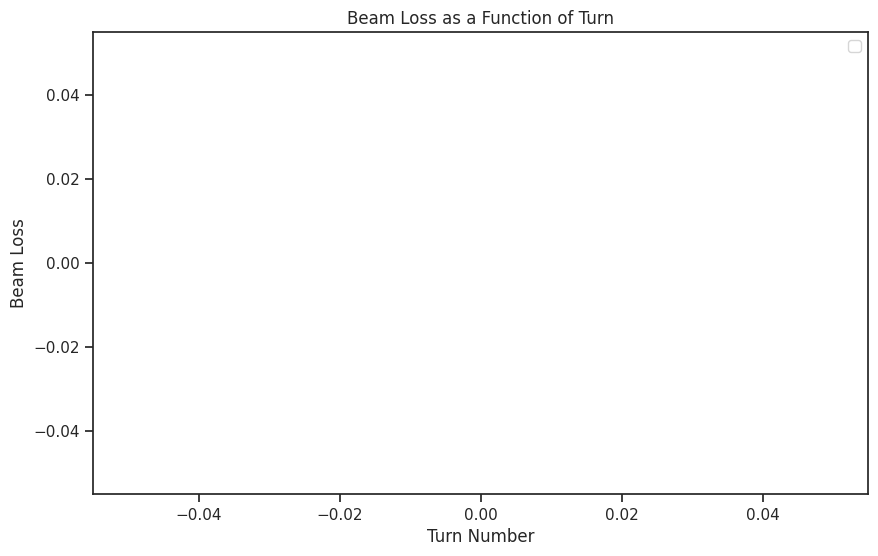

Number of survived particles for all turns (noise particles): [35000, 29343]
Initial number of particles (noise): 35000


In [27]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[::500]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])
df_copy = df_noise.copy()
beam_loss_noise = []
notlost = []

df_noise['notlost'] = -np.ones(len(df_noise))
for turn in turns:
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn)]
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    print(len(survived_particles_noise))

    df_copy.loc[survived_particles_noise.index, 'notlost'] = 1
    survived_particles_indices = survived_particles_noise.index 
   
    num_survived_noise.append(len(survived_particles_noise))
    filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.notlost != 1)]
    notlost.append(len(filtered_df))
    print(len(filtered_df))
    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [28]:
df_noise_turn

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn,notlost
2550000,-2.021520,1.422190,0.008702,-0.499731,-1.021919,-0.000172,1,501000,-1.0
2550001,-0.021843,-0.795171,0.008315,1.044296,0.091581,-0.004064,1,501000,-1.0
2550002,-0.077150,-2.179828,0.000480,-1.629784,-2.608621,-0.007454,1,501000,-1.0
2550003,-0.709123,-1.139468,0.000151,-0.024435,0.789116,-0.002186,1,501000,-1.0
2550004,0.559580,1.198885,0.009292,-1.564962,-0.444106,0.006589,1,501000,-1.0
...,...,...,...,...,...,...,...,...,...
27554995,-1.161286,0.730026,0.005644,-3.300872,0.402026,-0.006663,1,501000,-1.0
27554996,-0.764401,-1.537444,-0.001778,0.189718,-2.552176,0.004615,1,501000,-1.0
27554997,-0.845856,-1.127145,0.003467,0.906030,0.128229,-0.000050,1,501000,-1.0
27554998,-0.093713,-0.080615,-0.001707,-1.035342,1.184568,-0.010369,1,501000,-1.0


In [29]:
df_noise_turn.index

Index([ 2550000,  2550001,  2550002,  2550003,  2550004,  2550005,  2550006,
        2550007,  2550008,  2550009,
       ...
       27554990, 27554991, 27554992, 27554993, 27554994, 27554995, 27554996,
       27554997, 27554998, 27554999],
      dtype='int64', length=30000)

In [30]:
df_noise_turn.index - min(df_noise_turn.index)

Index([       0,        1,        2,        3,        4,        5,        6,
              7,        8,        9,
       ...
       25004990, 25004991, 25004992, 25004993, 25004994, 25004995, 25004996,
       25004997, 25004998, 25004999],
      dtype='int64', length=30000)

In [31]:
df_noise

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn,notlost
0,-1.144316,-1.074705,-0.000481,-0.259016,-1.978697,0.003254,1,1000,-1.0
1,0.323166,1.277661,0.001164,0.893692,1.903639,-0.007447,1,1000,-1.0
2,2.142066,-0.950982,-0.000144,0.894202,-0.981095,-0.000003,1,1000,-1.0
3,0.759986,0.165585,-0.001214,1.349004,-1.134824,-0.000442,1,1000,-1.0
4,0.605253,1.444025,0.004495,-0.478777,-1.080347,0.000098,1,1000,-1.0
...,...,...,...,...,...,...,...,...,...
30049995,2.949467,0.371240,0.006180,1.634629,-1.245475,0.006256,1,1000000,-1.0
30049996,-0.467185,-2.337187,-0.005019,-0.599350,1.907189,-0.000567,1,1000000,-1.0
30049997,1.227555,-0.962506,0.000203,-0.010433,0.610687,0.003426,1,1000000,-1.0
30049998,0.963856,-0.541291,0.005052,-0.540096,-0.952779,0.009281,1,1000000,-1.0


In [32]:
df_noise[df_noise.at_turn =10000]

SyntaxError: cannot assign to attribute here. Maybe you meant '==' instead of '='? (<ipython-input-32-8d755f0cbf78>, line 1)

In [33]:
df_noise[df_noise.at_turn ==10000].index

Index([   45000,    45001,    45002,    45003,    45004,    45005,    45006,
          45007,    45008,    45009,
       ...
       25099990, 25099991, 25099992, 25099993, 25099994, 25099995, 25099996,
       25099997, 25099998, 25099999],
      dtype='int64', length=35000)

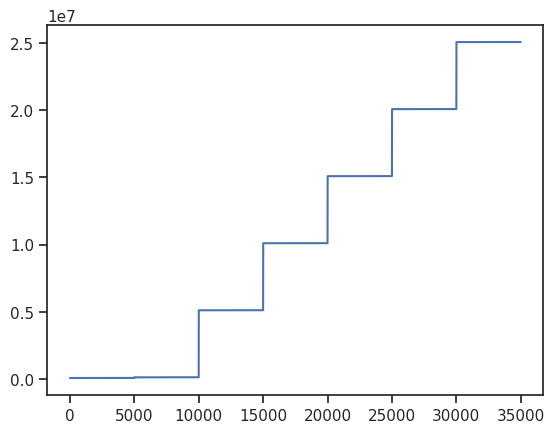

In [34]:
plt.plot(df_noise[df_noise.at_turn ==10000].index)

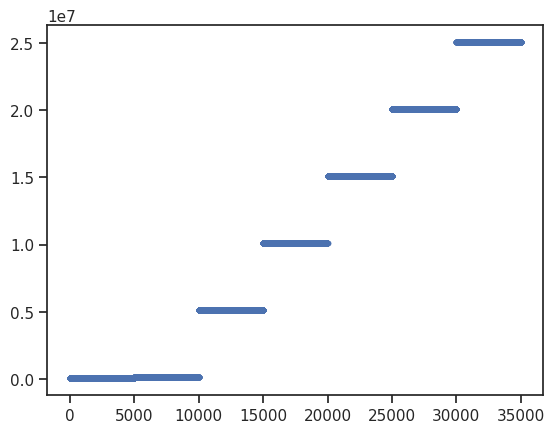

In [35]:
plt.plot(df_noise[df_noise.at_turn ==10000].index, '.')

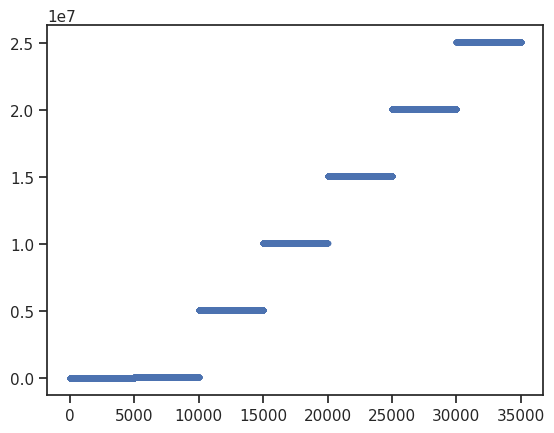

In [36]:
plt.plot(df_noise[df_noise.at_turn ==1000].index, '.')

In [37]:
df_all = pd.DataFrame()
for file in files:
    df = pd.read_parquet(file)
    df_all = pd.concat([df_all, df], ignore_index=True)

df_noise = pd.DataFrame()
for file in files_new:
    df = pd.read_parquet(file)
    df_noise = pd.concat([df_noise, df], ignore_index=True)

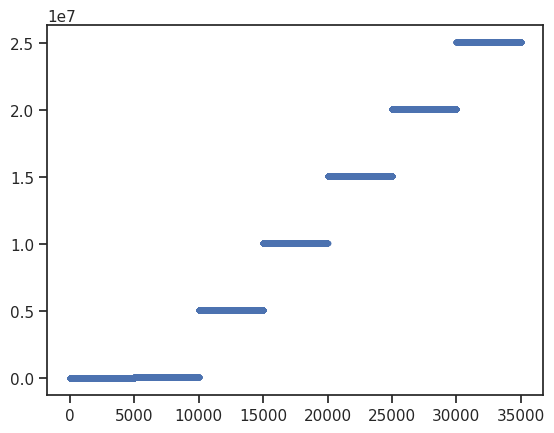

In [38]:
plt.plot(df_noise[df_noise.at_turn ==1000].index, '.')

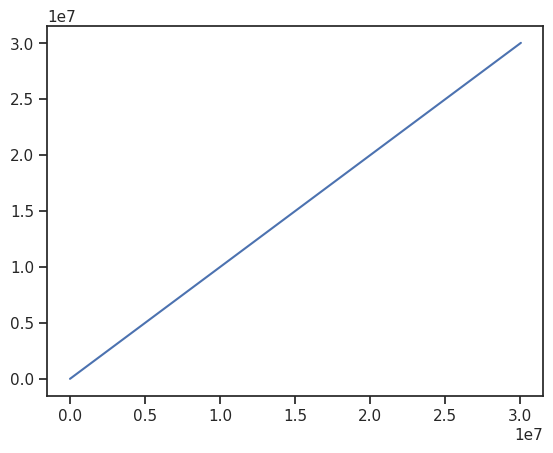

In [40]:
plt.plot(df_noise.index)

In [41]:
df_noise[df_noise.index<35000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
0,-1.144316,-1.074705,-0.000481,-0.259016,-1.978697,0.003254,1,1000
1,0.323166,1.277661,0.001164,0.893692,1.903639,-0.007447,1,1000
2,2.142066,-0.950982,-0.000144,0.894202,-0.981095,-0.000003,1,1000
3,0.759986,0.165585,-0.001214,1.349004,-1.134824,-0.000442,1,1000
4,0.605253,1.444025,0.004495,-0.478777,-1.080347,0.000098,1,1000
...,...,...,...,...,...,...,...,...
34995,0.790020,0.396880,0.002828,0.827140,-1.344044,0.003856,1,7000
34996,0.092534,1.460996,0.001826,1.783775,0.368812,0.002230,1,7000
34997,1.342055,-0.530785,-0.010477,0.889142,-1.888961,0.007060,1,7000
34998,-0.267276,-0.989128,0.001735,0.566761,2.011778,0.001986,1,7000


In [42]:
# Assuming df is your DataFrame
df_sorted = df_noise.sort_values(by='at_turn')


In [43]:
df_sorted[df_noise.index<35000]


,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
16,-1.525864,0.650588,-0.001624,0.703469,-0.298374,0.006840,1,1000
17,0.208894,0.653619,0.351423,1.171326,-0.862641,-0.010960,1,1000
18,-0.214140,1.046140,0.000562,-0.396704,0.332318,0.001711,1,1000
19,1.219533,0.093875,0.005320,0.744953,1.064999,-0.001032,1,1000
20,0.861668,0.896544,-0.004130,-0.342374,0.805612,0.001925,1,1000
...,...,...,...,...,...,...,...,...
44,1.535070,0.469826,-0.004279,0.615622,-0.056784,-0.002662,1,1000
45,0.084949,3.586812,-0.001595,0.758539,1.538391,-0.010383,1,1000
46,-0.016422,0.666144,0.000604,0.865200,-0.308647,-0.002423,1,1000
47,0.404352,1.590848,-0.005218,0.735205,-0.426710,-0.001502,1,1000


In [44]:
df_sorted_new =  df_sorted.reset_index(drop=True)

In [45]:
df_sorted_new[df_sorted_new.at_turn == 1000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
0,-1.525864,0.650588,-0.001624,0.703469,-0.298374,0.006840,1,1000
1,0.208894,0.653619,0.351423,1.171326,-0.862641,-0.010960,1,1000
2,-0.214140,1.046140,0.000562,-0.396704,0.332318,0.001711,1,1000
3,1.219533,0.093875,0.005320,0.744953,1.064999,-0.001032,1,1000
4,0.861668,0.896544,-0.004130,-0.342374,0.805612,0.001925,1,1000
...,...,...,...,...,...,...,...,...
34995,1.535070,0.469826,-0.004279,0.615622,-0.056784,-0.002662,1,1000
34996,0.084949,3.586812,-0.001595,0.758539,1.538391,-0.010383,1,1000
34997,-0.016422,0.666144,0.000604,0.865200,-0.308647,-0.002423,1,1000
34998,0.404352,1.590848,-0.005218,0.735205,-0.426710,-0.001502,1,1000


In [46]:
df_sorted_new[df_sorted_new.at_turn == 10000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
315000,-0.559007,-0.281419,-0.008974,1.178585,0.509323,-0.003296,1,10000
315001,1.212673,-1.390063,0.000903,0.543177,-1.490216,0.003154,1,10000
315002,0.283552,-0.955190,0.000516,-1.085060,0.677051,-0.000835,1,10000
315003,-1.995846,-0.953361,0.001452,0.213368,-0.537231,-0.001757,1,10000
315004,-0.803886,-1.050129,-0.003309,-1.070351,-0.743654,-0.008567,1,10000
...,...,...,...,...,...,...,...,...
349995,1.916431,0.997854,-0.005396,-1.229748,-0.552910,0.003401,1,10000
349996,2.063274,-0.789400,-0.002175,0.609707,-1.105570,-0.007756,1,10000
349997,0.991562,-0.722998,0.008431,-0.969767,0.768099,0.001070,1,10000
349998,1.023911,0.681736,0.003797,-1.376557,0.865765,0.001794,1,10000


Restarted miniforge (Python 3.10.13)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import json
import logging
import os
import time

# Import third-party modules
import numpy as np
import pandas as pd
import ruamel.yaml
import tree_maker

# Import user-defined modules

import xmask as xm

import xobjects as xo
import xtrack as xt
import matplotlib.ticker as ticker
sns.set_theme(style="ticks")

/afs/cern.ch/work/a/aradosla/private/example_DA_study_mine/miniforge/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_quad_300_12e-6/**/*norm.parquet')
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/part*.parquet')
files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/**/*norm.parquet')
files_new = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_no_noise/**/*norm.parquet')

In [3]:
df_all = pd.DataFrame()
for file in files:
    df = pd.read_parquet(file)
    df_all = pd.concat([df_all, df], ignore_index=True)

df_noise = pd.DataFrame()
for file in files_new:
    df = pd.read_parquet(file)
    df_noise = pd.concat([df_noise, df], ignore_index=True)

df_noise.sort_values(by=['at_turn'])
df_noise = df_noise.reset_index(drop=True)

In [6]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[::500]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])
df_copy = df_noise.copy()
beam_loss_noise = []
notlost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in turns[i:]:
        df_copy.loc[lost_particles_noise.index*turn_new, 'lost'] = -1
    survived_particles_indices = survived_particles_noise.index 
    
    num_survived_noise.append(len(survived_particles_noise))
    filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.notlost != 1)]
    notlost.append(len(filtered_df))
    print(len(filtered_df))
    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

35000


AttributeError: 'DataFrame' object has no attribute 'notlost'

In [8]:
lost_particles_noise

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn,lost
2550013,-13.823442,-49.992742,210.962683,-51.367785,-2.000391,2.395794,1,501000,1.0
2550022,10.365032,44.283034,-187.195779,46.190985,2.753186,-2.128666,1,501000,1.0
2550176,9.514706,33.357125,-136.951342,31.767761,0.707589,-1.551676,1,501000,1.0
2550239,-10.230771,-37.031140,153.204245,-38.077459,-1.901681,1.736759,1,501000,1.0
2550243,-5.456265,-21.231149,91.438275,-21.269239,0.419227,1.036055,1,501000,1.0
...,...,...,...,...,...,...,...,...,...
27554830,8.762382,33.784670,-142.370916,34.095169,1.232329,-1.620332,1,501000,1.0
27554870,6.426205,24.728214,-101.763347,23.859942,0.377416,-1.148665,1,501000,1.0
27554873,7.748241,25.585207,-109.995045,27.575617,0.505209,-1.244255,1,501000,1.0
27554912,-9.355705,-35.878459,152.411393,-37.368223,-3.319277,1.734847,1,501000,1.0


In [14]:
df_all = pd.DataFrame()
for file in files:
    df = pd.read_parquet(file)
    df_all = pd.concat([df_all, df], ignore_index=True)

df_noise = pd.DataFrame()
for file in files_new:
    df = pd.read_parquet(file)
    df_noise = pd.concat([df_noise, df], ignore_index=True)

df_noise.sort_values(by=['at_turn'])
df_noise = df_noise.reset_index(drop=True)

In [17]:
df_all = pd.DataFrame()
for file in files:
    df = pd.read_parquet(file)
    df_all = pd.concat([df_all, df], ignore_index=True)

df_noise = pd.DataFrame()
for file in files_new:
    df = pd.read_parquet(file)
    df_noise = pd.concat([df_noise, df], ignore_index=True)

df_noise_sorted = df_noise.sort_values(by=['at_turn'])
df_noise_new= df_noise_sorted.reset_index(drop=True)

In [18]:
df_noise_new

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
0,-1.525864,0.650588,-0.001624,0.703469,-0.298374,0.006840,1,1000
1,0.208894,0.653619,0.351423,1.171326,-0.862641,-0.010960,1,1000
2,-0.214140,1.046140,0.000562,-0.396704,0.332318,0.001711,1,1000
3,1.219533,0.093875,0.005320,0.744953,1.064999,-0.001032,1,1000
4,0.861668,0.896544,-0.004130,-0.342374,0.805612,0.001925,1,1000
...,...,...,...,...,...,...,...,...
30049995,-1.254180,0.167139,0.004948,0.289445,0.086468,-0.006776,1,1000000
30049996,1.446842,0.006468,0.001061,-0.510602,0.365037,-0.006614,1,1000000
30049997,-0.183660,0.801960,-0.005983,-0.608263,-0.888419,-0.001950,1,1000000
30049998,-0.020977,-0.555496,-0.004480,-0.006956,-1.270158,0.003102,1,1000000


In [20]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[::500]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])
df_copy = df_noise_new.copy()
beam_loss_noise = []
notlost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in turns[i:]:
        df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise))*turn_new, 'lost'] = -1
    survived_particles_indices = survived_particles_noise.index 
    
    num_survived_noise.append(len(survived_particles_noise))
    filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]
    notlost.append(len(filtered_df))
    print(len(filtered_df))
    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

35000


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('int64'), dtype('<U7')) -> None

In [21]:
(lost_particles_noise.index - min(lost_particles_noise))

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('int64'), dtype('<U7')) -> None

In [22]:
(lost_particles_noise.index

SyntaxError: incomplete input (<ipython-input-22-cda971f3bb55>, line 1)

35000
0
29478
0
29341
0
29342
0
29342
0
29343
0
29344
0
29347
0
29346
0
29343


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0


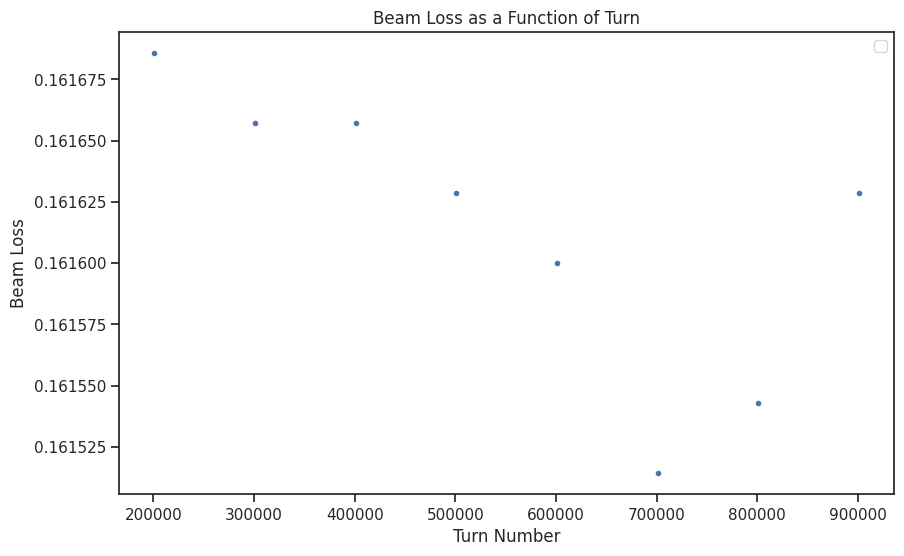

Number of survived particles for all turns (noise particles): [35000, 29478, 29341, 29342, 29342, 29343, 29344, 29347, 29346, 29343]
Initial number of particles (noise): 35000


In [25]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[::100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])
df_copy = df_noise_new.copy()
beam_loss_noise = []
notlost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in turns[i:]:
        try:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise))*turn_new, 'lost'] = -1
        except:
            continue
    survived_particles_indices = survived_particles_noise.index 
    
    num_survived_noise.append(len(survived_particles_noise))
    filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]
    notlost.append(len(filtered_df))
    print(len(filtered_df))
    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [26]:
df_copy

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn,lost
0,-1.525864,0.650588,-0.001624,0.703469,-0.298374,0.006840,1,1000,1.0
1,0.208894,0.653619,0.351423,1.171326,-0.862641,-0.010960,1,1000,1.0
2,-0.214140,1.046140,0.000562,-0.396704,0.332318,0.001711,1,1000,1.0
3,1.219533,0.093875,0.005320,0.744953,1.064999,-0.001032,1,1000,1.0
4,0.861668,0.896544,-0.004130,-0.342374,0.805612,0.001925,1,1000,1.0
...,...,...,...,...,...,...,...,...,...
30049995,-1.254180,0.167139,0.004948,0.289445,0.086468,-0.006776,1,1000000,1.0
30049996,1.446842,0.006468,0.001061,-0.510602,0.365037,-0.006614,1,1000000,1.0
30049997,-0.183660,0.801960,-0.005983,-0.608263,-0.888419,-0.001950,1,1000000,1.0
30049998,-0.020977,-0.555496,-0.004480,-0.006956,-1.270158,0.003102,1,1000000,1.0


In [27]:
df_copy['lost']

0           1.0
1           1.0
2           1.0
3           1.0
4           1.0
           ... 
30049995    1.0
30049996    1.0
30049997    1.0
30049998    1.0
30049999    1.0
Name: lost, Length: 30050000, dtype: float64

In [28]:
df_copy['lost'] ==-1

0           False
1           False
2           False
3           False
4           False
            ...  
30049995    False
30049996    False
30049997    False
30049998    False
30049999    False
Name: lost, Length: 30050000, dtype: bool

In [29]:
print(df_copy[df_copy['lost'] ==-1].index)

Index([], dtype='int64')


In [30]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[::100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])
df_copy = df_noise_new.copy()
beam_loss_noise = []
notlost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in turns[i:]:
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise))*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    
    num_survived_noise.append(len(survived_particles_noise))
    filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]
    notlost.append(len(filtered_df))
    print(len(filtered_df))
    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

35000
0
29478


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('int64'), dtype('<U7')) -> None

In [36]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[::100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])
df_copy = df_noise_new.copy()
beam_loss_noise = []
notlost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in turns[i:]:
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index))*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    
    num_survived_noise.append(len(survived_particles_noise))
    filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]
    notlost.append(len(filtered_df))
    print(len(filtered_df))
    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

35000
0
29478


KeyError: '[34643000, 40400000, 42218000, 49894000, 51106000, 74437000, 88981000, 94435000, 98475000, 108575000, 112211000, 131098000, 131199000, 134835000, 144834000, 152813000, 157156000, 162812000, 171902000, 177053000, 203818000, 223614000, 233714000, 246339000, 253813000, 253914000, 257348000, 259368000, 263408000, 264620000, 270680000, 272296000, 279366000, 288355000, 289365000, 293506000, 301384000, 303101000, 306131000, 312898000, 314110000, 323806000, 326533000, 327038000, 333704000, 346430000, 348955000, 351783000, 363701000, 372589000, 390466000, 397637000, 409454000, 410464000, 421271000, 432381000, 433896000, 435209000, 439350000, 440764000, 455005000, 463994000, 465004000, 468034000, 479649000, 480659000, 480760000, 491365000, 492476000, 493183000, 493890000, 507929000, 515908000, 518433000, 521463000, 527220000, 533381000, 546006000, 553682000, 570650000, 572468000, 574690000, 575397000, 576710000, 577114000, 585800000, 586911000, 594587000, 602667000, 602970000, 604182000, 606808000, 609333000, 615191000, 616807000, 617009000, 628422000, 632563000, 632664000, 633472000, 633775000, 635088000, 637613000, 640340000, 641350000, 641855000, 647814000, 651450000, 663166000, 666903000, 672357000, 672660000, 678316000, 683164000, 686800000, 690739000, 697607000, 713767000, 717201000, 721948000, 731543000, 744168000, 746592000, 746895000, 749117000, 750430000, 751137000, 754167000, 760227000, 768206000, 774973000, 778407000, 780225000, 786083000, 796890000, 798708000, 800122000, 805273000, 807495000, 811333000, 813858000, 822847000, 825675000, 837290000, 841229000, 845471000, 846885000, 851632000, 852541000, 857995000, 862843000, 864459000, 883649000, 887184000, 897284000, 902435000, 904051000, 906576000, 910717000, 919504000, 923241000, 926776000, 928897000, 938694000, 944653000, 950006000, 950612000, 951319000, 966166000, 970610000, 973337000, 1002324000, 1013939000, 1016060000, 1026463000, 1041007000, 1041310000, 1043229000, 1052218000, 1055349000, 1069590000, 1070095000, 1073832000, 1079589000, 1083124000, 1097567000, 1098880000, 1112616000, 1121908000, 1127261000, 1130190000, 1131099000, 1140088000, 1146653000, 1149380000, 1151703000, 1154430000, 1156652000, 1157258000, 1159682000, 1168368000, 1179680000, 1183922000, 1185134000, 1187457000, 1194628000, 1194830000, 1199173000, 1204829000, 1207354000, 1211798000, 1214424000, 1223413000, 1228059000, 1238664000, 1240886000, 1240987000, 1241896000, 1247855000, 1251996000, 1256541000, 1261995000, 1269873000, 1275933000, 1277448000, 1296537000, 1299062000, 1300678000, 1303910000, 1304617000, 1309364000, 1313808000, 1313909000, 1314111000, 1318757000, 1322696000, 1336230000, 1340270000, 1345926000, 1348956000, 1353097000, 1353602000, 1354410000, 1387437000, 1393093000, 1399153000, 1401577000, 1408546000, 1437836000, 1441169000, 1447431000, 1456319000, 1459046000, 1460359000, 1461470000, 1470661000, 1471469000, 1480256000, 1480357000, 1481064000, 1493285000, 1496113000, 1502274000, 1513889000, 1514697000, 1517626000, 1518939000, 1519848000, 1520050000, 1528837000, 1532978000, 1544290000, 1550249000, 1556814000, 1558329000, 1565096000, 1567318000, 1567924000, 1569136000, 1574489000, 1575499000, 1576711000, 1580044000, 1582872000, 1585902000, 1590447000, 1596810000, 1603173000, 1605799000, 1611152000, 1619030000, 1625090000, 1625292000, 1632362000, 1644078000, 1651350000, 1678721000, 1691649000, 1694275000, 1698214000, 1702557000, 1702961000, 1711041000, 1720030000, 1728918000, 1733160000, 1738816000, 1743664000, 1747805000, 1753966000, 1756794000, 1756895000, 1764066000, 1766793000, 1766894000, 1770934000, 1779014000, 1792952000, 1795376000, 1804264000, 1804668000, 1806587000, 1809314000, 1814364000, 1824363000, 1834261000, 1840927000, 1860319000, 1861632000, 1887286000, 1889407000, 1915162000, 1919808000, 1923747000, 1930413000, 1930514000, 1940210000, 1944351000, 1944755000, 1947886000, 1952229000, 1954855000, 1971924000, 1973237000, 1975661000, 1980105000, 1985357000, 1992023000, 1992730000, 1994043000, 1995962000, 2003436000, 2005961000, 2012324000, 2013536000, 2023434000, 2052320000, 2059289000, 2072520000, 2072621000, 2099891000, 2100699000, 2104133000, 2110698000, 2122616000, 2136049000, 2137766000, 2139281000, 2140998000, 2160693000, 2160794000, 2164834000, 2181701000, 2186953000, 2191296000, 2193417000, 2199073000, 2199477000, 2209779000, 2216950000, 2228969000, 2233110000, 2246341000, 2246442000, 2251795000, 2255936000, 2256744000, 2260986000, 2272197000, 2282802000, 2283711000, 2287145000, 2291993000, 2301891000, 2304113000, 2304416000, 2317546000, 2320071000, 2321586000, 2324818000, 2326030000, 2337241000, 2338958000, 2342796000, 2347442000, 2351583000, 2354108000, 2360471000, 2362693000, 2369965000, 2370874000, 2377136000, 2378752000, 2395417000, 2398750000, 2411375000, 2413698000, 2418243000, 2428343000, 2429353000, 2438746000, 2444200000, 2446119000, 2450664000, 2456017000, 2456522000, 2457936000, 2465511000, 2466723000, 2469753000, 2471268000, 2481570000, 2488842000, 2491064000, 2493589000, 2505709000, 2515910000, 2520051000, 2521768000, 2526919000, 2535504000, 2558431000, 2564289000, 2569036000, 2574793000, 2577520000, 2582267000, 2585802000, 2594791000, 2595397000, 2613577000, 2614587000, 2616304000, 2619940000, 2632767000, 2641655000, 2655189000, 2655997000, 2680136000, 2680540000, 2684176000, 2689125000, 2689529000, 2690034000, 2691145000, 2699629000, 2714476000, 2743362000, 2753462000, 2754876000, 2759825000, 2762047000, 2775884000, 2777096000, 2779924000, 2780429000, 2798306000, 2810628000, 2811133000, 2813557000, 2819819000, 2822647000, 2832545000, 2840726000, 2841534000, 2845574000, 2851735000, 2856785000, 2859007000, 2861936000, 2862744000, 2864259000, 2871026000, 2879409000, 2879611000, 2900215000, 2905972000, 2912234000, 2914052000, 2918496000, 2923647000, 2927990000, 2941625000, 2941827000, 2943645000, 2947180000, 2964148000, 2967178000, 2968289000, 3002730000, 3004447000, 3005861000, 3006871000, 3013234000, 3014345000] not in index'

In [37]:
df_copy[df_copy.at_turn ==1000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn,lost
0,-1.525864,0.650588,-0.001624,0.703469,-0.298374,0.006840,1,1000,1.0
1,0.208894,0.653619,0.351423,1.171326,-0.862641,-0.010960,1,1000,1.0
2,-0.214140,1.046140,0.000562,-0.396704,0.332318,0.001711,1,1000,1.0
3,1.219533,0.093875,0.005320,0.744953,1.064999,-0.001032,1,1000,1.0
4,0.861668,0.896544,-0.004130,-0.342374,0.805612,0.001925,1,1000,1.0
...,...,...,...,...,...,...,...,...,...
34995,1.535070,0.469826,-0.004279,0.615622,-0.056784,-0.002662,1,1000,1.0
34996,0.084949,3.586812,-0.001595,0.758539,1.538391,-0.010383,1,1000,1.0
34997,-0.016422,0.666144,0.000604,0.865200,-0.308647,-0.002423,1,1000,1.0
34998,0.404352,1.590848,-0.005218,0.735205,-0.426710,-0.001502,1,1000,1.0


In [38]:
df_copy[df_copy.at_turn ==1000].index - min(df_copy[df_copy.at_turn ==1000])

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('int64'), dtype('<U7')) -> None

In [39]:
df_copy[df_copy.at_turn ==1000].index - min(df_copy[df_copy.at_turn ==1000].index)

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       34990, 34991, 34992, 34993, 34994, 34995, 34996, 34997, 34998, 34999],
      dtype='int64', length=35000)

In [40]:
df_copy[df_copy.at_turn ==10000].index - min(df_copy[df_copy.at_turn ==10000].index)

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       34990, 34991, 34992, 34993, 34994, 34995, 34996, 34997, 34998, 34999],
      dtype='int64', length=35000)

In [41]:
 np.arange(i, len(turns))

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [42]:
 np.arange(4, len(turns))

array([4, 5, 6, 7, 8, 9])

35000
0
1
2
3
4
5
6
7
8
9
10
0
29478
1
2
3
4
5
6
7
8
9
10
0
29341
2
3
4
5
6
7
8
9
10
0
29342
3
4
5
6
7
8
9
10
0
29342
4
5
6
7
8
9
10
0
29343
5
6
7
8
9
10
0
29344
6
7
8
9
10
0
29347
7
8
9
10
0
29346
8
9
10
0
29343
9
10
0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


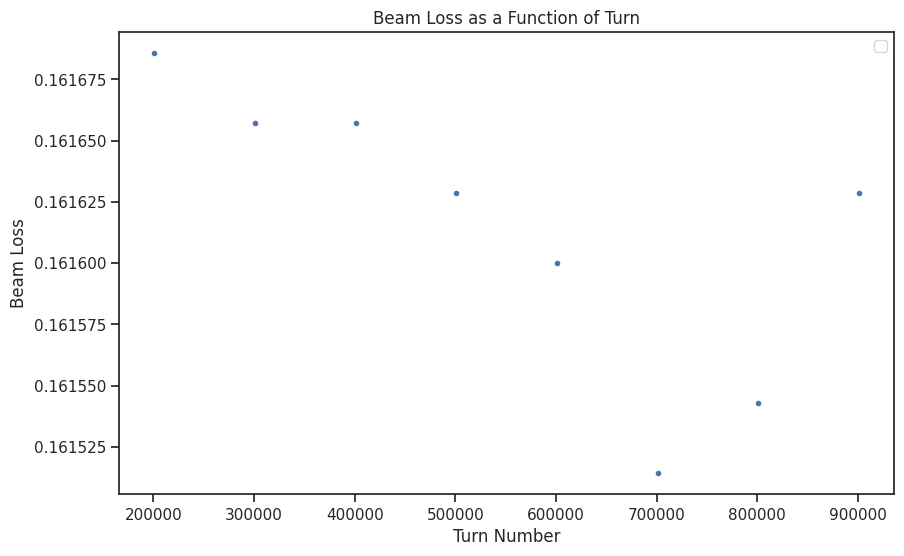

Number of survived particles for all turns (noise particles): [35000, 29478, 29341, 29342, 29342, 29343, 29344, 29347, 29346, 29343]
Initial number of particles (noise): 35000


In [43]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[::100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])
df_copy = df_noise_new.copy()
beam_loss_noise = []
notlost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i, len(turns)+1):
        print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index))*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    
    num_survived_noise.append(len(survived_particles_noise))
    filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]
    notlost.append(len(filtered_df))
    print(len(filtered_df))
    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [44]:
df_copy['lost']

0          -1.0
1           1.0
2           1.0
3           1.0
4           1.0
           ... 
30049995    1.0
30049996    1.0
30049997    1.0
30049998    1.0
30049999    1.0
Name: lost, Length: 30050000, dtype: float64

In [45]:
df_copy['lost'][:100000]

0       -1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
99995    1.0
99996   -1.0
99997    1.0
99998    1.0
99999    1.0
Name: lost, Length: 100000, dtype: float64

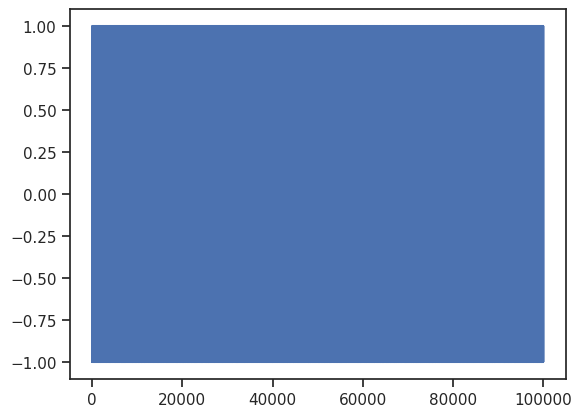

In [46]:
plt.plot(df_copy['lost'][:100000])

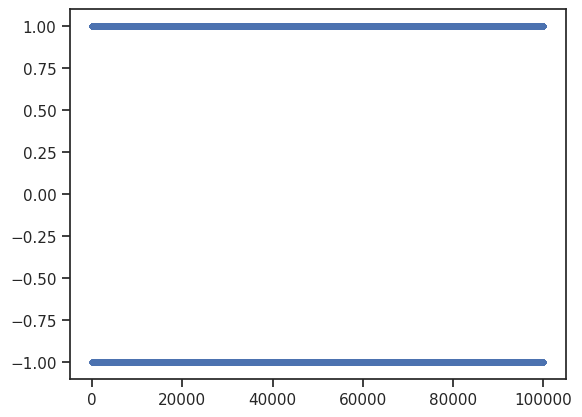

In [47]:
plt.plot(df_copy['lost'][:100000], '.')

In [48]:
print(df_copy[df_copy.index == df_copy.index%35000['lost'])

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (<ipython-input-48-52a7816894ec>, line 1)

In [49]:
print(df_copy[df_copy.index == df_copy.index%35000]['lost'])

0       -1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
34995    1.0
34996   -1.0
34997    1.0
34998    1.0
34999    1.0
Name: lost, Length: 35000, dtype: float64


35000
0
1
2
3
4
5
6
7
8
9
10
29478
1
2
3
4
5
6
7
8
9
10
29341
2
3
4
5
6
7
8
9
10
29342
3
4
5
6
7
8
9
10
29342
4
5
6
7
8
9
10
29343
5
6
7
8
9
10
29344
6
7
8
9
10
29347
7
8
9
10
29346
8
9
10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


29343
9
10


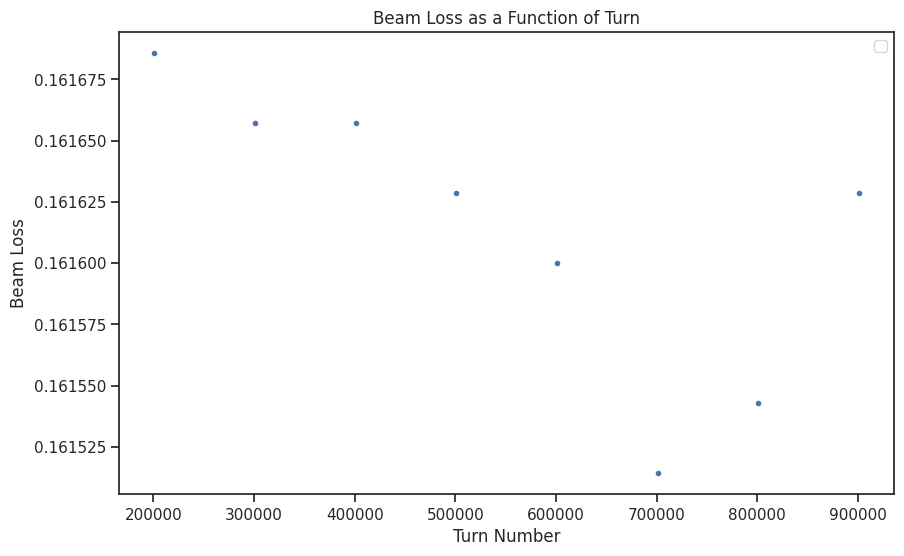

Number of survived particles for all turns (noise particles): [35000, 29478, 29341, 29342, 29342, 29343, 29344, 29347, 29346, 29343]
Initial number of particles (noise): 35000


In [50]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[::100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])
df_copy = df_noise_new.copy()
beam_loss_noise = []
notlost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i, len(turns)+1):
        print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index))*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    
    num_survived_noise.append(len(survived_particles_noise))
    filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]
    notlost.append(len(filtered_df))
    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [51]:
print(df_copy[df_copy.index == df_copy.index%34996]['lost'])

0       -1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
34991    1.0
34992   -1.0
34993    1.0
34994    1.0
34995    1.0
Name: lost, Length: 34996, dtype: float64


In [52]:
print(df_copy[df_copy.index == df_copy.index+34996%35000]['lost'])

Series([], Name: lost, dtype: float64)


In [53]:
print(df_copy[df_copy.index == (df_copy.index)+34996%35000]['lost'])

Series([], Name: lost, dtype: float64)


In [54]:
print(df_copy[df_copy.index == (df_copy.index+34996)%35000]['lost'])

Series([], Name: lost, dtype: float64)


In [56]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[::100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
notlost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i, len(turns)+1):
        print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index))*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    
    num_survived_noise.append(len(survived_particles_noise))
    filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]
    notlost.append(len(filtered_df))
    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

35000
0
1
2
3
4
5
6
7
8
9
10
29478
1


KeyError: '[0] not in index'

In [57]:
df_copy

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn,lost
1,-1.525864,0.650588,-0.001624,0.703469,-0.298374,0.006840,1,1000,1.0
2,0.208894,0.653619,0.351423,1.171326,-0.862641,-0.010960,1,1000,1.0
3,-0.214140,1.046140,0.000562,-0.396704,0.332318,0.001711,1,1000,1.0
4,1.219533,0.093875,0.005320,0.744953,1.064999,-0.001032,1,1000,1.0
5,0.861668,0.896544,-0.004130,-0.342374,0.805612,0.001925,1,1000,1.0
...,...,...,...,...,...,...,...,...,...
30049996,-1.254180,0.167139,0.004948,0.289445,0.086468,-0.006776,1,1000000,1.0
30049997,1.446842,0.006468,0.001061,-0.510602,0.365037,-0.006614,1,1000000,1.0
30049998,-0.183660,0.801960,-0.005983,-0.608263,-0.888419,-0.001950,1,1000000,1.0
30049999,-0.020977,-0.555496,-0.004480,-0.006956,-1.270158,0.003102,1,1000000,1.0


In [59]:
(lost_particles_noise.index - min(lost_particles_noise.index))

Index([    0,    52,   125,   186,   205,   229,   235,   343,   400,   418,
       ...
       29180, 29348, 29378, 29389, 29730, 29747, 29761, 29771, 29834, 29845],
      dtype='int64', length=522)

35000
0
1
2
3
4
5
6
7
8
9
10
29478
1
2
3
4
5
6
7
8
9
10
29341
2
3
4
5
6
7
8
9
10
29342
3
4
5
6
7
8
9
10
29342
4
5
6
7
8
9
10
29343
5
6
7
8
9
10
29344
6
7
8
9
10
29347
7
8
9
10
29346
8
9
10
29343
9
10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


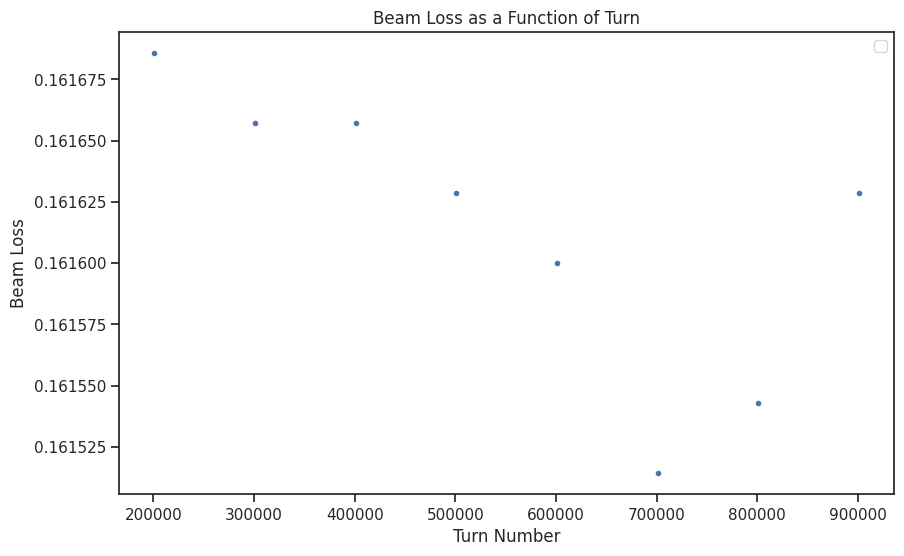

Number of survived particles for all turns (noise particles): [35000, 29478, 29341, 29342, 29342, 29343, 29344, 29347, 29346, 29343]
Initial number of particles (noise): 35000


In [60]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[::100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
notlost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i, len(turns)+1):
        print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    
    num_survived_noise.append(len(survived_particles_noise))
    filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]
    notlost.append(len(filtered_df))
    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

35000
29478
29341
29342
29342
29343
29344
29347
29346
29343


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


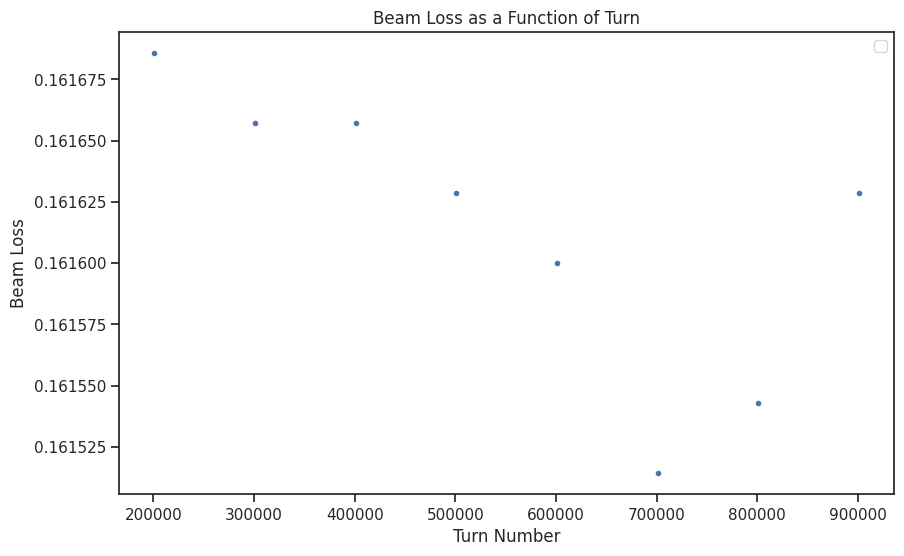

Number of survived particles for all turns (noise particles): [35000, 29478, 29341, 29342, 29342, 29343, 29344, 29347, 29346, 29343]
Initial number of particles (noise): 35000


In [61]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[::100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
notlost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    if len(lost_particles_noise) > 0:
        for turn_new in turns[i:]:
            # Use boolean indexing to mark lost particles
            df_copy.loc[(df_copy.at_turn == turn_new) & (df_copy.index.isin(lost_particles_noise.index)), 'lost'] = -1
    
    survived_particles_indices = survived_particles_noise.index 
    
    num_survived_noise.append(len(survived_particles_noise))
    filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]
    notlost.append(len(filtered_df))
    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [66]:
lost_particles_noise.index - min(lost_particles_noise.index)+1

Index([    1,    19,    26,    30,   382,   390,   395,   458,   503,   506,
       ...
       29608, 29640, 29644, 29750, 29778, 29802, 29803, 29848, 29876, 29902],
      dtype='int64', length=657)

In [67]:
len(lost_particles_noise.index - min(lost_particles_noise.index)+1)

657

Restarted miniforge (Python 3.10.13)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import json
import logging
import os
import time

# Import third-party modules
import numpy as np
import pandas as pd
import ruamel.yaml
import tree_maker

# Import user-defined modules

import xmask as xm

import xobjects as xo
import xtrack as xt
import matplotlib.ticker as ticker
sns.set_theme(style="ticks")

In [5]:
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_quad_300_12e-6/**/*norm.parquet')
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/part*.parquet')
files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/**/*norm.parquet')
files_new = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_no_noise/**/*norm.parquet')

In [6]:
df_all = pd.DataFrame()
for file in files:
    df = pd.read_parquet(file)
    df_all = pd.concat([df_all, df], ignore_index=True)

df_noise = pd.DataFrame()
for file in files_new:
    df = pd.read_parquet(file)
    df_noise = pd.concat([df_noise, df], ignore_index=True)

df_noise_sorted = df_noise.sort_values(by=['at_turn'])
df_noise_new= df_noise_sorted.reset_index(drop=True)

35000
0
1
2
3
4
5
6
7
8
9
10
29478
1
2
3
4
5
6
7
8
9
10
29341
2
3
4
5
6
7
8
9
10
29342
3
4
5
6
7
8
9
10
29342
4
5
6
7
8
9
10
29343
5
6
7
8
9
10
29344
6
7
8
9
10
29347
7
8
9
10
29346
8
9
10
29343
9
10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


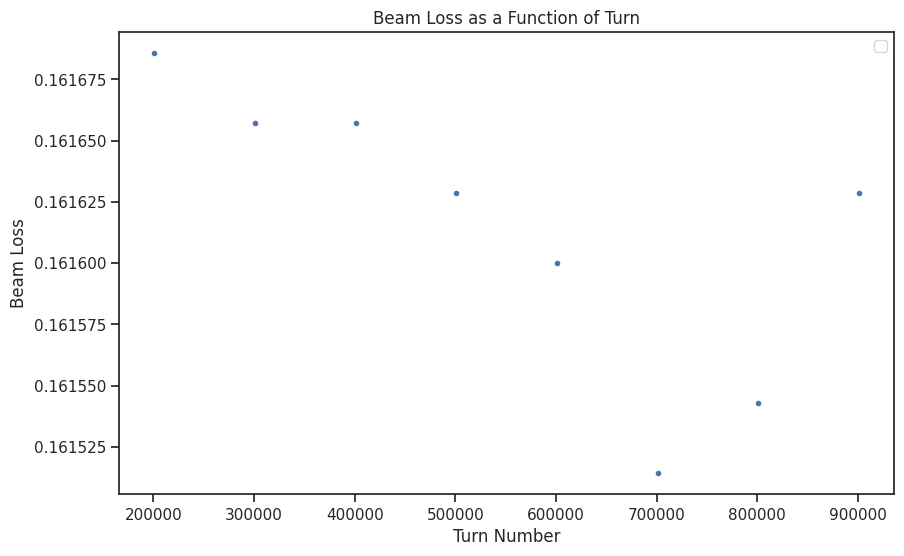

Number of survived particles for all turns (noise particles): [35000, 29478, 29341, 29342, 29342, 29343, 29344, 29347, 29346, 29343]
Initial number of particles (noise): 35000


In [7]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[::100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i, len(turns)+1):
        print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [8]:
lost

[0, 522, 659, 658, 658, 657, 656, 653, 654, 657]

In [9]:
df_copy['lost'][:35000]

1       -1.0
2       -1.0
3       -1.0
4       -1.0
5       -1.0
        ... 
34996    1.0
34997    1.0
34998    1.0
34999    1.0
35000   -1.0
Name: lost, Length: 35000, dtype: float64

In [10]:
df_copy['lost'][1::35000]

2          -1.0
35002       1.0
70002       1.0
105002      1.0
140002      1.0
           ... 
29890002    1.0
29925002    1.0
29960002    1.0
29995002    1.0
30030002    1.0
Name: lost, Length: 859, dtype: float64

Restarted miniforge (Python 3.10.13)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import json
import logging
import os
import time

# Import third-party modules
import numpy as np
import pandas as pd
import ruamel.yaml
import tree_maker

# Import user-defined modules

import xmask as xm

import xobjects as xo
import xtrack as xt
import matplotlib.ticker as ticker
sns.set_theme(style="ticks")

/afs/cern.ch/work/a/aradosla/private/example_DA_study_mine/miniforge/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_quad_300_12e-6/**/*norm.parquet')
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/part*.parquet')
files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/**/*norm.parquet')
files_new = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_no_noise/**/*norm.parquet')

In [ ]:
df_all = pd.DataFrame()
for file in files:
    df = pd.read_parquet(file)
    df_all = pd.concat([df_all, df], ignore_index=True)

df_noise = pd.DataFrame()
for file in files_new:
    df = pd.read_parquet(file)
    df_noise = pd.concat([df_noise, df], ignore_index=True)

df_noise_sorted = df_noise.sort_values(by=['at_turn'])
df_noise_new= df_noise_sorted.reset_index(drop=True)

In [5]:
df_all = pd.DataFrame()
for file in files:
    df = pd.read_parquet(file)
    df_all = pd.concat([df_all, df], ignore_index=True)

df_noise = pd.DataFrame()
for file in files_new:
    df = pd.read_parquet(file)
    df_noise = pd.concat([df_noise, df], ignore_index=True)

df_noise_sorted = df_noise.sort_values(by=['at_turn'])
df_noise_new= df_noise_sorted.reset_index(drop=True)

35000
0
1
2
3
4
5
6
7
8
9
10
29478
1
2
3
4
5
6
7
8
9
10
29341
2
3
4
5
6
7
8
9
10
29342
3
4
5
6
7
8
9
10
29342
4
5
6
7
8
9
10
29343
5
6
7
8
9
10
29344
6
7
8
9
10
29347
7
8
9
10
29346
8
9
10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


29343
9
10


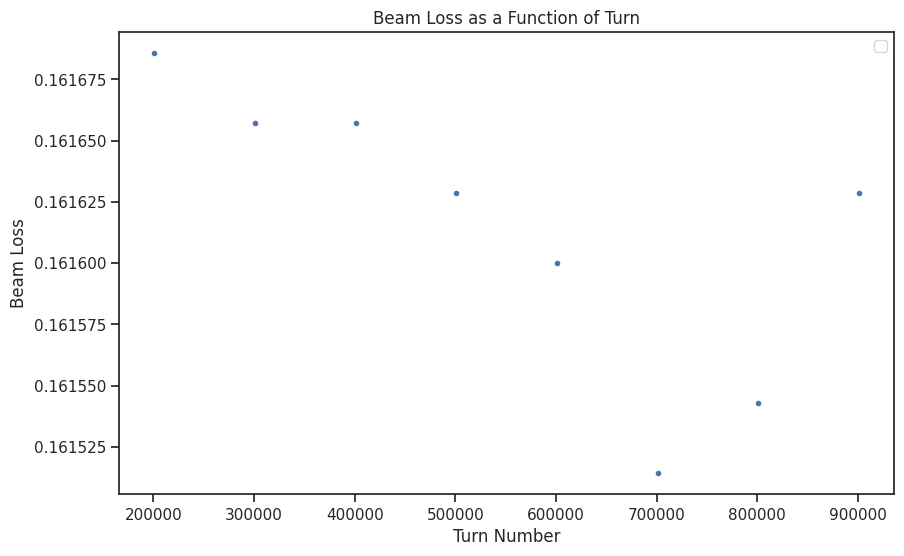

Number of survived particles for all turns (noise particles): [35000, 29478, 29341, 29342, 29342, 29343, 29344, 29347, 29346, 29343]
Initial number of particles (noise): 35000


In [6]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[::100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise_new.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i, len(turns)+1):
        print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    #filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [8]:

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)][:1000]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i, len(turns)+1):
        #print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)*turn_new, 'lost'] = -1
        

1000
985
973
980
981
978
982
977
975
982


In [9]:

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)][:1000]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i, len(turns)+1):
        #print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy = df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)*turn_new, 'lost'] = -1
        

1000
985


AttributeError: 'int' object has no attribute 'loc'

35000
0
1
2
3
4
5
6
7
8
9
10
29478
1
2
3
4
5
6
7
8
9
10
29341
2
3
4
5
6
7
8
9
10
29342
3
4
5
6
7
8
9
10
29342
4
5
6
7
8
9
10
29343
5
6
7
8
9
10
29344
6
7
8
9
10
29347
7
8
9
10
29346
8
9
10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


29343
9
10


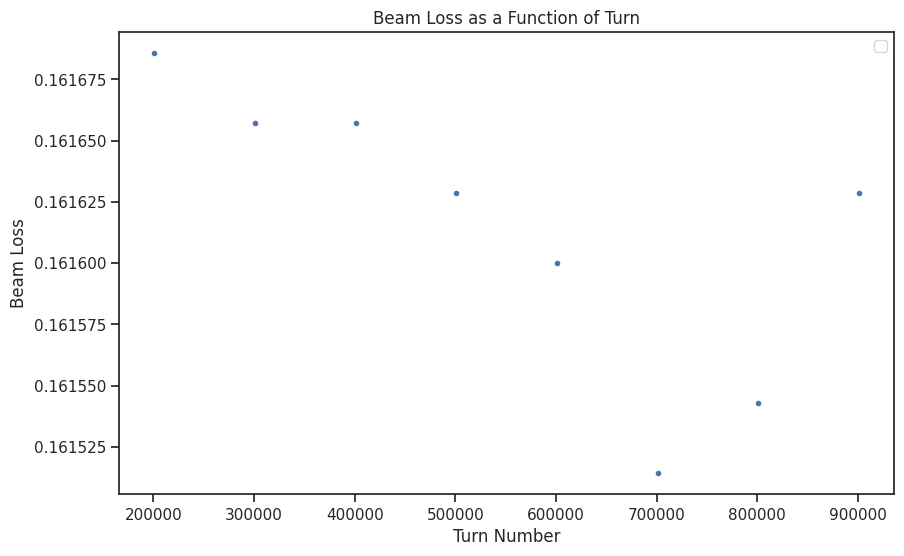

Number of survived particles for all turns (noise particles): [35000, 29478, 29341, 29342, 29342, 29343, 29344, 29347, 29346, 29343]
Initial number of particles (noise): 35000


In [11]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[::100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise_new.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i, len(turns)+1):
        print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    #filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

35000
1
2
3
4
5
6
7
8
9
10
29478
2
3
4
5
6
7
8
9
10
29341
3
4
5
6
7
8
9
10
29342
4
5
6
7
8
9
10
29342
5
6
7
8
9
10
29343
6
7
8
9
10
29344
7
8
9
10
29347
8
9
10
29346
9
10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


29343
10


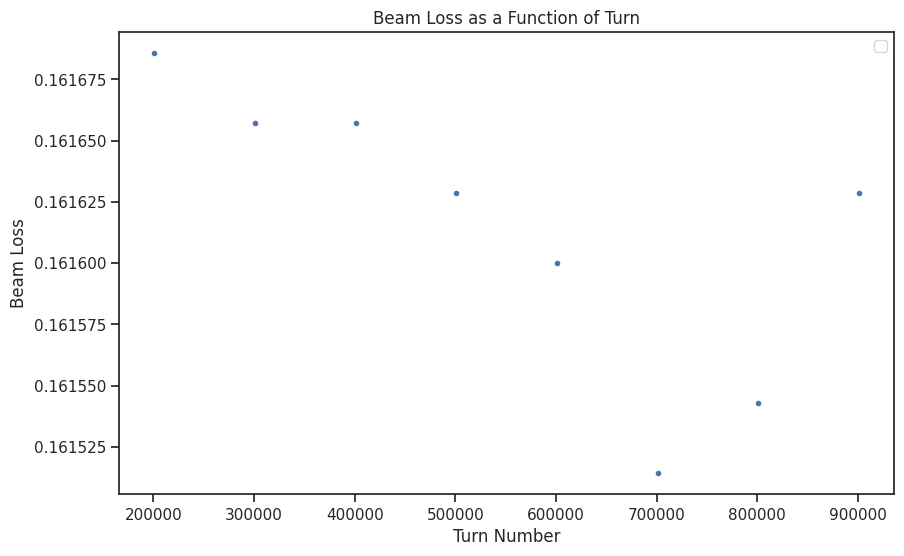

Number of survived particles for all turns (noise particles): [35000, 29478, 29341, 29342, 29342, 29343, 29344, 29347, 29346, 29343]
Initial number of particles (noise): 35000


In [12]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[::100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise_new.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i+1, len(turns)+1):
        print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    #filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [13]:
df__copy[df_copy.at_turn = 2000]

SyntaxError: cannot assign to attribute here. Maybe you meant '==' instead of '='? (<ipython-input-13-bc1ab50bfed4>, line 1)

In [14]:
df__copy[df_copy.at_turn = 20000]

SyntaxError: cannot assign to attribute here. Maybe you meant '==' instead of '='? (<ipython-input-14-e7e6aec07cfb>, line 1)

In [15]:
df_copy[df_copy.at_turn = 20000]

SyntaxError: cannot assign to attribute here. Maybe you meant '==' instead of '='? (<ipython-input-15-04f3e2c229eb>, line 1)

In [16]:
df_copy[df_copy.at_turn == 20000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn,lost
620001,0.712303,0.123061,0.000621,-1.485726,1.050756,0.000658,1,20000,1.0
620002,-1.230974,-0.569287,0.006036,-0.060148,-0.151152,-0.006878,1,20000,1.0
620003,-0.279967,-1.230043,0.010788,1.276064,0.639216,-0.004009,1,20000,1.0
620004,0.048956,0.048782,-0.000217,-0.563885,1.236256,0.002727,1,20000,1.0
620005,-0.321166,-1.236714,-0.005349,0.614159,0.930563,-0.000577,1,20000,1.0
...,...,...,...,...,...,...,...,...,...
649996,-1.745725,0.976873,-0.009353,1.073876,1.001518,0.004236,1,20000,1.0
649997,-0.244616,-1.476623,0.008458,0.766783,0.306960,0.005090,1,20000,1.0
649998,0.153320,0.260760,-0.002979,-0.959287,-0.874419,-0.001197,1,20000,1.0
649999,-0.512608,-1.205962,-0.000940,-0.361231,-0.467567,-0.007553,1,20000,1.0


In [17]:
df_copy[df_copy.at_turn == 2000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn,lost
35001,-0.123802,-0.466109,-0.008544,-1.368465,-1.034662,0.007701,1,2000,1.0
35002,0.689380,-1.615860,0.002148,0.992111,-0.184118,0.003320,1,2000,1.0
35003,1.132711,1.392436,0.009196,1.675403,-1.046433,-0.000881,1,2000,1.0
35004,-0.008551,2.036213,0.002781,1.290332,-0.661702,-0.000134,1,2000,1.0
35005,2.266865,-0.743510,0.001796,-0.702227,1.354679,-0.004200,1,2000,1.0
...,...,...,...,...,...,...,...,...,...
69996,-0.080946,-0.568339,0.000204,0.762782,1.699969,-0.004411,1,2000,1.0
69997,-0.197478,-1.403895,0.000549,0.188303,-0.578336,0.003394,1,2000,1.0
69998,-1.302310,-0.218591,0.006059,0.019787,-0.030744,-0.003727,1,2000,1.0
69999,-0.941776,-0.461158,-0.002030,-0.216077,-2.392658,0.002348,1,2000,1.0


In [18]:
df_copy[df_copy.at_turn == 1000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn,lost
1,-1.525864,0.650588,-0.001624,0.703469,-0.298374,0.006840,1,1000,1.0
2,0.208894,0.653619,0.351423,1.171326,-0.862641,-0.010960,1,1000,-1.0
3,-0.214140,1.046140,0.000562,-0.396704,0.332318,0.001711,1,1000,-1.0
4,1.219533,0.093875,0.005320,0.744953,1.064999,-0.001032,1,1000,-1.0
5,0.861668,0.896544,-0.004130,-0.342374,0.805612,0.001925,1,1000,-1.0
...,...,...,...,...,...,...,...,...,...
34996,1.535070,0.469826,-0.004279,0.615622,-0.056784,-0.002662,1,1000,1.0
34997,0.084949,3.586812,-0.001595,0.758539,1.538391,-0.010383,1,1000,1.0
34998,-0.016422,0.666144,0.000604,0.865200,-0.308647,-0.002423,1,1000,1.0
34999,0.404352,1.590848,-0.005218,0.735205,-0.426710,-0.001502,1,1000,1.0


In [19]:
turns

array([  1000, 101000, 201000, 301000, 401000, 501000, 601000, 701000,
       801000, 901000], dtype=int32)

In [20]:
df_copy[df_copy.at_turn == 10100]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn,lost


In [38]:
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_quad_300_12e-6/**/*norm.parquet')
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/part*.parquet')
files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/**/*norm.parquet')
files_new = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_no_noise/**/*norm.parquet')[:]

In [40]:
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_quad_300_12e-6/**/*norm.parquet')
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/part*.parquet')
files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/**/*norm.parquet')
files_new = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_no_noise/**/*norm.parquet')[:3]

In [41]:
df_all = pd.DataFrame()
for file in files:
    df = pd.read_parquet(file)
    df_all = pd.concat([df_all, df], ignore_index=True)

df_noise = pd.DataFrame()
for file in files_new:
    df = pd.read_parquet(file)
    df_noise = pd.concat([df_noise, df], ignore_index=True)

df_noise_sorted = df_noise.sort_values(by=['at_turn'])
df_noise_new= df_noise_sorted.reset_index(drop=True)

In [42]:
df_noise_new[df_noise_new.at_turn ==1000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
0,-1.525864,0.650588,-0.001624,0.703469,-0.298374,0.006840,1,1000
1,0.208894,0.653619,0.351423,1.171326,-0.862641,-0.010960,1,1000
2,-0.214140,1.046140,0.000562,-0.396704,0.332318,0.001711,1,1000
3,1.219533,0.093875,0.005320,0.744953,1.064999,-0.001032,1,1000
4,0.861668,0.896544,-0.004130,-0.342374,0.805612,0.001925,1,1000
...,...,...,...,...,...,...,...,...
14995,1.535070,0.469826,-0.004279,0.615622,-0.056784,-0.002662,1,1000
14996,0.084949,3.586812,-0.001595,0.758539,1.538391,-0.010383,1,1000
14997,-0.016422,0.666144,0.000604,0.865200,-0.308647,-0.002423,1,1000
14998,0.404352,1.590848,-0.005218,0.735205,-0.426710,-0.001502,1,1000


In [43]:
df_noise_new[df_noise_new.at_turn ==2000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
15000,-0.458295,1.052543,-0.000661,0.538997,1.391361,0.009301,1,2000
15001,-1.217627,-0.604153,-0.002780,0.385937,0.475223,-0.002632,1,2000
15002,-0.370939,-2.275803,0.006196,1.176688,-0.742790,-0.002637,1,2000
15003,0.662218,-0.322643,-0.004740,2.246040,-0.382798,-0.004135,1,2000
15004,1.084085,-0.544525,-0.004688,0.492339,0.405314,0.007625,1,2000
...,...,...,...,...,...,...,...,...
29995,1.344911,1.325999,-0.005503,-0.559482,-1.275373,-0.002249,1,2000
29996,0.344147,0.869502,0.011106,-0.687234,-0.853214,0.005799,1,2000
29997,-1.173652,2.106448,0.003745,0.752309,-0.765909,0.003685,1,2000
29998,-0.771274,-0.126134,-0.008581,0.486853,-1.179815,0.004478,1,2000


In [44]:
df_noise_new[df_noise_new.at_turn ==3000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
30000,-0.784678,0.261006,0.007233,0.227564,-1.514789,0.000601,1,3000
30001,0.398876,-0.237880,-0.001797,-0.332028,0.556398,-0.000440,1,3000
30002,0.760680,-0.451371,0.000240,2.515468,1.386185,0.005379,1,3000
30003,-0.364896,0.245899,-0.002968,1.115172,0.036328,-0.003545,1,3000
30004,0.188971,0.650419,0.002802,0.180092,-0.454676,0.001502,1,3000
...,...,...,...,...,...,...,...,...
44995,2.340536,0.779311,0.007827,-0.123741,-0.288739,0.004913,1,3000
44996,-0.685687,0.022453,0.002918,0.145295,-0.233583,0.001159,1,3000
44997,-0.699354,-0.505363,0.009282,0.216514,-0.545077,0.005692,1,3000
44998,0.785005,0.427655,-0.004939,0.210640,-1.546712,-0.007653,1,3000


15000
1
2
3
4
5
6
7
8
9
10
15000
2
3
4
5
6
7
8
9
10
15000
3
4
5
6
7
8
9
10
15000
4
5
6
7
8
9
10
15000
5
6
7
8
9
10
15000
6
7
8
9
10
15000
7
8
9
10
15000
8
9
10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


15000
9
10
15000
10


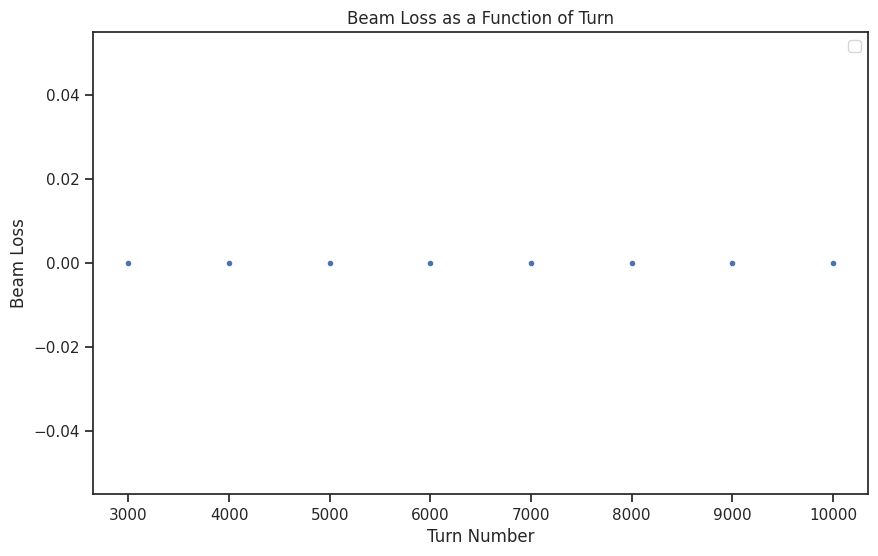

Number of survived particles for all turns (noise particles): [15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000]
Initial number of particles (noise): 15000


In [46]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[:10]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise_new.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i+1, len(turns)+1):
        print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    #filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
9999
10000
10000
10000
10000
10000
10000
10000
9999
9999
9999
9997
9995
9994
9995
9992
9989
9989
9987
9982
9985
9974
9973
9959
9956
9945
9942
9923
9914
9907
9884
9880
9855
9852
9834
9816
9805
9776
9764
9750
9736
9711
9704
9683
9675
9672
9649
9631
9615
9610
9587
9587
9561
9559
9576
9576
9587
9599
9602
9615
9632
9647
9669
9699
9713
9753
9767
9798
9802
9825
9825


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


9822
9814
9817
9809


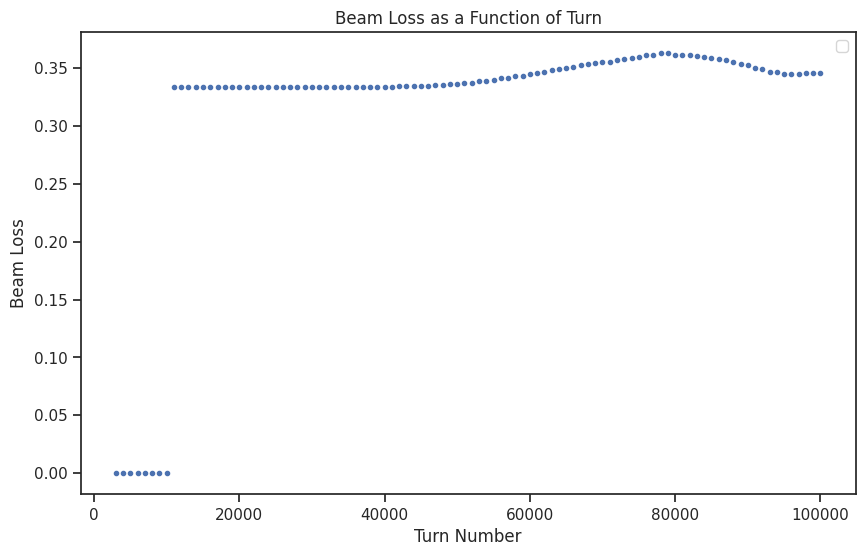

Number of survived particles for all turns (noise particles): [15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 9999, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 9999, 9999, 9999, 9997, 9995, 9994, 9995, 9992, 9989, 9989, 9987, 9982, 9985, 9974, 9973, 9959, 9956, 9945, 9942, 9923, 9914, 9907, 9884, 9880, 9855, 9852, 9834, 9816, 9805, 9776, 9764, 9750, 9736, 9711, 9704, 9683, 9675, 9672, 9649, 9631, 9615, 9610, 9587, 9587, 9561, 9559, 9576, 9576, 9587, 9599, 9602, 9615, 9632, 9647, 9669, 9699, 9713, 9753, 9767, 9798, 9802, 9825, 9825, 9822, 9814, 9817, 9809]
Initial number of particles (noise): 15000


In [47]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[:100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise_new.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i+1, len(turns)+1):
        #print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    #filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [48]:
df_noise_new[df_noise_new==100000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
10049995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10049996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10049997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10049998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df_noise_new[df_noise_new.at_turn==100000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
1040000,0.566020,-0.500098,-0.003900,0.495217,-0.509164,-0.011012,1,100000
1040001,-0.936782,0.240614,-0.000882,-0.360677,-1.213677,-0.000101,1,100000
1040002,-0.871964,0.508277,0.005422,0.326479,1.117950,0.003979,1,100000
1040003,0.493293,0.594987,0.003577,1.254090,-0.389649,0.002562,1,100000
1040004,-0.112192,-0.299953,-0.001941,-0.668957,3.745010,-0.005966,1,100000
...,...,...,...,...,...,...,...,...
1049995,-0.649714,0.088804,-0.004673,-1.187925,1.255572,0.007942,1,100000
1049996,-0.510578,-0.212671,0.008985,0.457022,1.182187,0.003449,1,100000
1049997,-1.319257,0.566741,0.000479,0.335014,-0.249909,0.001970,1,100000
1049998,0.073212,-1.425469,0.000823,-0.667377,-1.347848,0.001312,1,100000


In [50]:
df_noise_new[df_noise_new.at_turn==90000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
940000,-0.280197,0.257523,-0.000021,-0.274034,0.258426,0.003167,1,90000
940001,1.128580,-0.286618,-0.004250,0.771192,-0.949607,0.009963,1,90000
940002,-0.188939,-0.214772,0.007242,0.063218,1.640653,0.000901,1,90000
940003,0.967600,-0.958895,0.000756,-0.796434,0.121287,0.002612,1,90000
940004,0.076177,0.930396,-0.009158,0.680687,-1.081387,0.008811,1,90000
...,...,...,...,...,...,...,...,...
949995,0.234377,0.420452,-0.006819,-0.111427,-1.522693,0.004129,1,90000
949996,-1.329680,-9.081927,38.002244,-9.258131,-0.587585,0.420620,1,90000
949997,-1.585953,-0.221071,0.004254,-0.668120,0.995211,-0.004049,1,90000
949998,0.650663,-1.510467,0.006831,0.018757,0.762109,0.001500,1,90000


In [51]:
df_noise_new[df_noise_new.at_turn==10000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
135000,0.360618,-0.355852,0.001416,0.144122,0.082770,-0.002833,1,10000
135001,-0.418615,0.990247,-0.005389,1.296979,-0.010715,0.009439,1,10000
135002,0.201784,-1.582604,-0.002514,0.020264,-0.494399,-0.006506,1,10000
135003,-1.096452,-0.673010,-0.002071,-0.603865,-0.700614,0.001770,1,10000
135004,0.788993,0.342543,-0.014679,0.102780,1.336517,0.002144,1,10000
...,...,...,...,...,...,...,...,...
149995,0.451787,1.414938,0.000353,2.387558,0.445501,-0.004552,1,10000
149996,0.034847,1.943645,-0.004783,-0.296621,0.569894,-0.001453,1,10000
149997,2.454431,-1.259041,-0.002744,0.812727,-0.131264,0.001439,1,10000
149998,2.267321,0.789960,0.006118,-1.403089,0.687114,-0.006794,1,10000


In [52]:
df_noise_new[df_noise_new.at_turn==20000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
240000,1.718402,-0.196966,-0.005547,0.729756,-1.681581,0.011347,1,20000
240001,-1.145238,-0.013124,-0.009082,0.325497,-0.029961,0.006699,1,20000
240002,-1.012495,0.187523,0.001735,1.235533,-1.896353,0.003177,1,20000
240003,-0.124190,-0.257605,0.002002,1.504636,0.341557,-0.000047,1,20000
240004,0.594493,1.589661,0.001872,1.145716,-1.729613,-0.001344,1,20000
...,...,...,...,...,...,...,...,...
249995,0.711176,0.394866,0.000279,0.026968,-1.328748,-0.002174,1,20000
249996,-1.172915,-0.973337,-0.003589,-1.253099,0.749376,-0.010220,1,20000
249997,1.469296,0.142116,0.005413,1.317510,-0.039325,-0.003909,1,20000
249998,0.583422,2.184637,0.000935,3.176958,-0.051540,-0.008347,1,20000


In [53]:
df_noise_new[df_noise_new.at_turn==15000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
190000,0.325530,-1.033774,0.010685,1.110949,-0.876919,0.002991,1,15000
190001,-0.501728,2.797052,-0.014311,1.198309,-0.254099,-0.001367,1,15000
190002,0.136321,-0.877346,-0.003502,1.450541,-0.397684,-0.006450,1,15000
190003,-1.257564,-0.897744,0.001279,-0.675254,0.502441,-0.000266,1,15000
190004,-1.088488,0.285404,-0.002780,0.236291,-0.548355,0.005334,1,15000
...,...,...,...,...,...,...,...,...
199995,0.417105,0.028940,-0.003588,-1.336866,0.457388,-0.002581,1,15000
199996,1.479292,0.944294,-0.003933,-0.160237,1.624287,0.000092,1,15000
199997,-1.008653,0.607695,-0.001410,-0.778695,-0.104217,0.001229,1,15000
199998,0.637539,1.008851,0.004947,0.514624,0.824487,-0.001648,1,15000


In [54]:
df_noise_new[df_noise_new.at_turn==12000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
160000,-0.604834,-1.718645,0.002669,-0.169199,0.062285,0.005104,1,12000
160001,0.811507,-0.559253,0.005427,0.565247,1.153894,-0.004588,1,12000
160002,-0.700582,-0.883178,-0.004751,1.766825,-0.137959,0.000388,1,12000
160003,-0.247296,-1.226953,-0.004881,-0.120203,2.460272,-0.007462,1,12000
160004,-0.610443,-0.113724,0.003100,-1.247070,-0.006653,-0.000371,1,12000
...,...,...,...,...,...,...,...,...
169995,0.534869,0.278440,0.001281,-0.685651,2.511332,-0.006253,1,12000
169996,0.060066,-0.148884,0.001798,-0.407194,0.011932,0.003895,1,12000
169997,-1.250081,1.298175,-0.005665,0.762152,0.609150,0.010809,1,12000
169998,-0.444445,0.560661,0.010162,0.511209,-1.077741,-0.002144,1,12000


In [55]:
df_noise_new[df_noise_new.at_turn==10000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
135000,0.360618,-0.355852,0.001416,0.144122,0.082770,-0.002833,1,10000
135001,-0.418615,0.990247,-0.005389,1.296979,-0.010715,0.009439,1,10000
135002,0.201784,-1.582604,-0.002514,0.020264,-0.494399,-0.006506,1,10000
135003,-1.096452,-0.673010,-0.002071,-0.603865,-0.700614,0.001770,1,10000
135004,0.788993,0.342543,-0.014679,0.102780,1.336517,0.002144,1,10000
...,...,...,...,...,...,...,...,...
149995,0.451787,1.414938,0.000353,2.387558,0.445501,-0.004552,1,10000
149996,0.034847,1.943645,-0.004783,-0.296621,0.569894,-0.001453,1,10000
149997,2.454431,-1.259041,-0.002744,0.812727,-0.131264,0.001439,1,10000
149998,2.267321,0.789960,0.006118,-1.403089,0.687114,-0.006794,1,10000


In [56]:
df_noise_new[df_noise_new.at_turn==11000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
150000,-0.287831,-0.864229,-0.007742,0.475738,-0.739484,0.004369,1,11000
150001,-1.310161,0.419637,0.000743,-0.387064,0.444833,-0.002502,1,11000
150002,0.582813,-2.195428,-0.000556,0.311537,-1.030370,-0.001186,1,11000
150003,0.793526,0.100860,0.000825,0.300589,1.533383,-0.002201,1,11000
150004,-0.160885,-0.678432,0.001194,0.210732,1.417912,-0.007650,1,11000
...,...,...,...,...,...,...,...,...
159995,-0.023325,-2.433635,0.000704,0.192751,-0.079498,-0.000120,1,11000
159996,0.767130,-0.229502,0.001762,-0.401084,-0.434300,0.001878,1,11000
159997,-0.713133,-0.303279,-0.009538,0.481760,0.444369,-0.003340,1,11000
159998,-0.070352,0.790514,-0.008012,0.108888,-0.375807,0.001063,1,11000


In [57]:
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_quad_300_12e-6/**/*norm.parquet')
#files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/part*.parquet')
files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_nonoise_ready/**/*norm.parquet')
files_new = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_no_noise/**/*norm.parquet')[:3]

In [58]:
df_all = pd.DataFrame()
for file in files:
    df = pd.read_parquet(file)
    df_all = pd.concat([df_all, df], ignore_index=True)

df_noise = pd.DataFrame()
for file in files_new:
    df = pd.read_parquet(file)
    df_noise = pd.concat([df_noise, df], ignore_index=True)

df_noise_sorted = df_noise.sort_values(by=['at_turn'])
df_noise_new= df_noise_sorted.reset_index(drop=True)

In [59]:
df_noise_new[df_noise_new.at_turn==10000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
135000,-0.714825,-0.833509,0.001094,-0.528619,-0.261789,0.003650,1,10000
135001,0.155334,-1.285113,0.006540,1.496963,-0.682404,-0.004503,1,10000
135002,-0.064303,1.018118,-0.001824,-0.735965,-0.370307,0.003840,1,10000
135003,-1.806615,-3.296031,0.006020,-1.341284,-1.092988,-0.005205,1,10000
135004,1.602784,0.022758,-0.004513,-1.492044,1.530757,-0.005314,1,10000
...,...,...,...,...,...,...,...,...
149995,1.838868,-0.672958,0.000186,-0.467481,-0.379485,-0.003801,1,10000
149996,-0.770120,2.553899,0.003897,-0.603693,1.863356,-0.011999,1,10000
149997,-0.078821,1.821887,0.003805,-1.154532,-1.393756,0.001198,1,10000
149998,1.089218,0.956563,-0.008154,2.004053,1.026418,-0.007447,1,10000


In [60]:
files_new

['/eos/user/a/aradosla/SWAN_projects/Noise_sim_no_noise/xtrack_0001/output_particles_norm.parquet',
 '/eos/user/a/aradosla/SWAN_projects/Noise_sim_no_noise/xtrack_0002/output_particles_norm.parquet',
 '/eos/user/a/aradosla/SWAN_projects/Noise_sim_no_noise/xtrack_0003/output_particles_norm.parquet']

In [61]:
df_noise_new[df_noise_new.at_turn==11000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn
150000,-0.779505,1.336359,-0.004587,1.909406,-1.407272,-0.002133,1,11000
150001,-0.273759,1.061454,-0.003221,0.477698,1.841457,0.000517,1,11000
150002,0.057927,-0.714222,0.000093,0.223197,-0.541156,0.007715,1,11000
150003,0.905197,-1.441731,0.003434,0.804564,0.866909,0.004231,1,11000
150004,-0.852186,-1.087865,0.010840,0.573495,0.108518,-0.005430,1,11000
...,...,...,...,...,...,...,...,...
164995,-0.610246,-0.079731,-0.008960,-1.837491,1.483085,0.004375,1,11000
164996,-0.218368,0.721511,0.001650,-0.202636,-1.162894,-0.002091,1,11000
164997,0.379746,-0.804009,0.003100,-0.635841,-0.079030,0.002111,1,11000
164998,-0.438874,0.984304,0.009147,0.040670,-0.682161,-0.002003,1,11000


15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
14999
15000
15000
15000
15000
15000
15000
14999
14999
14999
14998
14997
14994
14988
14987
14983
14976
14975
14969
14957
14946
14931
14920
14897
14877
14862
14854
14817
14808
14782
14754
14712
14688
14685
14636
14617
14594
14594
14518
14523
14494
14441
14413
14389
14375
14357
14318
14305
14272
14259
14271
14245
14219
14228
14220
14215
14199
14219
14227
14218
14211
14249
14260
14282
14310
14340
14374
14387
14416
14470
14516
14557


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


14615
14675
14705


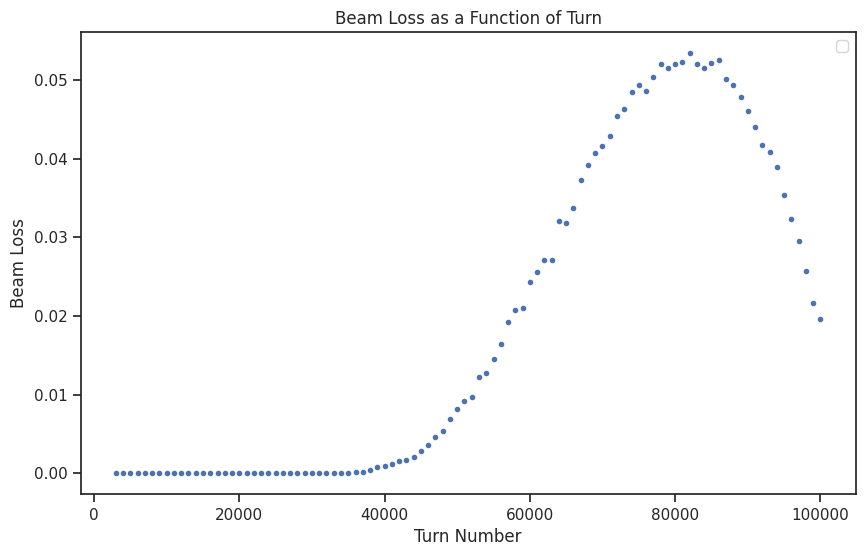

Number of survived particles for all turns (noise particles): [15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 14999, 15000, 15000, 15000, 15000, 15000, 15000, 14999, 14999, 14999, 14998, 14997, 14994, 14988, 14987, 14983, 14976, 14975, 14969, 14957, 14946, 14931, 14920, 14897, 14877, 14862, 14854, 14817, 14808, 14782, 14754, 14712, 14688, 14685, 14636, 14617, 14594, 14594, 14518, 14523, 14494, 14441, 14413, 14389, 14375, 14357, 14318, 14305, 14272, 14259, 14271, 14245, 14219, 14228, 14220, 14215, 14199, 14219, 14227, 14218, 14211, 14249, 14260, 14282, 14310, 14340, 14374, 14387, 14416, 14470, 14516, 14557, 14615, 14675, 14705]
Initial number of particles (noise): 15000


In [62]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[:100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise_new.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i+1, len(turns)+1):
        #print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    #filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [63]:
turns[i:]

array([100000], dtype=int32)

In [64]:
df_copy[df_copy.at_turn == 100000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn,lost
1485001,1.156301,1.198720,0.004130,0.534556,0.887483,0.001560,1,100000,1.0
1485002,-1.122973,0.278920,-0.006292,-0.507309,-0.191491,0.001370,1,100000,1.0
1485003,-1.641376,-1.709471,-0.000133,2.360002,-0.668742,-0.001501,1,100000,1.0
1485004,-0.679335,0.353075,-0.000286,0.366305,-1.630103,0.010181,1,100000,1.0
1485005,1.471784,-0.535734,0.005480,-0.494850,1.325535,0.000476,1,100000,1.0
...,...,...,...,...,...,...,...,...,...
1499996,-0.364880,1.639680,0.002544,0.021709,-0.843755,-0.002469,1,100000,1.0
1499997,-2.814228,0.730284,-0.003885,-0.293197,-1.449263,0.004562,1,100000,1.0
1499998,-0.892613,-1.160763,0.006838,-0.817234,1.128675,-0.003759,1,100000,1.0
1499999,0.291251,-0.107658,-0.003537,1.703149,0.150042,0.004052,1,100000,1.0


In [65]:
df_copy[df_copy.at_turn == 100000]/1000

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn,lost
1485001,0.001156,0.001199,4.130295e-06,0.000535,0.000887,1.560353e-06,0.001,100.0,0.001
1485002,-0.001123,0.000279,-6.291854e-06,-0.000507,-0.000191,1.370161e-06,0.001,100.0,0.001
1485003,-0.001641,-0.001709,-1.326214e-07,0.002360,-0.000669,-1.500913e-06,0.001,100.0,0.001
1485004,-0.000679,0.000353,-2.859498e-07,0.000366,-0.001630,1.018108e-05,0.001,100.0,0.001
1485005,0.001472,-0.000536,5.479977e-06,-0.000495,0.001326,4.759129e-07,0.001,100.0,0.001
...,...,...,...,...,...,...,...,...,...
1499996,-0.000365,0.001640,2.544481e-06,0.000022,-0.000844,-2.468627e-06,0.001,100.0,0.001
1499997,-0.002814,0.000730,-3.885327e-06,-0.000293,-0.001449,4.561551e-06,0.001,100.0,0.001
1499998,-0.000893,-0.001161,6.838148e-06,-0.000817,0.001129,-3.759457e-06,0.001,100.0,0.001
1499999,0.000291,-0.000108,-3.537192e-06,0.001703,0.000150,4.052430e-06,0.001,100.0,0.001


In [66]:
df_copy[df_copy.at_turn == 100000].index/1000

Index([1485.001, 1485.002, 1485.003, 1485.004, 1485.005, 1485.006, 1485.007,
       1485.008, 1485.009,  1485.01,
       ...
       1499.991, 1499.992, 1499.993, 1499.994, 1499.995, 1499.996, 1499.997,
       1499.998, 1499.999,   1500.0],
      dtype='float64', length=15000)

In [67]:
df_copy[df_copy.at_turn == 100000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn,lost
1485001,1.156301,1.198720,0.004130,0.534556,0.887483,0.001560,1,100000,1.0
1485002,-1.122973,0.278920,-0.006292,-0.507309,-0.191491,0.001370,1,100000,1.0
1485003,-1.641376,-1.709471,-0.000133,2.360002,-0.668742,-0.001501,1,100000,1.0
1485004,-0.679335,0.353075,-0.000286,0.366305,-1.630103,0.010181,1,100000,1.0
1485005,1.471784,-0.535734,0.005480,-0.494850,1.325535,0.000476,1,100000,1.0
...,...,...,...,...,...,...,...,...,...
1499996,-0.364880,1.639680,0.002544,0.021709,-0.843755,-0.002469,1,100000,1.0
1499997,-2.814228,0.730284,-0.003885,-0.293197,-1.449263,0.004562,1,100000,1.0
1499998,-0.892613,-1.160763,0.006838,-0.817234,1.128675,-0.003759,1,100000,1.0
1499999,0.291251,-0.107658,-0.003537,1.703149,0.150042,0.004052,1,100000,1.0


15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
14999
15000
15000
15000
15000
15000
15000
14999
14999
14999
14998
14997
14994
14989
14987
14983
14976
14976
14969
14957
14946
14931
14920
14897
14878
14865
14856
14821
14815
14785
14758
14715
14689
14692
14646
14624
14604
14602
14522
14530
14502
14450
14425
14407
14393
14376
14335
14315
14283
14279
14302
14261
14244
14256
14238
14229
14228
14243
14252
14244
14246
14282
14297
14327
14357
14382
14404
14425
14471
14520
14570
14628
14669
14716
14719


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


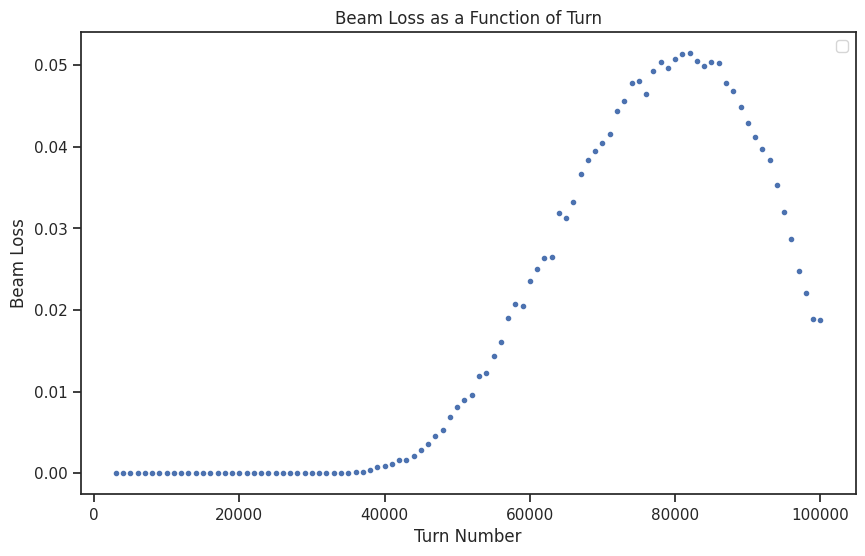

Number of survived particles for all turns (noise particles): [15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 14999, 15000, 15000, 15000, 15000, 15000, 15000, 14999, 14999, 14999, 14998, 14997, 14994, 14989, 14987, 14983, 14976, 14976, 14969, 14957, 14946, 14931, 14920, 14897, 14878, 14865, 14856, 14821, 14815, 14785, 14758, 14715, 14689, 14692, 14646, 14624, 14604, 14602, 14522, 14530, 14502, 14450, 14425, 14407, 14393, 14376, 14335, 14315, 14283, 14279, 14302, 14261, 14244, 14256, 14238, 14229, 14228, 14243, 14252, 14244, 14246, 14282, 14297, 14327, 14357, 14382, 14404, 14425, 14471, 14520, 14570, 14628, 14669, 14716, 14719]
Initial number of particles (noise): 15000


In [68]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[:100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise_new.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i, len(turns)):
        #print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    #filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

15000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
15000
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
15000
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
15000
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


14716
98
99
14719
99


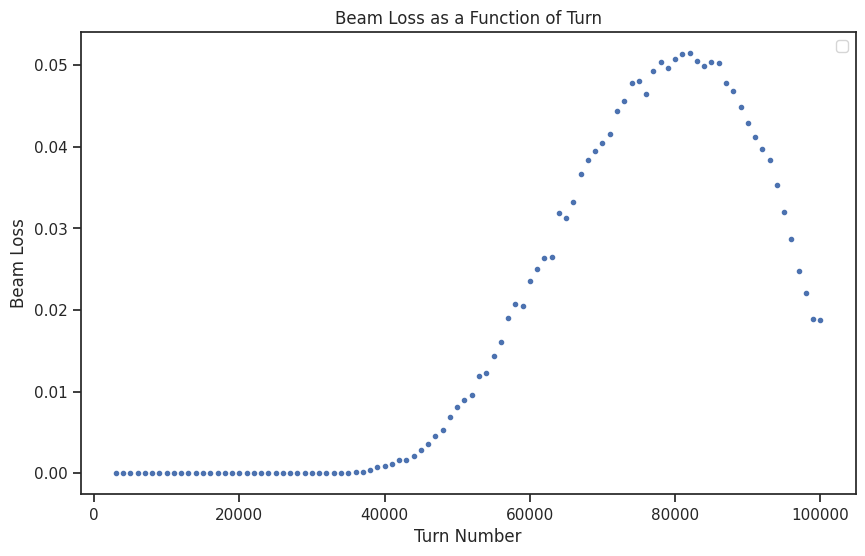

Number of survived particles for all turns (noise particles): [15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 14999, 15000, 15000, 15000, 15000, 15000, 15000, 14999, 14999, 14999, 14998, 14997, 14994, 14989, 14987, 14983, 14976, 14976, 14969, 14957, 14946, 14931, 14920, 14897, 14878, 14865, 14856, 14821, 14815, 14785, 14758, 14715, 14689, 14692, 14646, 14624, 14604, 14602, 14522, 14530, 14502, 14450, 14425, 14407, 14393, 14376, 14335, 14315, 14283, 14279, 14302, 14261, 14244, 14256, 14238, 14229, 14228, 14243, 14252, 14244, 14246, 14282, 14297, 14327, 14357, 14382, 14404, 14425, 14471, 14520, 14570, 14628, 14669, 14716, 14719]
Initial number of particles (noise): 15000


In [72]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[:100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise_new.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i, len(turns)):
        print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    #filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

plt.figure(figsize=(10, 6))
plt.plot(turns[2:], np.array(beam_loss_noise)[2:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


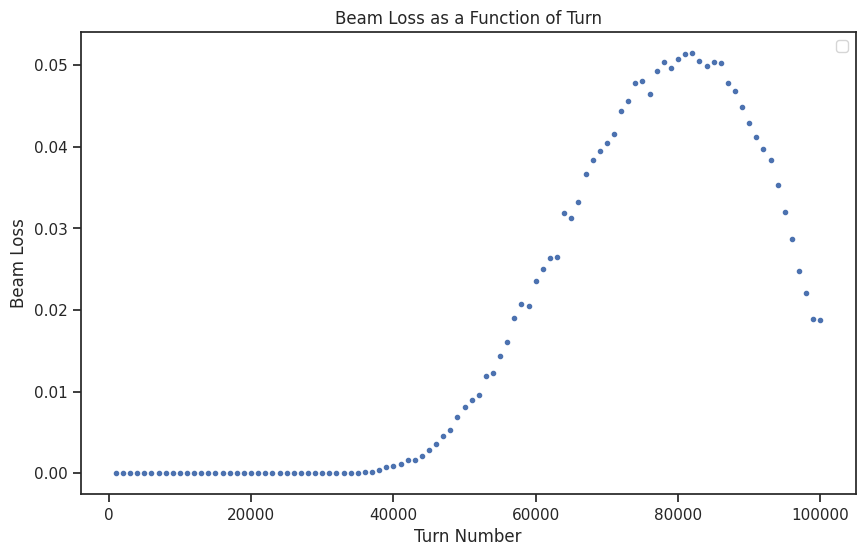

Number of survived particles for all turns (noise particles): [15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 14999, 15000, 15000, 15000, 15000, 15000, 15000, 14999, 14999, 14999, 14998, 14997, 14994, 14989, 14987, 14983, 14976, 14976, 14969, 14957, 14946, 14931, 14920, 14897, 14878, 14865, 14856, 14821, 14815, 14785, 14758, 14715, 14689, 14692, 14646, 14624, 14604, 14602, 14522, 14530, 14502, 14450, 14425, 14407, 14393, 14376, 14335, 14315, 14283, 14279, 14302, 14261, 14244, 14256, 14238, 14229, 14228, 14243, 14252, 14244, 14246, 14282, 14297, 14327, 14357, 14382, 14404, 14425, 14471, 14520, 14570, 14628, 14669, 14716, 14719]
Initial number of particles (noise): 15000


In [74]:
plt.figure(figsize=(10, 6))
plt.plot(turns[:], np.array(beam_loss_noise)[:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [75]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[:100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise_new.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i+1, len(turns)+1):
        print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    #filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

15000
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
15000
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
15000
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
15000
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
4

In [76]:
df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)*turn_new, 'lost'] = -1

In [77]:
(lost_particles_noise.index - min(lost_particles_noise.index)+1)*turn_new

Index([    100,   24400,   28100,   36500,   47400,   47700,   49400,   52500,
         53100,   53600,
       ...
       1444400, 1449800, 1451800, 1457100, 1467500, 1470000, 1471100, 1480900,
       1482900, 1490400],
      dtype='int64', length=281)

In [78]:
print(turn_new)

100


In [79]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[:100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise_new.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i+1, len(turns)+1):
        #print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)*15000*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    #filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
14999
14999
14999
14999
14999
14999
14999
14998
14998
14998
14997


KeyError: '[1235520000] not in index'

In [80]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[:100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise_new.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i+1, len(turns)+1):
        #print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)*1500*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    #filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
14999
15000
15000
15000
15000
15000
15000
14999
14999
14999
14998


KeyError: '[123552000] not in index'

In [81]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[:100]

current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise_new.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(i+1, len(turns)+1):
        #print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)*150*turn_new, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    #filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
14999
15000
15000
15000
15000
15000
15000
14999
14999
14999
14998


KeyError: '[15100800] not in index'

In [84]:
 turn_new*len(df_copy)

405000000

In [85]:
len(df_copy)

15000000

In [86]:
turn_new

27

In [87]:
max(df_copy.index)

15000000

In [88]:
num_initial_particles_noise

15000

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


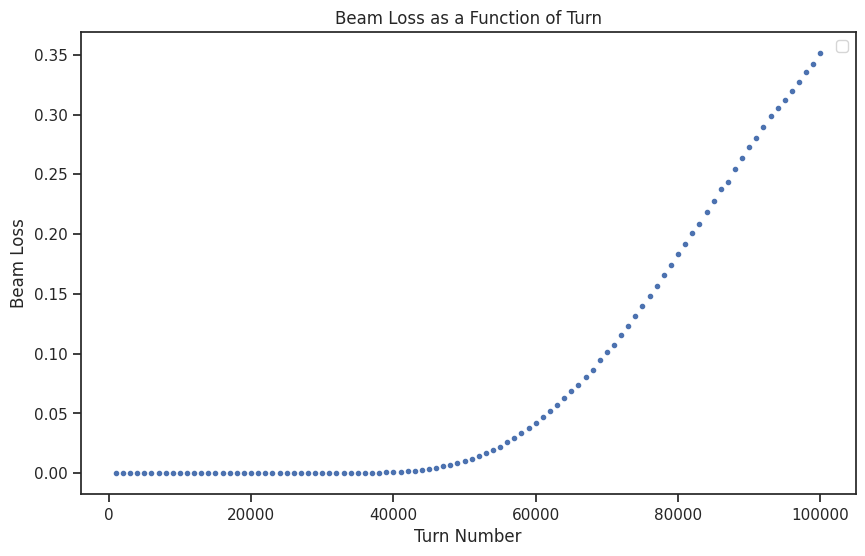

Number of survived particles for all turns (noise particles): [15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 14999, 14999, 14999, 14999, 14999, 14999, 14999, 14998, 14998, 14998, 14997, 14995, 14992, 14989, 14987, 14983, 14975, 14968, 14961, 14949, 14935, 14915, 14893, 14873, 14844, 14817, 14788, 14748, 14706, 14666, 14612, 14552, 14490, 14435, 14364, 14299, 14219, 14140, 14050, 13973, 13894, 13795, 13700, 13582, 13482, 13385, 13267, 13149, 13029, 12899, 12780, 12657, 12516, 12390, 12255, 12126, 11982, 11867, 11727, 11590, 11440, 11341, 11188, 11045, 10908, 10788, 10654, 10524, 10422, 10314, 10202, 10093, 9971, 9863, 9731]
Initial number of particles (noise): 15000


In [90]:
plt.figure(figsize=(10, 6))
plt.plot(turns[:], np.array(beam_loss_noise)[:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [91]:
spacing = 1
np.linspace(0,turns[-1], spacing)

array([0.])

In [92]:
spacing = 1
np.arange(0,turns[-1], spacing)

array([    0,     1,     2, ..., 99997, 99998, 99999])

In [93]:
turns


array([  1000,   2000,   3000,   4000,   5000,   6000,   7000,   8000,
         9000,  10000,  11000,  12000,  13000,  14000,  15000,  16000,
        17000,  18000,  19000,  20000,  21000,  22000,  23000,  24000,
        25000,  26000,  27000,  28000,  29000,  30000,  31000,  32000,
        33000,  34000,  35000,  36000,  37000,  38000,  39000,  40000,
        41000,  42000,  43000,  44000,  45000,  46000,  47000,  48000,
        49000,  50000,  51000,  52000,  53000,  54000,  55000,  56000,
        57000,  58000,  59000,  60000,  61000,  62000,  63000,  64000,
        65000,  66000,  67000,  68000,  69000,  70000,  71000,  72000,
        73000,  74000,  75000,  76000,  77000,  78000,  79000,  80000,
        81000,  82000,  83000,  84000,  85000,  86000,  87000,  88000,
        89000,  90000,  91000,  92000,  93000,  94000,  95000,  96000,
        97000,  98000,  99000, 100000], dtype=int32)

In [94]:
spacing = 1
np.arange(0,turns[-1], spacing*1000)

array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
        9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
       18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000,
       27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000,
       36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000,
       45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000,
       54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000,
       63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000,
       72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000,
       81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000,
       90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000,
       99000])

In [95]:
spacing = 1
np.arange(0,turns[-1]+1, spacing*1000)

array([     0,   1000,   2000,   3000,   4000,   5000,   6000,   7000,
         8000,   9000,  10000,  11000,  12000,  13000,  14000,  15000,
        16000,  17000,  18000,  19000,  20000,  21000,  22000,  23000,
        24000,  25000,  26000,  27000,  28000,  29000,  30000,  31000,
        32000,  33000,  34000,  35000,  36000,  37000,  38000,  39000,
        40000,  41000,  42000,  43000,  44000,  45000,  46000,  47000,
        48000,  49000,  50000,  51000,  52000,  53000,  54000,  55000,
        56000,  57000,  58000,  59000,  60000,  61000,  62000,  63000,
        64000,  65000,  66000,  67000,  68000,  69000,  70000,  71000,
        72000,  73000,  74000,  75000,  76000,  77000,  78000,  79000,
        80000,  81000,  82000,  83000,  84000,  85000,  86000,  87000,
        88000,  89000,  90000,  91000,  92000,  93000,  94000,  95000,
        96000,  97000,  98000,  99000, 100000])

In [96]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[:100]
spacing = 1
current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise_new.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(0,turns[-1]+1, spacing*1000):
        #print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)+ turn_new*num_initial_particles_noise, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    #filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
14999


KeyError: "None of [Index([15000001], dtype='int64')] are in the [index]"

In [99]:
np.arange(0,turns[-1], spacing)

array([    0,     1,     2, ..., 99997, 99998, 99999])

In [100]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


turns = np.unique(df_noise.at_turn)[:100]
spacing = 1
current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise_new.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(0,len(turns), spacing):
        #print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)+ turn_new*num_initial_particles_noise, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    #filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
15000
14999
14999
14999
14999
14999
14999
14999
14998
14998
14998
14997
14995
14992
14989
14987
14983
14975
14968
14961
14949
14935
14915
14893
14873
14844
14817
14788
14748
14706
14666
14612
14552
14490
14435
14364
14299
14219
14140
14050
13973
13894
13795
13700
13582
13482
13385
13267
13149
13029
12899
12780
12657
12516
12390
12255
12126
11982
11867
11727
11590
11440
11341
11188
11045
10908
10788
10654
10524
10422
10314
10202
10093
9971
9863
9731


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


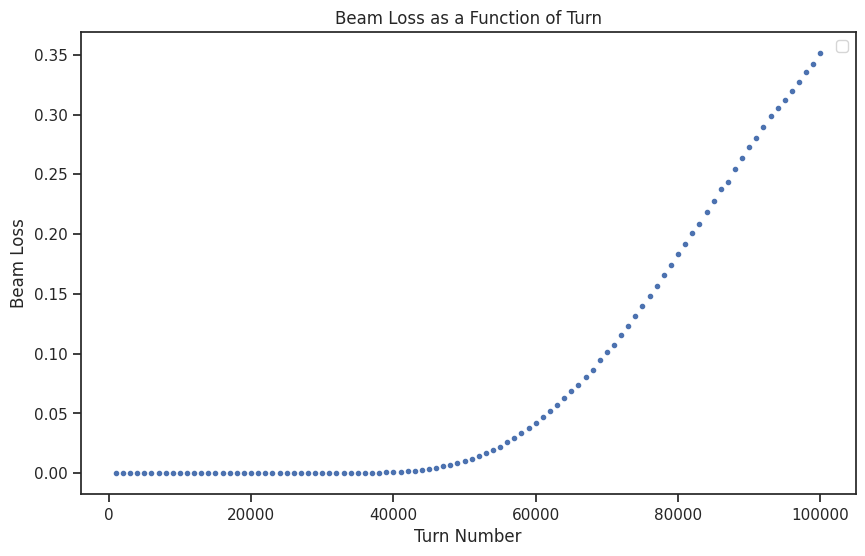

Number of survived particles for all turns (noise particles): [15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 14999, 14999, 14999, 14999, 14999, 14999, 14999, 14998, 14998, 14998, 14997, 14995, 14992, 14989, 14987, 14983, 14975, 14968, 14961, 14949, 14935, 14915, 14893, 14873, 14844, 14817, 14788, 14748, 14706, 14666, 14612, 14552, 14490, 14435, 14364, 14299, 14219, 14140, 14050, 13973, 13894, 13795, 13700, 13582, 13482, 13385, 13267, 13149, 13029, 12899, 12780, 12657, 12516, 12390, 12255, 12126, 11982, 11867, 11727, 11590, 11440, 11341, 11188, 11045, 10908, 10788, 10654, 10524, 10422, 10314, 10202, 10093, 9971, 9863, 9731]
Initial number of particles (noise): 15000


In [101]:
plt.figure(figsize=(10, 6))
plt.plot(turns[:], np.array(beam_loss_noise)[:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [105]:
spacing = 100
turns = np.unique(df_noise.at_turn)[::spacing]

In [106]:
np.arange(0,len(turns), spacing)

array([0])

In [107]:
np.linspace(0,len(turns), spacing)

array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.65656566,  5.75757576,  5.85858586,  5.95959596,
        6.06060606,  6.16161616,  6.26262626,  6.36363636,  6.46464646,
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96

In [108]:
np.linspace(0,len(turns)+1, spacing)

array([ 0.        ,  0.11111111,  0.22222222,  0.33333333,  0.44444444,
        0.55555556,  0.66666667,  0.77777778,  0.88888889,  1.        ,
        1.11111111,  1.22222222,  1.33333333,  1.44444444,  1.55555556,
        1.66666667,  1.77777778,  1.88888889,  2.        ,  2.11111111,
        2.22222222,  2.33333333,  2.44444444,  2.55555556,  2.66666667,
        2.77777778,  2.88888889,  3.        ,  3.11111111,  3.22222222,
        3.33333333,  3.44444444,  3.55555556,  3.66666667,  3.77777778,
        3.88888889,  4.        ,  4.11111111,  4.22222222,  4.33333333,
        4.44444444,  4.55555556,  4.66666667,  4.77777778,  4.88888889,
        5.        ,  5.11111111,  5.22222222,  5.33333333,  5.44444444,
        5.55555556,  5.66666667,  5.77777778,  5.88888889,  6.        ,
        6.11111111,  6.22222222,  6.33333333,  6.44444444,  6.55555556,
        6.66666667,  6.77777778,  6.88888889,  7.        ,  7.11111111,
        7.22222222,  7.33333333,  7.44444444,  7.55555556,  7.66

In [109]:
np.linspace(0,len(turns)-1, spacing)

array([0.        , 0.09090909, 0.18181818, 0.27272727, 0.36363636,
       0.45454545, 0.54545455, 0.63636364, 0.72727273, 0.81818182,
       0.90909091, 1.        , 1.09090909, 1.18181818, 1.27272727,
       1.36363636, 1.45454545, 1.54545455, 1.63636364, 1.72727273,
       1.81818182, 1.90909091, 2.        , 2.09090909, 2.18181818,
       2.27272727, 2.36363636, 2.45454545, 2.54545455, 2.63636364,
       2.72727273, 2.81818182, 2.90909091, 3.        , 3.09090909,
       3.18181818, 3.27272727, 3.36363636, 3.45454545, 3.54545455,
       3.63636364, 3.72727273, 3.81818182, 3.90909091, 4.        ,
       4.09090909, 4.18181818, 4.27272727, 4.36363636, 4.45454545,
       4.54545455, 4.63636364, 4.72727273, 4.81818182, 4.90909091,
       5.        , 5.09090909, 5.18181818, 5.27272727, 5.36363636,
       5.45454545, 5.54545455, 5.63636364, 5.72727273, 5.81818182,
       5.90909091, 6.        , 6.09090909, 6.18181818, 6.27272727,
       6.36363636, 6.45454545, 6.54545455, 6.63636364, 6.72727

In [110]:
np.linspace(0,len(turns))

array([ 0.        ,  0.20408163,  0.40816327,  0.6122449 ,  0.81632653,
        1.02040816,  1.2244898 ,  1.42857143,  1.63265306,  1.83673469,
        2.04081633,  2.24489796,  2.44897959,  2.65306122,  2.85714286,
        3.06122449,  3.26530612,  3.46938776,  3.67346939,  3.87755102,
        4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
        5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
        6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ])

In [111]:
np.linspace(0,len(turns)+1)

array([ 0.        ,  0.2244898 ,  0.44897959,  0.67346939,  0.89795918,
        1.12244898,  1.34693878,  1.57142857,  1.79591837,  2.02040816,
        2.24489796,  2.46938776,  2.69387755,  2.91836735,  3.14285714,
        3.36734694,  3.59183673,  3.81632653,  4.04081633,  4.26530612,
        4.48979592,  4.71428571,  4.93877551,  5.16326531,  5.3877551 ,
        5.6122449 ,  5.83673469,  6.06122449,  6.28571429,  6.51020408,
        6.73469388,  6.95918367,  7.18367347,  7.40816327,  7.63265306,
        7.85714286,  8.08163265,  8.30612245,  8.53061224,  8.75510204,
        8.97959184,  9.20408163,  9.42857143,  9.65306122,  9.87755102,
       10.10204082, 10.32653061, 10.55102041, 10.7755102 , 11.        ])

In [112]:
np.linspace(0,len(turns)+1, 2)

array([ 0., 11.])

In [113]:
np.linspace(0,len(turns)+1,10)

array([ 0.        ,  1.22222222,  2.44444444,  3.66666667,  4.88888889,
        6.11111111,  7.33333333,  8.55555556,  9.77777778, 11.        ])

In [114]:
np.arange(0,len(turns))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [115]:
100*1*1500

150000

In [116]:
turns

array([  1000, 101000, 201000, 301000, 401000, 501000, 601000, 701000,
       801000, 901000], dtype=int32)

In [117]:
df_copy[df_copy.at_turn==101000]

,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,state,at_turn,lost
1500001,1.074523,1.479537,-0.001393,0.357275,0.423506,0.007459,1,101000,1.0
1500002,0.512717,-2.010947,0.000187,-0.317542,0.033772,-0.002037,1,101000,1.0
1500003,-0.459056,-0.872818,0.004862,-0.988882,-1.470403,0.002141,1,101000,1.0
1500004,-0.729446,-0.426260,0.000730,-1.715603,0.394861,-0.008110,1,101000,1.0
1500005,-1.654836,1.727234,0.003298,-0.193744,-1.157302,-0.000776,1,101000,1.0
...,...,...,...,...,...,...,...,...,...
1514996,0.850174,-0.557737,0.002212,0.467633,-1.001852,0.004881,1,101000,1.0
1514997,0.464422,0.933693,-0.000368,-1.349821,-0.374626,0.007661,1,101000,1.0
1514998,-0.844713,-1.034336,0.006054,0.971171,0.117299,-0.006210,1,101000,1.0
1514999,0.592918,-0.188126,-0.000672,0.923816,0.483129,-0.000630,1,101000,1.0


In [118]:
100*1*15000

1500000

In [120]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

spacing = 100
turns = np.unique(df_noise.at_turn)[::spacing]
current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise_new.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(0, len(turns)):
        #print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)+ spacing*turn_new*num_initial_particles_noise, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    #filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

15000
14719
14367
14029
13711
13407
13113
12834
12562
12301


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


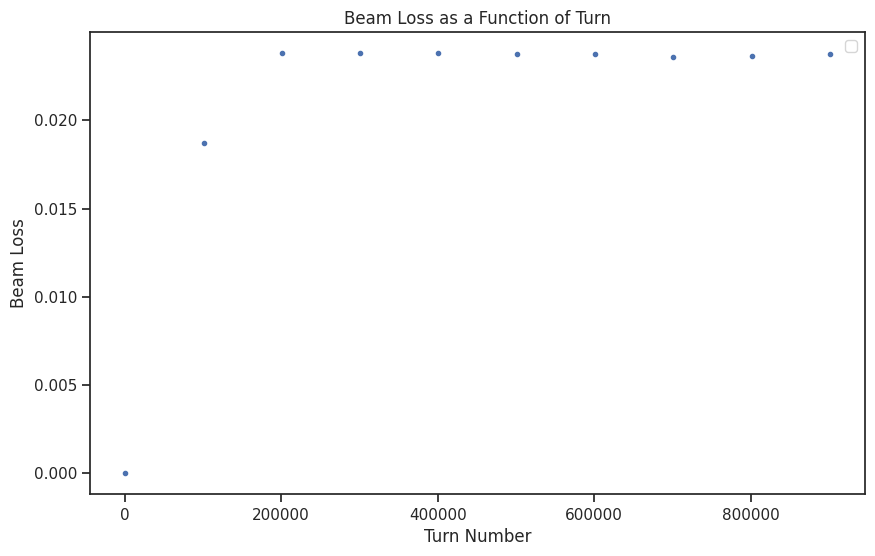

Number of survived particles for all turns (noise particles): [15000, 14719, 14643, 14643, 14643, 14644, 14644, 14646, 14645, 14644]
Initial number of particles (noise): 15000


In [122]:
plt.figure(figsize=(10, 6))
plt.plot(turns[:], np.array(beam_loss_noise)[:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [123]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

spacing = 100
turns = np.unique(df_noise.at_turn)[::spacing]
current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise_new.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(0, len(turns)):
        #print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)+ spacing*turn_new*num_initial_particles_noise, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    #filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

15000
14719
14367
14029
13711
13407
13113
12834
12562
12301


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


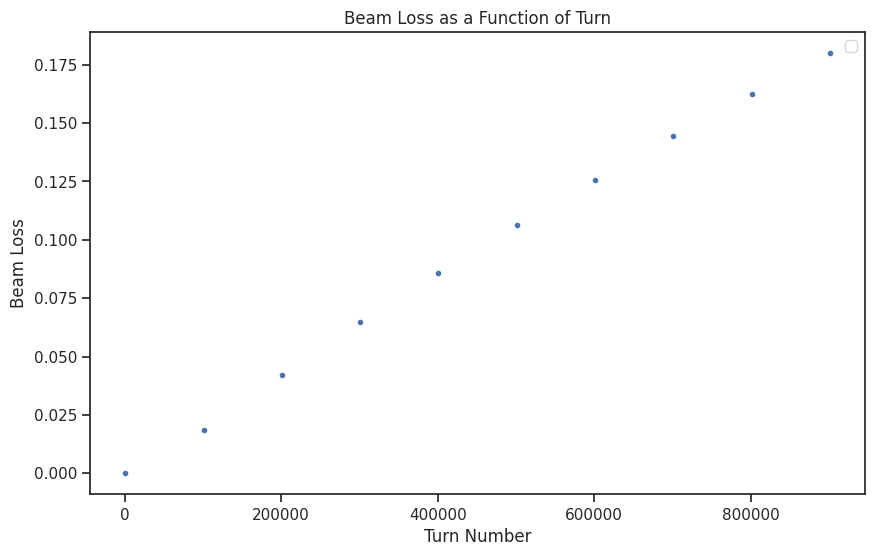

Number of survived particles for all turns (noise particles): [15000, 14719, 14367, 14029, 13711, 13407, 13113, 12834, 12562, 12301]
Initial number of particles (noise): 15000


In [124]:
plt.figure(figsize=(10, 6))
plt.plot(turns[:], np.array(beam_loss_noise)[:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [125]:
np.diff(beam_loss_noise)

array([281, 352, 338, 318, 304, 294, 279, 272, 261])

In [126]:
np.sum(beam_loss_noise)

13957

In [127]:
np.sum(np.diff(beam_loss_noise))

2699

In [128]:
#================== Collimator, beam loss ======================== 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

spacing = 10
turns = np.unique(df_noise.at_turn)[::spacing]
current_aperture = 6  # Replace with the actual value of current_aperture if different
num_survived_noise = []
num_initial_particles_noise = len(df_noise[df_noise_new.at_turn == turns[0]])
df_copy = df_noise_new.copy()
df_copy.index = np.arange(1, len(df_copy) + 1)
beam_loss_noise = []
lost = [] 
df_copy['lost'] = np.ones(len(df_copy))

for i, turn in enumerate(turns):
    # Update the dataframe for the current turn using the cumulative mask
    df_noise_turn = df_copy[(df_copy.at_turn == turn) & (df_copy.lost == 1)]
  
    survived_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) < (current_aperture)**2]
    lost_particles_noise = df_noise_turn[((df_noise_turn.x_norm)**2 + (df_noise_turn.px_norm)**2) >= (current_aperture)**2]  
    print(len(survived_particles_noise))
    for turn_new in np.arange(0, len(turns)):
        #print(turn_new)
        if len(lost_particles_noise) != 0:
            df_copy.loc[(lost_particles_noise.index - min(lost_particles_noise.index)+1)+ spacing*turn_new*num_initial_particles_noise, 'lost'] = -1
        
    survived_particles_indices = survived_particles_noise.index 
    lost.append(len(lost_particles_noise))
    num_survived_noise.append(len(survived_particles_noise))
    #filtered_df = df_copy[(df_copy.at_turn == turn) & (df_copy.lost != 1)]

    beam_loss_noise.append(num_initial_particles_noise - len(survived_particles_noise))

15000
15000
15000
15000
14995
14967
14894
14769
14577
14339
14070
13797
13511
13216
12940
12655
12390
12138
11893
11676
11441
11243
11047
10855
10660
10478
10281
10108
9959
9789
9643
9498
9345
9210
9073
8966
8832
8699
8586
8450
8353
8236
8123
8036
7932
7838
7735
7634
7553
7447
7359
7267
7169
7088
7008
6942
6844
6774
6706
6624
6553
6503
6443
6365
6316
6241
6171
6117
6055
6010
5973
5896
5840
5760
5714
5674
5629
5561
5541
5484
5428
5379
5349
5312
5283
5244
5223
5179
5145
5098
5067
5025
4975
4946
4901
4874
4836
4795
4757
4738


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


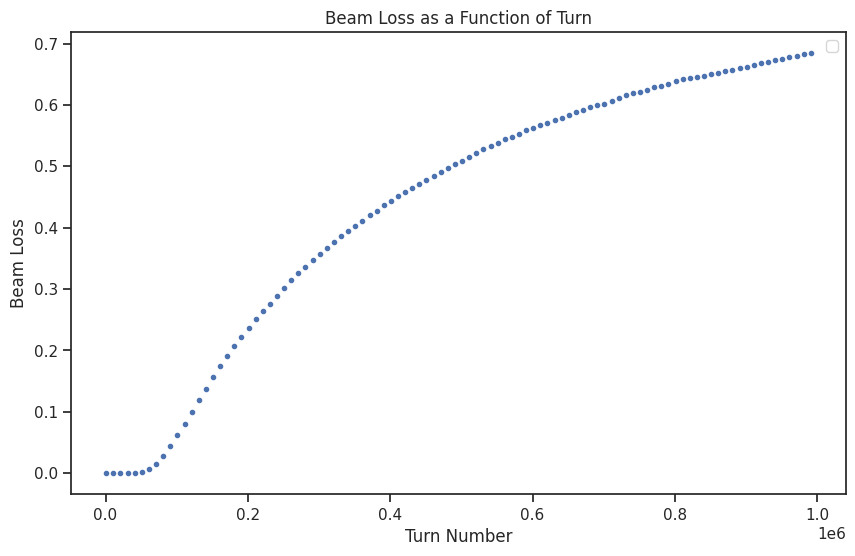

Number of survived particles for all turns (noise particles): [15000, 15000, 15000, 15000, 14995, 14967, 14894, 14769, 14577, 14339, 14070, 13797, 13511, 13216, 12940, 12655, 12390, 12138, 11893, 11676, 11441, 11243, 11047, 10855, 10660, 10478, 10281, 10108, 9959, 9789, 9643, 9498, 9345, 9210, 9073, 8966, 8832, 8699, 8586, 8450, 8353, 8236, 8123, 8036, 7932, 7838, 7735, 7634, 7553, 7447, 7359, 7267, 7169, 7088, 7008, 6942, 6844, 6774, 6706, 6624, 6553, 6503, 6443, 6365, 6316, 6241, 6171, 6117, 6055, 6010, 5973, 5896, 5840, 5760, 5714, 5674, 5629, 5561, 5541, 5484, 5428, 5379, 5349, 5312, 5283, 5244, 5223, 5179, 5145, 5098, 5067, 5025, 4975, 4946, 4901, 4874, 4836, 4795, 4757, 4738]
Initial number of particles (noise): 15000


In [129]:
plt.figure(figsize=(10, 6))
plt.plot(turns[:], np.array(beam_loss_noise)[:]/num_initial_particles_noise, '.')
plt.xlabel('Turn Number')
plt.ylabel('Beam Loss')
plt.legend()
plt.title('Beam Loss as a Function of Turn')
plt.show()

print('Number of survived particles for all turns (noise particles):', num_survived_noise)
print('Initial number of particles (noise):', num_initial_particles_noise)

In [131]:
 np.array(beam_loss_noise)[:]/num_initial_particles_noise

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.33333333e-04, 2.20000000e-03, 7.06666667e-03, 1.54000000e-02,
       2.82000000e-02, 4.40666667e-02, 6.20000000e-02, 8.02000000e-02,
       9.92666667e-02, 1.18933333e-01, 1.37333333e-01, 1.56333333e-01,
       1.74000000e-01, 1.90800000e-01, 2.07133333e-01, 2.21600000e-01,
       2.37266667e-01, 2.50466667e-01, 2.63533333e-01, 2.76333333e-01,
       2.89333333e-01, 3.01466667e-01, 3.14600000e-01, 3.26133333e-01,
       3.36066667e-01, 3.47400000e-01, 3.57133333e-01, 3.66800000e-01,
       3.77000000e-01, 3.86000000e-01, 3.95133333e-01, 4.02266667e-01,
       4.11200000e-01, 4.20066667e-01, 4.27600000e-01, 4.36666667e-01,
       4.43133333e-01, 4.50933333e-01, 4.58466667e-01, 4.64266667e-01,
       4.71200000e-01, 4.77466667e-01, 4.84333333e-01, 4.91066667e-01,
       4.96466667e-01, 5.03533333e-01, 5.09400000e-01, 5.15533333e-01,
       5.22066667e-01, 5.27466667e-01, 5.32800000e-01, 5.37200000e-01,
      

In [132]:
beam_loss_noise

[0,
 0,
 0,
 0,
 5,
 33,
 106,
 231,
 423,
 661,
 930,
 1203,
 1489,
 1784,
 2060,
 2345,
 2610,
 2862,
 3107,
 3324,
 3559,
 3757,
 3953,
 4145,
 4340,
 4522,
 4719,
 4892,
 5041,
 5211,
 5357,
 5502,
 5655,
 5790,
 5927,
 6034,
 6168,
 6301,
 6414,
 6550,
 6647,
 6764,
 6877,
 6964,
 7068,
 7162,
 7265,
 7366,
 7447,
 7553,
 7641,
 7733,
 7831,
 7912,
 7992,
 8058,
 8156,
 8226,
 8294,
 8376,
 8447,
 8497,
 8557,
 8635,
 8684,
 8759,
 8829,
 8883,
 8945,
 8990,
 9027,
 9104,
 9160,
 9240,
 9286,
 9326,
 9371,
 9439,
 9459,
 9516,
 9572,
 9621,
 9651,
 9688,
 9717,
 9756,
 9777,
 9821,
 9855,
 9902,
 9933,
 9975,
 10025,
 10054,
 10099,
 10126,
 10164,
 10205,
 10243,
 10262]